In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi.oracle import Left
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[-0.5437]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.1355]], requires_grad=True)
alpha:  tensor([0.5080])
gt ols coef:  [[-0.5230732]]
gt ols intercept:  [-0.00844839]
trunc ols coef:  [[-0.15787034]]
trunc ols intercept:  [1.7909057]


Text(0, 0.5, 'y')

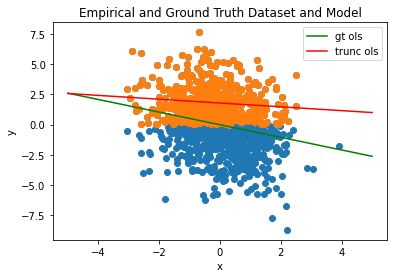

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# m = Uniform(-5, 5)
phi = Left(Tensor([0.0]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))

    y = gt(X)

noise_var = Tensor([5.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [4]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(3.0390)
beta:  tensor(3.0390)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([2.0293])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

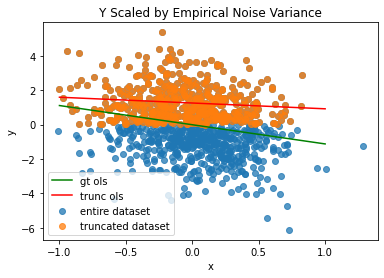

In [5]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

Text(0, 0.5, 'y')

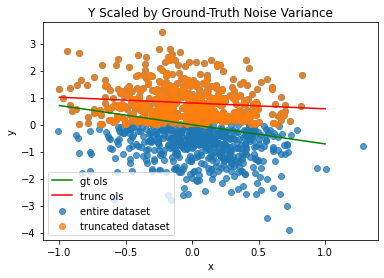

In [6]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [7]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=1000, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm, known_emp_bias_unnorm = (known_emp_res.weight * ch.sqrt(emp_noise_var)) / beta, (known_emp_res.bias * ch.sqrt(emp_noise_var))

reaching threshold
procedure complete


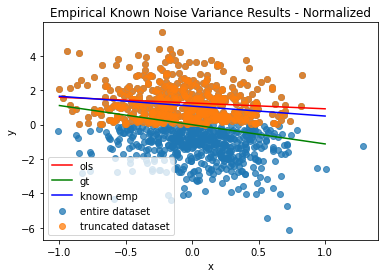

Text(0, 0.5, 'y')

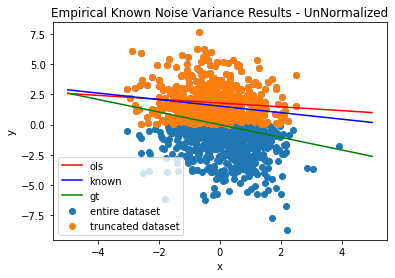

In [8]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [9]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=1000, tol=1e-2)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm, known_bias_unnorm = (known_res.weight * ch.sqrt(noise_var)) / beta, known_res.bias * ch.sqrt(noise_var)

reaching threshold
procedure complete


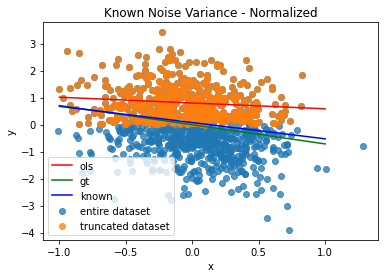

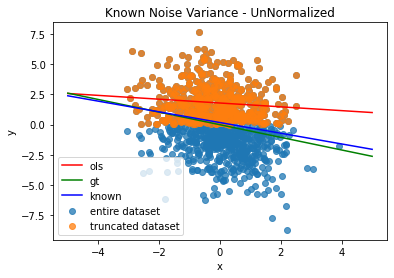

In [10]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [11]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=10, n=1000, tol=1e-2)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * ch.sqrt(emp_noise_var)) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * ch.sqrt(emp_noise_var)).detach().numpy()

grad:  tensor([0.0007])
lambda grad:  tensor([0.0098])
reaching threshold
procedure complete


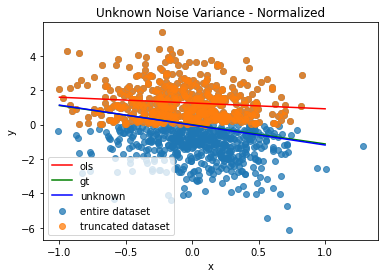

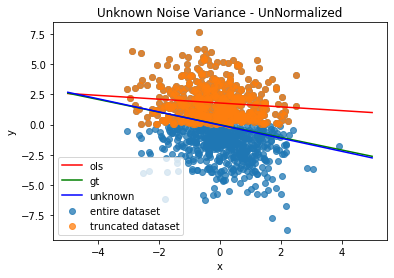

In [12]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [8]:
args.__setattr__('batch_size', 10)
args.__setattr__('steps', 1500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('custom_lr_multiplier', None)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('var_lr', 1e-2)
args.__setattr__('samples', 10000)

EXP = '20DimsYScaleVar50'

In [ ]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 20, 1

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'ols_var_mse': float,
#         'known_emp_r2': float,
#         'known_emp_param_mse': float,
#         'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_var_mse': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })

    # distribution for generating feature vectors
    w = Uniform(w_lower, w_upper)
    dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
    phi = Left(Tensor([0.0]))
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    for noise_var in range(1, 51): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
            'ols_var_mse': mse_loss(ols_var, noise_var), 
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
#         # standardize noised by the empirical noise variance
#         emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
#         trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=ch.ones(1))
#         st = datetime.datetime.now()
#         known_emp_results = trunc_reg.fit(x_trunc, y_trunc)
#         w, w0 = (known_emp_results.weight.detach().cpu()), known_emp_results.bias.detach().cpu()[..., None]
#         known_emp_params = ch.cat([w, w0], dim=1).flatten()
#         # known emp results
#         store[TABLE_NAME].update_row({
#             'known_emp_r2': r2_score(noised.flatten(), X@w.T + w0), 
#             'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
#             'known_emp_time': int((datetime.datetime.now() - st).total_seconds()), 
#         })
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / math.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        stand_noised = noised / math.sqrt(noise_var)
        trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=ch.ones(1))
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
        w, w0 = (known_results.weight.detach().cpu() * math.sqrt(noise_var)) / beta, known_results.bias.detach().cpu()[..., None] * math.sqrt(noise_var)
        known_params = ch.cat([w, w0], dim=1).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        print("known weight grad: ", known_results.weight.grad)
        print("known bias grad: ", known_results.bias.grad)
        
        # truncated regression with unknown variance
        trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
        st = datetime.datetime.now()
        unknown_results = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
#         unknown_results = trunc_reg.fit(x_trunc_norm, y_trunc)

        var_ = unknown_results.lambda_.inverse()
#         unknown_var = unknown_results.lambda_.inverse()

#         unknown_var = var_ * ch.sqrt(emp_noise_var)
        unknown_var = var_ * emp_noise_var

#         print("unknown var: ", unknown_var)
#         print("other var: ", var_ * emp_noise_var)
#         w, w0 = (((unknown_results.weight * unknown_var)) / beta).detach(), ((unknown_results.bias * unknown_var)).detach()

        w, w0 = (((unknown_results.weight * var_) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_results.bias * ch.sqrt(emp_noise_var))).detach()[None,...]
#         w, w0 = ((unknown_results.weight * unknown_var)).detach(), (unknown_results.bias * unknown_var).detach()

        unknown_params = ch.cat([w, w0], dim=1).flatten()
        print("unknown weight grad: ", unknown_results.weight.grad)
        print("unknown bias grad: ", unknown_results.bias.grad)
        print("unknown lambda grad: ", unknown_results.lambda_.grad)

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': ch.abs(unknown_var - noise_var),
            'unknown_var_mse': mse_loss(unknown_var, noise_var),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/e64f9e20-e51b-4b09-a947-bab31e48513e


known weight grad:  tensor([[-0.0034, -0.0007,  0.0179, -0.0009,  0.0044,  0.0010,  0.0100,  0.0106,
          0.0025, -0.0035,  0.0008, -0.0009,  0.0036,  0.0214,  0.0036,  0.0092,
         -0.0071, -0.0042,  0.0155, -0.0038]])
known bias grad:  tensor([-0.1182])


unknown weight grad:  tensor([[-0.0057, -0.0898, -0.0148,  0.0030, -0.0582, -0.0408,  0.0099, -0.0173,
         -0.0442, -0.0359,  0.0170, -0.0042, -0.0078, -0.0384, -0.0566,  0.0132,
          0.0247, -0.0737, -0.0163,  0.1051]])
unknown bias grad:  tensor([-0.0224])
unknown lambda grad:  tensor([[0.5563]])


known weight grad:  tensor([[-0.0104, -0.0033,  0.0035, -0.0097, -0.0025, -0.0083, -0.0020,  0.0009,
          0.0032,  0.0045, -0.0118, -0.0035,  0.0074,  0.0020, -0.0116, -0.0068,
          0.0059, -0.0133,  0.0102,  0.0066]])
known bias grad:  tensor([-0.2182])


unknown weight grad:  tensor([[ 0.0150, -0.0306,  0.0117, -0.0203, -0.0262, -0.0062,  0.0208,  0.0042,
          0.0134,  0.0134,  0.0176,  0.0191,  0.0219,  0.0054,  0.0197, -0.0441,
         -0.0266,  0.0169,  0.0382,  0.0452]])
unknown bias grad:  tensor([0.2679])
unknown lambda grad:  tensor([[-0.0618]])


known weight grad:  tensor([[ 0.0102, -0.0009, -0.0170,  0.0378,  0.0037,  0.0090, -0.0249,  0.0181,
          0.0268, -0.0031, -0.0040,  0.0028,  0.0359,  0.0371,  0.0165, -0.0055,
          0.0108,  0.0023,  0.0291, -0.0170]])
known bias grad:  tensor([-0.6298])


unknown weight grad:  tensor([[-0.0235,  0.0772,  0.0184,  0.0403, -0.0211, -0.0111, -0.0097, -0.0003,
          0.0597, -0.0141,  0.0100,  0.0159, -0.0770,  0.0079, -0.0216, -0.0125,
          0.0123,  0.0717, -0.0059, -0.0177]])
unknown bias grad:  tensor([-0.7359])
unknown lambda grad:  tensor([[1.4308]])


known weight grad:  tensor([[-0.0125,  0.0023,  0.0067, -0.0099, -0.0121,  0.0193, -0.0015,  0.0051,
          0.0084, -0.0057, -0.0022, -0.0006, -0.0021,  0.0112, -0.0118,  0.0093,
          0.0038, -0.0027, -0.0184, -0.0011]])
known bias grad:  tensor([-0.1779])


unknown weight grad:  tensor([[-1.6707e-02, -5.1658e-03, -1.0463e-02, -4.8946e-03, -8.2417e-03,
         -5.4643e-03, -7.0254e-03, -1.6671e-02, -2.0419e-03,  1.2853e-02,
          1.7465e-02, -6.0124e-03, -8.4756e-03,  4.2759e-03, -4.5633e-03,
         -1.0067e-03,  8.4357e-04,  8.6401e-03, -9.6217e-05,  1.5536e-03]])
unknown bias grad:  tensor([-0.2071])
unknown lambda grad:  tensor([[0.1601]])


known weight grad:  tensor([[-0.0173, -0.0069, -0.0052, -0.0020, -0.0193,  0.0131, -0.0075, -0.0090,
          0.0316,  0.0011,  0.0011,  0.0315, -0.0058, -0.0028, -0.0105,  0.0051,
         -0.0351, -0.0318,  0.0257,  0.0016]])
known bias grad:  tensor([-0.1511])


unknown weight grad:  tensor([[ 0.0091,  0.0217, -0.0149,  0.0063,  0.0034,  0.0115,  0.0057, -0.0126,
         -0.0388,  0.0383,  0.0207, -0.0332,  0.0307,  0.0089, -0.0210,  0.0188,
         -0.0249, -0.0262,  0.0057, -0.0072]])
unknown bias grad:  tensor([0.2433])
unknown lambda grad:  tensor([[-0.4414]])


known weight grad:  tensor([[-0.0355, -0.0258, -0.0194,  0.0005, -0.0078, -0.0184, -0.0008,  0.0065,
         -0.0080,  0.0171,  0.0031,  0.0008,  0.0180, -0.0172,  0.0041,  0.0120,
         -0.0079, -0.0074,  0.0047,  0.0007]])
known bias grad:  tensor([0.2192])


unknown weight grad:  tensor([[-0.0081, -0.0461, -0.0241,  0.0622, -0.0232, -0.0200, -0.0489,  0.0022,
          0.0303,  0.0499, -0.0251,  0.0085, -0.0143,  0.0543,  0.0157, -0.0256,
         -0.0243, -0.0141,  0.0281,  0.0131]])
unknown bias grad:  tensor([0.1474])
unknown lambda grad:  tensor([[-0.2652]])


known weight grad:  tensor([[-0.0129,  0.0080,  0.0034,  0.0078,  0.0061,  0.0178, -0.0012, -0.0046,
         -0.0036,  0.0038,  0.0012,  0.0013, -0.0127,  0.0026, -0.0122, -0.0054,
          0.0099,  0.0039,  0.0029,  0.0004]])
known bias grad:  tensor([0.1696])


unknown weight grad:  tensor([[ 1.2815e-02,  1.1298e-04,  9.1506e-03,  4.3291e-02,  9.2032e-04,
          2.7177e-02,  2.2829e-02,  3.5158e-02, -2.3435e-02, -6.5339e-03,
         -2.2707e-02,  1.4919e-02,  3.6434e-03,  3.0428e-05, -1.2620e-02,
          3.2608e-02,  2.6185e-02,  3.5089e-03, -1.4101e-02,  4.1002e-03]])
unknown bias grad:  tensor([0.3608])
unknown lambda grad:  tensor([[-0.8850]])


known weight grad:  tensor([[ 0.0285,  0.0048, -0.0418, -0.0268, -0.0047,  0.0011, -0.0302, -0.0142,
          0.0102, -0.0054, -0.0073, -0.0115,  0.0022, -0.0098, -0.0298, -0.0056,
         -0.0215, -0.0039, -0.0095, -0.0227]])
known bias grad:  tensor([-0.1641])


unknown weight grad:  tensor([[ 0.0057,  0.0171, -0.0136,  0.0328, -0.0019, -0.0025,  0.0133,  0.0101,
          0.0223, -0.0024, -0.0087,  0.0078, -0.0301, -0.0105,  0.0251,  0.0012,
          0.0016, -0.0096, -0.0045, -0.0103]])
unknown bias grad:  tensor([-0.0380])
unknown lambda grad:  tensor([[-0.1011]])


known weight grad:  tensor([[-1.2842e-03, -2.5211e-04, -1.1212e-03,  8.5898e-04, -1.2984e-03,
         -6.3854e-04,  3.6051e-04,  4.5891e-04, -7.6013e-04, -9.0067e-04,
          1.4868e-04, -3.8269e-05,  9.0288e-04,  1.9367e-04,  2.9030e-04,
          4.5229e-04, -1.9488e-05,  9.2918e-04,  1.4659e-03, -1.4081e-03]])
known bias grad:  tensor([0.0182])


unknown weight grad:  tensor([[ 0.0640,  0.0239,  0.0424, -0.0373,  0.0379,  0.0132,  0.0628,  0.0408,
         -0.0309,  0.0192, -0.0390, -0.0301, -0.0450,  0.0215, -0.0503, -0.0070,
         -0.0573, -0.0128,  0.0051, -0.0182]])
unknown bias grad:  tensor([0.6171])
unknown lambda grad:  tensor([[-1.0865]])


known weight grad:  tensor([[ 0.0292,  0.0215, -0.0188,  0.0272,  0.0023,  0.0255, -0.0122, -0.0144,
         -0.0345,  0.0218, -0.0073,  0.0211, -0.0121,  0.0230, -0.0246, -0.0416,
         -0.0005,  0.0128,  0.0383,  0.0094]])
known bias grad:  tensor([0.4986])


unknown weight grad:  tensor([[ 0.0541, -0.0255,  0.0143,  0.0445,  0.0216, -0.0473,  0.0066, -0.0076,
          0.0255,  0.0117,  0.0225, -0.0444,  0.0146,  0.0118,  0.0492,  0.0283,
          0.0344,  0.0333,  0.0056,  0.0295]])
unknown bias grad:  tensor([-0.6236])
unknown lambda grad:  tensor([[0.5472]])


known weight grad:  tensor([[-0.0010,  0.0277,  0.0236, -0.0111,  0.0528,  0.0153, -0.0069,  0.0069,
          0.0165,  0.0562, -0.0826,  0.0066, -0.0024,  0.0196, -0.0030, -0.0036,
          0.0445,  0.0467, -0.0202, -0.0220]])
known bias grad:  tensor([0.7493])


unknown weight grad:  tensor([[ 0.0056,  0.0623,  0.0425,  0.0470, -0.0041, -0.0428,  0.0124, -0.0506,
          0.0195,  0.0433, -0.0428,  0.0602, -0.0509,  0.0355, -0.0328, -0.0219,
         -0.0521, -0.0165,  0.0264,  0.0058]])
unknown bias grad:  tensor([-0.9022])
unknown lambda grad:  tensor([[1.0038]])


known weight grad:  tensor([[-0.0086,  0.0107, -0.0039, -0.0061, -0.0023,  0.0173,  0.0002,  0.0055,
          0.0148, -0.0081, -0.0130, -0.0001,  0.0104, -0.0014,  0.0181, -0.0107,
          0.0121,  0.0003, -0.0076,  0.0004]])
known bias grad:  tensor([-0.1568])


unknown weight grad:  tensor([[-0.0090,  0.0204,  0.0120,  0.0057,  0.0096,  0.0103,  0.0129, -0.0160,
         -0.0097, -0.0141, -0.0035, -0.0005, -0.0153,  0.0005,  0.0213,  0.0291,
          0.0086, -0.0079,  0.0165,  0.0107]])
unknown bias grad:  tensor([0.5428])
unknown lambda grad:  tensor([[-0.8899]])


known weight grad:  tensor([[-0.0017,  0.0090,  0.0022,  0.0079,  0.0247, -0.0193, -0.0096,  0.0009,
          0.0093,  0.0126,  0.0011,  0.0016,  0.0059,  0.0257, -0.0050, -0.0160,
          0.0110,  0.0037, -0.0106, -0.0030]])
known bias grad:  tensor([0.0759])


unknown weight grad:  tensor([[ 0.0175, -0.0009, -0.0174,  0.0030, -0.0175,  0.0130,  0.0240, -0.0156,
         -0.0162,  0.0296, -0.0045,  0.0029, -0.0199, -0.0009,  0.0110,  0.0062,
          0.0151,  0.0193,  0.0156, -0.0227]])
unknown bias grad:  tensor([0.6015])
unknown lambda grad:  tensor([[-1.3185]])


known weight grad:  tensor([[ 7.3263e-05, -3.6701e-03,  5.7222e-03, -6.1472e-04,  3.8231e-03,
          8.7686e-03, -1.9160e-03, -4.6002e-03,  2.4018e-03, -1.1846e-03,
         -6.0605e-03,  1.5015e-04,  6.6979e-04, -4.8921e-03, -4.6582e-03,
         -2.2615e-02, -1.0723e-02, -1.1383e-02, -6.8907e-03, -1.1148e-02]])
known bias grad:  tensor([0.0280])


unknown weight grad:  tensor([[-0.0168,  0.0042,  0.0016, -0.0055,  0.0160, -0.0031,  0.0051, -0.0246,
          0.0640,  0.0439, -0.0102,  0.0270, -0.0068, -0.0230, -0.0158,  0.0184,
          0.0079,  0.0192,  0.0266,  0.0416]])
unknown bias grad:  tensor([0.5333])
unknown lambda grad:  tensor([[-1.0164]])


known weight grad:  tensor([[-0.0177,  0.0090, -0.0118,  0.0076,  0.0058,  0.0039, -0.0363,  0.0269,
         -0.0205,  0.0028,  0.0013, -0.0018, -0.0071, -0.0115,  0.0152, -0.0257,
         -0.0116,  0.0038,  0.0148,  0.0158]])
known bias grad:  tensor([0.6368])


unknown weight grad:  tensor([[-0.0223,  0.0085,  0.0108, -0.0197,  0.0026,  0.0068,  0.0239, -0.0022,
          0.0212, -0.0025, -0.0255, -0.0252, -0.0106, -0.0175,  0.0144, -0.0074,
         -0.0099,  0.0057, -0.0282,  0.0031]])
unknown bias grad:  tensor([-0.3470])
unknown lambda grad:  tensor([[0.4727]])


known weight grad:  tensor([[-0.0120,  0.0011,  0.0075, -0.0055,  0.0109,  0.0008, -0.0134,  0.0250,
         -0.0087,  0.0057,  0.0021,  0.0126, -0.0033, -0.0020, -0.0267,  0.0033,
         -0.0087,  0.0181, -0.0201, -0.0058]])
known bias grad:  tensor([0.0947])


unknown weight grad:  tensor([[-0.0203, -0.0052, -0.0093, -0.0052,  0.0047,  0.0007, -0.0160, -0.0088,
         -0.0122, -0.0152,  0.0202,  0.0084, -0.0081, -0.0042,  0.0026, -0.0154,
         -0.0105,  0.0082,  0.0178,  0.0117]])
unknown bias grad:  tensor([0.4662])
unknown lambda grad:  tensor([[-0.8686]])


known weight grad:  tensor([[-0.0013, -0.0005,  0.0037,  0.0147, -0.0041,  0.0107,  0.0066, -0.0048,
          0.0086, -0.0043, -0.0048,  0.0060,  0.0022, -0.0137,  0.0032, -0.0158,
          0.0137,  0.0067, -0.0130,  0.0167]])
known bias grad:  tensor([-0.1803])


unknown weight grad:  tensor([[ 0.0008,  0.0037,  0.0214, -0.0077,  0.0122,  0.0154,  0.0124,  0.0016,
          0.0092, -0.0057,  0.0163,  0.0013, -0.0261, -0.0132,  0.0289, -0.0138,
         -0.0094, -0.0045, -0.0033,  0.0069]])
unknown bias grad:  tensor([-0.1910])
unknown lambda grad:  tensor([[0.1163]])


known weight grad:  tensor([[ 0.0023,  0.0123, -0.0145,  0.0006, -0.0110, -0.0088,  0.0178,  0.0074,
         -0.0169,  0.0029,  0.0044,  0.0031, -0.0059, -0.0111,  0.0067, -0.0216,
         -0.0048,  0.0136, -0.0005,  0.0037]])
known bias grad:  tensor([0.0842])


unknown weight grad:  tensor([[-0.0263,  0.0048,  0.0221,  0.0098, -0.0071,  0.0144,  0.0089,  0.0036,
          0.0004,  0.0144, -0.0082,  0.0080,  0.0158, -0.0002, -0.0032, -0.0125,
         -0.0012,  0.0339, -0.0141,  0.0069]])
unknown bias grad:  tensor([0.2805])
unknown lambda grad:  tensor([[-0.2493]])


known weight grad:  tensor([[ 0.0101,  0.0092, -0.0090, -0.0161,  0.0167,  0.0074, -0.0171, -0.0188,
         -0.0020,  0.0072, -0.0212,  0.0324,  0.0110,  0.0098, -0.0129, -0.0259,
         -0.0022, -0.0031, -0.0207,  0.0017]])
known bias grad:  tensor([-0.1530])


unknown weight grad:  tensor([[-0.0078,  0.0077, -0.0021, -0.0272,  0.0025, -0.0078, -0.0007, -0.0056,
         -0.0358,  0.0216,  0.0010,  0.0066,  0.0061, -0.0247, -0.0331,  0.0360,
         -0.0166,  0.0130,  0.0180, -0.0082]])
unknown bias grad:  tensor([-0.0405])
unknown lambda grad:  tensor([[-0.0193]])


known weight grad:  tensor([[-0.0226,  0.0110, -0.0157,  0.0180,  0.0077,  0.0105, -0.0487, -0.0748,
         -0.0294, -0.0116,  0.0002, -0.0113, -0.0143,  0.0104,  0.0121, -0.0031,
         -0.0236,  0.0213, -0.0193, -0.0410]])
known bias grad:  tensor([-0.0178])


unknown weight grad:  tensor([[ 1.3229e-02,  2.1729e-02, -4.5528e-02,  3.2702e-03,  1.0467e-02,
         -3.2011e-02, -6.9119e-06, -3.4052e-03, -2.6159e-02,  1.7714e-03,
          5.6676e-02, -2.8745e-03, -7.7448e-03, -1.3620e-02,  1.0315e-02,
         -1.3886e-02,  2.8308e-02, -7.4674e-03,  8.4667e-02,  1.3611e-02]])
unknown bias grad:  tensor([0.1057])
unknown lambda grad:  tensor([[-0.4841]])


known weight grad:  tensor([[ 0.0137, -0.0103,  0.0105,  0.0037, -0.0011,  0.0055, -0.0112,  0.0097,
          0.0324,  0.0136, -0.0405,  0.0021,  0.0343,  0.0111, -0.0169,  0.0066,
         -0.0164,  0.0127,  0.0025, -0.0458]])
known bias grad:  tensor([-0.3026])


unknown weight grad:  tensor([[-0.0048,  0.0065, -0.0385, -0.0325, -0.0226, -0.0040,  0.0189, -0.0207,
         -0.0124,  0.0152,  0.0510, -0.0579, -0.0895, -0.0065, -0.0146, -0.0341,
          0.0762, -0.0568,  0.0041,  0.0590]])
unknown bias grad:  tensor([-0.6016])
unknown lambda grad:  tensor([[1.1865]])


known weight grad:  tensor([[-0.0201, -0.0366, -0.0137, -0.0332, -0.0127, -0.0289,  0.0004,  0.0277,
         -0.0165,  0.0047, -0.0032,  0.0095,  0.0367, -0.0181,  0.0262,  0.0118,
          0.0227,  0.0078, -0.0345, -0.0368]])
known bias grad:  tensor([0.3151])


unknown weight grad:  tensor([[-0.0265, -0.0187,  0.0259, -0.0069, -0.0217,  0.0155,  0.0175,  0.0178,
         -0.0250, -0.0156, -0.0177, -0.0117, -0.0249, -0.0537, -0.0295,  0.0123,
         -0.0450,  0.0162, -0.0221,  0.0212]])
unknown bias grad:  tensor([-0.0519])
unknown lambda grad:  tensor([[0.0684]])


known weight grad:  tensor([[-0.0139,  0.0174, -0.0056,  0.1181,  0.0151,  0.0022, -0.0516,  0.0092,
          0.0399, -0.0174,  0.0381, -0.0159,  0.0485,  0.0663, -0.0301, -0.0302,
         -0.0036, -0.0573, -0.0418,  0.0361]])
known bias grad:  tensor([-0.7516])


unknown weight grad:  tensor([[-2.2784e-02, -3.4428e-03, -1.3840e-02, -1.5544e-02,  8.6015e-03,
         -1.0468e-02,  4.1326e-05, -3.0494e-03, -2.9864e-03, -1.4062e-02,
         -5.6758e-03, -1.2503e-02, -8.1152e-03, -1.3510e-02, -4.1828e-03,
          2.2926e-03, -4.9819e-03,  1.9939e-02,  6.9566e-03, -7.7592e-03]])
unknown bias grad:  tensor([-0.2761])
unknown lambda grad:  tensor([[-0.0014]])


known weight grad:  tensor([[ 0.0064,  0.0130,  0.0049, -0.0016, -0.0195, -0.0094, -0.0058, -0.0097,
         -0.0110, -0.0162, -0.0246,  0.0116, -0.0132,  0.0096,  0.0014,  0.0027,
         -0.0091, -0.0021,  0.0041,  0.0009]])
known bias grad:  tensor([0.3221])


unknown weight grad:  tensor([[-0.0189, -0.0055, -0.0056, -0.0110,  0.0176,  0.0477,  0.0223, -0.0022,
         -0.0360,  0.0072, -0.0140,  0.0036,  0.0019,  0.0025, -0.0057, -0.0130,
          0.0345, -0.0036, -0.0056,  0.0118]])
unknown bias grad:  tensor([0.2019])
unknown lambda grad:  tensor([[-0.3778]])


known weight grad:  tensor([[-0.0044, -0.0033, -0.0019, -0.0073, -0.0017,  0.0017, -0.0087,  0.0081,
         -0.0005,  0.0108, -0.0052,  0.0033, -0.0046,  0.0043,  0.0132, -0.0032,
          0.0023, -0.0019, -0.0011,  0.0140]])
known bias grad:  tensor([0.1142])


unknown weight grad:  tensor([[ 0.0013,  0.0283, -0.0117, -0.0374, -0.0254,  0.0049, -0.0227, -0.0356,
          0.0198,  0.0235, -0.0130,  0.0079, -0.0181,  0.0078, -0.0418, -0.0093,
          0.0049, -0.0177, -0.0038,  0.0186]])
unknown bias grad:  tensor([0.5696])
unknown lambda grad:  tensor([[-0.7589]])


known weight grad:  tensor([[ 0.0139,  0.0002,  0.0122,  0.0070,  0.0018,  0.0009, -0.0100,  0.0036,
          0.0125,  0.0057,  0.0102,  0.0076,  0.0093,  0.0060,  0.0022, -0.0019,
         -0.0054,  0.0004,  0.0118,  0.0038]])
known bias grad:  tensor([-0.1754])


unknown weight grad:  tensor([[-0.0085,  0.0107,  0.0074,  0.0053, -0.0019, -0.0101,  0.0073,  0.0072,
          0.0011, -0.0062,  0.0154, -0.0043, -0.0085, -0.0042, -0.0119,  0.0100,
         -0.0128, -0.0060, -0.0054,  0.0031]])
unknown bias grad:  tensor([-0.2502])
unknown lambda grad:  tensor([[-0.0341]])


known weight grad:  tensor([[ 0.0070, -0.0063,  0.0012,  0.0058,  0.0009, -0.0067,  0.0015,  0.0138,
          0.0062, -0.0190, -0.0019, -0.0087,  0.0131, -0.0021,  0.0200, -0.0007,
         -0.0149,  0.0042, -0.0037, -0.0009]])
known bias grad:  tensor([-0.2240])


unknown weight grad:  tensor([[-0.0375, -0.0022,  0.0205,  0.0089, -0.0206, -0.0318,  0.0290, -0.0109,
         -0.0040,  0.0169, -0.0047,  0.0391, -0.0012, -0.0146, -0.0073,  0.0314,
         -0.0011,  0.0064,  0.0055, -0.0177]])
unknown bias grad:  tensor([0.3671])
unknown lambda grad:  tensor([[-0.5627]])


known weight grad:  tensor([[ 0.0063,  0.0157, -0.0093,  0.0100,  0.0013,  0.0052, -0.0059,  0.0015,
          0.0125, -0.0032, -0.0037,  0.0067, -0.0043, -0.0043, -0.0036,  0.0081,
         -0.0103, -0.0134,  0.0079, -0.0002]])
known bias grad:  tensor([0.2949])


unknown weight grad:  tensor([[-0.0553, -0.0384, -0.0230, -0.0258, -0.0133, -0.0389, -0.0172, -0.0400,
         -0.0090,  0.0119,  0.0182, -0.0101, -0.0144,  0.0197, -0.0238, -0.0196,
         -0.0264, -0.0207, -0.0205,  0.0109]])
unknown bias grad:  tensor([-0.2250])
unknown lambda grad:  tensor([[0.3250]])


known weight grad:  tensor([[ 0.0185,  0.0293, -0.0114, -0.0329,  0.0231, -0.0055, -0.0139,  0.0025,
         -0.0116,  0.0156,  0.0227,  0.0479,  0.0480,  0.0272,  0.0339,  0.0069,
          0.0008, -0.0187, -0.0249, -0.0163]])
known bias grad:  tensor([0.4962])


unknown weight grad:  tensor([[ 0.0020,  0.0054, -0.0035,  0.0032, -0.0171,  0.0013, -0.0079, -0.0110,
         -0.0166, -0.0195,  0.0193,  0.0200,  0.0160, -0.0154,  0.0141, -0.0180,
         -0.0055,  0.0068,  0.0071, -0.0276]])
unknown bias grad:  tensor([-0.3386])
unknown lambda grad:  tensor([[-0.0850]])


known weight grad:  tensor([[-0.0122, -0.0096, -0.0060, -0.0116,  0.0162, -0.0026,  0.0157,  0.0039,
          0.0066,  0.0212,  0.0136,  0.0049, -0.0012,  0.0025, -0.0157,  0.0152,
         -0.0141, -0.0160, -0.0058,  0.0167]])
known bias grad:  tensor([0.3791])


unknown weight grad:  tensor([[ 0.0090, -0.0180, -0.0472,  0.0062,  0.0085,  0.0166, -0.0070, -0.0148,
          0.0221, -0.0200,  0.0185, -0.0419, -0.0153,  0.0065,  0.0174,  0.0425,
         -0.0105, -0.0360, -0.0368,  0.0232]])
unknown bias grad:  tensor([0.7629])
unknown lambda grad:  tensor([[-1.0599]])


known weight grad:  tensor([[-0.0074,  0.0100, -0.0012, -0.0198, -0.0048, -0.0069,  0.0056, -0.0043,
          0.0044,  0.0003, -0.0093,  0.0014,  0.0008,  0.0130, -0.0075,  0.0165,
         -0.0153,  0.0025, -0.0233, -0.0144]])
known bias grad:  tensor([-0.3245])


unknown weight grad:  tensor([[ 0.0244,  0.0437, -0.0038,  0.0102, -0.0012,  0.0064,  0.0132, -0.0157,
         -0.0194, -0.0033,  0.0050, -0.0025,  0.0075,  0.0037,  0.0007,  0.0073,
         -0.0091, -0.0075,  0.0059,  0.0021]])
unknown bias grad:  tensor([0.0673])
unknown lambda grad:  tensor([[-0.2468]])


known weight grad:  tensor([[ 0.0056, -0.0092,  0.0064,  0.0016,  0.0044, -0.0063,  0.0072,  0.0120,
         -0.0065,  0.0047,  0.0056,  0.0009, -0.0057, -0.0037,  0.0051,  0.0074,
          0.0027,  0.0078, -0.0011, -0.0072]])
known bias grad:  tensor([0.2927])


unknown weight grad:  tensor([[ 0.0080, -0.0151, -0.0139, -0.0100,  0.0081,  0.0019, -0.0164, -0.0017,
          0.0179, -0.0001, -0.0268, -0.0149,  0.0173, -0.0026, -0.0362,  0.0444,
          0.0311, -0.0197, -0.0026, -0.0122]])
unknown bias grad:  tensor([-0.5641])
unknown lambda grad:  tensor([[0.9519]])


known weight grad:  tensor([[ 0.0416,  0.0177,  0.0003, -0.0339, -0.0263, -0.0176, -0.0035,  0.0226,
         -0.0096, -0.0022,  0.0453, -0.0102, -0.0142,  0.0010,  0.0286,  0.0177,
         -0.0173, -0.0007,  0.0301, -0.0109]])
known bias grad:  tensor([-0.3827])


unknown weight grad:  tensor([[ 0.0095,  0.0277, -0.0126, -0.0057,  0.0098, -0.0098, -0.0093,  0.0187,
          0.0036, -0.0301,  0.0089, -0.0095,  0.0038, -0.0008, -0.0081,  0.0012,
         -0.0021,  0.0064,  0.0032, -0.0052]])
unknown bias grad:  tensor([0.3876])
unknown lambda grad:  tensor([[-0.6904]])


known weight grad:  tensor([[ 0.0072, -0.0086, -0.0071, -0.0124, -0.0027, -0.0078,  0.0075, -0.0081,
          0.0148,  0.0009, -0.0121,  0.0189, -0.0053, -0.0236,  0.0004, -0.0140,
         -0.0056, -0.0248, -0.0089, -0.0019]])
known bias grad:  tensor([0.3675])


unknown weight grad:  tensor([[ 0.0002,  0.0103,  0.0110, -0.0095, -0.0070,  0.0171, -0.0050, -0.0038,
          0.0223, -0.0157, -0.0105,  0.0024,  0.0141,  0.0023,  0.0090, -0.0122,
         -0.0073,  0.0127, -0.0098, -0.0206]])
unknown bias grad:  tensor([0.3945])
unknown lambda grad:  tensor([[-0.7937]])


known weight grad:  tensor([[-0.0007, -0.0040,  0.0117, -0.0023, -0.0020,  0.0105, -0.0087, -0.0017,
          0.0035,  0.0044,  0.0023, -0.0128, -0.0017, -0.0138, -0.0001,  0.0030,
         -0.0113, -0.0077,  0.0160, -0.0053]])
known bias grad:  tensor([-0.1797])


unknown weight grad:  tensor([[-0.0010, -0.0190,  0.0059,  0.0203,  0.0127,  0.0264, -0.0210, -0.0157,
         -0.0307,  0.0319, -0.0125, -0.0004,  0.0215,  0.0228,  0.0211,  0.0212,
          0.0086, -0.0095,  0.0119,  0.0303]])
unknown bias grad:  tensor([0.0730])
unknown lambda grad:  tensor([[-0.1792]])


known weight grad:  tensor([[-0.0023,  0.0065, -0.0051, -0.0030, -0.0209, -0.0333, -0.0006,  0.0189,
          0.0205, -0.0137, -0.0278, -0.0378, -0.0259,  0.0058, -0.0009, -0.0285,
         -0.0136,  0.0085, -0.0088,  0.0095]])
known bias grad:  tensor([0.3687])


unknown weight grad:  tensor([[-0.0993,  0.0520, -0.0446, -0.0393, -0.0318, -0.0652, -0.0586,  0.0279,
         -0.0277, -0.0056, -0.0066, -0.0162, -0.0012, -0.0146, -0.0673,  0.0417,
          0.0302, -0.0309,  0.0081, -0.0370]])
unknown bias grad:  tensor([0.7494])
unknown lambda grad:  tensor([[-0.9174]])


known weight grad:  tensor([[ 0.0106, -0.0230,  0.0139, -0.0076, -0.0111,  0.0324, -0.0229, -0.0020,
          0.0020, -0.0065, -0.0054, -0.0081,  0.0029, -0.0068, -0.0151,  0.0076,
          0.0036,  0.0142, -0.0254, -0.0158]])
known bias grad:  tensor([0.0156])


unknown weight grad:  tensor([[-0.0147,  0.0097,  0.0123, -0.0142,  0.0073, -0.0218, -0.0125, -0.0187,
         -0.0034, -0.0023,  0.0087, -0.0034,  0.0032,  0.0154,  0.0187,  0.0039,
          0.0336,  0.0061,  0.0080,  0.0077]])
unknown bias grad:  tensor([-0.4311])
unknown lambda grad:  tensor([[0.0891]])


known weight grad:  tensor([[ 0.0259, -0.0039,  0.0269,  0.0008,  0.0084, -0.0339,  0.0193, -0.0039,
          0.0057,  0.0340,  0.0097,  0.0086,  0.0042,  0.0254,  0.0022, -0.0078,
          0.0061, -0.0085, -0.0084,  0.0091]])
known bias grad:  tensor([0.1275])


unknown weight grad:  tensor([[ 0.0502, -0.0032,  0.0590,  0.0170, -0.0025,  0.0318, -0.0107, -0.0077,
          0.0138, -0.0038, -0.0111,  0.0067,  0.0241,  0.0421,  0.0186, -0.0232,
         -0.0248,  0.0186,  0.0216, -0.0103]])
unknown bias grad:  tensor([0.3745])
unknown lambda grad:  tensor([[-0.7359]])


known weight grad:  tensor([[-4.5632e-05, -3.4410e-03,  9.8607e-03,  1.2408e-02,  2.9512e-03,
         -2.3440e-03,  6.8238e-03,  7.8761e-04,  2.2678e-02, -6.2938e-03,
         -6.1946e-03, -4.2548e-03, -2.6609e-03, -4.2465e-03,  6.2420e-03,
         -1.5287e-03,  2.6894e-03,  5.2480e-03, -1.1236e-02,  9.5968e-04]])
known bias grad:  tensor([0.1178])


unknown weight grad:  tensor([[ 3.2088e-03,  1.3074e-02,  3.5662e-03, -3.4004e-03,  6.5840e-03,
          1.6909e-02,  3.4932e-03, -1.0662e-02,  4.8833e-05,  3.7396e-03,
         -4.0375e-03, -1.4185e-03,  4.9782e-03, -2.2245e-02, -6.4200e-03,
          2.7309e-03, -1.7425e-03, -3.6646e-04, -3.3523e-03, -1.0902e-02]])
unknown bias grad:  tensor([0.2358])
unknown lambda grad:  tensor([[-0.7260]])


known weight grad:  tensor([[ 3.1654e-03,  1.5612e-02,  2.7062e-02, -6.5642e-03, -1.0842e-02,
         -1.6471e-03, -6.6053e-03, -2.0846e-05, -1.4913e-02,  1.0274e-02,
          1.7513e-02, -2.0601e-02,  7.9290e-03, -7.9084e-03,  3.5513e-03,
          1.3347e-02, -9.4780e-03, -1.8008e-02, -4.9881e-03, -1.0796e-02]])
known bias grad:  tensor([-0.2097])


unknown weight grad:  tensor([[ 0.0016, -0.0115, -0.0030, -0.0002, -0.0090, -0.0069, -0.0075,  0.0103,
          0.0041,  0.0213, -0.0074, -0.0077, -0.0016, -0.0066,  0.0176, -0.0002,
         -0.0002, -0.0150, -0.0174,  0.0151]])
unknown bias grad:  tensor([-0.0910])
unknown lambda grad:  tensor([[-0.2862]])


known weight grad:  tensor([[-0.0445,  0.0045, -0.0165, -0.0075,  0.0045,  0.0626, -0.0026,  0.0105,
          0.0128, -0.0401, -0.0243,  0.0073, -0.0182,  0.0005, -0.0016, -0.0056,
          0.0326,  0.0115,  0.0125, -0.0208]])
known bias grad:  tensor([0.5568])


unknown weight grad:  tensor([[-0.0165,  0.0143,  0.0259,  0.0149, -0.0792, -0.0346,  0.0307, -0.0930,
          0.0254,  0.0243,  0.0206,  0.0063, -0.0109, -0.0426, -0.0125,  0.0688,
         -0.0607, -0.0186, -0.0398, -0.0849]])
unknown bias grad:  tensor([-1.0198])
unknown lambda grad:  tensor([[1.4341]])


known weight grad:  tensor([[ 0.0515,  0.0032, -0.0141, -0.0410,  0.0200,  0.0500, -0.0258,  0.0196,
          0.0460, -0.0560, -0.0605,  0.0567, -0.0044, -0.0343, -0.0190, -0.0196,
         -0.0312,  0.0559,  0.0006,  0.0144]])
known bias grad:  tensor([0.7936])


unknown weight grad:  tensor([[-0.0049,  0.0113,  0.0366,  0.0017,  0.0683, -0.0162,  0.0047,  0.0076,
         -0.0159, -0.0283,  0.0165, -0.0036,  0.0122, -0.0257,  0.0565, -0.0114,
         -0.0228, -0.0005,  0.0461,  0.0029]])
unknown bias grad:  tensor([-0.4492])
unknown lambda grad:  tensor([[0.6669]])


known weight grad:  tensor([[-0.0090, -0.0003,  0.0117,  0.0211,  0.0175, -0.0045, -0.0079, -0.0210,
         -0.0014,  0.0012, -0.0137,  0.0218, -0.0101, -0.0061, -0.0033,  0.0035,
         -0.0244, -0.0368, -0.0058,  0.0092]])
known bias grad:  tensor([0.3311])


unknown weight grad:  tensor([[-0.0787,  0.0342, -0.0618, -0.0056,  0.0337,  0.0015,  0.0561, -0.0476,
         -0.1195,  0.0097, -0.0089,  0.0006,  0.0017, -0.0653, -0.0238, -0.0196,
         -0.0368,  0.0161, -0.0366,  0.0200]])
unknown bias grad:  tensor([0.1203])
unknown lambda grad:  tensor([[-0.2327]])


known weight grad:  tensor([[ 0.0280,  0.0010, -0.0191, -0.0666, -0.0551,  0.0114,  0.0517,  0.0061,
          0.0315, -0.0097,  0.0006, -0.0198, -0.0164, -0.0251, -0.0191,  0.0550,
         -0.0431,  0.0695, -0.0149,  0.0708]])
known bias grad:  tensor([0.6682])


unknown weight grad:  tensor([[ 0.0075, -0.0002,  0.0056,  0.0079,  0.0329,  0.0258,  0.0150, -0.0060,
          0.0237, -0.0065, -0.0038,  0.0246, -0.0286,  0.0290,  0.0201,  0.0227,
         -0.0086,  0.0116,  0.0062,  0.0031]])
unknown bias grad:  tensor([-0.3162])
unknown lambda grad:  tensor([[-0.0293]])


known weight grad:  tensor([[-0.0026, -0.0204, -0.0105,  0.0083, -0.0159,  0.0143,  0.0156, -0.0211,
         -0.0065,  0.0186,  0.0223, -0.0047,  0.0101, -0.0065,  0.0064,  0.0240,
         -0.0061, -0.0042, -0.0075,  0.0183]])
known bias grad:  tensor([-0.0051])


unknown weight grad:  tensor([[-0.0220, -0.0176, -0.0086, -0.0084,  0.0065,  0.0051,  0.0177, -0.0005,
          0.0576,  0.0057, -0.0037, -0.0305, -0.0158, -0.0041, -0.0020, -0.0122,
          0.0236, -0.0210,  0.0215, -0.0100]])
unknown bias grad:  tensor([0.2271])
unknown lambda grad:  tensor([[-0.4723]])


known weight grad:  tensor([[-0.0217,  0.0130,  0.0338, -0.0202,  0.0589, -0.0005,  0.0092, -0.0085,
         -0.0195,  0.0255, -0.0193,  0.0352,  0.0615, -0.0129,  0.0079,  0.0235,
          0.0035, -0.0623, -0.0231, -0.0140]])
known bias grad:  tensor([-0.2082])


unknown weight grad:  tensor([[ 0.0686,  0.0853,  0.0528,  0.0295, -0.0378,  0.0157, -0.0113, -0.0251,
         -0.0106, -0.0885,  0.0298,  0.0245, -0.0019,  0.0263, -0.0187,  0.0295,
          0.0009, -0.0042,  0.0576,  0.0559]])
unknown bias grad:  tensor([1.2223])
unknown lambda grad:  tensor([[-1.3148]])


known weight grad:  tensor([[-1.3380e-06, -3.8360e-03, -2.4752e-02,  7.1958e-03, -4.7817e-03,
          6.0721e-03, -4.7383e-03,  1.6388e-02, -1.5695e-03,  1.8760e-03,
          1.9440e-02, -1.3705e-02, -2.4459e-02,  1.3814e-02, -1.9784e-02,
          1.7040e-03,  9.2762e-03,  1.7752e-03,  6.7761e-03,  1.3286e-02]])
known bias grad:  tensor([0.6418])


unknown weight grad:  tensor([[ 0.0089,  0.0131, -0.0151,  0.0088, -0.0131, -0.0199,  0.0211, -0.0110,
          0.0072, -0.0081, -0.0062,  0.0342, -0.0174,  0.0279,  0.0102, -0.0119,
         -0.0030,  0.0121,  0.0019,  0.0043]])
unknown bias grad:  tensor([0.8233])
unknown lambda grad:  tensor([[-1.2463]])


known weight grad:  tensor([[ 0.0127, -0.0181,  0.0050,  0.0010, -0.0079, -0.0004, -0.0068,  0.0036,
          0.0009, -0.0016,  0.0032,  0.0006, -0.0001, -0.0040,  0.0072, -0.0030,
          0.0058, -0.0033, -0.0029, -0.0086]])
known bias grad:  tensor([-0.1344])


unknown weight grad:  tensor([[-0.0224, -0.0002,  0.0204,  0.0263, -0.0513,  0.0204,  0.0090, -0.0102,
          0.0044, -0.0050, -0.0131,  0.0095,  0.0107,  0.0132, -0.0140,  0.0156,
         -0.0146, -0.0163, -0.0233, -0.0048]])
unknown bias grad:  tensor([0.4229])
unknown lambda grad:  tensor([[-0.6088]])


known weight grad:  tensor([[ 0.0110,  0.0001,  0.0018, -0.0018, -0.0017, -0.0237,  0.0083,  0.0063,
         -0.0276, -0.0074,  0.0016, -0.0095, -0.0049,  0.0156, -0.0029, -0.0116,
          0.0159, -0.0142, -0.0046, -0.0085]])
known bias grad:  tensor([-0.2499])


unknown weight grad:  tensor([[ 0.0010, -0.0239,  0.0248, -0.0122,  0.0389, -0.0048,  0.0178,  0.0479,
          0.0068,  0.0183,  0.0191, -0.0199, -0.0337, -0.0030, -0.0303, -0.0302,
         -0.0303,  0.0135,  0.0388,  0.0116]])
unknown bias grad:  tensor([-0.5726])
unknown lambda grad:  tensor([[1.2371]])


known weight grad:  tensor([[-0.0268, -0.0064, -0.0067, -0.0072,  0.0135, -0.0028, -0.0076, -0.0049,
         -0.0013, -0.0035, -0.0232, -0.0066, -0.0035,  0.0220,  0.0012,  0.0086,
         -0.0183,  0.0078, -0.0012,  0.0221]])
known bias grad:  tensor([0.3344])


unknown weight grad:  tensor([[-0.0253,  0.0001,  0.0160, -0.0172, -0.0021,  0.0242, -0.0081,  0.0469,
         -0.0017,  0.0002, -0.0365, -0.0162, -0.0139, -0.0065,  0.0262,  0.0095,
          0.0227,  0.0017, -0.0222, -0.0018]])
unknown bias grad:  tensor([0.1479])
unknown lambda grad:  tensor([[-0.1902]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/581b5b2a-74ee-476f-a1a4-7445f28beff3


known weight grad:  tensor([[-0.0007,  0.0033, -0.0021, -0.0031, -0.0036, -0.0051,  0.0004,  0.0072,
          0.0117,  0.0023, -0.0031, -0.0020, -0.0014, -0.0012, -0.0079, -0.0027,
          0.0030, -0.0069,  0.0004,  0.0061]])
known bias grad:  tensor([0.0502])


unknown weight grad:  tensor([[-0.0049,  0.0171, -0.0285, -0.0217, -0.0010,  0.0317,  0.0357, -0.0156,
          0.0168,  0.0267,  0.0317,  0.0091, -0.0016,  0.0140,  0.0193, -0.0034,
         -0.0253, -0.0041, -0.0012,  0.0171]])
unknown bias grad:  tensor([-0.1982])
unknown lambda grad:  tensor([[0.3775]])


known weight grad:  tensor([[-0.0147,  0.0056, -0.0045,  0.0057,  0.0094, -0.0031, -0.0016, -0.0069,
         -0.0148,  0.0081, -0.0031,  0.0041,  0.0179,  0.0017, -0.0015,  0.0058,
         -0.0001, -0.0018, -0.0121, -0.0043]])
known bias grad:  tensor([0.2250])


unknown weight grad:  tensor([[ 0.0174, -0.0252,  0.0071,  0.0153, -0.0152, -0.0196, -0.0094,  0.0187,
         -0.0070,  0.0004, -0.0082, -0.0204, -0.0315, -0.0582, -0.0092,  0.0061,
         -0.0075,  0.0258, -0.0110,  0.0205]])
unknown bias grad:  tensor([-0.5182])
unknown lambda grad:  tensor([[0.9189]])


known weight grad:  tensor([[ 1.3823e-02,  7.0344e-03,  8.3182e-04, -3.2890e-03,  7.1470e-05,
          1.4333e-02,  2.1353e-02,  1.3058e-03, -5.1264e-03,  2.8322e-03,
         -1.5957e-02, -1.7626e-02,  3.9434e-03, -7.0337e-03,  8.2086e-04,
          6.9155e-03,  1.0533e-02, -9.5687e-03, -1.2376e-02,  7.6382e-03]])
known bias grad:  tensor([0.2589])


unknown weight grad:  tensor([[-0.0121, -0.0020, -0.0279,  0.0054, -0.0040,  0.0027, -0.0313,  0.0242,
          0.0027, -0.0067,  0.0071, -0.0055, -0.0170,  0.0044,  0.0062,  0.0137,
         -0.0149, -0.0176, -0.0144, -0.0048]])
unknown bias grad:  tensor([-0.1835])
unknown lambda grad:  tensor([[0.4841]])


known weight grad:  tensor([[-0.0312, -0.0260, -0.0122, -0.0143, -0.0115, -0.0040, -0.0129, -0.0090,
          0.0149,  0.0142,  0.0038, -0.0228, -0.0273,  0.0170, -0.0090,  0.0188,
         -0.0269,  0.0084,  0.0353,  0.0114]])
known bias grad:  tensor([0.0445])


unknown weight grad:  tensor([[ 0.0352, -0.0214, -0.0135,  0.0316, -0.0214, -0.0051, -0.0014,  0.0216,
         -0.0156, -0.0058, -0.0244, -0.0078, -0.0055,  0.0027,  0.0104, -0.0254,
         -0.0193, -0.0057,  0.0266, -0.0048]])
unknown bias grad:  tensor([0.0711])
unknown lambda grad:  tensor([[-0.3160]])


known weight grad:  tensor([[-0.0198,  0.0067, -0.0052,  0.0016,  0.0155,  0.0023,  0.0084,  0.0004,
          0.0028, -0.0078,  0.0271,  0.0063, -0.0057,  0.0109, -0.0057,  0.0196,
          0.0044,  0.0190, -0.0206,  0.0222]])
known bias grad:  tensor([-0.3663])


unknown weight grad:  tensor([[-0.0423, -0.0188, -0.0148,  0.0171, -0.0191,  0.0079, -0.0194, -0.0265,
          0.0015, -0.0272,  0.0074, -0.0114, -0.0196,  0.0201,  0.0047,  0.0202,
          0.0054, -0.0150, -0.0092,  0.0108]])
unknown bias grad:  tensor([0.1351])
unknown lambda grad:  tensor([[-0.3800]])


known weight grad:  tensor([[-8.8018e-03,  7.4208e-05, -1.2725e-02,  1.0126e-02, -1.8755e-04,
          1.7931e-03,  4.3730e-03, -9.1278e-03, -7.6395e-03,  1.3500e-02,
          1.0315e-02, -8.2815e-04, -1.3226e-02, -3.9144e-02, -2.0187e-02,
          1.0836e-02, -4.1927e-04,  1.2646e-02,  1.3726e-03, -2.3907e-03]])
known bias grad:  tensor([-0.0713])


unknown weight grad:  tensor([[-0.0127, -0.0028,  0.0078, -0.0202, -0.0196,  0.0256,  0.0178, -0.0006,
          0.0063, -0.0046,  0.0424,  0.0005,  0.0017,  0.0029,  0.0038, -0.0032,
          0.0024, -0.0387, -0.0082,  0.0168]])
unknown bias grad:  tensor([-0.0141])
unknown lambda grad:  tensor([[-0.1423]])


known weight grad:  tensor([[ 0.0197,  0.0163,  0.0088, -0.0056, -0.0203,  0.0079,  0.0013, -0.0057,
          0.0059, -0.0111, -0.0115,  0.0062, -0.0057,  0.0027,  0.0027,  0.0153,
         -0.0226,  0.0086,  0.0075,  0.0256]])
known bias grad:  tensor([0.0491])


unknown weight grad:  tensor([[ 0.0004, -0.0043, -0.0023,  0.0088, -0.0148,  0.0086, -0.0124,  0.0131,
          0.0017,  0.0096,  0.0121,  0.0059, -0.0086, -0.0043,  0.0061, -0.0003,
          0.0168, -0.0118, -0.0108, -0.0063]])
unknown bias grad:  tensor([0.2342])
unknown lambda grad:  tensor([[-0.5756]])


known weight grad:  tensor([[ 0.0066,  0.0261,  0.0145,  0.0372,  0.0313,  0.0109, -0.0064,  0.0054,
         -0.0030, -0.0121,  0.0098,  0.0152,  0.0278,  0.0079, -0.0120,  0.0260,
         -0.0037,  0.0071, -0.0071, -0.0344]])
known bias grad:  tensor([-0.0777])


unknown weight grad:  tensor([[ 0.0014,  0.0067, -0.0276,  0.0042,  0.0195, -0.0115, -0.0145,  0.0104,
         -0.0003, -0.0149, -0.0037, -0.0270, -0.0280,  0.0261, -0.0168,  0.0008,
          0.0076, -0.0131, -0.0017,  0.0103]])
unknown bias grad:  tensor([0.1352])
unknown lambda grad:  tensor([[-0.5255]])


known weight grad:  tensor([[ 0.0046, -0.0062,  0.0049,  0.0112,  0.0094, -0.0038, -0.0098,  0.0023,
         -0.0092, -0.0156, -0.0018,  0.0124, -0.0074,  0.0007, -0.0027, -0.0065,
          0.0028,  0.0013, -0.0009, -0.0025]])
known bias grad:  tensor([-0.0029])


unknown weight grad:  tensor([[-0.0031,  0.0244, -0.0026, -0.0340,  0.0206,  0.0183,  0.0220,  0.0192,
          0.0091, -0.0135,  0.0147, -0.0030, -0.0086, -0.0008, -0.0084,  0.0130,
          0.0015, -0.0108, -0.0092, -0.0299]])
unknown bias grad:  tensor([-0.2127])
unknown lambda grad:  tensor([[0.3115]])


known weight grad:  tensor([[ 0.0028, -0.0122, -0.0016,  0.0053, -0.0065, -0.0027,  0.0082, -0.0065,
         -0.0113,  0.0114,  0.0071,  0.0204,  0.0042, -0.0034, -0.0033, -0.0022,
         -0.0156, -0.0065,  0.0118, -0.0207]])
known bias grad:  tensor([0.2085])


unknown weight grad:  tensor([[ 0.0041,  0.0346,  0.0432, -0.0165, -0.0293,  0.0020, -0.0054,  0.0109,
         -0.0087, -0.0029, -0.0257, -0.0142, -0.0804, -0.0307,  0.0541, -0.0080,
         -0.0385,  0.0256, -0.0119,  0.0121]])
unknown bias grad:  tensor([-0.1375])
unknown lambda grad:  tensor([[0.4339]])


known weight grad:  tensor([[ 0.0155,  0.0044, -0.0019,  0.0032, -0.0019,  0.0026, -0.0125, -0.0342,
          0.0158, -0.0078, -0.0079,  0.0117, -0.0049, -0.0086, -0.0048, -0.0191,
          0.0090,  0.0087, -0.0033, -0.0065]])
known bias grad:  tensor([-0.0583])


unknown weight grad:  tensor([[-0.0056,  0.0067,  0.0076,  0.0096, -0.0125,  0.0048,  0.0065,  0.0180,
         -0.0139, -0.0183, -0.0096, -0.0191, -0.0179, -0.0137, -0.0096,  0.0449,
          0.0020, -0.0145,  0.0131,  0.0336]])
unknown bias grad:  tensor([0.1988])
unknown lambda grad:  tensor([[-0.2168]])


known weight grad:  tensor([[-0.0004,  0.0063, -0.0157, -0.0119, -0.0127,  0.0134, -0.0065, -0.0002,
          0.0277,  0.0025,  0.0167,  0.0103,  0.0179,  0.0105, -0.0143, -0.0116,
         -0.0263,  0.0091,  0.0138, -0.0162]])
known bias grad:  tensor([-0.1245])


unknown weight grad:  tensor([[ 0.0086,  0.0014, -0.0462, -0.0331,  0.0629, -0.0780, -0.1118,  0.0085,
          0.0530, -0.0284,  0.0376, -0.0075, -0.0121, -0.0027, -0.0252, -0.0102,
         -0.0163,  0.0125,  0.0237,  0.0522]])
unknown bias grad:  tensor([-0.3746])
unknown lambda grad:  tensor([[1.3031]])


known weight grad:  tensor([[-0.0209,  0.0159,  0.0290, -0.0051, -0.0027,  0.0001,  0.0131,  0.0214,
         -0.0086,  0.0280,  0.0035, -0.0149, -0.0177,  0.0007, -0.0029, -0.0068,
          0.0046,  0.0027, -0.0096,  0.0079]])
known bias grad:  tensor([0.2020])


unknown weight grad:  tensor([[ 0.0409, -0.0119, -0.0111,  0.0212,  0.0308, -0.0245,  0.0136,  0.0193,
          0.0114, -0.0202,  0.0455, -0.0412,  0.0216, -0.0129,  0.0322, -0.0312,
          0.0069,  0.0018, -0.0129, -0.0101]])
unknown bias grad:  tensor([-0.6295])
unknown lambda grad:  tensor([[0.6271]])


known weight grad:  tensor([[-0.0176,  0.0243, -0.0180,  0.0070, -0.0063, -0.0003, -0.0116,  0.0362,
         -0.0225, -0.0138,  0.0348, -0.0285,  0.0575, -0.0038,  0.0035,  0.0061,
          0.0174, -0.0008, -0.0069,  0.0129]])
known bias grad:  tensor([-0.0656])


unknown weight grad:  tensor([[-0.0188, -0.0139,  0.0113,  0.0069, -0.0153, -0.0124,  0.0002, -0.0032,
         -0.0092,  0.0249, -0.0295, -0.0229,  0.0245,  0.0152, -0.0044, -0.0084,
          0.0090, -0.0016, -0.0360, -0.0080]])
unknown bias grad:  tensor([0.5431])
unknown lambda grad:  tensor([[-0.9308]])


known weight grad:  tensor([[-0.0138, -0.0390, -0.0037,  0.0281, -0.0250,  0.0467, -0.0150, -0.0245,
          0.0542,  0.0131, -0.0137,  0.0139,  0.0277, -0.0721, -0.0442,  0.0188,
         -0.0292, -0.0027, -0.0433,  0.0341]])
known bias grad:  tensor([0.7158])


unknown weight grad:  tensor([[-0.0595, -0.0454,  0.0143, -0.0094, -0.0055, -0.0147, -0.0557, -0.0158,
         -0.0134,  0.0121,  0.0335,  0.0075, -0.0082,  0.0011, -0.0028, -0.0258,
         -0.0357,  0.0048, -0.0297, -0.0376]])
unknown bias grad:  tensor([-0.5216])
unknown lambda grad:  tensor([[0.3355]])


known weight grad:  tensor([[-1.4380e-02, -1.4857e-02, -5.9857e-03,  5.3402e-05, -1.4104e-03,
          5.8250e-03, -8.9415e-03,  5.6215e-03,  4.4546e-03, -6.3626e-04,
         -9.8373e-03, -1.1653e-02,  1.3057e-02,  6.8565e-03,  1.6056e-02,
         -6.2210e-03, -9.2867e-04, -5.3731e-03, -1.3939e-03, -4.6668e-03]])
known bias grad:  tensor([-0.0591])


unknown weight grad:  tensor([[ 0.0039, -0.0011, -0.0069,  0.0067, -0.0129,  0.0010,  0.0014,  0.0070,
         -0.0051, -0.0202,  0.0015, -0.0159,  0.0005,  0.0003,  0.0123,  0.0066,
          0.0082, -0.0025, -0.0107, -0.0047]])
unknown bias grad:  tensor([0.3009])
unknown lambda grad:  tensor([[-0.6685]])


known weight grad:  tensor([[-0.0096,  0.0034, -0.0067, -0.0112, -0.0198, -0.0235, -0.0073,  0.0032,
         -0.0033, -0.0017, -0.0063,  0.0004,  0.0104,  0.0234,  0.0138,  0.0043,
          0.0047, -0.0129, -0.0130, -0.0062]])
known bias grad:  tensor([-0.1087])


unknown weight grad:  tensor([[ 1.3136e-02, -1.5932e-03,  1.9654e-04,  6.9241e-03,  7.8599e-03,
          1.3572e-02, -4.6133e-03,  4.2391e-03, -8.8741e-03, -9.8551e-03,
          7.7195e-03,  7.1749e-03,  1.3153e-02,  3.7573e-03, -8.0853e-03,
          4.5788e-03, -8.7760e-03, -1.4753e-02,  2.0437e-05,  1.7849e-02]])
unknown bias grad:  tensor([0.1748])
unknown lambda grad:  tensor([[-0.4356]])


known weight grad:  tensor([[-0.0013, -0.0114, -0.0024,  0.0013,  0.0039,  0.0215,  0.0168, -0.0236,
          0.0070, -0.0120, -0.0018,  0.0055,  0.0098,  0.0044, -0.0038, -0.0040,
          0.0258, -0.0030, -0.0022, -0.0242]])
known bias grad:  tensor([-0.7203])


unknown weight grad:  tensor([[ 0.0054,  0.0056, -0.0129, -0.0099,  0.0024, -0.0016,  0.0255, -0.0470,
          0.0096, -0.0279, -0.0237,  0.0289,  0.0414,  0.0103,  0.0151,  0.0091,
         -0.0029,  0.0025, -0.0087, -0.0097]])
unknown bias grad:  tensor([0.2295])
unknown lambda grad:  tensor([[-0.2333]])


known weight grad:  tensor([[ 0.0200,  0.0206,  0.0052, -0.0143,  0.0330,  0.0145, -0.0149,  0.0185,
          0.0178, -0.0074, -0.0297,  0.0462, -0.0073, -0.0388, -0.0010, -0.0169,
         -0.0083, -0.0309,  0.0660, -0.0092]])
known bias grad:  tensor([-0.5387])


unknown weight grad:  tensor([[-0.0686,  0.0156,  0.0344,  0.0369,  0.0490, -0.0138, -0.0076, -0.0561,
          0.0746,  0.0548, -0.1019, -0.1023,  0.0513, -0.0669, -0.0930,  0.0211,
         -0.0015, -0.0338,  0.0861,  0.0228]])
unknown bias grad:  tensor([-1.1060])
unknown lambda grad:  tensor([[1.5391]])


known weight grad:  tensor([[ 0.0221,  0.0067, -0.0055,  0.0086, -0.0161, -0.0249,  0.0038,  0.0044,
         -0.0115, -0.0348, -0.0083,  0.0393, -0.0061,  0.0050,  0.0173,  0.0125,
          0.0071,  0.0079,  0.0220, -0.0158]])
known bias grad:  tensor([-0.4161])


unknown weight grad:  tensor([[-0.0277,  0.0356, -0.0085,  0.0005, -0.0116, -0.0102,  0.0031, -0.0142,
          0.0128, -0.0096, -0.0219,  0.0316, -0.0075,  0.0180, -0.0237, -0.0024,
         -0.0137, -0.0092, -0.0008, -0.0126]])
unknown bias grad:  tensor([0.1961])
unknown lambda grad:  tensor([[-0.4419]])


known weight grad:  tensor([[-0.0050, -0.0153,  0.0074,  0.0044,  0.0147, -0.0050,  0.0071, -0.0115,
          0.0234,  0.0115, -0.0048, -0.0050, -0.0070, -0.0028,  0.0130, -0.0114,
         -0.0002,  0.0030,  0.0102, -0.0020]])
known bias grad:  tensor([-0.1993])


unknown weight grad:  tensor([[ 0.0028, -0.0023, -0.0028, -0.0165,  0.0046,  0.0129, -0.0195, -0.0087,
          0.0022,  0.0076,  0.0009, -0.0164,  0.0271, -0.0133,  0.0191, -0.0124,
         -0.0056,  0.0051, -0.0124, -0.0065]])
unknown bias grad:  tensor([-0.2173])
unknown lambda grad:  tensor([[0.1080]])


known weight grad:  tensor([[ 0.0085,  0.0082, -0.0007,  0.0060, -0.0046,  0.0002, -0.0014,  0.0159,
          0.0034, -0.0014,  0.0121,  0.0065,  0.0191,  0.0096, -0.0084, -0.0116,
          0.0051, -0.0003,  0.0252, -0.0059]])
known bias grad:  tensor([0.0765])


unknown weight grad:  tensor([[ 0.0152,  0.0194, -0.0166,  0.0023, -0.0110, -0.0039,  0.0274,  0.0001,
          0.0247, -0.0012,  0.0043, -0.0215, -0.0097, -0.0018,  0.0051, -0.0197,
         -0.0002,  0.0180, -0.0318,  0.0003]])
unknown bias grad:  tensor([-0.4348])
unknown lambda grad:  tensor([[0.5275]])


known weight grad:  tensor([[-0.0178, -0.0064,  0.0108,  0.0071,  0.0014, -0.0134, -0.0069, -0.0223,
          0.0010,  0.0010,  0.0016,  0.0079,  0.0119,  0.0018,  0.0030,  0.0070,
          0.0032,  0.0093, -0.0011,  0.0047]])
known bias grad:  tensor([0.1190])


unknown weight grad:  tensor([[-0.0514,  0.0082, -0.0131,  0.0097,  0.0103, -0.0077,  0.0111,  0.0319,
          0.0053, -0.0289,  0.0557, -0.0050, -0.0193,  0.0253,  0.0051, -0.0474,
         -0.0220,  0.0325, -0.0540, -0.0011]])
unknown bias grad:  tensor([-0.8686])
unknown lambda grad:  tensor([[1.3869]])


known weight grad:  tensor([[-0.0067, -0.0134, -0.0129,  0.0229, -0.0013,  0.0007,  0.0129, -0.0003,
          0.0123, -0.0003,  0.0010,  0.0067, -0.0037, -0.0028,  0.0171, -0.0029,
          0.0097, -0.0145, -0.0252, -0.0034]])
known bias grad:  tensor([0.2634])


unknown weight grad:  tensor([[ 0.0097, -0.0090, -0.0030, -0.0454, -0.0037,  0.0201,  0.0208,  0.0458,
         -0.0293,  0.0018, -0.0409, -0.0307,  0.0232, -0.0028,  0.0429,  0.0001,
          0.0005,  0.0041, -0.0016, -0.0352]])
unknown bias grad:  tensor([-0.4255])
unknown lambda grad:  tensor([[0.7370]])


known weight grad:  tensor([[ 3.1284e-03, -8.6234e-03, -7.2084e-04,  1.1774e-03, -1.5343e-03,
         -1.6982e-02,  7.4736e-05,  4.0061e-03,  4.4256e-03,  1.0465e-02,
          1.5567e-02,  8.8365e-03, -1.2314e-02,  1.4182e-02,  1.5178e-02,
         -3.0617e-03,  7.4529e-03, -9.0621e-03,  8.3805e-05, -3.1537e-03]])
known bias grad:  tensor([0.1035])


unknown weight grad:  tensor([[ 0.0016,  0.0464,  0.0315, -0.0252, -0.0180, -0.0021,  0.0225,  0.0494,
         -0.0093, -0.0476,  0.0225,  0.0122, -0.0594,  0.0126, -0.0346, -0.0298,
          0.0032,  0.0016, -0.0453,  0.0330]])
unknown bias grad:  tensor([-1.1868])
unknown lambda grad:  tensor([[3.0871]])


known weight grad:  tensor([[ 0.0180, -0.0162, -0.0096,  0.0048, -0.0102,  0.0155,  0.0040, -0.0013,
         -0.0129, -0.0137,  0.0196, -0.0041, -0.0109,  0.0009, -0.0082, -0.0014,
         -0.0055, -0.0078,  0.0210,  0.0056]])
known bias grad:  tensor([0.3267])


unknown weight grad:  tensor([[-0.0166,  0.0433, -0.0158,  0.0201,  0.0273,  0.0443, -0.0557, -0.0192,
          0.0064, -0.0160, -0.0166,  0.0419,  0.0007,  0.0336, -0.0018,  0.0054,
         -0.0059, -0.0044,  0.0686, -0.0088]])
unknown bias grad:  tensor([-0.1299])
unknown lambda grad:  tensor([[0.1700]])


known weight grad:  tensor([[ 0.0013,  0.0041,  0.0059, -0.0117,  0.0040, -0.0075, -0.0117,  0.0083,
         -0.0015, -0.0128, -0.0164,  0.0054,  0.0128, -0.0138,  0.0057, -0.0065,
          0.0052,  0.0174, -0.0080, -0.0098]])
known bias grad:  tensor([0.1686])


unknown weight grad:  tensor([[ 0.0013,  0.0029,  0.0157,  0.0009, -0.0031,  0.0009,  0.0080,  0.0174,
         -0.0105, -0.0010, -0.0160, -0.0180, -0.0177,  0.0094, -0.0004, -0.0046,
          0.0024,  0.0145,  0.0247, -0.0029]])
unknown bias grad:  tensor([0.3296])
unknown lambda grad:  tensor([[-0.6665]])


known weight grad:  tensor([[ 0.0070,  0.0092, -0.0029,  0.0008,  0.0066, -0.0023,  0.0021,  0.0197,
         -0.0177, -0.0065,  0.0039,  0.0133, -0.0057, -0.0005, -0.0139,  0.0013,
         -0.0106,  0.0028, -0.0117,  0.0090]])
known bias grad:  tensor([0.3075])


unknown weight grad:  tensor([[-0.0178, -0.0068, -0.0011, -0.0141, -0.0012, -0.0163, -0.0187, -0.0355,
         -0.0047, -0.0163, -0.0117,  0.0085, -0.0036,  0.0327,  0.0100, -0.0015,
          0.0061, -0.0227,  0.0216,  0.0059]])
unknown bias grad:  tensor([-0.1826])
unknown lambda grad:  tensor([[0.6163]])


known weight grad:  tensor([[ 0.0108,  0.0085, -0.0025,  0.0023, -0.0009,  0.0007,  0.0031,  0.0026,
         -0.0044,  0.0026,  0.0052, -0.0098,  0.0051, -0.0085, -0.0018,  0.0052,
          0.0036, -0.0033,  0.0001, -0.0018]])
known bias grad:  tensor([0.0461])


unknown weight grad:  tensor([[ 0.0839, -0.0956,  0.0759, -0.0005,  0.0442, -0.0766, -0.0203, -0.0033,
         -0.0349,  0.0405, -0.0358, -0.0681,  0.0320, -0.0806, -0.0361,  0.0449,
          0.0006, -0.0289, -0.0439,  0.0117]])
unknown bias grad:  tensor([-1.0237])
unknown lambda grad:  tensor([[3.2628]])


known weight grad:  tensor([[-0.0033,  0.0014, -0.0040,  0.0013, -0.0004,  0.0051, -0.0002,  0.0011,
          0.0026, -0.0024, -0.0007,  0.0009,  0.0031, -0.0028, -0.0015, -0.0003,
         -0.0071,  0.0022,  0.0012,  0.0009]])
known bias grad:  tensor([0.0478])


unknown weight grad:  tensor([[ 0.0012, -0.0454,  0.0434,  0.0072,  0.0615, -0.0051,  0.0544, -0.0515,
         -0.0688, -0.0709,  0.0655,  0.0503,  0.0004, -0.0468,  0.0719,  0.0050,
         -0.0187, -0.0059, -0.0790, -0.0342]])
unknown bias grad:  tensor([1.0904])
unknown lambda grad:  tensor([[-1.2110]])


known weight grad:  tensor([[-0.0051, -0.0151, -0.0054, -0.0038,  0.0056,  0.0029, -0.0076, -0.0015,
         -0.0143, -0.0067, -0.0009, -0.0005, -0.0032,  0.0074,  0.0072, -0.0012,
         -0.0028,  0.0059, -0.0189,  0.0057]])
known bias grad:  tensor([0.1411])


unknown weight grad:  tensor([[-8.7989e-03, -5.6269e-03,  1.9369e-02, -6.3054e-03, -1.8758e-02,
          1.4245e-02, -4.6495e-03, -8.3519e-03,  7.9742e-04, -2.2209e-03,
          1.3504e-02,  6.4640e-03, -9.6867e-03,  2.0091e-04, -1.1398e-02,
         -3.0325e-03,  2.2947e-05, -1.0168e-02,  9.7277e-04, -1.1658e-02]])
unknown bias grad:  tensor([-0.0201])
unknown lambda grad:  tensor([[-0.3703]])


known weight grad:  tensor([[ 0.0057, -0.0233,  0.0099,  0.0248, -0.0202, -0.0022,  0.0085, -0.0006,
         -0.0159, -0.0051, -0.0116,  0.0067,  0.0247,  0.0039,  0.0149, -0.0165,
          0.0105,  0.0002, -0.0249, -0.0035]])
known bias grad:  tensor([0.3665])


unknown weight grad:  tensor([[-0.0048, -0.0056, -0.0066, -0.0125, -0.0071, -0.0138, -0.0060,  0.0228,
          0.0083, -0.0070,  0.0055, -0.0115, -0.0039,  0.0009, -0.0168,  0.0047,
         -0.0033,  0.0014, -0.0023,  0.0059]])
unknown bias grad:  tensor([0.1525])
unknown lambda grad:  tensor([[-0.5978]])


known weight grad:  tensor([[ 0.0007, -0.0199, -0.0558,  0.0502,  0.0421,  0.0278, -0.0193,  0.0655,
         -0.0396, -0.0244,  0.0457, -0.0150,  0.0227,  0.0512,  0.0308,  0.0210,
         -0.0427,  0.0226,  0.0659,  0.0353]])
known bias grad:  tensor([-0.9260])


unknown weight grad:  tensor([[-0.0240,  0.0060, -0.0005, -0.0052, -0.0114,  0.0284,  0.0010, -0.0004,
          0.0396,  0.0087, -0.0289, -0.0060,  0.0455,  0.0108, -0.0094, -0.0234,
         -0.0030,  0.0144,  0.0016, -0.0053]])
unknown bias grad:  tensor([-0.4302])
unknown lambda grad:  tensor([[0.2301]])


known weight grad:  tensor([[-0.0041, -0.0003,  0.0039,  0.0134, -0.0056, -0.0150,  0.0097, -0.0128,
          0.0097, -0.0038, -0.0157,  0.0221, -0.0045, -0.0100,  0.0035,  0.0184,
          0.0061,  0.0001,  0.0023,  0.0165]])
known bias grad:  tensor([-0.1702])


unknown weight grad:  tensor([[ 0.0254,  0.0097, -0.0105,  0.0208,  0.0173, -0.0221,  0.0085,  0.0113,
          0.0158, -0.0095,  0.0310,  0.0082,  0.0160, -0.0106,  0.0323, -0.0129,
         -0.0152, -0.0055, -0.0086, -0.0140]])
unknown bias grad:  tensor([0.1221])
unknown lambda grad:  tensor([[-0.2934]])


known weight grad:  tensor([[-0.0229,  0.0061,  0.0208, -0.0224, -0.0171, -0.0265,  0.0202, -0.0305,
         -0.0275,  0.0124,  0.0072, -0.0101,  0.0120, -0.0049, -0.0122,  0.0019,
          0.0108, -0.0104, -0.0133, -0.0183]])
known bias grad:  tensor([0.3216])


unknown weight grad:  tensor([[ 0.0168, -0.0590, -0.0352,  0.0672, -0.0294,  0.0071,  0.0484,  0.1067,
          0.0425,  0.0227, -0.1026, -0.0567,  0.0675,  0.0706,  0.0165, -0.0444,
         -0.0325, -0.0466,  0.0010,  0.0250]])
unknown bias grad:  tensor([-0.8145])
unknown lambda grad:  tensor([[2.0291]])


known weight grad:  tensor([[-0.0017, -0.0138,  0.0110,  0.0163,  0.0044, -0.0122, -0.0029,  0.0004,
          0.0147,  0.0041,  0.0004, -0.0112,  0.0113, -0.0111,  0.0148, -0.0060,
          0.0114,  0.0042,  0.0025,  0.0045]])
known bias grad:  tensor([-0.5451])


unknown weight grad:  tensor([[ 0.0123, -0.0292, -0.0192, -0.0257, -0.0047, -0.0172, -0.0057, -0.0158,
         -0.0024,  0.0106,  0.0035, -0.0251, -0.0034, -0.0485,  0.0053, -0.0052,
          0.0014, -0.0655, -0.0269,  0.0330]])
unknown bias grad:  tensor([-0.8979])
unknown lambda grad:  tensor([[1.6850]])


known weight grad:  tensor([[ 0.0083, -0.0483, -0.0767,  0.0743, -0.0875, -0.0089,  0.0272, -0.0587,
          0.0335, -0.0066,  0.0306, -0.0184,  0.0822, -0.0051, -0.0353, -0.0370,
         -0.0266,  0.0470, -0.0306,  0.0586]])
known bias grad:  tensor([0.8964])


unknown weight grad:  tensor([[-0.0118, -0.0363,  0.0371, -0.0124,  0.0121,  0.0791, -0.0547,  0.0037,
          0.0604,  0.0175, -0.0857,  0.0377,  0.0282,  0.0223, -0.0441, -0.0606,
          0.0682, -0.0165,  0.0351,  0.0887]])
unknown bias grad:  tensor([0.9580])
unknown lambda grad:  tensor([[-0.9809]])


known weight grad:  tensor([[-0.0242, -0.0045,  0.0071,  0.0309,  0.0138, -0.0123,  0.0249,  0.0132,
         -0.0093, -0.0113, -0.0044, -0.0233, -0.0350, -0.0095, -0.0160,  0.0032,
         -0.0138, -0.0005,  0.0166,  0.0292]])
known bias grad:  tensor([-0.2095])


unknown weight grad:  tensor([[ 0.0104, -0.0229,  0.0036,  0.0109,  0.0012, -0.0292, -0.0089,  0.0029,
          0.0687, -0.0545,  0.0347, -0.0096,  0.0156,  0.0553,  0.0178, -0.0343,
         -0.0125, -0.0220, -0.0018,  0.0354]])
unknown bias grad:  tensor([-1.0393])
unknown lambda grad:  tensor([[1.6943]])


known weight grad:  tensor([[-0.0296, -0.0561, -0.0172,  0.0190, -0.0062,  0.0397,  0.0173, -0.0010,
         -0.0913, -0.0172,  0.0180, -0.0233, -0.0255,  0.0181, -0.0334, -0.0409,
         -0.0791,  0.1038,  0.0018,  0.0146]])
known bias grad:  tensor([-0.9229])


unknown weight grad:  tensor([[-0.0099,  0.0131,  0.0268, -0.0066,  0.0730, -0.0546, -0.0147,  0.0267,
         -0.0930, -0.0613,  0.0715, -0.0531, -0.0265, -0.0108, -0.0500,  0.0018,
         -0.0191, -0.0293, -0.0164,  0.0685]])
unknown bias grad:  tensor([-0.1506])
unknown lambda grad:  tensor([[0.5128]])


known weight grad:  tensor([[-0.0070,  0.0014, -0.0066, -0.0002,  0.0086, -0.0041,  0.0001, -0.0032,
          0.0036, -0.0081,  0.0001, -0.0124,  0.0027, -0.0128,  0.0014,  0.0075,
          0.0065,  0.0005, -0.0066,  0.0042]])
known bias grad:  tensor([0.3003])


unknown weight grad:  tensor([[-0.0024,  0.0059, -0.0117,  0.0135, -0.0068,  0.0153,  0.0047,  0.0073,
          0.0084,  0.0170,  0.0080, -0.0044,  0.0016, -0.0020,  0.0061, -0.0385,
          0.0066, -0.0025, -0.0021, -0.0067]])
unknown bias grad:  tensor([0.5603])
unknown lambda grad:  tensor([[-0.8749]])


known weight grad:  tensor([[-0.0189,  0.0075,  0.0082,  0.0031, -0.0038,  0.0037,  0.0044, -0.0063,
         -0.0019,  0.0078,  0.0005,  0.0062,  0.0043,  0.0086,  0.0021,  0.0137,
         -0.0011,  0.0362,  0.0080, -0.0026]])
known bias grad:  tensor([0.3195])


unknown weight grad:  tensor([[ 0.0063,  0.0045, -0.0400,  0.0641,  0.1152, -0.0333, -0.0804,  0.0090,
         -0.0358, -0.0117,  0.0530, -0.0126, -0.0097,  0.0240,  0.1078,  0.0324,
         -0.0026, -0.1021, -0.0363, -0.0112]])
unknown bias grad:  tensor([-0.8178])
unknown lambda grad:  tensor([[1.8508]])


known weight grad:  tensor([[-0.0050, -0.0115, -0.0180,  0.0186, -0.0065,  0.0040,  0.0013,  0.0060,
          0.0192, -0.0033,  0.0036,  0.0086, -0.0144,  0.0174, -0.0396,  0.0115,
          0.0345,  0.0092,  0.0110, -0.0226]])
known bias grad:  tensor([0.0999])


unknown weight grad:  tensor([[ 0.0110,  0.0177, -0.0070,  0.0013,  0.0187,  0.0008, -0.0094, -0.0008,
         -0.0052, -0.0006, -0.0085,  0.0428,  0.0002, -0.0095, -0.0087,  0.0056,
         -0.0008,  0.0005, -0.0016, -0.0309]])
unknown bias grad:  tensor([0.7219])
unknown lambda grad:  tensor([[-1.2157]])


known weight grad:  tensor([[ 1.0949e-02, -1.7564e-02,  2.2357e-02, -7.0982e-03,  1.2924e-02,
         -2.0256e-02, -9.0418e-05,  1.4471e-02,  6.0007e-05, -5.8709e-03,
          1.2417e-02,  1.2075e-03,  1.9561e-02,  1.9390e-02, -3.3471e-04,
          3.2890e-03,  4.7481e-03,  1.7292e-02,  5.0978e-03, -6.7276e-03]])
known bias grad:  tensor([-0.0469])


unknown weight grad:  tensor([[-0.0017,  0.0121, -0.0188,  0.0082, -0.0085, -0.0129, -0.0151,  0.0095,
          0.0117, -0.0015,  0.0461,  0.0015,  0.0275, -0.0110, -0.0137,  0.0108,
          0.0217,  0.0129, -0.0118,  0.0042]])
unknown bias grad:  tensor([0.0064])
unknown lambda grad:  tensor([[-0.1916]])


known weight grad:  tensor([[ 0.0257,  0.0028,  0.0010,  0.0296,  0.0291,  0.0072,  0.0148, -0.0043,
         -0.0083, -0.0127, -0.0148, -0.0046,  0.0079, -0.0092,  0.0057,  0.0024,
          0.0070, -0.0077, -0.0215,  0.0176]])
known bias grad:  tensor([-0.0513])


unknown weight grad:  tensor([[ 0.0118, -0.0004,  0.0115, -0.0173,  0.0008, -0.0034,  0.0130, -0.0067,
         -0.0310,  0.0058,  0.0141, -0.0119,  0.0004, -0.0035,  0.0005,  0.0229,
         -0.0100, -0.0086, -0.0030,  0.0179]])
unknown bias grad:  tensor([-0.4842])
unknown lambda grad:  tensor([[0.6319]])


known weight grad:  tensor([[ 0.0046,  0.0025,  0.0064, -0.0155,  0.0019,  0.0067,  0.0023,  0.0091,
          0.0049, -0.0024,  0.0093, -0.0086,  0.0038, -0.0043, -0.0073, -0.0010,
         -0.0034, -0.0081, -0.0067,  0.0022]])
known bias grad:  tensor([0.1836])


unknown weight grad:  tensor([[ 0.0057,  0.0120,  0.0049,  0.0114,  0.0306,  0.0047,  0.0087,  0.0005,
         -0.0259,  0.0079, -0.0367, -0.0009, -0.0082, -0.0209,  0.0143, -0.0185,
         -0.0082, -0.0272,  0.0334,  0.0189]])
unknown bias grad:  tensor([0.1521])
unknown lambda grad:  tensor([[-0.2927]])


known weight grad:  tensor([[-0.0099,  0.0109, -0.0122, -0.0215,  0.0103, -0.0164, -0.0118, -0.0080,
          0.0006, -0.0040,  0.0013,  0.0039, -0.0074, -0.0045, -0.0076, -0.0034,
         -0.0024,  0.0070,  0.0168,  0.0019]])
known bias grad:  tensor([0.4014])


unknown weight grad:  tensor([[ 0.0248, -0.0035, -0.0175, -0.0286,  0.0029, -0.0144, -0.0143,  0.0359,
          0.0149, -0.0132, -0.0289,  0.0103,  0.0073, -0.0073, -0.0020, -0.0205,
          0.0028,  0.0107,  0.0110,  0.0221]])
unknown bias grad:  tensor([-0.0973])
unknown lambda grad:  tensor([[0.2422]])


known weight grad:  tensor([[ 0.0067,  0.0182, -0.0070,  0.0046, -0.0068, -0.0006,  0.0044,  0.0102,
         -0.0126, -0.0028, -0.0068,  0.0059, -0.0025,  0.0048,  0.0020, -0.0044,
         -0.0063,  0.0032,  0.0064, -0.0006]])
known bias grad:  tensor([-0.0804])


unknown weight grad:  tensor([[-0.0459,  0.0161, -0.0072, -0.0357,  0.0070,  0.0095,  0.0611,  0.0132,
          0.0408, -0.0004, -0.0138, -0.0029,  0.0071, -0.0041, -0.0163, -0.0362,
         -0.0322,  0.0245,  0.0046,  0.0409]])
unknown bias grad:  tensor([-0.2298])
unknown lambda grad:  tensor([[0.7457]])


known weight grad:  tensor([[-0.0108, -0.0008, -0.0037,  0.0167, -0.0009, -0.0087,  0.0001, -0.0063,
         -0.0186, -0.0025,  0.0213, -0.0003,  0.0140,  0.0030,  0.0174,  0.0229,
         -0.0159, -0.0262,  0.0227,  0.0099]])
known bias grad:  tensor([-0.0329])


unknown weight grad:  tensor([[-0.0058,  0.0223, -0.0192, -0.0408, -0.0310,  0.0293,  0.0149, -0.0236,
          0.0009, -0.0158, -0.0060,  0.0087, -0.0051, -0.0184, -0.0205,  0.0206,
         -0.0156,  0.0345, -0.0138, -0.0156]])
unknown bias grad:  tensor([-0.0017])
unknown lambda grad:  tensor([[-0.1186]])


known weight grad:  tensor([[ 0.0031,  0.0027, -0.0017, -0.0007,  0.0002,  0.0088,  0.0041, -0.0024,
         -0.0117, -0.0020, -0.0170,  0.0036, -0.0116,  0.0038,  0.0071, -0.0061,
         -0.0043, -0.0250,  0.0154,  0.0118]])
known bias grad:  tensor([0.3108])


unknown weight grad:  tensor([[ 0.0036,  0.0063, -0.0081, -0.0013, -0.0180,  0.0194,  0.0019,  0.0287,
          0.0028,  0.0005, -0.0209, -0.0100, -0.0111,  0.0077,  0.0089, -0.0238,
         -0.0069,  0.0315, -0.0097,  0.0125]])
unknown bias grad:  tensor([0.0994])
unknown lambda grad:  tensor([[-0.2660]])


known weight grad:  tensor([[ 0.0129, -0.0856, -0.0435, -0.0223,  0.0174,  0.0351,  0.0082,  0.0198,
          0.0125,  0.0661, -0.0078, -0.0105, -0.0143, -0.0356,  0.0367, -0.0162,
         -0.0172,  0.0303, -0.0278,  0.0365]])
known bias grad:  tensor([-0.7829])


unknown weight grad:  tensor([[ 0.0288,  0.0036,  0.0140,  0.0117, -0.0089,  0.0198,  0.0037,  0.0051,
          0.0042, -0.0333, -0.0354, -0.0123,  0.0031,  0.0102, -0.0084,  0.0011,
          0.0005, -0.0115,  0.0008,  0.0025]])
unknown bias grad:  tensor([-0.3944])
unknown lambda grad:  tensor([[0.2617]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/6d73c89e-c2ac-4f3e-8d33-bc5e9c8989c9


known weight grad:  tensor([[ 0.0143, -0.0087, -0.0121,  0.0115,  0.0008, -0.0094,  0.0076, -0.0127,
          0.0031,  0.0042,  0.0121,  0.0171,  0.0237,  0.0101,  0.0111,  0.0046,
         -0.0142,  0.0018,  0.0009,  0.0164]])
known bias grad:  tensor([0.1884])


unknown weight grad:  tensor([[-0.0145, -0.0136,  0.0561,  0.0076, -0.0295, -0.0067,  0.0003, -0.0807,
         -0.0423, -0.0334, -0.0416, -0.0318,  0.0156,  0.0474, -0.0152, -0.0034,
          0.0041, -0.0065, -0.0310, -0.0164]])
unknown bias grad:  tensor([-0.8269])
unknown lambda grad:  tensor([[1.9672]])


known weight grad:  tensor([[-0.0095, -0.0050,  0.0008,  0.0051,  0.0020,  0.0017, -0.0213, -0.0090,
         -0.0069,  0.0033,  0.0083, -0.0032, -0.0056, -0.0017, -0.0179, -0.0138,
          0.0083,  0.0064, -0.0142, -0.0014]])
known bias grad:  tensor([0.0192])


unknown weight grad:  tensor([[-0.0172, -0.0131, -0.0131,  0.0067, -0.0116, -0.0168, -0.0189, -0.0043,
         -0.0052,  0.0062, -0.0012,  0.0160, -0.0065,  0.0020,  0.0264, -0.0018,
         -0.0113, -0.0183,  0.0128,  0.0130]])
unknown bias grad:  tensor([-0.0854])
unknown lambda grad:  tensor([[-0.0477]])


known weight grad:  tensor([[-0.0020, -0.0122,  0.0120, -0.0068, -0.0041,  0.0025, -0.0066,  0.0055,
          0.0007,  0.0042, -0.0021, -0.0062,  0.0155,  0.0058, -0.0049,  0.0021,
          0.0093,  0.0111,  0.0145,  0.0021]])
known bias grad:  tensor([0.2389])


unknown weight grad:  tensor([[ 0.0029, -0.0190, -0.0081,  0.0106,  0.0029, -0.0166,  0.0061, -0.0251,
         -0.0067,  0.0041,  0.0045, -0.0160, -0.0036,  0.0108, -0.0016,  0.0269,
         -0.0255,  0.0119,  0.0081,  0.0046]])
unknown bias grad:  tensor([0.5134])
unknown lambda grad:  tensor([[-0.9959]])


known weight grad:  tensor([[-0.0017, -0.0150,  0.0044,  0.0381, -0.0095, -0.0037,  0.0085,  0.0040,
          0.0200,  0.0133, -0.0015, -0.0203, -0.0261, -0.0092,  0.0141,  0.0064,
         -0.0046, -0.0264,  0.0263,  0.0007]])
known bias grad:  tensor([-0.5261])


unknown weight grad:  tensor([[ 0.0073,  0.0264, -0.0022, -0.0016, -0.0046,  0.0002,  0.0022,  0.0106,
         -0.0015, -0.0426, -0.0189,  0.0073, -0.0204,  0.0095,  0.0224,  0.0056,
         -0.0004,  0.0008,  0.0400, -0.0048]])
unknown bias grad:  tensor([0.0609])
unknown lambda grad:  tensor([[-0.2436]])


known weight grad:  tensor([[-0.0091, -0.0080, -0.0124, -0.0008,  0.0051,  0.0018,  0.0025,  0.0037,
          0.0171, -0.0164, -0.0004, -0.0050, -0.0035, -0.0181, -0.0011,  0.0023,
          0.0028,  0.0063, -0.0009,  0.0033]])
known bias grad:  tensor([0.4940])


unknown weight grad:  tensor([[ 0.0140, -0.0173, -0.0065, -0.0235,  0.0018, -0.0151,  0.0254, -0.0059,
          0.0263,  0.0124, -0.0032,  0.0195,  0.0293, -0.0022, -0.0018, -0.0358,
         -0.0036, -0.0021, -0.0114,  0.0036]])
unknown bias grad:  tensor([-0.1955])
unknown lambda grad:  tensor([[0.4250]])


known weight grad:  tensor([[ 0.0073, -0.0078, -0.0094,  0.0111, -0.0062, -0.0039,  0.0015, -0.0198,
          0.0008, -0.0019, -0.0031, -0.0102, -0.0191,  0.0081, -0.0042,  0.0023,
         -0.0141, -0.0097, -0.0026, -0.0045]])
known bias grad:  tensor([-0.0862])


unknown weight grad:  tensor([[ 0.0029, -0.0199,  0.0196,  0.0041, -0.0034, -0.0194,  0.0023,  0.0040,
          0.0201, -0.0036,  0.0046,  0.0102, -0.0022,  0.0031,  0.0051, -0.0039,
          0.0024,  0.0046, -0.0194, -0.0066]])
unknown bias grad:  tensor([0.2543])
unknown lambda grad:  tensor([[-0.6421]])


known weight grad:  tensor([[-0.0020, -0.0127, -0.0003,  0.0009,  0.0271,  0.0147,  0.0055,  0.0273,
          0.0019, -0.0174, -0.0421, -0.0038, -0.0112,  0.0002, -0.0059, -0.0086,
         -0.0114,  0.0109,  0.0296,  0.0113]])
known bias grad:  tensor([0.4507])


unknown weight grad:  tensor([[-0.0078,  0.0106,  0.0028,  0.0136,  0.0190,  0.0220,  0.0004,  0.0439,
         -0.0068,  0.0007,  0.0146, -0.0021,  0.0202,  0.0132, -0.0151,  0.0112,
          0.0109, -0.0227,  0.0086, -0.0600]])
unknown bias grad:  tensor([-0.5711])
unknown lambda grad:  tensor([[0.8180]])


known weight grad:  tensor([[ 0.0396, -0.0438,  0.0008, -0.0375, -0.0130,  0.0241,  0.0009,  0.0452,
          0.0270, -0.0336, -0.0200, -0.0313,  0.0269,  0.0265,  0.0238, -0.0079,
         -0.0112,  0.0123, -0.0220, -0.0260]])
known bias grad:  tensor([0.7693])


unknown weight grad:  tensor([[-0.0014,  0.0019,  0.0041, -0.0124,  0.0227, -0.0048, -0.0201, -0.0029,
          0.0215,  0.0237,  0.0125, -0.0268, -0.0238,  0.0277, -0.0005, -0.0026,
          0.0058, -0.0066,  0.0176, -0.0210]])
unknown bias grad:  tensor([0.5064])
unknown lambda grad:  tensor([[-0.9700]])


known weight grad:  tensor([[-0.0082, -0.0132,  0.0258, -0.0220,  0.0186,  0.0060, -0.0085, -0.0154,
          0.0013,  0.0158, -0.0090,  0.0135,  0.0118,  0.0290, -0.0396,  0.0209,
          0.0248, -0.0145, -0.0234, -0.0238]])
known bias grad:  tensor([-0.1227])


unknown weight grad:  tensor([[-0.0231, -0.0080,  0.0047, -0.0125,  0.0218, -0.0053, -0.0086,  0.0004,
          0.0041,  0.0142,  0.0138, -0.0124, -0.0174,  0.0174,  0.0127,  0.0139,
         -0.0009,  0.0120,  0.0033,  0.0059]])
unknown bias grad:  tensor([0.3650])
unknown lambda grad:  tensor([[-0.9713]])


known weight grad:  tensor([[-0.0117, -0.0126,  0.0248, -0.0001,  0.0367, -0.0130,  0.0140, -0.0192,
         -0.0024, -0.0151, -0.0031,  0.0077, -0.0073, -0.0151,  0.0230, -0.0098,
          0.0077,  0.0077,  0.0089, -0.0085]])
known bias grad:  tensor([0.3039])


unknown weight grad:  tensor([[-0.0057, -0.0030,  0.0141, -0.0048, -0.0030, -0.0220,  0.0004, -0.0065,
         -0.0107,  0.0002, -0.0121,  0.0129,  0.0194, -0.0152,  0.0059, -0.0176,
         -0.0063, -0.0019,  0.0132, -0.0011]])
unknown bias grad:  tensor([0.2970])
unknown lambda grad:  tensor([[-0.7820]])


known weight grad:  tensor([[ 0.0107,  0.0146,  0.0204, -0.0160, -0.0002,  0.0177, -0.0139,  0.0052,
         -0.0040,  0.0017, -0.0071, -0.0190,  0.0038, -0.0109,  0.0168,  0.0192,
          0.0148, -0.0082,  0.0189,  0.0434]])
known bias grad:  tensor([-0.3023])


unknown weight grad:  tensor([[-0.0042, -0.0136,  0.0003, -0.0112, -0.0217, -0.0047, -0.0104,  0.0319,
          0.0009, -0.0015, -0.0129,  0.0056, -0.0046,  0.0136, -0.0281, -0.0050,
         -0.0219, -0.0111, -0.0137,  0.0128]])
unknown bias grad:  tensor([0.2682])
unknown lambda grad:  tensor([[-0.4312]])


known weight grad:  tensor([[ 0.0184,  0.0262, -0.0180,  0.0209, -0.0022, -0.0131, -0.0092,  0.0127,
         -0.0075, -0.0112, -0.0109, -0.0047, -0.0065,  0.0144, -0.0059,  0.0099,
         -0.0199,  0.0044, -0.0156,  0.0053]])
known bias grad:  tensor([-0.3954])


unknown weight grad:  tensor([[ 0.0076,  0.0131, -0.0115, -0.0146, -0.0255,  0.0328,  0.0110, -0.0153,
         -0.0343, -0.0222, -0.0097, -0.0083, -0.0316,  0.0117,  0.0236,  0.0118,
         -0.0032,  0.0135, -0.0105, -0.0220]])
unknown bias grad:  tensor([-0.1374])
unknown lambda grad:  tensor([[0.5096]])


known weight grad:  tensor([[ 0.0076,  0.0084,  0.0085, -0.0123,  0.0102,  0.0038,  0.0032, -0.0229,
          0.0015,  0.0076,  0.0083, -0.0058, -0.0119,  0.0159,  0.0004,  0.0029,
          0.0001,  0.0046, -0.0253, -0.0047]])
known bias grad:  tensor([0.1222])


unknown weight grad:  tensor([[ 0.0029,  0.0100, -0.0153,  0.0017,  0.0016,  0.0057,  0.0014,  0.0208,
          0.0100,  0.0029, -0.0089,  0.0120,  0.0041, -0.0076, -0.0033,  0.0044,
         -0.0057, -0.0093,  0.0044, -0.0197]])
unknown bias grad:  tensor([-0.3203])
unknown lambda grad:  tensor([[0.1012]])


known weight grad:  tensor([[-0.0007,  0.0117, -0.0086, -0.0069, -0.0080, -0.0074,  0.0101,  0.0044,
         -0.0059, -0.0152,  0.0137,  0.0197,  0.0016, -0.0197, -0.0046,  0.0123,
          0.0073,  0.0070, -0.0078,  0.0208]])
known bias grad:  tensor([-0.1094])


unknown weight grad:  tensor([[ 0.0143, -0.0339, -0.0057,  0.0167, -0.0009,  0.0058,  0.0178,  0.0075,
          0.0041, -0.0231, -0.0124,  0.0107,  0.0022,  0.0126,  0.0183,  0.0227,
         -0.0200,  0.0077, -0.0064,  0.0046]])
unknown bias grad:  tensor([0.2071])
unknown lambda grad:  tensor([[-0.5671]])


known weight grad:  tensor([[-0.0245, -0.0288, -0.0270,  0.0039,  0.0152,  0.0150,  0.0063,  0.0148,
         -0.0064, -0.0109,  0.0065,  0.0123, -0.0021, -0.0009,  0.0010,  0.0107,
         -0.0317, -0.0191,  0.0002,  0.0115]])
known bias grad:  tensor([0.0387])


unknown weight grad:  tensor([[-0.0008,  0.0154,  0.0056,  0.0112,  0.0136,  0.0007,  0.0129, -0.0103,
         -0.0019, -0.0024, -0.0160, -0.0095,  0.0014,  0.0005,  0.0002,  0.0071,
          0.0038,  0.0005,  0.0066,  0.0124]])
unknown bias grad:  tensor([0.2527])
unknown lambda grad:  tensor([[-0.8357]])


known weight grad:  tensor([[ 0.0268,  0.0005, -0.0007,  0.0198,  0.0115,  0.0003, -0.0113, -0.0117,
         -0.0424, -0.0036, -0.0110,  0.0049,  0.0650,  0.0264,  0.0029,  0.0493,
         -0.0071, -0.0166, -0.0090, -0.0098]])
known bias grad:  tensor([-0.0603])


unknown weight grad:  tensor([[ 0.0287, -0.0382, -0.0977,  0.0080,  0.0285, -0.0886,  0.0300,  0.0555,
         -0.0214,  0.0153,  0.0043,  0.0120,  0.0241,  0.0427, -0.0261,  0.0047,
         -0.0750,  0.0246,  0.0202,  0.0145]])
unknown bias grad:  tensor([0.0599])
unknown lambda grad:  tensor([[0.4554]])


known weight grad:  tensor([[ 0.0168, -0.0149, -0.0134, -0.0053,  0.0075, -0.0053, -0.0233, -0.0006,
          0.0213, -0.0025, -0.0231,  0.0109, -0.0168,  0.0175, -0.0006, -0.0063,
          0.0117, -0.0272, -0.0020,  0.0061]])
known bias grad:  tensor([-0.3594])


unknown weight grad:  tensor([[-0.0028, -0.0065, -0.0145, -0.0240, -0.0127,  0.0008,  0.0171,  0.0120,
          0.0026, -0.0136, -0.0124, -0.0035, -0.0051,  0.0123,  0.0074,  0.0418,
         -0.0085,  0.0038,  0.0165, -0.0029]])
unknown bias grad:  tensor([0.1137])
unknown lambda grad:  tensor([[-0.2967]])


known weight grad:  tensor([[ 0.0090, -0.0021, -0.0005, -0.0138,  0.0002,  0.0044, -0.0030, -0.0134,
          0.0055,  0.0151, -0.0016, -0.0075,  0.0103,  0.0005,  0.0109, -0.0208,
          0.0034, -0.0258,  0.0010, -0.0017]])
known bias grad:  tensor([0.3920])


unknown weight grad:  tensor([[-0.0037,  0.0177,  0.0124, -0.0050,  0.0123, -0.0164,  0.0367, -0.0128,
          0.0092, -0.0280, -0.0166,  0.0126,  0.0013, -0.0289,  0.0153,  0.0051,
          0.0108, -0.0366, -0.0213, -0.0173]])
unknown bias grad:  tensor([-0.0264])
unknown lambda grad:  tensor([[0.0887]])


known weight grad:  tensor([[ 0.0082, -0.0011, -0.0053, -0.0055, -0.0353, -0.0017, -0.0009, -0.0090,
          0.0204,  0.0048, -0.0015, -0.0162, -0.0211, -0.0204, -0.0187, -0.0036,
         -0.0180, -0.0071, -0.0049, -0.0101]])
known bias grad:  tensor([-0.1987])


unknown weight grad:  tensor([[ 0.0275,  0.0234, -0.0364, -0.0499,  0.0307, -0.0132,  0.0010,  0.0182,
          0.0163, -0.0232,  0.0098, -0.0550, -0.0311,  0.0137,  0.0113,  0.0225,
          0.0070,  0.0318,  0.0367,  0.0076]])
unknown bias grad:  tensor([0.2191])
unknown lambda grad:  tensor([[-0.2023]])


known weight grad:  tensor([[ 0.0081, -0.0086,  0.0019,  0.0134,  0.0058, -0.0115, -0.0133,  0.0064,
          0.0106, -0.0095, -0.0058,  0.0035,  0.0015, -0.0020,  0.0097, -0.0045,
          0.0040, -0.0055, -0.0088, -0.0287]])
known bias grad:  tensor([0.2466])


unknown weight grad:  tensor([[ 0.0377,  0.0061,  0.0018,  0.0292, -0.0210, -0.0092, -0.0085, -0.0168,
         -0.0144,  0.0051, -0.0275,  0.0221,  0.0208,  0.0323,  0.0047, -0.0176,
          0.0170, -0.0390, -0.0186, -0.0413]])
unknown bias grad:  tensor([0.1765])
unknown lambda grad:  tensor([[-0.0437]])


known weight grad:  tensor([[-6.0240e-03, -7.6456e-03,  9.2092e-03,  6.2451e-03,  3.5324e-03,
         -2.7585e-03, -1.5512e-03,  3.2544e-03, -8.2684e-03, -1.6031e-02,
         -2.6223e-03, -1.8380e-02, -7.0990e-03, -1.1869e-02,  5.9600e-03,
          1.0438e-02,  9.7945e-05,  5.7395e-03,  3.1762e-03,  1.0960e-02]])
known bias grad:  tensor([0.1370])


unknown weight grad:  tensor([[ 1.4669e-03, -8.0222e-03,  6.6216e-05,  2.1761e-02, -5.7963e-03,
          1.2954e-02,  9.7488e-03, -1.4774e-03,  9.8910e-03, -1.7399e-03,
         -8.3813e-03,  7.9721e-03, -4.0320e-04,  1.2057e-02,  1.2758e-02,
         -7.3756e-04,  2.1782e-03, -1.0693e-02,  1.4578e-02, -2.0682e-02]])
unknown bias grad:  tensor([0.2201])
unknown lambda grad:  tensor([[-0.5479]])


known weight grad:  tensor([[ 4.9004e-03, -1.0724e-03,  6.5057e-03,  3.1994e-03, -5.1383e-06,
         -1.3542e-02,  3.3274e-03, -2.0082e-02, -2.0630e-02,  3.6502e-03,
          6.3282e-03, -2.1337e-03,  8.4114e-03, -5.7376e-03,  2.5475e-02,
          1.2866e-03, -1.0109e-02,  6.7419e-03, -1.3538e-02, -4.0932e-03]])
known bias grad:  tensor([-0.0320])


unknown weight grad:  tensor([[-0.0421,  0.0381, -0.0058, -0.0101, -0.0216,  0.0376,  0.0005,  0.0051,
          0.0250, -0.0312, -0.0338, -0.0027,  0.0090,  0.0172, -0.0047,  0.0144,
         -0.0102,  0.0085,  0.0132,  0.0054]])
unknown bias grad:  tensor([0.3465])
unknown lambda grad:  tensor([[-0.5995]])


known weight grad:  tensor([[ 1.5482e-02, -8.9785e-04, -5.1319e-03, -1.6829e-02,  4.0866e-05,
          1.2932e-02, -1.9304e-03, -1.4768e-03,  6.7771e-04,  4.6288e-04,
         -2.4282e-03,  1.5666e-03, -9.5641e-04,  1.9944e-02, -6.8310e-03,
          3.6873e-03,  9.4576e-03, -8.0285e-03,  7.5767e-03, -4.0977e-03]])
known bias grad:  tensor([-0.0899])


unknown weight grad:  tensor([[-0.0103, -0.0058, -0.0008,  0.0080,  0.0388, -0.0098, -0.0095,  0.0193,
         -0.0077, -0.0070, -0.0181,  0.0224, -0.0076, -0.0144, -0.0265, -0.0049,
          0.0021, -0.0194, -0.0348,  0.0341]])
unknown bias grad:  tensor([0.3453])
unknown lambda grad:  tensor([[-0.5589]])


known weight grad:  tensor([[-0.0233,  0.0226, -0.0084,  0.0073, -0.0172, -0.0124, -0.0239,  0.0203,
          0.0136,  0.0043,  0.0086, -0.0016, -0.0057, -0.0002, -0.0096, -0.0031,
         -0.0195,  0.0279,  0.0023, -0.0248]])
known bias grad:  tensor([0.2610])


unknown weight grad:  tensor([[ 0.0443, -0.0158, -0.0265, -0.0257, -0.0350, -0.0375,  0.0295, -0.0202,
         -0.0247,  0.0067,  0.0123, -0.0047, -0.0196, -0.0313, -0.0481, -0.0260,
          0.0119, -0.0213, -0.0019,  0.0059]])
unknown bias grad:  tensor([-0.5438])
unknown lambda grad:  tensor([[0.5437]])


known weight grad:  tensor([[ 0.0116, -0.0177,  0.0249,  0.0102,  0.0105, -0.0099,  0.0377,  0.0116,
         -0.0070, -0.0030, -0.0352,  0.0054, -0.0260, -0.0174, -0.0257,  0.0193,
          0.0257,  0.0170, -0.0108,  0.0110]])
known bias grad:  tensor([0.1830])


unknown weight grad:  tensor([[ 0.0147, -0.0230, -0.0171,  0.0113,  0.0204, -0.0275, -0.0416,  0.0171,
          0.0023, -0.0803, -0.0041,  0.0185,  0.0033, -0.0188,  0.0384, -0.0413,
          0.0145, -0.0006, -0.0221, -0.0529]])
unknown bias grad:  tensor([-0.4761])
unknown lambda grad:  tensor([[0.9748]])


known weight grad:  tensor([[ 0.0010, -0.0014,  0.0022,  0.0039, -0.0008, -0.0018,  0.0037,  0.0094,
          0.0107, -0.0050, -0.0011,  0.0075, -0.0023,  0.0038, -0.0050,  0.0062,
          0.0040, -0.0063,  0.0018,  0.0057]])
known bias grad:  tensor([0.0194])


unknown weight grad:  tensor([[ 0.0176,  0.0133, -0.0211,  0.0007, -0.0219, -0.0049, -0.0139, -0.0138,
         -0.0329, -0.0045,  0.0079,  0.0002, -0.0123, -0.0235, -0.0345, -0.0040,
          0.0167,  0.0040, -0.0057,  0.0137]])
unknown bias grad:  tensor([0.3729])
unknown lambda grad:  tensor([[-0.3193]])


known weight grad:  tensor([[-0.0043, -0.0020, -0.0041,  0.0055,  0.0114,  0.0068, -0.0058, -0.0078,
          0.0106, -0.0057, -0.0004, -0.0072,  0.0158,  0.0140,  0.0154, -0.0072,
         -0.0051,  0.0026, -0.0119, -0.0142]])
known bias grad:  tensor([0.1123])


unknown weight grad:  tensor([[ 0.0105,  0.0203, -0.0308, -0.0209,  0.0076,  0.0350,  0.0083,  0.0191,
          0.0052, -0.0055, -0.0099,  0.0004,  0.0401,  0.0181,  0.0311,  0.0141,
          0.0009,  0.0009, -0.0021,  0.0155]])
unknown bias grad:  tensor([0.1836])
unknown lambda grad:  tensor([[-0.3150]])


known weight grad:  tensor([[-0.0043, -0.0023, -0.0019,  0.0030,  0.0002, -0.0187, -0.0173,  0.0118,
          0.0299,  0.0248,  0.0266, -0.0052, -0.0062,  0.0010,  0.0107, -0.0070,
          0.0033,  0.0074,  0.0066, -0.0279]])
known bias grad:  tensor([-0.0037])


unknown weight grad:  tensor([[-0.0058,  0.0041,  0.0105,  0.0117,  0.0045,  0.0099, -0.0111, -0.0334,
         -0.0381, -0.0128,  0.0047,  0.0428,  0.0504, -0.0072, -0.0023,  0.0100,
          0.0218,  0.0849, -0.0015, -0.0055]])
unknown bias grad:  tensor([0.7901])
unknown lambda grad:  tensor([[-1.2680]])


known weight grad:  tensor([[ 0.0061,  0.0229,  0.0005, -0.0057, -0.0169,  0.0292,  0.0244,  0.0102,
         -0.0079, -0.0049,  0.0098, -0.0106,  0.0050,  0.0086, -0.0190, -0.0082,
          0.0169,  0.0196, -0.0080, -0.0151]])
known bias grad:  tensor([-0.2783])


unknown weight grad:  tensor([[-0.0011, -0.0151,  0.0103,  0.0087,  0.0468, -0.0237,  0.0868,  0.0110,
          0.0229,  0.0459,  0.0397,  0.0621,  0.0128, -0.0192,  0.0439, -0.0189,
         -0.0127, -0.0083, -0.0099,  0.0133]])
unknown bias grad:  tensor([0.6379])
unknown lambda grad:  tensor([[-1.3613]])


known weight grad:  tensor([[ 0.0090, -0.0027, -0.0017, -0.0182,  0.0101,  0.0080,  0.0079, -0.0095,
         -0.0085, -0.0114, -0.0022,  0.0189, -0.0026,  0.0136,  0.0165, -0.0083,
          0.0010, -0.0041, -0.0052,  0.0097]])
known bias grad:  tensor([0.0579])


unknown weight grad:  tensor([[ 0.0094, -0.0183, -0.0055, -0.0067, -0.0122, -0.0169,  0.0130,  0.0049,
          0.0021,  0.0125, -0.0253, -0.0180, -0.0250,  0.0084,  0.0233, -0.0065,
          0.0049,  0.0107, -0.0217,  0.0184]])
unknown bias grad:  tensor([0.5509])
unknown lambda grad:  tensor([[-0.8673]])


known weight grad:  tensor([[-0.0259,  0.0317,  0.0334,  0.0271, -0.0408,  0.0555, -0.0021,  0.0410,
          0.0428, -0.0061, -0.0290, -0.0179,  0.0100, -0.0048,  0.0096,  0.0631,
          0.0359, -0.0133, -0.0216,  0.0340]])
known bias grad:  tensor([-0.8003])


unknown weight grad:  tensor([[-0.0181, -0.0124, -0.0131,  0.0179, -0.0017,  0.0218,  0.0296, -0.0256,
          0.0122, -0.0112, -0.0370, -0.0473, -0.0277,  0.0134, -0.0160, -0.0119,
         -0.0069, -0.0256, -0.0040,  0.0138]])
unknown bias grad:  tensor([-0.6651])
unknown lambda grad:  tensor([[0.7046]])


known weight grad:  tensor([[-0.0007, -0.0248,  0.0214, -0.0044,  0.0059, -0.0050,  0.0003,  0.0181,
          0.0013,  0.0166, -0.0205, -0.0070, -0.0071,  0.0061,  0.0156, -0.0028,
          0.0032, -0.0226, -0.0076,  0.0101]])
known bias grad:  tensor([-0.0336])


unknown weight grad:  tensor([[ 0.0049, -0.0367, -0.0034,  0.0262, -0.0022, -0.0371, -0.0156, -0.0353,
          0.0405,  0.0256,  0.0335, -0.0415, -0.0223, -0.0275, -0.0100,  0.0303,
          0.0391,  0.0254,  0.0287, -0.0219]])
unknown bias grad:  tensor([-0.5842])
unknown lambda grad:  tensor([[1.0650]])


known weight grad:  tensor([[ 0.0079,  0.0178, -0.0271,  0.0275, -0.0450,  0.0080, -0.0300, -0.0452,
         -0.0136, -0.0210,  0.0412, -0.0103, -0.0001,  0.0028,  0.0322,  0.0266,
          0.0076, -0.0142,  0.0086,  0.0012]])
known bias grad:  tensor([0.0776])


unknown weight grad:  tensor([[-0.0067, -0.0200, -0.0061, -0.0203,  0.0074,  0.0173, -0.0030, -0.0368,
         -0.0127,  0.0385, -0.0275, -0.0314, -0.0048,  0.0009,  0.0048, -0.0049,
          0.0279,  0.0374,  0.0185,  0.0074]])
unknown bias grad:  tensor([0.3644])
unknown lambda grad:  tensor([[-0.5697]])


known weight grad:  tensor([[ 0.0092,  0.0263, -0.0100,  0.0007, -0.0111, -0.0056, -0.0102,  0.0027,
          0.0127, -0.0184, -0.0223,  0.0044,  0.0226, -0.0106, -0.0057, -0.0013,
          0.0088,  0.0055, -0.0018,  0.0002]])
known bias grad:  tensor([0.0224])


unknown weight grad:  tensor([[-0.0197, -0.0107, -0.0190, -0.0062, -0.0003, -0.0195, -0.0012,  0.0017,
          0.0066,  0.0087,  0.0157,  0.0004, -0.0018,  0.0015,  0.0184, -0.0086,
          0.0147,  0.0154,  0.0176, -0.0009]])
unknown bias grad:  tensor([0.3757])
unknown lambda grad:  tensor([[-0.6860]])


known weight grad:  tensor([[-2.2330e-02, -4.3748e-02,  7.3751e-02,  8.7570e-03,  1.0974e-02,
          1.2671e-02,  9.6848e-03, -3.3079e-02,  2.9530e-03,  8.0974e-03,
          3.6624e-02, -5.0340e-02, -1.1411e-02,  1.8766e-02,  3.9758e-03,
         -1.5903e-05, -1.2248e-02,  2.9592e-02,  1.9898e-02,  2.0968e-02]])
known bias grad:  tensor([-0.5698])


unknown weight grad:  tensor([[ 0.0113, -0.0057, -0.0119, -0.0098, -0.0134,  0.0099, -0.0035,  0.0068,
          0.0050, -0.0071, -0.0093, -0.0148, -0.0029,  0.0015, -0.0042, -0.0048,
          0.0203,  0.0058,  0.0076, -0.0023]])
unknown bias grad:  tensor([0.1238])
unknown lambda grad:  tensor([[-0.3226]])


known weight grad:  tensor([[ 0.0044, -0.0012, -0.0041, -0.0077, -0.0026,  0.0007, -0.0028,  0.0024,
         -0.0077,  0.0014,  0.0038,  0.0003, -0.0018, -0.0031,  0.0034, -0.0102,
         -0.0074, -0.0098, -0.0014,  0.0056]])
known bias grad:  tensor([0.0926])


unknown weight grad:  tensor([[-0.0387, -0.0362, -0.0033,  0.0050, -0.0161,  0.0105,  0.0213,  0.0396,
         -0.0151,  0.0030,  0.0096,  0.0111, -0.0012,  0.0122,  0.0173,  0.0291,
          0.0171, -0.0144,  0.0294,  0.0128]])
unknown bias grad:  tensor([0.0105])
unknown lambda grad:  tensor([[0.2698]])


known weight grad:  tensor([[-0.0018, -0.0031, -0.0295,  0.0107, -0.0132,  0.0008, -0.0105,  0.0012,
          0.0045, -0.0043, -0.0010,  0.0134,  0.0001, -0.0022,  0.0047, -0.0026,
         -0.0036,  0.0232,  0.0095, -0.0083]])
known bias grad:  tensor([0.1084])


unknown weight grad:  tensor([[-0.0127,  0.0140, -0.0508,  0.0400, -0.0028,  0.0155, -0.0013,  0.0267,
         -0.0077,  0.0019, -0.0197, -0.0056,  0.0111, -0.0162,  0.0057,  0.0197,
          0.0131, -0.0177,  0.0140, -0.0059]])
unknown bias grad:  tensor([0.1188])
unknown lambda grad:  tensor([[-0.0771]])


known weight grad:  tensor([[ 0.0022,  0.0152, -0.0052, -0.0116,  0.0024,  0.0149,  0.0018,  0.0107,
          0.0215, -0.0152,  0.0115,  0.0134, -0.0027, -0.0130,  0.0268, -0.0019,
         -0.0086,  0.0177,  0.0005,  0.0009]])
known bias grad:  tensor([-0.0127])


unknown weight grad:  tensor([[ 0.0265,  0.0124,  0.0297,  0.0597,  0.0098, -0.0235,  0.0070,  0.0191,
         -0.0247,  0.0287,  0.0138, -0.0462, -0.0102,  0.0194, -0.0070,  0.0266,
         -0.0108,  0.0010,  0.0138,  0.0180]])
unknown bias grad:  tensor([0.3724])
unknown lambda grad:  tensor([[-0.3102]])


known weight grad:  tensor([[ 0.0135,  0.0055,  0.0056, -0.0012, -0.0070,  0.0123, -0.0083, -0.0007,
          0.0005,  0.0022,  0.0128,  0.0004, -0.0106,  0.0059, -0.0034, -0.0005,
         -0.0008,  0.0021,  0.0055,  0.0013]])
known bias grad:  tensor([0.1153])


unknown weight grad:  tensor([[ 0.0066,  0.0060, -0.0125,  0.0427,  0.0006, -0.0239, -0.0010, -0.0034,
         -0.0117, -0.0080, -0.0245,  0.0251,  0.0136, -0.0234, -0.0013, -0.0041,
          0.0065,  0.0170,  0.0282, -0.0040]])
unknown bias grad:  tensor([-0.4163])
unknown lambda grad:  tensor([[0.1695]])


known weight grad:  tensor([[ 0.0020, -0.0030, -0.0182,  0.0060,  0.0014, -0.0058,  0.0084,  0.0021,
         -0.0083, -0.0048, -0.0079, -0.0024,  0.0019, -0.0062, -0.0010,  0.0203,
         -0.0075,  0.0118,  0.0044, -0.0027]])
known bias grad:  tensor([-0.0128])


unknown weight grad:  tensor([[ 0.0185,  0.0097,  0.0029,  0.0101,  0.0032, -0.0340,  0.0420, -0.0147,
         -0.0583, -0.0377,  0.0239, -0.0295,  0.0127,  0.0576,  0.0164,  0.0052,
         -0.0142,  0.0342,  0.0298, -0.0211]])
unknown bias grad:  tensor([-0.2973])
unknown lambda grad:  tensor([[0.4973]])


known weight grad:  tensor([[ 0.0044,  0.0185,  0.0111,  0.0082, -0.0263, -0.0006,  0.0066, -0.0142,
          0.0188, -0.0014, -0.0019,  0.0206, -0.0106,  0.0024, -0.0007, -0.0095,
          0.0204, -0.0283,  0.0045,  0.0113]])
known bias grad:  tensor([-0.3220])


unknown weight grad:  tensor([[ 0.0052, -0.0151,  0.0161,  0.0214,  0.0117, -0.0399,  0.0127, -0.0275,
         -0.0290,  0.0024, -0.0045, -0.0254, -0.0089,  0.0104,  0.0127,  0.0046,
         -0.0042,  0.0111, -0.0290,  0.0135]])
unknown bias grad:  tensor([0.2229])
unknown lambda grad:  tensor([[-0.4320]])


known weight grad:  tensor([[ 0.0065,  0.0152, -0.0251,  0.0170,  0.0284,  0.0056, -0.0044, -0.0054,
         -0.0016, -0.0147,  0.0176,  0.0021,  0.0318,  0.0017, -0.0061, -0.0111,
         -0.0109,  0.0270,  0.0010, -0.0019]])
known bias grad:  tensor([-0.1920])


unknown weight grad:  tensor([[-0.0241,  0.0373,  0.0185, -0.0562, -0.0147, -0.0189, -0.0512,  0.0289,
         -0.0352,  0.0063, -0.0242, -0.0366, -0.0055,  0.0430,  0.0397,  0.0225,
          0.0070, -0.0107,  0.0519,  0.0510]])
unknown bias grad:  tensor([0.7544])
unknown lambda grad:  tensor([[-1.2825]])


known weight grad:  tensor([[-0.0038, -0.0105, -0.0019, -0.0063,  0.0056, -0.0053, -0.0120,  0.0065,
         -0.0103, -0.0216, -0.0089,  0.0170, -0.0151,  0.0125, -0.0174, -0.0086,
         -0.0125,  0.0015,  0.0125,  0.0105]])
known bias grad:  tensor([-0.1992])


unknown weight grad:  tensor([[-0.0165,  0.0085, -0.0020,  0.0108,  0.0026, -0.0020, -0.0024, -0.0134,
          0.0114, -0.0129, -0.0017, -0.0139,  0.0044, -0.0002,  0.0074,  0.0094,
         -0.0050,  0.0010,  0.0026, -0.0128]])
unknown bias grad:  tensor([0.5049])
unknown lambda grad:  tensor([[-0.8689]])


known weight grad:  tensor([[-0.0006, -0.0068,  0.0136, -0.0068, -0.0238, -0.0088, -0.0194,  0.0063,
          0.0224,  0.0237, -0.0037,  0.0100,  0.0150, -0.0109,  0.0015,  0.0105,
          0.0003, -0.0058, -0.0010,  0.0124]])
known bias grad:  tensor([0.1525])


unknown weight grad:  tensor([[-0.0029, -0.0265,  0.0038,  0.0097,  0.0316, -0.0215, -0.0273,  0.0112,
         -0.0150,  0.0034,  0.0006, -0.0092,  0.0140,  0.0149, -0.0135,  0.0019,
          0.0023,  0.0146,  0.0003, -0.0053]])
unknown bias grad:  tensor([-0.1051])
unknown lambda grad:  tensor([[0.1348]])


known weight grad:  tensor([[-0.0108,  0.0227, -0.0116, -0.0162,  0.0416, -0.0004,  0.0048,  0.0127,
         -0.0064, -0.0219, -0.0167, -0.0135,  0.0130,  0.0221,  0.0416,  0.0129,
         -0.0053,  0.0179,  0.0029,  0.0066]])
known bias grad:  tensor([0.4484])


unknown weight grad:  tensor([[ 0.0500, -0.0093,  0.0082,  0.0875, -0.0295, -0.0564, -0.0231,  0.0470,
         -0.0212,  0.0868,  0.0259,  0.0356, -0.0282,  0.0354, -0.0668,  0.0162,
         -0.0561, -0.0013,  0.0180, -0.0023]])
unknown bias grad:  tensor([-0.1888])
unknown lambda grad:  tensor([[0.6845]])


known weight grad:  tensor([[ 7.3961e-03, -1.3873e-02,  1.7139e-02, -1.5903e-02, -1.4550e-02,
         -8.3060e-03, -8.0238e-03,  5.2245e-03, -2.4161e-02,  3.1035e-03,
         -2.1809e-02,  8.2441e-03,  1.6808e-02,  5.1117e-03,  3.1239e-02,
         -1.9531e-03,  7.8665e-03, -3.1593e-02,  4.3538e-05,  1.1600e-03]])
known bias grad:  tensor([0.0630])


unknown weight grad:  tensor([[ 0.0246,  0.0084,  0.0392, -0.0064,  0.0906, -0.1076,  0.1332, -0.0520,
          0.0290, -0.1047,  0.0881,  0.0289, -0.0416, -0.0578,  0.0206,  0.0957,
          0.0515, -0.0812, -0.0177,  0.0215]])
unknown bias grad:  tensor([-1.3139])
unknown lambda grad:  tensor([[2.8904]])


known weight grad:  tensor([[ 0.0135,  0.0133, -0.0237,  0.0339, -0.0141, -0.0228, -0.0084, -0.0145,
         -0.0292,  0.0022,  0.0046,  0.0047, -0.0161, -0.0015,  0.0093,  0.0109,
          0.0032, -0.0151, -0.0095, -0.0212]])
known bias grad:  tensor([-0.0905])


unknown weight grad:  tensor([[ 0.0121, -0.0070,  0.0180,  0.0100, -0.0389,  0.0097, -0.0317, -0.0120,
         -0.0074, -0.0124, -0.0207,  0.0254,  0.0124, -0.0186, -0.0204,  0.0167,
         -0.0198, -0.0112, -0.0182, -0.0118]])
unknown bias grad:  tensor([-0.4490])
unknown lambda grad:  tensor([[0.3768]])


known weight grad:  tensor([[ 0.0096, -0.0046,  0.0188,  0.0148,  0.0053, -0.0068,  0.0041, -0.0044,
          0.0040,  0.0126,  0.0042, -0.0197,  0.0118, -0.0045,  0.0005, -0.0089,
         -0.0013,  0.0020, -0.0013,  0.0114]])
known bias grad:  tensor([0.1352])


unknown weight grad:  tensor([[ 0.0019, -0.0191,  0.0249, -0.0036, -0.0041,  0.0003,  0.0243,  0.0262,
          0.0114,  0.0101,  0.0114, -0.0105,  0.0207,  0.0164, -0.0129, -0.0098,
          0.0095,  0.0140, -0.0093, -0.0132]])
unknown bias grad:  tensor([0.5986])
unknown lambda grad:  tensor([[-0.8545]])


known weight grad:  tensor([[ 0.0020, -0.0400, -0.0039, -0.0012, -0.0065,  0.0035, -0.0216, -0.0243,
          0.0159,  0.0171,  0.0200, -0.0057, -0.0135, -0.0204, -0.0112, -0.0103,
          0.0178,  0.0002, -0.0098,  0.0040]])
known bias grad:  tensor([0.0272])


unknown weight grad:  tensor([[ 5.5535e-02,  3.8221e-02,  5.4574e-03, -4.3919e-02, -4.8983e-02,
         -1.0766e-02, -3.8307e-02, -8.2753e-05,  3.1001e-02, -1.9062e-02,
         -2.7256e-02,  1.7499e-03,  5.1258e-03, -1.5289e-03,  1.2871e-02,
         -3.3080e-03,  1.0556e-02,  1.3647e-03, -7.3338e-05, -5.4911e-02]])
unknown bias grad:  tensor([-0.9500])
unknown lambda grad:  tensor([[1.8829]])


known weight grad:  tensor([[ 0.0009, -0.0026, -0.0075, -0.0020, -0.0114,  0.0039,  0.0112, -0.0072,
          0.0008, -0.0074, -0.0165, -0.0051,  0.0101,  0.0029, -0.0090, -0.0086,
         -0.0164,  0.0089,  0.0060,  0.0076]])
known bias grad:  tensor([0.0881])


unknown weight grad:  tensor([[ 0.0130,  0.0063,  0.0220, -0.0066,  0.0256,  0.0034,  0.0037, -0.0037,
         -0.0195,  0.0068, -0.0109, -0.0044, -0.0148,  0.0015, -0.0122, -0.0036,
         -0.0047,  0.0189, -0.0009,  0.0115]])
unknown bias grad:  tensor([0.4365])
unknown lambda grad:  tensor([[-0.9025]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/886cc465-8cba-4566-ac69-dde6359e52fc


known weight grad:  tensor([[-0.0059, -0.0064, -0.0017,  0.0056, -0.0035,  0.0133, -0.0045, -0.0105,
         -0.0018,  0.0016,  0.0038,  0.0065, -0.0051, -0.0095, -0.0035,  0.0057,
         -0.0058,  0.0024, -0.0029, -0.0061]])
known bias grad:  tensor([-0.1519])


unknown weight grad:  tensor([[ 0.0046, -0.0012, -0.0033,  0.0024,  0.0141, -0.0042,  0.0085,  0.0090,
         -0.0078,  0.0082,  0.0009,  0.0179, -0.0160, -0.0079, -0.0040,  0.0100,
          0.0002, -0.0008, -0.0028,  0.0094]])
unknown bias grad:  tensor([-0.2601])
unknown lambda grad:  tensor([[0.1871]])


known weight grad:  tensor([[-0.0084,  0.0097,  0.0136,  0.0048,  0.0114,  0.0131, -0.0137,  0.0276,
         -0.0479, -0.0260,  0.0299, -0.0071, -0.0203, -0.0137, -0.0047, -0.0187,
         -0.0163, -0.0199, -0.0007,  0.0190]])
known bias grad:  tensor([-0.0920])


unknown weight grad:  tensor([[ 0.0232, -0.0029, -0.0012, -0.0094, -0.0332, -0.0084, -0.0101, -0.0301,
          0.0091,  0.0030,  0.0100, -0.0184,  0.0070, -0.0302, -0.0253, -0.0134,
         -0.0047,  0.0464,  0.0271,  0.0063]])
unknown bias grad:  tensor([0.4874])
unknown lambda grad:  tensor([[-0.7066]])


known weight grad:  tensor([[ 0.0155, -0.0050, -0.0182,  0.0042,  0.0084, -0.0102, -0.0024, -0.0064,
         -0.0042, -0.0057, -0.0105, -0.0023,  0.0045,  0.0178,  0.0011, -0.0034,
          0.0315, -0.0083, -0.0298, -0.0158]])
known bias grad:  tensor([-0.2196])


unknown weight grad:  tensor([[-0.0178, -0.0441, -0.0029,  0.0328,  0.0233,  0.0308,  0.0199, -0.0261,
          0.0341,  0.0157,  0.0217, -0.0240, -0.0280, -0.0208,  0.0130, -0.0039,
         -0.0023, -0.0255, -0.0087,  0.0147]])
unknown bias grad:  tensor([-0.7204])
unknown lambda grad:  tensor([[1.0319]])


known weight grad:  tensor([[ 0.0068, -0.0152, -0.0038,  0.0121,  0.0019,  0.0257, -0.0088, -0.0012,
          0.0321,  0.0039,  0.0079, -0.0018,  0.0139,  0.0064,  0.0034,  0.0042,
          0.0120,  0.0167,  0.0041, -0.0043]])
known bias grad:  tensor([0.2926])


unknown weight grad:  tensor([[-0.0262, -0.0077,  0.0207, -0.0250,  0.0040,  0.0177, -0.0216,  0.0135,
          0.0067, -0.0170,  0.0098, -0.0419, -0.0197, -0.0188,  0.0123, -0.0064,
         -0.0133, -0.0151,  0.0211, -0.0056]])
unknown bias grad:  tensor([0.1053])
unknown lambda grad:  tensor([[-0.2459]])


known weight grad:  tensor([[-1.7448e-02,  1.6582e-02, -6.4890e-03, -2.7209e-03,  3.8716e-03,
          6.2638e-04,  8.0269e-05, -1.2099e-03,  1.0829e-02,  3.3405e-03,
         -3.2039e-03, -1.5504e-02,  2.4821e-04,  2.0388e-02, -1.8072e-02,
         -5.0099e-03,  1.4626e-02,  7.0712e-03, -9.8508e-03,  1.1533e-02]])
known bias grad:  tensor([0.0377])


unknown weight grad:  tensor([[ 0.0151,  0.0220,  0.0087,  0.0224,  0.0079,  0.0266,  0.0018, -0.0041,
          0.0019, -0.0317, -0.0188, -0.0031,  0.0115, -0.0030, -0.0193, -0.0020,
          0.0037,  0.0111,  0.0020, -0.0130]])
unknown bias grad:  tensor([0.2938])
unknown lambda grad:  tensor([[-0.3374]])


known weight grad:  tensor([[ 3.0568e-03, -3.8272e-03,  8.5521e-03,  1.9226e-02, -1.8947e-02,
         -2.9344e-03, -1.5364e-03, -5.4497e-03,  7.6645e-05, -2.8275e-03,
         -1.9511e-02,  3.2896e-03,  9.5587e-03,  1.2643e-02, -2.0861e-03,
         -6.1623e-03,  8.0718e-03, -1.0237e-02,  2.2940e-02,  8.6042e-03]])
known bias grad:  tensor([-0.3505])


unknown weight grad:  tensor([[ 0.0403, -0.0609,  0.0897,  0.0180, -0.0357, -0.0249,  0.0517,  0.0310,
          0.0630, -0.0072,  0.0228,  0.0406, -0.0398,  0.0340,  0.0348, -0.0291,
          0.0289, -0.0321, -0.0353,  0.0556]])
unknown bias grad:  tensor([-0.2897])
unknown lambda grad:  tensor([[0.8086]])


known weight grad:  tensor([[-0.0034,  0.0002, -0.0222,  0.0021, -0.0154,  0.0005,  0.0029, -0.0030,
         -0.0146,  0.0079, -0.0003, -0.0029, -0.0001,  0.0237, -0.0072,  0.0095,
          0.0150, -0.0088,  0.0010,  0.0044]])
known bias grad:  tensor([-0.0805])


unknown weight grad:  tensor([[-0.0164, -0.0068,  0.0124, -0.0057,  0.0164,  0.0047, -0.0013, -0.0011,
         -0.0109, -0.0013, -0.0068, -0.0005,  0.0156,  0.0049, -0.0056, -0.0104,
          0.0011,  0.0183, -0.0146,  0.0180]])
unknown bias grad:  tensor([0.2193])
unknown lambda grad:  tensor([[-0.4362]])


known weight grad:  tensor([[-0.0059,  0.0109, -0.0011,  0.0046,  0.0156,  0.0043, -0.0123,  0.0141,
          0.0008,  0.0015,  0.0091, -0.0255,  0.0110, -0.0015, -0.0011,  0.0136,
         -0.0034, -0.0083,  0.0061,  0.0041]])
known bias grad:  tensor([0.0525])


unknown weight grad:  tensor([[-0.0049,  0.0116, -0.0049, -0.0043, -0.0165,  0.0080, -0.0238,  0.0036,
          0.0089,  0.0093, -0.0053,  0.0160,  0.0092,  0.0020, -0.0102,  0.0166,
         -0.0003,  0.0227,  0.0132, -0.0105]])
unknown bias grad:  tensor([0.5165])
unknown lambda grad:  tensor([[-0.9406]])


known weight grad:  tensor([[-0.0329, -0.0558, -0.0336,  0.0263, -0.0080, -0.0299,  0.0562, -0.0047,
         -0.0118, -0.0120,  0.0109, -0.0198,  0.0166, -0.0242, -0.0113, -0.0305,
         -0.0301,  0.0149,  0.0273,  0.0161]])
known bias grad:  tensor([0.7816])


unknown weight grad:  tensor([[-0.0514,  0.0267,  0.0522,  0.0094,  0.0294,  0.0060, -0.0115,  0.0340,
         -0.0496,  0.0238, -0.0073, -0.0469,  0.0024, -0.0303, -0.0186, -0.0433,
          0.0887, -0.0180,  0.0775,  0.0420]])
unknown bias grad:  tensor([1.0950])
unknown lambda grad:  tensor([[-1.3838]])


known weight grad:  tensor([[ 9.0224e-03, -1.0598e-02,  7.5819e-03, -6.6659e-03, -8.0663e-03,
          1.2258e-02,  6.5819e-03,  1.3080e-02, -4.6278e-03, -6.9372e-03,
         -1.1444e-02,  4.6636e-06, -2.4341e-03, -7.6019e-03, -3.9461e-03,
          3.6109e-03, -3.5844e-03,  1.4124e-02,  1.9945e-02, -1.1876e-03]])
known bias grad:  tensor([-0.1305])


unknown weight grad:  tensor([[ 0.0115,  0.0084, -0.0035,  0.0148, -0.0078,  0.0001, -0.0192, -0.0075,
          0.0085,  0.0066, -0.0216,  0.0097,  0.0149,  0.0004, -0.0004,  0.0130,
         -0.0104, -0.0152,  0.0076, -0.0038]])
unknown bias grad:  tensor([0.1944])
unknown lambda grad:  tensor([[-0.4729]])


known weight grad:  tensor([[ 0.0091, -0.0100, -0.0145, -0.0046,  0.0027, -0.0068, -0.0016, -0.0048,
         -0.0029,  0.0041,  0.0066,  0.0007, -0.0033,  0.0050, -0.0077, -0.0078,
          0.0008, -0.0099, -0.0041, -0.0040]])
known bias grad:  tensor([0.3104])


unknown weight grad:  tensor([[-0.0099,  0.0136, -0.0043,  0.0168, -0.0105,  0.0002,  0.0025, -0.0244,
         -0.0047,  0.0048, -0.0295,  0.0061,  0.0133,  0.0130,  0.0022, -0.0180,
         -0.0074,  0.0082, -0.0121,  0.0135]])
unknown bias grad:  tensor([0.1227])
unknown lambda grad:  tensor([[-0.3893]])


known weight grad:  tensor([[-0.0090, -0.0106, -0.0114,  0.0081,  0.0026, -0.0208,  0.0025,  0.0121,
         -0.0052, -0.0010,  0.0154,  0.0255, -0.0190,  0.0191, -0.0174, -0.0042,
          0.0030, -0.0165,  0.0018, -0.0002]])
known bias grad:  tensor([0.3126])


unknown weight grad:  tensor([[-0.0141, -0.0115,  0.0305,  0.0603,  0.0206,  0.0426, -0.0689,  0.0058,
          0.0458,  0.0174, -0.0043, -0.0093, -0.0086, -0.0200, -0.0812,  0.0070,
          0.0467, -0.0428,  0.0035, -0.0220]])
unknown bias grad:  tensor([-0.9162])
unknown lambda grad:  tensor([[1.2352]])


known weight grad:  tensor([[ 0.0046, -0.0007,  0.0026,  0.0092, -0.0099, -0.0071,  0.0001,  0.0019,
          0.0020,  0.0020,  0.0012,  0.0043,  0.0018, -0.0025, -0.0044, -0.0019,
         -0.0003,  0.0038,  0.0015, -0.0028]])
known bias grad:  tensor([-0.1087])


unknown weight grad:  tensor([[-0.0015, -0.0103, -0.0075, -0.0136, -0.0021, -0.0135,  0.0008,  0.0004,
          0.0045,  0.0011,  0.0057, -0.0144, -0.0081, -0.0025,  0.0206, -0.0227,
         -0.0259, -0.0122, -0.0111, -0.0141]])
unknown bias grad:  tensor([-0.2819])
unknown lambda grad:  tensor([[-0.0113]])


known weight grad:  tensor([[-0.0096, -0.0040, -0.0223, -0.0168,  0.0040,  0.0041,  0.0115,  0.0095,
         -0.0211,  0.0145,  0.0127,  0.0049,  0.0213,  0.0158, -0.0042, -0.0132,
          0.0150, -0.0105, -0.0275, -0.0168]])
known bias grad:  tensor([-0.5205])


unknown weight grad:  tensor([[-0.0048,  0.0068, -0.0058,  0.0076, -0.0063, -0.0033, -0.0091,  0.0028,
          0.0129,  0.0050,  0.0197, -0.0113, -0.0104, -0.0033, -0.0024, -0.0004,
          0.0067, -0.0033,  0.0019,  0.0100]])
unknown bias grad:  tensor([0.2077])
unknown lambda grad:  tensor([[-0.4790]])


known weight grad:  tensor([[-0.0040,  0.0020,  0.0128,  0.0140,  0.0147, -0.0038, -0.0100, -0.0151,
         -0.0012,  0.0177,  0.0014, -0.0155, -0.0064, -0.0149,  0.0154, -0.0009,
         -0.0203, -0.0084,  0.0157, -0.0037]])
known bias grad:  tensor([-0.2618])


unknown weight grad:  tensor([[-1.3550e-02,  3.1160e-02, -7.1580e-04, -2.0566e-02,  2.9251e-02,
          2.3970e-02, -9.2467e-03, -7.3933e-03, -3.0644e-02,  4.8326e-03,
          6.2067e-04,  2.0338e-02,  1.4271e-02, -5.9143e-02, -7.5865e-03,
         -1.7541e-02, -3.9130e-02,  1.0897e-02,  1.5103e-05, -4.0330e-02]])
unknown bias grad:  tensor([0.4203])
unknown lambda grad:  tensor([[-0.6904]])


known weight grad:  tensor([[ 0.0062, -0.0024,  0.0004, -0.0028,  0.0033, -0.0017, -0.0043,  0.0035,
          0.0024,  0.0005,  0.0007, -0.0040,  0.0027, -0.0051,  0.0037,  0.0035,
          0.0035, -0.0004,  0.0045, -0.0023]])
known bias grad:  tensor([0.0289])


unknown weight grad:  tensor([[ 0.0375,  0.0144, -0.0022,  0.0123, -0.0147, -0.0019,  0.0102, -0.0106,
          0.0076,  0.0003,  0.0048,  0.0105, -0.0025,  0.0104,  0.0055,  0.0106,
         -0.0260, -0.0022,  0.0006, -0.0197]])
unknown bias grad:  tensor([0.0734])
unknown lambda grad:  tensor([[-0.3754]])


known weight grad:  tensor([[-0.0052, -0.0042, -0.0032, -0.0127,  0.0130,  0.0035, -0.0037,  0.0223,
          0.0017,  0.0024,  0.0104,  0.0059,  0.0334,  0.0067,  0.0295,  0.0037,
          0.0231,  0.0148, -0.0303, -0.0231]])
known bias grad:  tensor([-0.1733])


unknown weight grad:  tensor([[-0.0161, -0.0054,  0.0160, -0.0176,  0.0005, -0.0237, -0.0316,  0.0141,
         -0.0030, -0.0333,  0.0024,  0.0037,  0.0143,  0.0070, -0.0242, -0.0333,
          0.0244, -0.0002, -0.0401, -0.0004]])
unknown bias grad:  tensor([0.5748])
unknown lambda grad:  tensor([[-1.0868]])


known weight grad:  tensor([[ 0.0351,  0.0343, -0.0321, -0.0162,  0.0048, -0.0211,  0.0040, -0.0208,
         -0.0092, -0.0328, -0.0109, -0.0020,  0.0205, -0.0073, -0.0015, -0.0087,
         -0.0226, -0.0265,  0.0229, -0.0085]])
known bias grad:  tensor([0.1532])


unknown weight grad:  tensor([[-0.0039, -0.0313,  0.0523, -0.0516,  0.0428,  0.0171,  0.0086, -0.0298,
          0.0804,  0.0586, -0.0494,  0.0472, -0.0445, -0.0014, -0.0875, -0.0050,
          0.0382, -0.0471,  0.0344,  0.0799]])
unknown bias grad:  tensor([0.8589])
unknown lambda grad:  tensor([[-1.0982]])


known weight grad:  tensor([[-0.0021,  0.0046,  0.0004,  0.0043,  0.0003,  0.0036, -0.0052,  0.0125,
          0.0007, -0.0033,  0.0087,  0.0019, -0.0030,  0.0003,  0.0019,  0.0036,
         -0.0043,  0.0046, -0.0084,  0.0051]])
known bias grad:  tensor([0.1244])


unknown weight grad:  tensor([[-0.0052,  0.0092,  0.0021, -0.0070, -0.0011, -0.0156, -0.0141,  0.0050,
         -0.0065, -0.0007,  0.0066,  0.0065,  0.0114,  0.0097, -0.0242,  0.0032,
         -0.0093,  0.0100, -0.0018, -0.0156]])
unknown bias grad:  tensor([0.2893])
unknown lambda grad:  tensor([[-0.7352]])


known weight grad:  tensor([[ 0.0055, -0.0014,  0.0008,  0.0082,  0.0103,  0.0037,  0.0022,  0.0067,
          0.0011, -0.0068, -0.0109, -0.0090, -0.0128, -0.0078, -0.0043, -0.0046,
          0.0010, -0.0033,  0.0151,  0.0124]])
known bias grad:  tensor([0.1843])


unknown weight grad:  tensor([[ 0.0184, -0.0087, -0.0026, -0.0195, -0.0066, -0.0476,  0.0534, -0.0068,
         -0.0021, -0.0341,  0.0497, -0.0209,  0.0108, -0.0058,  0.0029,  0.0028,
         -0.0354,  0.0173, -0.0481,  0.0013]])
unknown bias grad:  tensor([-0.1839])
unknown lambda grad:  tensor([[0.5667]])


known weight grad:  tensor([[ 0.0118, -0.0180, -0.0070, -0.0140, -0.0138,  0.0078, -0.0021, -0.0096,
          0.0176, -0.0140, -0.0398, -0.0052,  0.0233,  0.0122, -0.0083, -0.0297,
         -0.0063,  0.0175, -0.0110, -0.0163]])
known bias grad:  tensor([0.1868])


unknown weight grad:  tensor([[-0.0309,  0.0109,  0.0404,  0.0210, -0.0342, -0.0372,  0.0181, -0.0127,
          0.0304,  0.0300,  0.0402,  0.0490, -0.0072, -0.0268, -0.0032, -0.0281,
          0.0261, -0.0158,  0.0016,  0.0111]])
unknown bias grad:  tensor([-0.3372])
unknown lambda grad:  tensor([[0.6117]])


known weight grad:  tensor([[ 0.0031,  0.0069, -0.0072, -0.0040, -0.0120, -0.0050, -0.0221, -0.0026,
          0.0016, -0.0036,  0.0005, -0.0092, -0.0023, -0.0064, -0.0050, -0.0052,
         -0.0064, -0.0021,  0.0018,  0.0014]])
known bias grad:  tensor([0.0961])


unknown weight grad:  tensor([[ 0.0207, -0.0325, -0.0239, -0.0163,  0.0001, -0.0241,  0.0011,  0.0199,
         -0.0426, -0.0151, -0.0126, -0.0340,  0.0087, -0.0145,  0.0102,  0.0184,
         -0.0470, -0.0237,  0.0205,  0.0065]])
unknown bias grad:  tensor([-0.2049])
unknown lambda grad:  tensor([[0.8283]])


known weight grad:  tensor([[ 0.0101, -0.0022,  0.0040,  0.0179,  0.0057,  0.0027,  0.0047,  0.0059,
          0.0016,  0.0062, -0.0042,  0.0020,  0.0026,  0.0113, -0.0102,  0.0006,
          0.0029, -0.0046, -0.0090, -0.0066]])
known bias grad:  tensor([0.1241])


unknown weight grad:  tensor([[ 0.0060,  0.0147, -0.0152,  0.0149,  0.0199, -0.0046, -0.0168, -0.0016,
          0.0071, -0.0077, -0.0170,  0.0153,  0.0220,  0.0204,  0.0210, -0.0148,
          0.0271,  0.0086,  0.0043,  0.0293]])
unknown bias grad:  tensor([-0.0827])
unknown lambda grad:  tensor([[-0.0285]])


known weight grad:  tensor([[-4.3185e-03, -1.0018e-03,  7.5927e-03, -1.5204e-03, -3.2999e-04,
          1.1329e-03, -1.0326e-03,  1.0308e-03, -7.5037e-05, -5.0362e-03,
          6.2223e-03,  5.8303e-03,  4.6932e-03, -3.2589e-03, -2.6105e-03,
         -4.4635e-03, -6.6736e-04, -1.6285e-03, -6.6044e-03, -9.2848e-04]])
known bias grad:  tensor([0.0089])


unknown weight grad:  tensor([[ 0.0139,  0.0276,  0.0029, -0.0307, -0.0397, -0.0494, -0.0456, -0.0079,
         -0.0135, -0.0177,  0.0084, -0.0096, -0.0179,  0.0318,  0.0219, -0.0143,
         -0.0221, -0.0005,  0.0182,  0.0113]])
unknown bias grad:  tensor([-0.7512])
unknown lambda grad:  tensor([[1.1521]])


known weight grad:  tensor([[-0.0142,  0.0097,  0.0062,  0.0075, -0.0018,  0.0034,  0.0056,  0.0021,
         -0.0017,  0.0089,  0.0120,  0.0116, -0.0079, -0.0053, -0.0014,  0.0090,
          0.0092, -0.0038,  0.0032,  0.0088]])
known bias grad:  tensor([-0.0818])


unknown weight grad:  tensor([[ 0.0086, -0.0052, -0.0014, -0.0122,  0.0005,  0.0100, -0.0012,  0.0071,
         -0.0026, -0.0029,  0.0106,  0.0097,  0.0113, -0.0127,  0.0013,  0.0022,
         -0.0078,  0.0034,  0.0083, -0.0046]])
unknown bias grad:  tensor([0.3600])
unknown lambda grad:  tensor([[-0.7327]])


known weight grad:  tensor([[-0.0014, -0.0067,  0.0035, -0.0062,  0.0200,  0.0154, -0.0046, -0.0115,
         -0.0089, -0.0104, -0.0133, -0.0152, -0.0057, -0.0047,  0.0150,  0.0034,
          0.0043, -0.0119,  0.0124, -0.0066]])
known bias grad:  tensor([0.1173])


unknown weight grad:  tensor([[ 0.0146, -0.0007, -0.0012,  0.0058, -0.0022, -0.0186,  0.0137,  0.0074,
         -0.0143,  0.0023, -0.0187, -0.0224, -0.0017,  0.0045,  0.0109, -0.0123,
         -0.0081, -0.0250, -0.0351, -0.0131]])
unknown bias grad:  tensor([-0.7291])
unknown lambda grad:  tensor([[1.0112]])


known weight grad:  tensor([[ 0.0273, -0.0273, -0.0143, -0.0085, -0.0054,  0.0020,  0.0176,  0.0295,
         -0.0019,  0.0084, -0.0031, -0.0075, -0.0169,  0.0463,  0.0133,  0.0051,
         -0.0037, -0.0073,  0.0137,  0.0218]])
known bias grad:  tensor([-0.0025])


unknown weight grad:  tensor([[-0.1297,  0.1898, -0.0627,  0.0159, -0.0210, -0.1120,  0.0068, -0.0659,
         -0.0027,  0.0219, -0.0536,  0.1017,  0.0198, -0.0082,  0.0761,  0.0315,
          0.0540, -0.0554,  0.0680,  0.1468]])
unknown bias grad:  tensor([-1.4925])
unknown lambda grad:  tensor([[4.6610]])


known weight grad:  tensor([[ 0.0060, -0.0251, -0.0139, -0.0040, -0.0130, -0.0003, -0.0123, -0.0021,
          0.0029,  0.0181,  0.0062,  0.0025,  0.0207,  0.0130, -0.0128, -0.0082,
         -0.0300,  0.0002,  0.0025,  0.0137]])
known bias grad:  tensor([-0.3453])


unknown weight grad:  tensor([[-0.0173, -0.0295, -0.0672,  0.0467, -0.0256,  0.0629, -0.0115, -0.0332,
          0.0594, -0.0177,  0.0337,  0.0442,  0.0023, -0.0283,  0.0034,  0.0326,
         -0.0488, -0.0126, -0.0558, -0.1167]])
unknown bias grad:  tensor([-1.6649])
unknown lambda grad:  tensor([[3.0688]])


known weight grad:  tensor([[ 1.5138e-02, -6.1607e-03,  8.7828e-03, -2.3638e-03, -1.4658e-02,
          5.2793e-03,  1.1100e-02,  2.9200e-03,  8.2359e-03, -4.0929e-03,
         -1.8830e-03, -9.0043e-03, -3.0703e-03,  4.7324e-03, -2.6083e-04,
          7.1261e-04, -1.1242e-02,  4.5064e-05,  7.5665e-04,  6.1166e-03]])
known bias grad:  tensor([-0.0558])


unknown weight grad:  tensor([[-0.0183,  0.0061, -0.0264,  0.0203,  0.0084,  0.0361, -0.0159,  0.0103,
          0.0254, -0.0426,  0.0223,  0.0065,  0.0049, -0.0343, -0.0061,  0.0185,
          0.0283, -0.0012,  0.0184, -0.0149]])
unknown bias grad:  tensor([-0.3700])
unknown lambda grad:  tensor([[0.6961]])


known weight grad:  tensor([[ 3.0059e-03,  3.2740e-02, -5.8110e-03, -6.7086e-03, -2.7985e-03,
         -2.2309e-02,  1.3714e-03,  8.1992e-05,  9.1642e-03, -2.0382e-02,
         -1.6337e-02, -1.6092e-02,  7.9022e-03, -2.1513e-02, -2.7793e-04,
          1.2412e-02,  1.3331e-02, -1.5336e-02, -1.8446e-02, -4.0492e-03]])
known bias grad:  tensor([-0.2605])


unknown weight grad:  tensor([[-0.0064, -0.0095, -0.0073, -0.0096,  0.0095,  0.0032, -0.0182,  0.0085,
          0.0175, -0.0064,  0.0052, -0.0029, -0.0011, -0.0061, -0.0058, -0.0043,
         -0.0081, -0.0263,  0.0049,  0.0099]])
unknown bias grad:  tensor([0.3034])
unknown lambda grad:  tensor([[-0.7095]])


known weight grad:  tensor([[ 0.0004,  0.0003, -0.0041,  0.0193,  0.0094,  0.0030, -0.0023, -0.0050,
          0.0030, -0.0005,  0.0008, -0.0127,  0.0087,  0.0067, -0.0044,  0.0074,
         -0.0007,  0.0147,  0.0099, -0.0120]])
known bias grad:  tensor([-0.1125])


unknown weight grad:  tensor([[-0.0234,  0.0027,  0.0272, -0.0136,  0.0211, -0.0064, -0.0403,  0.0062,
          0.0140,  0.0120, -0.0322,  0.0194, -0.0068, -0.0108,  0.0043,  0.0026,
          0.0210, -0.0003, -0.0307, -0.0336]])
unknown bias grad:  tensor([-0.8134])
unknown lambda grad:  tensor([[2.3727]])


known weight grad:  tensor([[-0.0077,  0.0036, -0.0014, -0.0083, -0.0072,  0.0012,  0.0059, -0.0170,
         -0.0069,  0.0061,  0.0019, -0.0040,  0.0040,  0.0082, -0.0098,  0.0044,
          0.0032,  0.0047, -0.0048, -0.0064]])
known bias grad:  tensor([0.1869])


unknown weight grad:  tensor([[ 0.0488,  0.0317, -0.0318,  0.0131,  0.0083, -0.0307,  0.0239, -0.0277,
          0.0391, -0.0391, -0.0379, -0.0092,  0.0143,  0.0112,  0.0297,  0.0190,
         -0.0447,  0.0180,  0.0038, -0.0694]])
unknown bias grad:  tensor([-0.1199])
unknown lambda grad:  tensor([[0.1329]])


known weight grad:  tensor([[-0.0238,  0.0056,  0.0129,  0.0072, -0.0008,  0.0154,  0.0168,  0.0173,
          0.0117, -0.0002,  0.0099, -0.0201, -0.0476, -0.0224,  0.0049,  0.0072,
         -0.0171, -0.0050,  0.0404,  0.0139]])
known bias grad:  tensor([-0.5548])


unknown weight grad:  tensor([[ 0.0181, -0.0197,  0.0022, -0.0273, -0.0240, -0.0337, -0.0185, -0.0024,
         -0.0144,  0.0023,  0.0183,  0.0046, -0.0132,  0.0032, -0.0035,  0.0269,
         -0.0013, -0.0068,  0.0064, -0.0228]])
unknown bias grad:  tensor([0.6252])
unknown lambda grad:  tensor([[-1.1391]])


known weight grad:  tensor([[-0.0202,  0.0284,  0.0022,  0.0152, -0.0179, -0.0032,  0.0027,  0.0156,
         -0.0044,  0.0041,  0.0031, -0.0051,  0.0193, -0.0042,  0.0019,  0.0330,
         -0.0070, -0.0199,  0.0005, -0.0031]])
known bias grad:  tensor([0.4312])


unknown weight grad:  tensor([[ 2.3207e-03,  6.7507e-03,  6.8021e-03, -1.3851e-04,  1.2510e-02,
         -1.6258e-03,  1.0102e-02,  8.3965e-03, -9.4697e-03,  9.5293e-03,
         -1.5345e-03,  1.4130e-02,  1.2536e-03, -1.5136e-02,  2.0895e-03,
          4.6930e-05,  1.8633e-03, -1.5599e-03,  1.7282e-02,  1.6185e-02]])
unknown bias grad:  tensor([0.2625])
unknown lambda grad:  tensor([[-0.8241]])


known weight grad:  tensor([[-0.0160,  0.0209, -0.0109,  0.0127, -0.0088, -0.0305, -0.0220, -0.0507,
         -0.0272,  0.0107,  0.0175, -0.0265,  0.0138,  0.0316, -0.0534,  0.0086,
          0.0428, -0.0263, -0.0092,  0.0108]])
known bias grad:  tensor([-0.1724])


unknown weight grad:  tensor([[ 0.0219, -0.0037, -0.0660,  0.0591, -0.0274,  0.0139, -0.0670, -0.0198,
          0.0627, -0.0123,  0.0209, -0.0122,  0.0436,  0.0241, -0.0634,  0.0215,
         -0.0043,  0.0058,  0.0251,  0.0031]])
unknown bias grad:  tensor([-0.4678])
unknown lambda grad:  tensor([[0.8462]])


known weight grad:  tensor([[-1.2816e-02, -1.5188e-02,  6.6027e-04, -2.6767e-03,  3.1089e-03,
         -5.5324e-03, -8.3547e-05,  3.4494e-04,  1.0334e-02, -5.5883e-05,
         -5.4718e-03, -1.3982e-04, -6.6635e-03,  1.3139e-03,  3.5322e-03,
          5.1724e-04,  2.9761e-03, -6.9416e-03, -3.3124e-04, -6.9108e-03]])
known bias grad:  tensor([0.1583])


unknown weight grad:  tensor([[-0.0141, -0.0064, -0.0020,  0.0177, -0.0072, -0.0144,  0.0002, -0.0022,
         -0.0027, -0.0080, -0.0226,  0.0134, -0.0202,  0.0264, -0.0250, -0.0156,
          0.0227,  0.0097,  0.0148, -0.0090]])
unknown bias grad:  tensor([0.0036])
unknown lambda grad:  tensor([[-0.0674]])


known weight grad:  tensor([[-0.0071, -0.0073,  0.0120, -0.0053,  0.0057,  0.0093,  0.0150, -0.0068,
          0.0099,  0.0142, -0.0084, -0.0045, -0.0039,  0.0064,  0.0076, -0.0036,
          0.0116, -0.0198,  0.0065, -0.0031]])
known bias grad:  tensor([0.2942])


unknown weight grad:  tensor([[-0.0561,  0.0325, -0.0099, -0.0340,  0.0001,  0.0242,  0.0014, -0.0042,
         -0.0282,  0.0414, -0.0253, -0.0130, -0.0309,  0.0001, -0.0048,  0.0208,
         -0.0256, -0.0247,  0.0171,  0.0209]])
unknown bias grad:  tensor([-0.3940])
unknown lambda grad:  tensor([[1.1705]])


known weight grad:  tensor([[ 0.0080,  0.0060,  0.0023, -0.0009,  0.0076, -0.0088,  0.0085, -0.0140,
         -0.0032, -0.0084, -0.0006, -0.0036, -0.0074, -0.0063,  0.0070, -0.0033,
         -0.0016,  0.0083,  0.0050,  0.0012]])
known bias grad:  tensor([0.1937])


unknown weight grad:  tensor([[-0.0241, -0.0147,  0.0059, -0.0141,  0.0103, -0.0017, -0.0235, -0.0117,
          0.0172, -0.0254,  0.0233, -0.0092,  0.0062, -0.0053,  0.0112, -0.0232,
         -0.0108,  0.0295,  0.0296,  0.0029]])
unknown bias grad:  tensor([0.0461])
unknown lambda grad:  tensor([[-0.1576]])


known weight grad:  tensor([[ 0.0033,  0.0025, -0.0275,  0.0026,  0.0041, -0.0071, -0.0059, -0.0148,
          0.0013,  0.0102,  0.0089, -0.0109, -0.0053,  0.0149,  0.0183,  0.0255,
         -0.0108, -0.0066, -0.0033,  0.0089]])
known bias grad:  tensor([0.1441])


unknown weight grad:  tensor([[-0.0473, -0.0100, -0.0052,  0.0301, -0.0410, -0.0139,  0.0070, -0.0032,
         -0.0214,  0.0403, -0.0521, -0.0125, -0.0349,  0.0203,  0.0036, -0.0039,
         -0.0293, -0.0190,  0.0006,  0.0024]])
unknown bias grad:  tensor([-0.3699])
unknown lambda grad:  tensor([[0.6715]])


known weight grad:  tensor([[-0.0053, -0.0013, -0.0024,  0.0032, -0.0160,  0.0118, -0.0075,  0.0070,
          0.0136,  0.0092,  0.0027,  0.0113, -0.0110, -0.0155, -0.0068, -0.0037,
          0.0156, -0.0008,  0.0169, -0.0144]])
known bias grad:  tensor([-0.2164])


unknown weight grad:  tensor([[ 0.0392, -0.0269, -0.0761,  0.0005,  0.0692,  0.0053, -0.0449, -0.1057,
          0.0384, -0.0279,  0.0083, -0.0149, -0.0162,  0.0267,  0.0163, -0.0231,
          0.0770, -0.0521,  0.0283, -0.0320]])
unknown bias grad:  tensor([-0.2180])
unknown lambda grad:  tensor([[0.5651]])


known weight grad:  tensor([[-0.0075, -0.0119,  0.0049,  0.0126,  0.0004,  0.0076, -0.0044,  0.0112,
          0.0130,  0.0038, -0.0062, -0.0192,  0.0188, -0.0141, -0.0052, -0.0128,
         -0.0007,  0.0006, -0.0069, -0.0044]])
known bias grad:  tensor([-0.0726])


unknown weight grad:  tensor([[ 0.0002,  0.0096, -0.0053,  0.0038, -0.0068,  0.0151,  0.0151, -0.0034,
          0.0191, -0.0083,  0.0024, -0.0024, -0.0049,  0.0002,  0.0016, -0.0053,
          0.0103,  0.0049, -0.0117, -0.0045]])
unknown bias grad:  tensor([-0.1483])
unknown lambda grad:  tensor([[0.0355]])


known weight grad:  tensor([[ 0.0240,  0.0041, -0.0034,  0.0226,  0.0215,  0.0244,  0.0527, -0.0327,
          0.0264,  0.0155,  0.0055,  0.0168,  0.0216,  0.0054, -0.0138,  0.0057,
         -0.0235,  0.0086, -0.0351,  0.0160]])
known bias grad:  tensor([-0.0370])


unknown weight grad:  tensor([[ 0.0085,  0.0165,  0.0299,  0.0210,  0.0059,  0.0192,  0.0364,  0.0168,
         -0.0378, -0.0150,  0.0040, -0.0136,  0.0216,  0.0184, -0.0185,  0.0464,
         -0.0203,  0.0265, -0.0229, -0.0312]])
unknown bias grad:  tensor([-0.1049])
unknown lambda grad:  tensor([[0.0195]])


known weight grad:  tensor([[-0.0014,  0.0032, -0.0116, -0.0033, -0.0076, -0.0013,  0.0064, -0.0040,
          0.0027, -0.0045, -0.0005, -0.0008,  0.0004, -0.0050,  0.0037,  0.0053,
         -0.0015, -0.0038, -0.0035,  0.0032]])
known bias grad:  tensor([0.2109])


unknown weight grad:  tensor([[-0.0089,  0.0130, -0.0144,  0.0008, -0.0070,  0.0040, -0.0002, -0.0056,
         -0.0045, -0.0039, -0.0217,  0.0054,  0.0069, -0.0081,  0.0062,  0.0180,
          0.0104, -0.0053, -0.0179,  0.0077]])
unknown bias grad:  tensor([0.2203])
unknown lambda grad:  tensor([[-0.6251]])


known weight grad:  tensor([[-5.4976e-03, -6.1794e-03,  2.0467e-03,  8.6112e-03,  2.0099e-04,
         -6.9881e-03, -3.4435e-03,  1.7088e-03, -4.5598e-03, -9.1663e-03,
          3.2017e-03,  6.8087e-03,  5.1656e-03,  2.5873e-03,  1.4470e-03,
         -1.8277e-07, -2.6156e-03,  9.1127e-03, -2.5387e-03,  6.5313e-03]])
known bias grad:  tensor([0.0444])


unknown weight grad:  tensor([[ 0.0013, -0.0111, -0.0014,  0.0287,  0.0043, -0.0161, -0.0009, -0.0097,
         -0.0023,  0.0131, -0.0354, -0.0059, -0.0355,  0.0009,  0.0142, -0.0024,
         -0.0083,  0.0091, -0.0084,  0.0157]])
unknown bias grad:  tensor([0.4046])
unknown lambda grad:  tensor([[-0.6626]])


known weight grad:  tensor([[-0.0159,  0.0030, -0.0141, -0.0209,  0.0289,  0.0208, -0.0017,  0.0269,
          0.0280,  0.0019, -0.0136, -0.0024,  0.0039, -0.0074,  0.0140,  0.0045,
         -0.0175, -0.0307,  0.0054,  0.0222]])
known bias grad:  tensor([-0.1670])


unknown weight grad:  tensor([[ 0.0083,  0.0005,  0.0108,  0.0072,  0.0049,  0.0074,  0.0374, -0.0027,
         -0.0238,  0.0133,  0.0025, -0.0405, -0.0017, -0.0197, -0.0068, -0.0017,
         -0.0034, -0.0179,  0.0229,  0.0220]])
unknown bias grad:  tensor([0.3702])
unknown lambda grad:  tensor([[-0.5007]])


known weight grad:  tensor([[-0.0228, -0.0135, -0.0165,  0.0096, -0.0136,  0.0002,  0.0154,  0.0112,
         -0.0181,  0.0081,  0.0007,  0.0075, -0.0118,  0.0044,  0.0097,  0.0039,
         -0.0175,  0.0138,  0.0204,  0.0046]])
known bias grad:  tensor([0.2747])


unknown weight grad:  tensor([[ 4.4231e-04,  2.6737e-02,  5.9327e-05,  2.0447e-03,  5.2950e-04,
          7.2601e-03, -1.6357e-02,  2.2575e-02,  4.2300e-03,  5.7162e-02,
          2.1030e-02,  7.4122e-03,  1.6371e-02,  4.8939e-02, -4.5404e-02,
          5.7354e-03,  8.3825e-05, -3.9467e-03, -1.5344e-02, -3.0030e-02]])
unknown bias grad:  tensor([0.2316])
unknown lambda grad:  tensor([[0.1027]])


known weight grad:  tensor([[-0.0007, -0.0061,  0.0101, -0.0269,  0.0106, -0.0119,  0.0188,  0.0158,
         -0.0195, -0.0097, -0.0253,  0.0367,  0.0364,  0.0325,  0.0693,  0.0473,
          0.0162, -0.0165,  0.0414,  0.0276]])
known bias grad:  tensor([-0.2227])


unknown weight grad:  tensor([[-0.0101, -0.0478,  0.0533, -0.0225,  0.0890, -0.0147,  0.0149, -0.0093,
         -0.0148, -0.0048,  0.0162,  0.0126,  0.0387, -0.0220,  0.0457, -0.0268,
          0.0115, -0.0173,  0.0048,  0.0104]])
unknown bias grad:  tensor([-0.0234])
unknown lambda grad:  tensor([[-0.1268]])


known weight grad:  tensor([[ 0.0078,  0.0027,  0.0052,  0.0232,  0.0012,  0.0019,  0.0076, -0.0029,
          0.0196, -0.0091, -0.0164,  0.0170, -0.0014, -0.0068,  0.0051, -0.0021,
          0.0006, -0.0003, -0.0024, -0.0051]])
known bias grad:  tensor([0.2050])


unknown weight grad:  tensor([[ 0.0027, -0.0357, -0.0245, -0.0079, -0.0041, -0.0339, -0.0053,  0.0008,
          0.0183,  0.0080, -0.0125,  0.0124, -0.0198, -0.0225, -0.0216,  0.0425,
         -0.0369, -0.0089, -0.0145, -0.0299]])
unknown bias grad:  tensor([-0.4042])
unknown lambda grad:  tensor([[1.0149]])


known weight grad:  tensor([[-0.0082, -0.0005, -0.0026,  0.0057,  0.0040,  0.0034,  0.0039, -0.0028,
          0.0011,  0.0008, -0.0010,  0.0079,  0.0045,  0.0012,  0.0001, -0.0090,
         -0.0044, -0.0029, -0.0039, -0.0059]])
known bias grad:  tensor([0.0843])


unknown weight grad:  tensor([[ 0.0157,  0.0065,  0.0031, -0.0083, -0.0031, -0.0127, -0.0061,  0.0034,
          0.0083,  0.0063, -0.0037,  0.0098,  0.0173, -0.0146,  0.0199,  0.0110,
         -0.0004,  0.0045,  0.0249,  0.0008]])
unknown bias grad:  tensor([0.0003])
unknown lambda grad:  tensor([[-0.1656]])


known weight grad:  tensor([[ 0.0024,  0.0029, -0.0079, -0.0092, -0.0097, -0.0100, -0.0073, -0.0043,
         -0.0082, -0.0056,  0.0029,  0.0111, -0.0058, -0.0006, -0.0076,  0.0039,
         -0.0012, -0.0106, -0.0065,  0.0077]])
known bias grad:  tensor([-0.0482])


unknown weight grad:  tensor([[-0.0154, -0.0287,  0.0096, -0.0038, -0.0025,  0.0160,  0.0075, -0.0147,
         -0.0040,  0.0057,  0.0034, -0.0073, -0.0147,  0.0012, -0.0232,  0.0072,
         -0.0052, -0.0063, -0.0026, -0.0069]])
unknown bias grad:  tensor([0.2872])
unknown lambda grad:  tensor([[-0.4685]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/d83a1394-48da-43f8-ae8f-4d6a7da0c5ea


known weight grad:  tensor([[ 0.0010, -0.0273,  0.0124, -0.0004,  0.0286, -0.0010,  0.0183, -0.0229,
         -0.0265,  0.0066,  0.0099, -0.0143, -0.0186, -0.0059, -0.0127, -0.0065,
         -0.0105, -0.0006, -0.0002,  0.0138]])
known bias grad:  tensor([0.1026])


unknown weight grad:  tensor([[-0.0100,  0.0107, -0.0068,  0.0133, -0.0118, -0.0159, -0.0135,  0.0083,
         -0.0142,  0.0038, -0.0009, -0.0172, -0.0007,  0.0051, -0.0122,  0.0056,
          0.0048,  0.0020, -0.0215,  0.0236]])
unknown bias grad:  tensor([-0.0020])
unknown lambda grad:  tensor([[-0.3030]])


known weight grad:  tensor([[-0.0055,  0.0087, -0.0133, -0.0120,  0.0268,  0.0171,  0.0017,  0.0030,
          0.0057,  0.0108,  0.0146, -0.0037, -0.0065, -0.0177, -0.0150, -0.0040,
          0.0130,  0.0008, -0.0070,  0.0120]])
known bias grad:  tensor([0.1438])


unknown weight grad:  tensor([[ 0.0122,  0.0109, -0.0229,  0.0040,  0.0237,  0.0052,  0.0093, -0.0323,
         -0.0101, -0.0194, -0.0017, -0.0288, -0.0016, -0.0030, -0.0056,  0.0115,
         -0.0232, -0.0073, -0.0068,  0.0077]])
unknown bias grad:  tensor([0.1712])
unknown lambda grad:  tensor([[-0.3686]])


known weight grad:  tensor([[-3.8787e-04, -3.0540e-03,  2.7606e-03,  9.1831e-04, -2.9029e-03,
         -4.9269e-03,  5.0461e-03,  1.0092e-02, -3.9148e-03, -2.5169e-03,
         -2.3585e-03,  2.5025e-04,  2.6455e-03, -2.0818e-03, -1.5755e-03,
          3.7998e-03,  8.4187e-04, -8.1960e-04,  4.5821e-05,  1.6745e-03]])
known bias grad:  tensor([0.0714])


unknown weight grad:  tensor([[ 0.0210, -0.0278,  0.0545, -0.0113,  0.0200, -0.0351,  0.0385, -0.0618,
          0.0305,  0.0110,  0.0883,  0.0578, -0.0086, -0.1419, -0.0266, -0.0055,
          0.0170, -0.0139, -0.0745,  0.0039]])
unknown bias grad:  tensor([-0.8574])
unknown lambda grad:  tensor([[1.2300]])


known weight grad:  tensor([[-0.0170,  0.0321,  0.0138,  0.0068,  0.0038,  0.0024, -0.0095,  0.0546,
          0.0035, -0.0104,  0.0144,  0.0071,  0.0122,  0.0027,  0.0066,  0.0290,
         -0.0002, -0.0555, -0.0020,  0.0265]])
known bias grad:  tensor([0.7327])


unknown weight grad:  tensor([[-0.0225,  0.0009, -0.0173,  0.0061,  0.0074, -0.0130,  0.0146, -0.0178,
          0.0092, -0.0066, -0.0054,  0.0127, -0.0080,  0.0071,  0.0022, -0.0119,
          0.0327,  0.0007,  0.0041, -0.0057]])
unknown bias grad:  tensor([-0.3106])
unknown lambda grad:  tensor([[0.0473]])


known weight grad:  tensor([[ 0.0031, -0.0004,  0.0160, -0.0046, -0.0186,  0.0166,  0.0129, -0.0218,
          0.0144, -0.0152, -0.0010,  0.0039, -0.0161,  0.0082, -0.0087, -0.0105,
          0.0017, -0.0118, -0.0129, -0.0056]])
known bias grad:  tensor([0.0277])


unknown weight grad:  tensor([[-0.0106, -0.0076,  0.0220,  0.0326,  0.0252, -0.0128,  0.0254, -0.0045,
          0.0014,  0.0135,  0.0339, -0.0061,  0.0408,  0.0180, -0.0136,  0.0143,
          0.0029,  0.0050,  0.0013,  0.0186]])
unknown bias grad:  tensor([0.4102])
unknown lambda grad:  tensor([[-0.5861]])


known weight grad:  tensor([[ 0.0079, -0.0081, -0.0226, -0.0032,  0.0166, -0.0360, -0.0046,  0.0314,
         -0.0070,  0.0119,  0.0076, -0.0280, -0.0409,  0.0217, -0.0154,  0.0156,
         -0.0148, -0.0001,  0.0101, -0.0126]])
known bias grad:  tensor([0.1590])


unknown weight grad:  tensor([[-0.0296,  0.0029, -0.0392,  0.0017,  0.0248, -0.0156, -0.0480,  0.0253,
         -0.0070,  0.0020,  0.0205,  0.0004,  0.0226,  0.0028,  0.0091, -0.0180,
         -0.0002,  0.0119, -0.0066, -0.0092]])
unknown bias grad:  tensor([0.1088])
unknown lambda grad:  tensor([[-0.3958]])


known weight grad:  tensor([[ 0.0155,  0.0036,  0.0164,  0.0287, -0.0052, -0.0114,  0.0048, -0.0044,
          0.0013,  0.0036, -0.0076, -0.0047,  0.0149,  0.0136,  0.0069, -0.0229,
         -0.0018,  0.0135, -0.0093,  0.0011]])
known bias grad:  tensor([0.0284])


unknown weight grad:  tensor([[ 0.0055,  0.0031,  0.0045, -0.0052,  0.0046,  0.0011,  0.0143, -0.0012,
          0.0023,  0.0100, -0.0070, -0.0065, -0.0108,  0.0017, -0.0054, -0.0186,
          0.0112,  0.0077,  0.0046,  0.0118]])
unknown bias grad:  tensor([-0.3670])
unknown lambda grad:  tensor([[0.2099]])


known weight grad:  tensor([[-0.0161,  0.0147, -0.0049, -0.0084,  0.0163,  0.0072, -0.0018,  0.0059,
         -0.0043, -0.0079, -0.0004,  0.0145, -0.0003,  0.0023, -0.0081,  0.0284,
          0.0019, -0.0087,  0.0046,  0.0020]])
known bias grad:  tensor([0.1323])


unknown weight grad:  tensor([[-0.0062, -0.0038,  0.0203, -0.0119,  0.0027,  0.0074, -0.0027,  0.0067,
         -0.0123, -0.0111, -0.0034,  0.0067, -0.0001, -0.0164, -0.0162,  0.0012,
          0.0191, -0.0034, -0.0022, -0.0110]])
unknown bias grad:  tensor([0.3504])
unknown lambda grad:  tensor([[-0.7392]])


known weight grad:  tensor([[-0.0092, -0.0200, -0.0159, -0.0106,  0.0242,  0.0110, -0.0019, -0.0095,
         -0.0097,  0.0047, -0.0482, -0.0185,  0.0183, -0.0065, -0.0173, -0.0402,
          0.0335,  0.0227,  0.0061,  0.0297]])
known bias grad:  tensor([0.0411])


unknown weight grad:  tensor([[ 0.0530, -0.0598, -0.0472,  0.0193,  0.0399, -0.0264,  0.0070, -0.0021,
          0.0228,  0.0058,  0.0299, -0.0040,  0.0811,  0.0072,  0.0167,  0.0053,
          0.0577, -0.0057,  0.0501,  0.0279]])
unknown bias grad:  tensor([-0.0161])
unknown lambda grad:  tensor([[0.3873]])


known weight grad:  tensor([[-7.8803e-03,  5.2218e-04, -1.6349e-02,  3.0393e-03, -7.0375e-03,
         -2.7041e-02,  1.6480e-02,  2.0056e-04, -1.8085e-02, -4.1668e-02,
         -5.0899e-02,  1.1215e-02, -1.3499e-03,  2.5919e-02, -6.6047e-03,
         -6.9815e-03,  6.5446e-03,  5.0201e-05, -3.4256e-03, -2.7412e-02]])
known bias grad:  tensor([-0.2501])


unknown weight grad:  tensor([[-0.0031, -0.0057,  0.0279, -0.0007,  0.0064,  0.0095,  0.0103, -0.0031,
          0.0104,  0.0083,  0.0138,  0.0135,  0.0159,  0.0060, -0.0187,  0.0019,
         -0.0035, -0.0138, -0.0033,  0.0172]])
unknown bias grad:  tensor([-0.2422])
unknown lambda grad:  tensor([[0.0414]])


known weight grad:  tensor([[-0.0002,  0.0087, -0.0012,  0.0124,  0.0008, -0.0022,  0.0219,  0.0209,
         -0.0020, -0.0033,  0.0033, -0.0045,  0.0036, -0.0220,  0.0039,  0.0240,
          0.0082,  0.0024, -0.0062,  0.0084]])
known bias grad:  tensor([-0.1737])


unknown weight grad:  tensor([[-3.4632e-02, -1.0160e-02,  1.1143e-02, -1.7880e-02, -2.8798e-03,
         -1.0030e-02,  1.9173e-02, -9.7877e-04,  7.8966e-05, -4.4237e-03,
         -1.1866e-02,  1.2293e-02,  1.8283e-03, -9.5352e-03, -2.1682e-02,
         -7.6477e-03,  1.3633e-02, -4.7288e-03, -9.7330e-03,  3.7139e-03]])
unknown bias grad:  tensor([0.4387])
unknown lambda grad:  tensor([[-0.9546]])


known weight grad:  tensor([[ 5.4391e-03,  2.7902e-02, -4.7426e-03,  3.7644e-03, -5.9392e-05,
         -9.8461e-04, -1.7668e-02, -3.2953e-02,  4.3961e-02, -8.3770e-03,
         -3.2888e-02, -7.6509e-03,  4.0473e-03, -1.8546e-02, -4.9651e-05,
         -3.5770e-02,  3.8705e-03, -3.1152e-03, -3.3177e-02, -8.4531e-03]])
known bias grad:  tensor([-0.1319])


unknown weight grad:  tensor([[-0.0109,  0.0001,  0.0147, -0.0349, -0.0110,  0.0009,  0.0013, -0.0239,
          0.0080,  0.0003,  0.0098,  0.0147,  0.0095,  0.0003, -0.0114, -0.0075,
         -0.0005, -0.0044,  0.0004, -0.0126]])
unknown bias grad:  tensor([0.1432])
unknown lambda grad:  tensor([[-0.5138]])


known weight grad:  tensor([[ 0.0126,  0.0079,  0.0032, -0.0036,  0.0015, -0.0005,  0.0018, -0.0019,
         -0.0072,  0.0091, -0.0062,  0.0116,  0.0194, -0.0032, -0.0081,  0.0065,
          0.0052, -0.0074,  0.0023,  0.0024]])
known bias grad:  tensor([0.3075])


unknown weight grad:  tensor([[ 0.0038,  0.0193, -0.0126, -0.0155,  0.0373, -0.0352,  0.0267,  0.0037,
          0.0046, -0.0020, -0.0147, -0.0340,  0.0205, -0.0112, -0.0417,  0.0066,
         -0.0269,  0.0274,  0.0213,  0.0303]])
unknown bias grad:  tensor([0.6266])
unknown lambda grad:  tensor([[-0.8418]])


known weight grad:  tensor([[-1.0891e-02, -2.0839e-02,  4.5629e-03, -9.5779e-03,  7.7853e-03,
         -8.2945e-03, -1.8515e-02, -1.6942e-02,  1.0443e-02,  9.0437e-03,
          1.2061e-02,  3.0828e-02, -4.9370e-05, -1.1246e-02, -1.3958e-02,
          9.4206e-03,  1.8053e-02, -1.6887e-02,  8.5055e-03, -2.3323e-02]])
known bias grad:  tensor([-0.0840])


unknown weight grad:  tensor([[-0.0127, -0.0124,  0.0089,  0.0212, -0.0146, -0.0030,  0.0003,  0.0025,
          0.0151, -0.0034, -0.0208, -0.0155,  0.0032,  0.0235,  0.0470, -0.0192,
          0.0223, -0.0133,  0.0217, -0.0094]])
unknown bias grad:  tensor([0.4136])
unknown lambda grad:  tensor([[-0.6508]])


known weight grad:  tensor([[-0.0156,  0.0290,  0.0141, -0.0167,  0.0005, -0.0223,  0.0334, -0.0090,
          0.0048,  0.0038,  0.0079,  0.0200,  0.0178, -0.0060,  0.0022,  0.0179,
         -0.0690, -0.0040, -0.0206, -0.0013]])
known bias grad:  tensor([0.0872])


unknown weight grad:  tensor([[-0.0169, -0.0319, -0.0145,  0.0036, -0.0121, -0.0296, -0.0251,  0.0426,
          0.0628,  0.0153,  0.0025,  0.0193, -0.0373, -0.0221,  0.0328, -0.0341,
          0.0061, -0.0101,  0.0159, -0.0091]])
unknown bias grad:  tensor([0.9185])
unknown lambda grad:  tensor([[-1.3497]])


known weight grad:  tensor([[-0.0121, -0.0226,  0.0088,  0.0007,  0.0111,  0.0088, -0.0053,  0.0098,
          0.0055,  0.0101, -0.0003, -0.0283, -0.0019, -0.0008,  0.0230, -0.0537,
          0.0143, -0.0012, -0.0155, -0.0058]])
known bias grad:  tensor([0.3027])


unknown weight grad:  tensor([[-0.0202,  0.0158,  0.0231, -0.0026,  0.0211,  0.0329, -0.0100, -0.0006,
         -0.0340,  0.0438, -0.0005, -0.0202,  0.0423,  0.0244, -0.0474,  0.0447,
         -0.0136, -0.0184, -0.0087,  0.0162]])
unknown bias grad:  tensor([-0.6839])
unknown lambda grad:  tensor([[0.6409]])


known weight grad:  tensor([[-0.0036,  0.0027, -0.0106, -0.0059, -0.0084, -0.0026, -0.0068,  0.0080,
         -0.0109,  0.0093, -0.0181,  0.0022,  0.0071,  0.0065, -0.0030, -0.0167,
         -0.0126, -0.0112,  0.0012, -0.0100]])
known bias grad:  tensor([-0.1221])


unknown weight grad:  tensor([[-0.0184, -0.0046,  0.0055, -0.0190, -0.0298,  0.0267,  0.0131, -0.0135,
         -0.0270, -0.0248,  0.0031,  0.0020,  0.0339, -0.0024,  0.0187,  0.0153,
         -0.0281,  0.0048,  0.0032,  0.0176]])
unknown bias grad:  tensor([0.2575])
unknown lambda grad:  tensor([[-0.3365]])


known weight grad:  tensor([[-4.8058e-03,  1.4422e-03, -1.0789e-02, -8.7442e-03,  4.5479e-03,
         -2.5155e-03, -3.3173e-03, -8.8591e-03, -2.6679e-03, -1.6678e-02,
          1.4876e-05, -1.1893e-03,  2.9273e-03, -6.1481e-03,  1.1797e-02,
         -4.1942e-03, -9.3996e-04, -7.8403e-03,  6.7003e-03,  1.2079e-03]])
known bias grad:  tensor([0.1973])


unknown weight grad:  tensor([[ 0.0037, -0.0118,  0.0224, -0.0157,  0.0180,  0.0278, -0.0280, -0.0349,
          0.0255,  0.0471, -0.0405,  0.0424, -0.0012,  0.0443,  0.0439,  0.0202,
         -0.0016,  0.0142, -0.0166,  0.0098]])
unknown bias grad:  tensor([-0.4891])
unknown lambda grad:  tensor([[1.0921]])


known weight grad:  tensor([[-0.0074,  0.0025,  0.0025,  0.0189,  0.0058,  0.0245,  0.0054,  0.0299,
          0.0167,  0.0136, -0.0101,  0.0137, -0.0781, -0.0190, -0.0236, -0.0474,
          0.0747,  0.0119,  0.0081, -0.0407]])
known bias grad:  tensor([0.7171])


unknown weight grad:  tensor([[-0.0363,  0.0458,  0.0369,  0.0668, -0.0852, -0.0119, -0.0010,  0.1331,
         -0.0846, -0.0263, -0.0660, -0.0294, -0.0319,  0.0048,  0.0666,  0.0578,
         -0.0308, -0.0147,  0.0965, -0.0243]])
unknown bias grad:  tensor([1.2606])
unknown lambda grad:  tensor([[-1.4768]])


known weight grad:  tensor([[ 0.0049,  0.0054, -0.0007, -0.0105, -0.0082,  0.0086, -0.0066,  0.0017,
          0.0011, -0.0179, -0.0068,  0.0013, -0.0056,  0.0099,  0.0049, -0.0144,
          0.0022, -0.0018, -0.0014,  0.0048]])
known bias grad:  tensor([0.1854])


unknown weight grad:  tensor([[-0.0046,  0.0454, -0.0278,  0.0048,  0.0170,  0.0053,  0.0335, -0.0154,
          0.0022, -0.0272,  0.0514, -0.0475, -0.0014, -0.0202,  0.0124, -0.0311,
          0.0378, -0.0396,  0.0095, -0.0362]])
unknown bias grad:  tensor([-0.4636])
unknown lambda grad:  tensor([[0.8564]])


known weight grad:  tensor([[ 0.0027,  0.0033,  0.0209, -0.0060, -0.0056,  0.0058, -0.0041, -0.0003,
         -0.0149, -0.0125, -0.0140,  0.0170,  0.0254,  0.0176,  0.0032,  0.0341,
         -0.0088, -0.0015,  0.0027, -0.0067]])
known bias grad:  tensor([0.2050])


unknown weight grad:  tensor([[ 0.0021,  0.0117,  0.0159, -0.0283, -0.0005, -0.0244, -0.0067,  0.0067,
         -0.0121,  0.0297,  0.0031,  0.0172,  0.0016, -0.0198,  0.0149,  0.0112,
          0.0119,  0.0052,  0.0133,  0.0301]])
unknown bias grad:  tensor([-0.0313])
unknown lambda grad:  tensor([[-0.1607]])


known weight grad:  tensor([[ 0.0038,  0.0013, -0.0012,  0.0053, -0.0020,  0.0005,  0.0006, -0.0055,
          0.0015, -0.0010, -0.0015,  0.0030,  0.0031, -0.0013,  0.0087, -0.0050,
          0.0030, -0.0087,  0.0029,  0.0033]])
known bias grad:  tensor([0.0769])


unknown weight grad:  tensor([[-0.0110, -0.0042, -0.0218,  0.0054,  0.0152,  0.0346, -0.0060,  0.0290,
          0.0238, -0.0333,  0.0320, -0.0180,  0.0228, -0.0560,  0.0218,  0.0280,
         -0.0005, -0.0100, -0.0093, -0.0316]])
unknown bias grad:  tensor([-0.4011])
unknown lambda grad:  tensor([[0.1727]])


known weight grad:  tensor([[-0.0067,  0.0088, -0.0059, -0.0092,  0.0092, -0.0017,  0.0062, -0.0133,
         -0.0034, -0.0114,  0.0011,  0.0048, -0.0166,  0.0085,  0.0092,  0.0051,
         -0.0069, -0.0106,  0.0060, -0.0027]])
known bias grad:  tensor([0.3258])


unknown weight grad:  tensor([[-0.0309, -0.0003,  0.0009, -0.0043, -0.0387, -0.0046, -0.0111, -0.0064,
          0.0261,  0.0231,  0.0681, -0.0229,  0.0297,  0.0219,  0.0312, -0.0098,
         -0.0244,  0.0132,  0.0192,  0.0110]])
unknown bias grad:  tensor([0.9922])
unknown lambda grad:  tensor([[-1.2595]])


known weight grad:  tensor([[-0.0044,  0.0071,  0.0204, -0.0048,  0.0119,  0.0244, -0.0084,  0.0230,
          0.0074, -0.0090, -0.0157, -0.0099, -0.0102,  0.0061,  0.0073, -0.0053,
         -0.0052,  0.0217, -0.0162, -0.0347]])
known bias grad:  tensor([0.3469])


unknown weight grad:  tensor([[-0.0258, -0.0145,  0.0433,  0.0040, -0.0204, -0.0125, -0.0090, -0.0003,
         -0.0118, -0.0008, -0.0064,  0.0027,  0.0069,  0.0154,  0.0103, -0.0231,
          0.0009, -0.0141,  0.0271,  0.0150]])
unknown bias grad:  tensor([0.2180])
unknown lambda grad:  tensor([[-0.5764]])


known weight grad:  tensor([[ 0.0080, -0.0188, -0.0090, -0.0065, -0.0113,  0.0042, -0.0009, -0.0145,
          0.0004, -0.0045, -0.0036, -0.0063, -0.0127, -0.0048,  0.0136, -0.0146,
          0.0033,  0.0013, -0.0003, -0.0033]])
known bias grad:  tensor([0.1617])


unknown weight grad:  tensor([[-0.0204, -0.0105, -0.0219, -0.0126,  0.0024,  0.0043, -0.0061,  0.0111,
          0.0022, -0.0077,  0.0253,  0.0147,  0.0015, -0.0303, -0.0127,  0.0204,
         -0.0039, -0.0057, -0.0095,  0.0080]])
unknown bias grad:  tensor([-0.0641])
unknown lambda grad:  tensor([[0.0182]])


known weight grad:  tensor([[ 4.4881e-03,  7.1183e-03, -4.0749e-03, -5.1723e-04,  7.5257e-03,
         -4.6022e-03,  8.4468e-04, -9.8900e-03, -2.1473e-03,  5.5811e-03,
          4.0779e-03,  7.9754e-03, -4.9454e-05,  2.3541e-03, -2.9561e-03,
          1.6345e-03, -5.7238e-03, -2.4739e-07,  1.0826e-02,  7.1028e-04]])
known bias grad:  tensor([-0.0492])


unknown weight grad:  tensor([[ 0.0027,  0.0052,  0.0210, -0.0124,  0.0152,  0.0021, -0.0044, -0.0026,
          0.0220,  0.0108,  0.0074,  0.0139,  0.0032,  0.0037, -0.0101,  0.0116,
         -0.0108, -0.0023, -0.0164,  0.0140]])
unknown bias grad:  tensor([-0.2184])
unknown lambda grad:  tensor([[-0.0012]])


known weight grad:  tensor([[ 0.0122, -0.0066, -0.0154,  0.0017,  0.0073, -0.0099, -0.0110, -0.0197,
         -0.0045, -0.0085,  0.0056, -0.0015,  0.0015, -0.0131,  0.0195, -0.0181,
         -0.0203, -0.0105, -0.0096,  0.0043]])
known bias grad:  tensor([0.0822])


unknown weight grad:  tensor([[ 0.0019, -0.0074,  0.0104, -0.0014,  0.0130,  0.0084, -0.0074, -0.0084,
          0.0041,  0.0132,  0.0224, -0.0084,  0.0097,  0.0038,  0.0197, -0.0067,
          0.0003,  0.0003,  0.0072,  0.0149]])
unknown bias grad:  tensor([0.1002])
unknown lambda grad:  tensor([[-0.4682]])


known weight grad:  tensor([[ 0.0015, -0.0169, -0.0020,  0.0090, -0.0029,  0.0122,  0.0128, -0.0087,
          0.0007, -0.0205,  0.0008, -0.0023, -0.0278,  0.0175,  0.0018,  0.0020,
          0.0217,  0.0092, -0.0134, -0.0225]])
known bias grad:  tensor([-0.2640])


unknown weight grad:  tensor([[ 0.0299, -0.0245, -0.0524, -0.0042, -0.0100, -0.0049, -0.0328, -0.0081,
          0.0213,  0.0111, -0.0264, -0.0283, -0.0052,  0.0190, -0.0124,  0.0099,
         -0.0018,  0.0038,  0.0052,  0.0245]])
unknown bias grad:  tensor([-0.1093])
unknown lambda grad:  tensor([[0.4293]])


known weight grad:  tensor([[-0.0058,  0.0078,  0.0079,  0.0079,  0.0068, -0.0044, -0.0039, -0.0032,
         -0.0136,  0.0029,  0.0102,  0.0090, -0.0069, -0.0022, -0.0147,  0.0006,
         -0.0031,  0.0093,  0.0113,  0.0052]])
known bias grad:  tensor([0.0464])


unknown weight grad:  tensor([[ 0.0028,  0.0094, -0.0011,  0.0031, -0.0152, -0.0047, -0.0109, -0.0101,
         -0.0141,  0.0114,  0.0053,  0.0317,  0.0079, -0.0151, -0.0016, -0.0068,
         -0.0362, -0.0180,  0.0203, -0.0022]])
unknown bias grad:  tensor([-0.2348])
unknown lambda grad:  tensor([[0.3453]])


known weight grad:  tensor([[ 2.4039e-02, -2.9233e-02, -3.9072e-03, -1.9324e-03, -3.5058e-02,
          1.4177e-02, -1.7268e-02,  2.4344e-02,  2.8079e-02, -8.4344e-04,
          1.8726e-02, -8.8397e-04,  2.4362e-02,  2.5092e-05,  4.3179e-02,
          1.8484e-02,  2.1891e-02, -2.2760e-02,  5.6877e-03, -2.8088e-02]])
known bias grad:  tensor([0.4508])


unknown weight grad:  tensor([[ 0.1287,  0.0617, -0.0056,  0.0584,  0.0099,  0.0984, -0.0650,  0.0388,
          0.0300,  0.0115,  0.0033,  0.0544,  0.0436,  0.0272,  0.0347, -0.0741,
          0.0640,  0.0059, -0.0511,  0.0141]])
unknown bias grad:  tensor([-1.1982])
unknown lambda grad:  tensor([[1.9754]])


known weight grad:  tensor([[-0.0144,  0.0100,  0.0325,  0.0038,  0.0199, -0.0002, -0.0194,  0.0079,
         -0.0057, -0.0107,  0.0220, -0.0362, -0.0421,  0.0293, -0.0057,  0.0175,
         -0.0097,  0.0205,  0.0038,  0.0057]])
known bias grad:  tensor([-0.2874])


unknown weight grad:  tensor([[ 0.0059,  0.0041, -0.0077, -0.0517, -0.0117, -0.0139,  0.0431, -0.0309,
          0.0101, -0.0039,  0.0007,  0.0329, -0.0129,  0.0561, -0.0193,  0.0204,
          0.0267, -0.0139,  0.0384,  0.0038]])
unknown bias grad:  tensor([0.1079])
unknown lambda grad:  tensor([[0.2224]])


known weight grad:  tensor([[ 0.0055, -0.0061,  0.0292,  0.0090,  0.0080, -0.0002, -0.0048, -0.0126,
         -0.0186, -0.0233,  0.0089, -0.0045, -0.0010,  0.0120,  0.0092,  0.0164,
          0.0194, -0.0013, -0.0020, -0.0093]])
known bias grad:  tensor([-0.0375])


unknown weight grad:  tensor([[ 0.0256,  0.0165,  0.0103, -0.0034, -0.0253, -0.0187,  0.0184, -0.0137,
         -0.0024, -0.0008,  0.0017,  0.0179, -0.0051, -0.0012,  0.0097,  0.0154,
          0.0240, -0.0011, -0.0056, -0.0047]])
unknown bias grad:  tensor([0.0993])
unknown lambda grad:  tensor([[-0.3656]])


known weight grad:  tensor([[-0.0110, -0.0007, -0.0087,  0.0075, -0.0159,  0.0087, -0.0079, -0.0064,
          0.0038, -0.0006,  0.0135, -0.0167,  0.0056, -0.0126, -0.0086, -0.0093,
         -0.0106,  0.0060,  0.0051,  0.0053]])
known bias grad:  tensor([0.5135])


unknown weight grad:  tensor([[-0.0110,  0.0280, -0.0387,  0.0149, -0.0168, -0.0024, -0.0176, -0.0480,
         -0.0203,  0.0032, -0.0234, -0.0033, -0.0019, -0.0023,  0.0030,  0.0114,
          0.0239, -0.0153,  0.0228,  0.0011]])
unknown bias grad:  tensor([0.0070])
unknown lambda grad:  tensor([[-0.1785]])


known weight grad:  tensor([[-0.0026, -0.0031,  0.0041,  0.0003, -0.0039,  0.0066,  0.0049, -0.0005,
         -0.0025, -0.0029,  0.0058, -0.0047,  0.0008, -0.0050, -0.0011,  0.0053,
          0.0011, -0.0039,  0.0004,  0.0095]])
known bias grad:  tensor([0.0010])


unknown weight grad:  tensor([[-0.0018,  0.0058,  0.0093,  0.0070,  0.0112, -0.0034, -0.0038,  0.0109,
         -0.0101, -0.0221, -0.0013, -0.0115,  0.0007,  0.0060,  0.0112, -0.0082,
          0.0144, -0.0015,  0.0014, -0.0009]])
unknown bias grad:  tensor([0.0892])
unknown lambda grad:  tensor([[-0.5164]])


known weight grad:  tensor([[ 0.0103,  0.0009,  0.0012, -0.0065, -0.0070,  0.0016,  0.0042,  0.0087,
          0.0021,  0.0002, -0.0053,  0.0032,  0.0022, -0.0064,  0.0033,  0.0003,
          0.0023, -0.0039,  0.0028,  0.0020]])
known bias grad:  tensor([-0.1232])


unknown weight grad:  tensor([[-0.0517,  0.0358,  0.0754, -0.0118, -0.0674, -0.0360, -0.0725, -0.0432,
         -0.0145,  0.0424,  0.0063,  0.0213,  0.0392,  0.0035, -0.0140,  0.0149,
          0.0309, -0.0197, -0.0695, -0.0400]])
unknown bias grad:  tensor([0.7960])
unknown lambda grad:  tensor([[-1.4358]])


known weight grad:  tensor([[ 0.0156,  0.0038,  0.0163, -0.0033,  0.0030,  0.0081, -0.0092, -0.0088,
          0.0059,  0.0050,  0.0009, -0.0102,  0.0026, -0.0088, -0.0085,  0.0073,
          0.0026, -0.0008, -0.0026, -0.0072]])
known bias grad:  tensor([0.1543])


unknown weight grad:  tensor([[ 0.0090,  0.0140, -0.0116,  0.0178, -0.0024,  0.0020,  0.0064, -0.0343,
          0.0133, -0.0099,  0.0145, -0.0177,  0.0285,  0.0232, -0.0351,  0.0320,
          0.0316,  0.0044,  0.0244,  0.0274]])
unknown bias grad:  tensor([-0.5822])
unknown lambda grad:  tensor([[1.3216]])


known weight grad:  tensor([[ 0.0297, -0.0007, -0.0147, -0.0061,  0.0035, -0.0069, -0.0022,  0.0070,
          0.0035,  0.0117, -0.0050,  0.0020, -0.0120,  0.0108, -0.0188,  0.0114,
         -0.0082,  0.0052,  0.0025, -0.0332]])
known bias grad:  tensor([-0.1309])


unknown weight grad:  tensor([[-0.0063, -0.0028,  0.0225, -0.0169, -0.0004, -0.0238,  0.0106, -0.0104,
          0.0147, -0.0086,  0.0064,  0.0068, -0.0039,  0.0048,  0.0223, -0.0097,
         -0.0122,  0.0033, -0.0172,  0.0102]])
unknown bias grad:  tensor([0.2252])
unknown lambda grad:  tensor([[-0.4633]])


known weight grad:  tensor([[ 0.0008,  0.0026, -0.0013, -0.0014,  0.0039, -0.0027,  0.0137,  0.0103,
         -0.0016,  0.0114, -0.0008, -0.0007, -0.0077, -0.0100, -0.0082,  0.0005,
         -0.0049, -0.0060, -0.0059, -0.0031]])
known bias grad:  tensor([-0.0539])


unknown weight grad:  tensor([[ 0.0147, -0.0275, -0.0291, -0.0453, -0.0291,  0.0580, -0.0238, -0.0069,
         -0.0321, -0.0287,  0.0144, -0.0074,  0.0374, -0.0129, -0.0442,  0.0424,
         -0.0234,  0.0201,  0.0127, -0.0043]])
unknown bias grad:  tensor([-1.2278])
unknown lambda grad:  tensor([[2.1238]])


known weight grad:  tensor([[ 0.0009,  0.0107,  0.0157, -0.0064,  0.0240, -0.0342,  0.0066, -0.0160,
         -0.0052,  0.0180,  0.0133,  0.0005,  0.0030, -0.0014, -0.0111,  0.0050,
          0.0075,  0.0095,  0.0022, -0.0007]])
known bias grad:  tensor([0.0468])


unknown weight grad:  tensor([[-0.0093,  0.0098, -0.0046,  0.0120,  0.0018,  0.0085,  0.0102,  0.0070,
         -0.0108,  0.0015,  0.0200,  0.0062, -0.0014, -0.0390, -0.0101,  0.0103,
          0.0219, -0.0252, -0.0126,  0.0005]])
unknown bias grad:  tensor([0.0558])
unknown lambda grad:  tensor([[-0.3379]])


known weight grad:  tensor([[-0.0269, -0.0008,  0.0280,  0.0335, -0.0015,  0.0065,  0.0197, -0.0035,
         -0.0126, -0.0099,  0.0234,  0.0089, -0.0080, -0.0122,  0.0009,  0.0106,
          0.0284,  0.0024, -0.0168, -0.0076]])
known bias grad:  tensor([0.6436])


unknown weight grad:  tensor([[-0.0242,  0.0035,  0.0212,  0.0754, -0.0029, -0.0110, -0.0159, -0.0009,
         -0.0139, -0.0062, -0.0325, -0.0288, -0.0453, -0.0329,  0.0204,  0.0163,
         -0.0396, -0.0522, -0.0028, -0.0383]])
unknown bias grad:  tensor([-0.1012])
unknown lambda grad:  tensor([[0.6773]])


known weight grad:  tensor([[-0.0047, -0.0210,  0.0087, -0.0004,  0.0112,  0.0091, -0.0138, -0.0107,
         -0.0106, -0.0090,  0.0156, -0.0204,  0.0024,  0.0077, -0.0149, -0.0026,
         -0.0104, -0.0034,  0.0063,  0.0043]])
known bias grad:  tensor([-0.0996])


unknown weight grad:  tensor([[-0.0191, -0.0101,  0.0047, -0.0271,  0.0457, -0.0210,  0.0097, -0.0122,
         -0.0630,  0.0154,  0.0076, -0.0381, -0.0053,  0.0396, -0.0071,  0.0165,
         -0.0223, -0.0213, -0.0396, -0.0216]])
unknown bias grad:  tensor([-0.5164])
unknown lambda grad:  tensor([[1.4594]])


known weight grad:  tensor([[ 0.0230,  0.0008, -0.0475,  0.0194,  0.0071,  0.0220, -0.0114,  0.0345,
         -0.0188, -0.0127, -0.0120, -0.0175,  0.0952,  0.0178, -0.0680, -0.0215,
          0.0085, -0.0103, -0.0263, -0.0442]])
known bias grad:  tensor([0.6679])


unknown weight grad:  tensor([[ 0.0549, -0.0041,  0.0372, -0.0493,  0.0078,  0.0344,  0.0363,  0.0356,
          0.0343, -0.0024,  0.0991, -0.0586,  0.0065,  0.0214, -0.0285,  0.0215,
         -0.0047,  0.0024, -0.0580, -0.0013]])
unknown bias grad:  tensor([-0.9220])
unknown lambda grad:  tensor([[1.1835]])


known weight grad:  tensor([[-4.1198e-05,  7.5599e-03, -6.5857e-03,  3.0296e-03,  3.1348e-03,
         -9.0438e-04,  1.2781e-02, -1.4309e-02, -7.3083e-03,  5.1615e-04,
         -5.9127e-04,  7.9025e-03, -3.5966e-03, -4.1172e-03,  5.3080e-03,
          1.0135e-02,  1.4439e-03, -3.1487e-03, -1.3429e-03, -2.3323e-03]])
known bias grad:  tensor([-0.1027])


unknown weight grad:  tensor([[ 0.0199,  0.0022,  0.0246,  0.0201,  0.0121, -0.0176,  0.0032,  0.0049,
          0.0029,  0.0169,  0.0016, -0.0026, -0.0010,  0.0074,  0.0015,  0.0169,
         -0.0120, -0.0036, -0.0090, -0.0288]])
unknown bias grad:  tensor([-0.1931])
unknown lambda grad:  tensor([[0.2378]])


known weight grad:  tensor([[ 0.0039, -0.0208,  0.0138, -0.0109, -0.0070,  0.0009,  0.0084,  0.0031,
          0.0073,  0.0041, -0.0013,  0.0029,  0.0097,  0.0072,  0.0046, -0.0100,
          0.0029, -0.0093, -0.0128, -0.0098]])
known bias grad:  tensor([0.4083])


unknown weight grad:  tensor([[ 0.0145, -0.0107, -0.0214, -0.0026, -0.0055, -0.0058,  0.0037, -0.0248,
         -0.0030, -0.0170, -0.0002,  0.0035,  0.0216, -0.0028, -0.0030, -0.0125,
          0.0074,  0.0105, -0.0008, -0.0035]])
unknown bias grad:  tensor([0.0839])
unknown lambda grad:  tensor([[-0.2453]])


known weight grad:  tensor([[-0.0047,  0.0066,  0.0031,  0.0039,  0.0204,  0.0028,  0.0024, -0.0040,
          0.0031, -0.0061, -0.0001, -0.0297, -0.0044,  0.0075, -0.0073, -0.0050,
         -0.0006, -0.0091,  0.0229,  0.0079]])
known bias grad:  tensor([0.5254])


unknown weight grad:  tensor([[ 0.0109,  0.0078,  0.0055,  0.0092,  0.0072,  0.0009, -0.0134,  0.0096,
          0.0161, -0.0150, -0.0132, -0.0102,  0.0011, -0.0365,  0.0065, -0.0348,
          0.0073,  0.0091,  0.0180, -0.0084]])
unknown bias grad:  tensor([-0.6442])
unknown lambda grad:  tensor([[1.0095]])


known weight grad:  tensor([[ 0.0136,  0.0023, -0.0128,  0.0007,  0.0034, -0.0013,  0.0149, -0.0047,
          0.0156, -0.0087, -0.0126,  0.0008, -0.0110, -0.0023, -0.0151,  0.0069,
          0.0129,  0.0014,  0.0034, -0.0026]])
known bias grad:  tensor([-0.0432])


unknown weight grad:  tensor([[-0.0429,  0.0139, -0.0116,  0.0232, -0.0041, -0.0082,  0.0045,  0.0040,
         -0.0214, -0.0047, -0.0162,  0.0145, -0.0055,  0.0034,  0.0024, -0.0234,
         -0.0049, -0.0100,  0.0353, -0.0165]])
unknown bias grad:  tensor([-0.4865])
unknown lambda grad:  tensor([[1.0648]])


known weight grad:  tensor([[-0.0131, -0.0021,  0.0012, -0.0027, -0.0118,  0.0089,  0.0019, -0.0178,
          0.0045,  0.0088, -0.0067,  0.0029, -0.0048, -0.0181,  0.0082,  0.0099,
          0.0152,  0.0063, -0.0031,  0.0159]])
known bias grad:  tensor([-0.1645])


unknown weight grad:  tensor([[ 0.0048, -0.0058, -0.0006, -0.0136,  0.0006, -0.0050, -0.0035,  0.0016,
         -0.0105, -0.0353, -0.0130,  0.0216,  0.0095,  0.0102,  0.0274, -0.0057,
          0.0090, -0.0290,  0.0034, -0.0416]])
unknown bias grad:  tensor([0.2853])
unknown lambda grad:  tensor([[-0.3500]])


known weight grad:  tensor([[-0.0026, -0.0042,  0.0054, -0.0038, -0.0011, -0.0028,  0.0069, -0.0052,
          0.0010,  0.0083, -0.0052, -0.0033, -0.0020, -0.0048,  0.0146, -0.0042,
          0.0021, -0.0058, -0.0031, -0.0045]])
known bias grad:  tensor([0.1011])


unknown weight grad:  tensor([[ 0.0049,  0.0042,  0.0198,  0.0182, -0.0142, -0.0268,  0.0030, -0.0102,
          0.0214,  0.0312, -0.0034, -0.0261, -0.0085, -0.0324,  0.0238,  0.0101,
          0.0170, -0.0097,  0.0400, -0.0229]])
unknown bias grad:  tensor([0.2650])
unknown lambda grad:  tensor([[-0.3511]])


known weight grad:  tensor([[-0.0018, -0.0062,  0.0004, -0.0083, -0.0019, -0.0008, -0.0069, -0.0200,
         -0.0108, -0.0002,  0.0196,  0.0155, -0.0101, -0.0162,  0.0044, -0.0095,
         -0.0061, -0.0152, -0.0187, -0.0022]])
known bias grad:  tensor([-0.0035])


unknown weight grad:  tensor([[-0.0050,  0.0139,  0.0150,  0.0060,  0.0179,  0.0115,  0.0053,  0.0117,
         -0.0368, -0.0089, -0.0360,  0.0264,  0.0203,  0.0071, -0.0204,  0.0192,
         -0.0073,  0.0051,  0.0140, -0.0110]])
unknown bias grad:  tensor([-0.0332])
unknown lambda grad:  tensor([[-0.1265]])


known weight grad:  tensor([[-0.0081,  0.0088, -0.0054, -0.0155,  0.0007,  0.0021, -0.0077,  0.0078,
          0.0074,  0.0035, -0.0019, -0.0029,  0.0012, -0.0167,  0.0019,  0.0096,
         -0.0108,  0.0071,  0.0006, -0.0211]])
known bias grad:  tensor([0.2251])


unknown weight grad:  tensor([[ 0.0208,  0.0295, -0.0125, -0.0167,  0.0097, -0.0022, -0.0258, -0.0023,
         -0.0015, -0.0067,  0.0168, -0.0112,  0.0043,  0.0044,  0.0144,  0.0137,
          0.0085, -0.0143,  0.0139, -0.0174]])
unknown bias grad:  tensor([0.4236])
unknown lambda grad:  tensor([[-0.7005]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/78bd4e36-d9d7-4a63-b6b1-dfb34217106f


known weight grad:  tensor([[ 0.0012,  0.0083, -0.0165, -0.0056, -0.0201, -0.0056, -0.0119, -0.0010,
         -0.0143, -0.0058,  0.0242,  0.0041, -0.0050,  0.0011,  0.0141, -0.0169,
          0.0066,  0.0245, -0.0177,  0.0015]])
known bias grad:  tensor([-0.0348])


unknown weight grad:  tensor([[ 0.0005,  0.0175,  0.0002, -0.0030, -0.0138,  0.0085,  0.0014, -0.0068,
         -0.0189,  0.0136, -0.0226, -0.0080,  0.0057,  0.0059,  0.0273,  0.0065,
         -0.0174, -0.0127, -0.0090,  0.0132]])
unknown bias grad:  tensor([0.5534])
unknown lambda grad:  tensor([[-0.8626]])


known weight grad:  tensor([[ 0.0080, -0.0021,  0.0005, -0.0018,  0.0004,  0.0029,  0.0007,  0.0018,
          0.0143,  0.0063, -0.0113,  0.0037, -0.0048, -0.0045, -0.0034, -0.0034,
          0.0096,  0.0062, -0.0013, -0.0012]])
known bias grad:  tensor([0.1680])


unknown weight grad:  tensor([[ 0.0214, -0.0260,  0.0016, -0.0056, -0.0095,  0.0254,  0.0165,  0.0152,
          0.0287,  0.0013,  0.0027,  0.0122,  0.0064,  0.0026,  0.0072, -0.0161,
         -0.0024,  0.0032, -0.0009, -0.0126]])
unknown bias grad:  tensor([0.2767])
unknown lambda grad:  tensor([[-0.7093]])


known weight grad:  tensor([[ 0.0240, -0.0081,  0.0047,  0.0116, -0.0274, -0.0109,  0.0004, -0.0437,
          0.0281,  0.0010,  0.0072,  0.0101,  0.0219,  0.0087, -0.0155,  0.0312,
          0.0333, -0.0013,  0.0247,  0.0330]])
known bias grad:  tensor([0.3678])


unknown weight grad:  tensor([[-0.0100,  0.0340, -0.0055, -0.0293,  0.0670, -0.0059, -0.0548, -0.0043,
          0.0492, -0.0593, -0.0593,  0.0287, -0.0137, -0.0020, -0.0548, -0.0518,
          0.0144, -0.1586, -0.0491, -0.0778]])
unknown bias grad:  tensor([-1.1208])
unknown lambda grad:  tensor([[1.4226]])


known weight grad:  tensor([[ 0.0256, -0.0120, -0.0010,  0.0210, -0.0089, -0.0032,  0.0140,  0.0071,
         -0.0172, -0.0110, -0.0066,  0.0127, -0.0012, -0.0064,  0.0093,  0.0084,
          0.0075, -0.0118, -0.0206,  0.0080]])
known bias grad:  tensor([0.2851])


unknown weight grad:  tensor([[ 0.0141, -0.0326, -0.0172,  0.0202, -0.0266,  0.0439,  0.0080, -0.0042,
         -0.0026, -0.0139,  0.0008, -0.0125, -0.0286, -0.0116, -0.0284,  0.0340,
         -0.0184, -0.0255,  0.0166, -0.0281]])
unknown bias grad:  tensor([0.3241])
unknown lambda grad:  tensor([[-0.7520]])


known weight grad:  tensor([[ 8.0540e-03,  3.9381e-03,  1.1109e-02, -3.3355e-03, -6.1931e-03,
         -5.3975e-03,  5.2023e-03,  2.4975e-03,  5.0961e-03,  4.2467e-03,
         -4.7148e-05,  1.4346e-03,  1.6041e-02,  5.9559e-03, -2.0867e-04,
          2.7341e-02, -7.6448e-03,  2.8301e-02,  4.3027e-03, -1.1983e-02]])
known bias grad:  tensor([0.4144])


unknown weight grad:  tensor([[ 0.0064,  0.0219,  0.0240,  0.0050, -0.0067,  0.0179, -0.0067, -0.0203,
          0.0054,  0.0045, -0.0191,  0.0109,  0.0211,  0.0229, -0.0211,  0.0071,
         -0.0129, -0.0064,  0.0145,  0.0002]])
unknown bias grad:  tensor([-0.2979])
unknown lambda grad:  tensor([[0.3833]])


known weight grad:  tensor([[-0.0080, -0.0032,  0.0122,  0.0038, -0.0017,  0.0080, -0.0012,  0.0100,
          0.0073, -0.0113, -0.0030,  0.0127,  0.0157,  0.0044,  0.0104,  0.0037,
         -0.0120, -0.0059, -0.0055, -0.0004]])
known bias grad:  tensor([-0.1070])


unknown weight grad:  tensor([[ 0.0429,  0.0225,  0.0517,  0.0261,  0.0129, -0.0170, -0.0443,  0.0134,
          0.0822, -0.0252, -0.0372, -0.0337,  0.0435,  0.0291, -0.0335, -0.1014,
         -0.0166, -0.0112,  0.0435, -0.0804]])
unknown bias grad:  tensor([-0.5415])
unknown lambda grad:  tensor([[1.5138]])


known weight grad:  tensor([[-0.0341,  0.0094,  0.0021, -0.0035, -0.0441,  0.0203, -0.0053,  0.0236,
         -0.0157, -0.0183, -0.0120, -0.0312, -0.0265, -0.0180, -0.0160,  0.0015,
         -0.0136, -0.0071,  0.0398, -0.0255]])
known bias grad:  tensor([-0.3736])


unknown weight grad:  tensor([[ 0.0203,  0.1227,  0.0625, -0.0139, -0.0347, -0.0467,  0.0896, -0.0710,
         -0.0404,  0.0355, -0.0871,  0.0035, -0.0067, -0.0203,  0.1120,  0.0354,
         -0.0233,  0.0517, -0.0536,  0.0270]])
unknown bias grad:  tensor([0.8438])
unknown lambda grad:  tensor([[-1.5052]])


known weight grad:  tensor([[ 0.0125,  0.0349,  0.0213,  0.0024,  0.0037,  0.0167,  0.0004, -0.0060,
          0.0143,  0.0203, -0.0018, -0.0026, -0.0086,  0.0181, -0.0006, -0.0177,
          0.0062,  0.0032, -0.0049, -0.0056]])
known bias grad:  tensor([0.0875])


unknown weight grad:  tensor([[ 0.0049,  0.0032,  0.0055,  0.0114, -0.0052,  0.0118, -0.0144, -0.0054,
         -0.0074,  0.0019,  0.0002,  0.0028, -0.0004, -0.0085, -0.0015,  0.0184,
         -0.0157,  0.0055, -0.0078,  0.0120]])
unknown bias grad:  tensor([0.2224])
unknown lambda grad:  tensor([[-0.7871]])


known weight grad:  tensor([[-0.0046,  0.0597,  0.0278,  0.0301, -0.0038,  0.0052, -0.0144, -0.0086,
         -0.0091, -0.0017,  0.0031,  0.0060,  0.0164,  0.0227,  0.0104, -0.0247,
         -0.0087, -0.0166,  0.0088, -0.0194]])
known bias grad:  tensor([-0.7261])


unknown weight grad:  tensor([[-2.7003e-02, -1.1464e-02,  6.9566e-03,  3.2475e-02,  6.2805e-02,
         -1.5866e-02,  7.0815e-03, -1.7469e-05,  6.3212e-02, -1.3187e-02,
         -2.5483e-02, -2.4787e-02, -6.8636e-03,  8.2091e-03, -1.1714e-02,
         -2.8192e-02,  3.2535e-02,  2.5321e-02,  1.1846e-02, -2.3763e-02]])
unknown bias grad:  tensor([0.8428])
unknown lambda grad:  tensor([[-1.0646]])


known weight grad:  tensor([[ 0.0006,  0.0020, -0.0107, -0.0011,  0.0025,  0.0074,  0.0056, -0.0028,
         -0.0033, -0.0116,  0.0057,  0.0062, -0.0078,  0.0025,  0.0013,  0.0007,
          0.0114, -0.0064,  0.0019,  0.0099]])
known bias grad:  tensor([-0.0236])


unknown weight grad:  tensor([[ 0.0090,  0.0121, -0.0114,  0.0066, -0.0007,  0.0240,  0.0176, -0.0133,
         -0.0070, -0.0002,  0.0218, -0.0085, -0.0067, -0.0173, -0.0150,  0.0004,
          0.0048,  0.0052,  0.0300,  0.0040]])
unknown bias grad:  tensor([0.5112])
unknown lambda grad:  tensor([[-0.7025]])


known weight grad:  tensor([[-0.0209,  0.0088, -0.0167, -0.0111,  0.0128, -0.0235, -0.0022, -0.0184,
         -0.0121, -0.0182,  0.0107,  0.0033,  0.0088,  0.0147,  0.0257, -0.0011,
         -0.0108,  0.0023,  0.0031, -0.0138]])
known bias grad:  tensor([0.3902])


unknown weight grad:  tensor([[ 0.0118, -0.0101,  0.0020, -0.0258, -0.0118, -0.0043,  0.0034, -0.0022,
         -0.0182, -0.0009,  0.0149, -0.0406, -0.0220, -0.0179, -0.0048,  0.0196,
         -0.0228,  0.0069,  0.0076, -0.0682]])
unknown bias grad:  tensor([0.2755])
unknown lambda grad:  tensor([[-0.6103]])


known weight grad:  tensor([[-0.0006, -0.0116,  0.0010,  0.0127,  0.0112, -0.0017,  0.0052, -0.0205,
          0.0158, -0.0030, -0.0062, -0.0070, -0.0072, -0.0033,  0.0124, -0.0105,
          0.0064,  0.0078, -0.0068,  0.0078]])
known bias grad:  tensor([0.2048])


unknown weight grad:  tensor([[ 0.0212, -0.0828, -0.0309, -0.0109, -0.0305, -0.0225,  0.0399, -0.0298,
         -0.0542,  0.0005,  0.0071, -0.0436,  0.0068, -0.0505, -0.0008,  0.0103,
         -0.0422,  0.0492, -0.0137, -0.0177]])
unknown bias grad:  tensor([0.4308])
unknown lambda grad:  tensor([[-0.4264]])


known weight grad:  tensor([[-0.0019, -0.0036, -0.0043, -0.0186, -0.0083,  0.0005, -0.0039,  0.0087,
         -0.0010,  0.0051,  0.0025, -0.0031,  0.0036,  0.0228,  0.0160,  0.0043,
          0.0044, -0.0076,  0.0087, -0.0070]])
known bias grad:  tensor([-0.1293])


unknown weight grad:  tensor([[-0.0060,  0.0225, -0.0595,  0.0236,  0.0151, -0.0471,  0.0387,  0.0117,
         -0.0256,  0.0307, -0.0244,  0.0233,  0.0460,  0.0073, -0.0173,  0.0213,
          0.0226,  0.0055, -0.0789, -0.0318]])
unknown bias grad:  tensor([-0.5320])
unknown lambda grad:  tensor([[1.2534]])


known weight grad:  tensor([[ 1.2746e-02,  2.8989e-03,  7.2349e-03, -8.2828e-03,  1.8672e-02,
         -1.8792e-03, -5.0574e-03,  7.4325e-03, -1.5019e-03, -6.6884e-06,
          6.4061e-04, -1.0963e-02, -3.3061e-03, -1.3033e-02,  8.4783e-03,
          1.3475e-02, -9.4016e-03, -1.7990e-03, -8.0927e-03,  4.7148e-03]])
known bias grad:  tensor([0.1293])


unknown weight grad:  tensor([[ 0.0076, -0.0183,  0.0243,  0.0417, -0.0137, -0.0180, -0.0182,  0.0056,
          0.0323, -0.0033,  0.0110,  0.0059, -0.0078, -0.0158,  0.0054,  0.0070,
         -0.0015,  0.0134,  0.0160, -0.0224]])
unknown bias grad:  tensor([-0.0132])
unknown lambda grad:  tensor([[-0.0225]])


known weight grad:  tensor([[ 0.0117,  0.0033, -0.0003,  0.0033,  0.0037,  0.0044, -0.0038, -0.0030,
         -0.0096, -0.0028,  0.0070, -0.0149,  0.0037,  0.0037, -0.0004, -0.0045,
         -0.0026, -0.0047, -0.0169,  0.0144]])
known bias grad:  tensor([0.1457])


unknown weight grad:  tensor([[-0.0196, -0.0274,  0.0026,  0.0166,  0.0115, -0.0391, -0.0144, -0.0017,
          0.0341,  0.0036,  0.0164,  0.0133,  0.0210,  0.0098,  0.0223,  0.0134,
          0.0180,  0.0082, -0.0040, -0.0134]])
unknown bias grad:  tensor([0.5931])
unknown lambda grad:  tensor([[-0.9493]])


known weight grad:  tensor([[ 0.0009,  0.0003, -0.0083,  0.0002,  0.0052,  0.0081,  0.0115, -0.0096,
          0.0014,  0.0024,  0.0051,  0.0041,  0.0095,  0.0023, -0.0031,  0.0158,
         -0.0007, -0.0013, -0.0137, -0.0040]])
known bias grad:  tensor([0.1968])


unknown weight grad:  tensor([[-0.0188, -0.0073,  0.0017, -0.0055, -0.0074,  0.0032, -0.0019, -0.0040,
         -0.0058, -0.0007,  0.0101,  0.0139, -0.0118,  0.0097,  0.0023, -0.0047,
          0.0057,  0.0069, -0.0073, -0.0038]])
unknown bias grad:  tensor([-0.0660])
unknown lambda grad:  tensor([[-0.3085]])


known weight grad:  tensor([[-0.0075,  0.0040, -0.0071, -0.0033, -0.0024,  0.0142, -0.0104, -0.0064,
         -0.0025, -0.0186, -0.0067, -0.0133, -0.0085, -0.0020, -0.0022, -0.0024,
         -0.0020,  0.0081, -0.0107,  0.0008]])
known bias grad:  tensor([0.1383])


unknown weight grad:  tensor([[ 0.0015,  0.0150, -0.0197,  0.0072,  0.0013, -0.0139, -0.0141, -0.0095,
          0.0033,  0.0008, -0.0080, -0.0114,  0.0246,  0.0242, -0.0169, -0.0085,
          0.0151,  0.0015,  0.0001,  0.0090]])
unknown bias grad:  tensor([0.0283])
unknown lambda grad:  tensor([[-0.2077]])


known weight grad:  tensor([[ 0.0093, -0.0261,  0.0178,  0.0022, -0.0157,  0.0048, -0.0073, -0.0127,
         -0.0098,  0.0007,  0.0005, -0.0067,  0.0215, -0.0014,  0.0007, -0.0193,
         -0.0031, -0.0232,  0.0254, -0.0021]])
known bias grad:  tensor([0.1766])


unknown weight grad:  tensor([[ 0.0300, -0.0104,  0.0001, -0.0432, -0.0339,  0.0016, -0.0097,  0.0002,
          0.0048, -0.0143, -0.0215, -0.0151,  0.0164,  0.0094,  0.0050, -0.0093,
         -0.0006,  0.0144, -0.0005, -0.0005]])
unknown bias grad:  tensor([0.3268])
unknown lambda grad:  tensor([[-0.4296]])


known weight grad:  tensor([[ 0.0067,  0.0011,  0.0057,  0.0020,  0.0047,  0.0025,  0.0062,  0.0066,
          0.0102, -0.0038,  0.0098,  0.0051, -0.0052, -0.0102, -0.0062, -0.0065,
          0.0067,  0.0055,  0.0087, -0.0077]])
known bias grad:  tensor([0.3106])


unknown weight grad:  tensor([[ 0.0009,  0.0026, -0.0072, -0.0016, -0.0189, -0.0078, -0.0071, -0.0198,
          0.0025,  0.0169, -0.0309, -0.0026, -0.0002,  0.0124,  0.0059,  0.0027,
         -0.0124, -0.0074,  0.0083,  0.0007]])
unknown bias grad:  tensor([0.0181])
unknown lambda grad:  tensor([[-0.3397]])


known weight grad:  tensor([[-2.7070e-02, -2.4193e-03, -4.2001e-03,  1.3135e-02, -1.9023e-02,
          2.7743e-03, -5.6012e-03,  8.1398e-03,  1.7793e-03, -1.5780e-03,
          7.1472e-03,  8.2144e-03,  1.0463e-02, -1.4157e-02, -5.2090e-06,
          2.2635e-03,  2.4459e-03, -7.6105e-03, -2.2340e-03, -8.1669e-03]])
known bias grad:  tensor([0.0015])


unknown weight grad:  tensor([[ 0.0194,  0.0055, -0.0152,  0.0309,  0.0077,  0.0198,  0.0010, -0.0160,
         -0.0161,  0.0091, -0.0084, -0.0068, -0.0135,  0.0177, -0.0163,  0.0120,
          0.0192,  0.0283, -0.0003,  0.0014]])
unknown bias grad:  tensor([-0.5074])
unknown lambda grad:  tensor([[0.5557]])


known weight grad:  tensor([[ 0.0069,  0.0248,  0.0129,  0.0359, -0.0176,  0.0121, -0.0120, -0.0075,
         -0.0089,  0.0028, -0.0211, -0.0036, -0.0018,  0.0181,  0.0126, -0.0002,
         -0.0051, -0.0092,  0.0010,  0.0014]])
known bias grad:  tensor([-0.0060])


unknown weight grad:  tensor([[ 0.0618,  0.0931,  0.0208, -0.0067, -0.0370,  0.0073,  0.0471, -0.0299,
          0.0116,  0.0061,  0.0322,  0.0021,  0.0605, -0.0055,  0.0460,  0.0479,
          0.0090,  0.1047,  0.0655, -0.0671]])
unknown bias grad:  tensor([-0.7567])
unknown lambda grad:  tensor([[3.0740]])


known weight grad:  tensor([[-0.0028, -0.0089,  0.0027,  0.0117,  0.0023, -0.0037,  0.0032, -0.0019,
          0.0107, -0.0083,  0.0086,  0.0054,  0.0098,  0.0077, -0.0010, -0.0039,
         -0.0026,  0.0037, -0.0059,  0.0092]])
known bias grad:  tensor([0.1666])


unknown weight grad:  tensor([[ 0.0054,  0.0046, -0.0055, -0.0088,  0.0025,  0.0150, -0.0008, -0.0092,
         -0.0044,  0.0046,  0.0128,  0.0064, -0.0107,  0.0071,  0.0138,  0.0166,
          0.0004, -0.0010, -0.0134,  0.0128]])
unknown bias grad:  tensor([-0.2382])
unknown lambda grad:  tensor([[-0.0444]])


known weight grad:  tensor([[ 0.0037,  0.0145, -0.0098,  0.0093, -0.0005, -0.0126, -0.0123,  0.0092,
         -0.0094,  0.0135,  0.0200,  0.0092, -0.0131,  0.0093, -0.0180,  0.0081,
         -0.0042, -0.0028, -0.0184,  0.0215]])
known bias grad:  tensor([0.3227])


unknown weight grad:  tensor([[-0.0121, -0.0194,  0.0107, -0.0183, -0.0334,  0.0012,  0.0146, -0.0541,
         -0.0082,  0.0018, -0.0151, -0.0020, -0.0067,  0.0133,  0.0036, -0.0189,
          0.0232,  0.0137, -0.0134,  0.0044]])
unknown bias grad:  tensor([0.6249])
unknown lambda grad:  tensor([[-1.0338]])


known weight grad:  tensor([[ 0.0151,  0.0173, -0.0016,  0.0083, -0.0183,  0.0033, -0.0388, -0.0001,
          0.0187,  0.0069,  0.0375, -0.0175,  0.0028, -0.0090, -0.0191,  0.0123,
         -0.0103,  0.0099,  0.0045, -0.0176]])
known bias grad:  tensor([-0.3416])


unknown weight grad:  tensor([[-0.0011,  0.0395, -0.0405,  0.0521, -0.0283,  0.0516, -0.0139,  0.0033,
          0.0583, -0.0351, -0.0170, -0.0017, -0.0166, -0.0024, -0.0171, -0.0466,
          0.0591, -0.0089, -0.0166, -0.0511]])
unknown bias grad:  tensor([-0.9169])
unknown lambda grad:  tensor([[1.4496]])


known weight grad:  tensor([[ 0.0032,  0.0117, -0.0117,  0.0042,  0.0080, -0.0036,  0.0080,  0.0163,
         -0.0014,  0.0069,  0.0002,  0.0071,  0.0164,  0.0081,  0.0023,  0.0077,
         -0.0019,  0.0086, -0.0313,  0.0032]])
known bias grad:  tensor([0.3280])


unknown weight grad:  tensor([[-0.0173, -0.0004,  0.0256, -0.0007, -0.0018,  0.0091,  0.0026,  0.0451,
          0.0049, -0.0016,  0.0148,  0.0021,  0.0100,  0.0074,  0.0328,  0.0261,
         -0.0003, -0.0204, -0.0453,  0.0090]])
unknown bias grad:  tensor([0.2377])
unknown lambda grad:  tensor([[-0.3893]])


known weight grad:  tensor([[ 0.0105,  0.0014, -0.0002,  0.0005,  0.0026,  0.0058, -0.0062,  0.0048,
         -0.0005,  0.0055, -0.0050, -0.0025,  0.0129, -0.0010,  0.0035,  0.0023,
          0.0023, -0.0026,  0.0062, -0.0002]])
known bias grad:  tensor([-0.0597])


unknown weight grad:  tensor([[-0.0270, -0.0244,  0.0256,  0.0544, -0.0291,  0.0143, -0.0044,  0.0458,
          0.0501,  0.0240, -0.0261,  0.0004,  0.0248,  0.0095,  0.0337, -0.0412,
         -0.0363, -0.0063, -0.0051, -0.0218]])
unknown bias grad:  tensor([-0.0101])
unknown lambda grad:  tensor([[0.6492]])


known weight grad:  tensor([[ 0.0215,  0.0379,  0.0122,  0.0487,  0.0251, -0.0267,  0.0292,  0.0130,
         -0.0047, -0.0252,  0.0445,  0.0163,  0.0231, -0.0120, -0.0376,  0.0169,
          0.0680, -0.0017,  0.0645,  0.0016]])
known bias grad:  tensor([-0.1796])


unknown weight grad:  tensor([[ 0.0432,  0.0180, -0.0309,  0.0471, -0.0357,  0.0042,  0.0124,  0.0061,
          0.0179,  0.0523, -0.0200,  0.0184, -0.0040,  0.0239, -0.0197, -0.0363,
          0.0010,  0.0056,  0.0146, -0.0524]])
unknown bias grad:  tensor([0.7248])
unknown lambda grad:  tensor([[-1.0944]])


known weight grad:  tensor([[-0.0238, -0.0080, -0.0065, -0.0082, -0.0088,  0.0158, -0.0022,  0.0098,
          0.0020, -0.0070,  0.0007, -0.0025, -0.0101,  0.0060,  0.0027,  0.0010,
          0.0120, -0.0033, -0.0025, -0.0128]])
known bias grad:  tensor([0.1933])


unknown weight grad:  tensor([[-0.0076,  0.0211,  0.0027, -0.0019, -0.0090,  0.0270,  0.0008,  0.0068,
         -0.0004,  0.0076, -0.0019, -0.0036,  0.0292, -0.0022,  0.0249, -0.0119,
         -0.0176, -0.0058,  0.0119,  0.0131]])
unknown bias grad:  tensor([0.1668])
unknown lambda grad:  tensor([[-0.3798]])


known weight grad:  tensor([[-0.0039,  0.0095,  0.0097, -0.0144,  0.0088,  0.0187,  0.0062, -0.0069,
          0.0221,  0.0231,  0.0046,  0.0068,  0.0051, -0.0064,  0.0071,  0.0050,
         -0.0002,  0.0050,  0.0021,  0.0115]])
known bias grad:  tensor([-0.0603])


unknown weight grad:  tensor([[ 0.0372,  0.0280, -0.0464, -0.0013, -0.0340, -0.0272, -0.0665, -0.0205,
         -0.0954, -0.0256, -0.0808,  0.0463, -0.0178, -0.0005, -0.0035, -0.0369,
         -0.0826,  0.0349, -0.0541, -0.0157]])
unknown bias grad:  tensor([-0.5234])
unknown lambda grad:  tensor([[0.9399]])


known weight grad:  tensor([[ 0.0003, -0.0099,  0.0031, -0.0152, -0.0087,  0.0097, -0.0047, -0.0127,
         -0.0158, -0.0152,  0.0093, -0.0101,  0.0099,  0.0281,  0.0111,  0.0106,
          0.0162,  0.0064, -0.0060, -0.0178]])
known bias grad:  tensor([-0.1458])


unknown weight grad:  tensor([[ 0.0113,  0.0261, -0.0053,  0.0336,  0.0287,  0.0298,  0.0205,  0.0286,
         -0.0795,  0.0476, -0.0030,  0.0487, -0.0191,  0.0163,  0.0534,  0.0270,
          0.0527, -0.0274,  0.0430, -0.0291]])
unknown bias grad:  tensor([-0.6651])
unknown lambda grad:  tensor([[1.3079]])


known weight grad:  tensor([[ 0.0064, -0.0049, -0.0075, -0.0055,  0.0027, -0.0017,  0.0118, -0.0025,
         -0.0035, -0.0016,  0.0038, -0.0078, -0.0082,  0.0042,  0.0054, -0.0018,
         -0.0017, -0.0119, -0.0049,  0.0056]])
known bias grad:  tensor([0.2369])


unknown weight grad:  tensor([[ 0.0292, -0.0012,  0.0103, -0.0205, -0.0422, -0.0531, -0.0194, -0.0278,
          0.0022,  0.0108, -0.0363,  0.0219,  0.0595, -0.0031, -0.0009, -0.0011,
          0.0126, -0.0194,  0.0115, -0.0132]])
unknown bias grad:  tensor([-0.2969])
unknown lambda grad:  tensor([[0.4793]])


known weight grad:  tensor([[-0.0064, -0.0177,  0.0083, -0.0058, -0.0075, -0.0133, -0.0090,  0.0016,
          0.0053,  0.0010, -0.0050,  0.0002,  0.0229,  0.0006, -0.0011, -0.0033,
          0.0052, -0.0108, -0.0093, -0.0041]])
known bias grad:  tensor([-0.2482])


unknown weight grad:  tensor([[-0.0075,  0.0105, -0.0015,  0.0097,  0.0193,  0.0076, -0.0035, -0.0049,
          0.0186, -0.0093,  0.0018,  0.0161,  0.0051,  0.0071, -0.0023, -0.0053,
         -0.0055,  0.0054, -0.0052,  0.0331]])
unknown bias grad:  tensor([0.1601])
unknown lambda grad:  tensor([[-0.6141]])


known weight grad:  tensor([[-0.0060,  0.0054,  0.0032, -0.0010,  0.0014,  0.0010, -0.0143,  0.0056,
          0.0076,  0.0048,  0.0100, -0.0079,  0.0040,  0.0054,  0.0005,  0.0107,
         -0.0026,  0.0008, -0.0104,  0.0053]])
known bias grad:  tensor([0.1836])


unknown weight grad:  tensor([[ 0.0335,  0.0530, -0.0546, -0.0076, -0.0420, -0.0292,  0.0039, -0.0207,
         -0.0280, -0.0143,  0.0525,  0.0329,  0.0132,  0.0323, -0.0564,  0.0162,
          0.0640,  0.0672,  0.0014,  0.0048]])
unknown bias grad:  tensor([-0.7899])
unknown lambda grad:  tensor([[2.1571]])


known weight grad:  tensor([[ 0.0015, -0.0255, -0.0063,  0.0043,  0.0125, -0.0098, -0.0084, -0.0067,
         -0.0006,  0.0002,  0.0080,  0.0032,  0.0031,  0.0060, -0.0098,  0.0069,
         -0.0108,  0.0031, -0.0125,  0.0024]])
known bias grad:  tensor([0.3817])


unknown weight grad:  tensor([[-0.0083,  0.0082,  0.0086, -0.0076, -0.0467, -0.0158,  0.0122, -0.0106,
          0.0163, -0.0036, -0.0129, -0.0207, -0.0201,  0.0027, -0.0154, -0.0264,
          0.0082,  0.0004, -0.0035, -0.0342]])
unknown bias grad:  tensor([-0.0615])
unknown lambda grad:  tensor([[0.0731]])


known weight grad:  tensor([[ 0.0141,  0.0073,  0.0093,  0.0131, -0.0044,  0.0146,  0.0113, -0.0058,
         -0.0012,  0.0240,  0.0128,  0.0037,  0.0056,  0.0090, -0.0079, -0.0009,
          0.0096,  0.0019,  0.0026,  0.0089]])
known bias grad:  tensor([0.1468])


unknown weight grad:  tensor([[ 0.0260,  0.0121, -0.0233, -0.0309, -0.0009,  0.0222, -0.0282, -0.0270,
         -0.0077, -0.0013, -0.0115,  0.0190, -0.0412, -0.0084,  0.0045,  0.0286,
         -0.0171,  0.0004, -0.0027, -0.0175]])
unknown bias grad:  tensor([0.1059])
unknown lambda grad:  tensor([[-0.0664]])


known weight grad:  tensor([[ 0.0005, -0.0153, -0.0044,  0.0092, -0.0070, -0.0198,  0.0018, -0.0017,
          0.0097, -0.0044,  0.0002, -0.0341,  0.0183,  0.0003, -0.0047,  0.0147,
         -0.0046, -0.0109, -0.0165, -0.0101]])
known bias grad:  tensor([-0.2181])


unknown weight grad:  tensor([[ 6.6927e-03, -1.1330e-02,  2.1502e-02,  9.0198e-04, -1.5080e-05,
         -6.4811e-03, -6.6744e-03, -4.0994e-03,  1.1376e-02,  8.0418e-03,
          1.8829e-03,  1.6768e-03, -4.5499e-03,  4.9250e-03, -2.0067e-03,
         -1.9140e-05,  8.3312e-03, -2.1009e-02, -1.2075e-02, -2.1202e-03]])
unknown bias grad:  tensor([-0.0142])
unknown lambda grad:  tensor([[-0.3014]])


known weight grad:  tensor([[ 0.0043, -0.0115,  0.0069,  0.0051, -0.0068, -0.0116,  0.0061,  0.0034,
         -0.0183,  0.0040, -0.0173,  0.0062,  0.0141,  0.0129,  0.0022,  0.0119,
          0.0094,  0.0085, -0.0151,  0.0189]])
known bias grad:  tensor([0.1919])


unknown weight grad:  tensor([[-0.0183, -0.0052,  0.0135,  0.0081,  0.0256, -0.0369, -0.0121, -0.0276,
         -0.0413,  0.0263, -0.0012, -0.0156,  0.0141,  0.0026,  0.0146,  0.0178,
         -0.0205, -0.0015, -0.0034, -0.0182]])
unknown bias grad:  tensor([0.1324])
unknown lambda grad:  tensor([[-0.2477]])


known weight grad:  tensor([[ 0.0134,  0.0004, -0.0122,  0.0024, -0.0172, -0.0029, -0.0097,  0.0157,
         -0.0051, -0.0047,  0.0071,  0.0074,  0.0131, -0.0051, -0.0079, -0.0121,
          0.0036, -0.0262, -0.0115, -0.0012]])
known bias grad:  tensor([-0.1174])


unknown weight grad:  tensor([[ 0.0177,  0.0332, -0.0220,  0.0049,  0.0346, -0.0028,  0.0267, -0.0167,
         -0.0132, -0.0335,  0.0001,  0.0439, -0.0063,  0.0127,  0.0233,  0.0084,
         -0.0267,  0.0208, -0.0217, -0.0436]])
unknown bias grad:  tensor([-0.1427])
unknown lambda grad:  tensor([[0.5376]])


known weight grad:  tensor([[-0.0146,  0.0017, -0.0028,  0.0077, -0.0004, -0.0142, -0.0015,  0.0139,
          0.0012, -0.0009,  0.0048,  0.0033,  0.0115, -0.0156,  0.0042, -0.0121,
          0.0084, -0.0013, -0.0002, -0.0148]])
known bias grad:  tensor([-0.1294])


unknown weight grad:  tensor([[-2.2087e-02, -6.7792e-04,  3.7057e-05, -2.0648e-02,  1.7923e-02,
          2.9807e-02,  5.2774e-03, -4.2070e-03, -2.3102e-02,  2.8186e-02,
         -1.0454e-02, -1.2655e-02, -2.4254e-02,  3.9807e-03, -6.7166e-03,
          1.8900e-02, -1.4162e-02,  9.5622e-04,  1.7491e-02,  2.5619e-02]])
unknown bias grad:  tensor([-0.3519])
unknown lambda grad:  tensor([[0.6906]])


known weight grad:  tensor([[-0.0002,  0.0167, -0.0054,  0.0022,  0.0029,  0.0173, -0.0019, -0.0055,
         -0.0046, -0.0092, -0.0033,  0.0064, -0.0043, -0.0022, -0.0116,  0.0067,
          0.0062, -0.0208, -0.0006, -0.0059]])
known bias grad:  tensor([0.0074])


unknown weight grad:  tensor([[-0.0078, -0.0099, -0.0182, -0.0078, -0.0171,  0.0062,  0.0124,  0.0150,
         -0.0105, -0.0047,  0.0085,  0.0171,  0.0096, -0.0093,  0.0052,  0.0034,
         -0.0077,  0.0112, -0.0278,  0.0229]])
unknown bias grad:  tensor([0.0134])
unknown lambda grad:  tensor([[-0.2392]])


known weight grad:  tensor([[-0.0200, -0.0092,  0.0124, -0.0241, -0.0070, -0.0112,  0.0078, -0.0037,
          0.0066,  0.0121, -0.0081, -0.0114,  0.0013, -0.0155,  0.0087, -0.0112,
          0.0066, -0.0009,  0.0009,  0.0099]])
known bias grad:  tensor([-0.0542])


unknown weight grad:  tensor([[ 0.0039, -0.0077, -0.0008, -0.0184, -0.0209,  0.0055, -0.0200, -0.0107,
          0.0092,  0.0505, -0.0067, -0.0123, -0.0132, -0.0205,  0.0007, -0.0076,
         -0.0058,  0.0123,  0.0179,  0.0072]])
unknown bias grad:  tensor([-0.1367])
unknown lambda grad:  tensor([[0.1061]])


known weight grad:  tensor([[-0.0034,  0.0134,  0.0112, -0.0029,  0.0069,  0.0196, -0.0227, -0.0080,
          0.0124,  0.0246,  0.0031, -0.0030,  0.0184,  0.0091,  0.0024, -0.0042,
          0.0010, -0.0023, -0.0110, -0.0276]])
known bias grad:  tensor([-0.2314])


unknown weight grad:  tensor([[ 0.0042,  0.0116,  0.0021,  0.0063,  0.0108, -0.0218, -0.0057, -0.0070,
          0.0359, -0.0027,  0.0031,  0.0059,  0.0029, -0.0025, -0.0102, -0.0122,
         -0.0168, -0.0093,  0.0026, -0.0008]])
unknown bias grad:  tensor([0.1811])
unknown lambda grad:  tensor([[-0.5335]])


known weight grad:  tensor([[-0.0223,  0.0064, -0.0195, -0.0102, -0.0269,  0.0091,  0.0356, -0.0064,
         -0.0167,  0.0046,  0.0081,  0.0021,  0.0197, -0.0004,  0.0118,  0.0090,
          0.0009, -0.0284,  0.0399, -0.0091]])
known bias grad:  tensor([-0.2669])


unknown weight grad:  tensor([[-0.0307, -0.0185, -0.0006,  0.0144, -0.0477,  0.0043,  0.0415,  0.0029,
          0.0222,  0.0011,  0.0135,  0.0079, -0.0097, -0.0214, -0.0230,  0.0243,
         -0.0124, -0.0257, -0.0426, -0.0014]])
unknown bias grad:  tensor([0.8284])
unknown lambda grad:  tensor([[-1.1644]])


known weight grad:  tensor([[-4.7039e-03, -6.2973e-03, -5.7144e-03,  8.2734e-03, -1.5500e-02,
          1.3303e-02,  3.2554e-03, -1.2227e-02, -4.4487e-03, -5.7137e-03,
          8.4394e-03,  3.0379e-03,  5.0515e-04,  1.1449e-05, -3.3459e-04,
         -9.7555e-03, -5.4846e-03, -3.7747e-03, -5.3354e-03, -1.6738e-02]])
known bias grad:  tensor([0.1304])


unknown weight grad:  tensor([[-0.0141,  0.0126, -0.0193, -0.0231, -0.0035,  0.0121, -0.0022,  0.0095,
          0.0040, -0.0018,  0.0174,  0.0093, -0.0064, -0.0232,  0.0094,  0.0144,
          0.0266, -0.0066,  0.0052, -0.0048]])
unknown bias grad:  tensor([0.4653])
unknown lambda grad:  tensor([[-0.7138]])


known weight grad:  tensor([[ 0.0036,  0.0156,  0.0144, -0.0047, -0.0181, -0.0078,  0.0157,  0.0003,
         -0.0079,  0.0004,  0.0157,  0.0053,  0.0002, -0.0081,  0.0199, -0.0124,
          0.0102, -0.0051,  0.0073,  0.0108]])
known bias grad:  tensor([-0.2366])


unknown weight grad:  tensor([[-0.0042, -0.0222,  0.0065,  0.0136, -0.0092, -0.0294, -0.0004, -0.0037,
          0.0226, -0.0089,  0.0168,  0.0054, -0.0026, -0.0140, -0.0241, -0.0192,
         -0.0209,  0.0152, -0.0323,  0.0219]])
unknown bias grad:  tensor([0.1178])
unknown lambda grad:  tensor([[-0.4143]])


known weight grad:  tensor([[-0.0149, -0.0171,  0.0021,  0.0012, -0.0089,  0.0019,  0.0020,  0.0176,
         -0.0193,  0.0151,  0.0046,  0.0148, -0.0022, -0.0139, -0.0149, -0.0152,
         -0.0075,  0.0025, -0.0049, -0.0087]])
known bias grad:  tensor([0.3204])


unknown weight grad:  tensor([[ 0.0209, -0.0170, -0.0057, -0.0082, -0.0007, -0.0166, -0.0131, -0.0287,
          0.0244, -0.0163,  0.0554, -0.0075,  0.0340, -0.0179,  0.0280,  0.0045,
          0.0040, -0.0320, -0.0169, -0.0178]])
unknown bias grad:  tensor([0.2511])
unknown lambda grad:  tensor([[-0.5602]])


known weight grad:  tensor([[-0.0009, -0.0128, -0.0039,  0.0010, -0.0042, -0.0162, -0.0037,  0.0110,
          0.0147,  0.0078,  0.0110,  0.0034, -0.0106,  0.0010, -0.0149, -0.0063,
         -0.0173,  0.0128, -0.0122, -0.0263]])
known bias grad:  tensor([-0.3987])


unknown weight grad:  tensor([[ 0.0048,  0.0299,  0.0138, -0.0004,  0.0127, -0.0142, -0.0236, -0.0091,
         -0.0025, -0.0118, -0.0006, -0.0130, -0.0048,  0.0054,  0.0188,  0.0077,
         -0.0087,  0.0220, -0.0218, -0.0350]])
unknown bias grad:  tensor([0.5663])
unknown lambda grad:  tensor([[-0.8470]])


known weight grad:  tensor([[ 0.0053, -0.0121,  0.0008, -0.0016,  0.0059, -0.0023, -0.0097, -0.0138,
         -0.0114, -0.0040, -0.0025, -0.0008,  0.0058, -0.0055, -0.0030,  0.0136,
          0.0062,  0.0161, -0.0015,  0.0136]])
known bias grad:  tensor([0.3518])


unknown weight grad:  tensor([[ 1.2805e-02,  2.9677e-02,  7.0676e-03,  6.0154e-02,  4.1816e-02,
          5.1547e-02, -3.1469e-02,  1.3035e-03, -9.1787e-03,  1.3016e-02,
          2.8637e-02,  2.8888e-02,  2.7446e-02,  2.7237e-02, -1.7906e-02,
          2.2701e-03,  1.4911e-03, -8.1617e-05, -5.5874e-02, -4.1455e-02]])
unknown bias grad:  tensor([0.9386])
unknown lambda grad:  tensor([[-1.2747]])


known weight grad:  tensor([[-0.0152,  0.0053,  0.0174, -0.0047, -0.0140,  0.0041,  0.0022, -0.0127,
         -0.0132, -0.0024,  0.0175, -0.0135, -0.0272, -0.0103,  0.0052,  0.0080,
          0.0193, -0.0036, -0.0147, -0.0006]])
known bias grad:  tensor([0.2859])


unknown weight grad:  tensor([[ 0.0052, -0.0159,  0.0278,  0.0567,  0.0272, -0.0432, -0.0039,  0.0020,
          0.0219, -0.0257,  0.0038, -0.0334,  0.0243,  0.0638,  0.0664, -0.0106,
         -0.0101, -0.0049,  0.0040,  0.0080]])
unknown bias grad:  tensor([0.2545])
unknown lambda grad:  tensor([[-0.5774]])


known weight grad:  tensor([[-0.0102,  0.0014, -0.0336, -0.0098, -0.0190, -0.0077, -0.0123, -0.0016,
         -0.0320, -0.0125,  0.0113, -0.0200,  0.0008, -0.0222, -0.0150, -0.0028,
          0.0275,  0.0107, -0.0132, -0.0247]])
known bias grad:  tensor([0.3546])


unknown weight grad:  tensor([[ 0.0311,  0.1021, -0.0347, -0.0759, -0.0069,  0.0165, -0.0399, -0.0082,
         -0.1142,  0.0180, -0.0830, -0.0206, -0.0687, -0.0346, -0.0822,  0.0801,
          0.0461,  0.0575,  0.0311, -0.0017]])
unknown bias grad:  tensor([-0.9713])
unknown lambda grad:  tensor([[1.3381]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/1097dbe6-bc5b-4556-9e5e-4070c0832c63


known weight grad:  tensor([[ 0.0066, -0.0016, -0.0112, -0.0064, -0.0056, -0.0025,  0.0058, -0.0072,
         -0.0166,  0.0062,  0.0090, -0.0053, -0.0117,  0.0119,  0.0087, -0.0026,
         -0.0025,  0.0118, -0.0020,  0.0097]])
known bias grad:  tensor([0.1562])


unknown weight grad:  tensor([[ 0.0162,  0.0045,  0.0184, -0.0054, -0.0061, -0.0002, -0.0259,  0.0279,
         -0.0218,  0.0274, -0.0306,  0.0111, -0.0076, -0.0016,  0.0025,  0.0142,
          0.0013,  0.0300,  0.0123,  0.0100]])
unknown bias grad:  tensor([-0.1202])
unknown lambda grad:  tensor([[0.3883]])


known weight grad:  tensor([[-0.0030,  0.0257,  0.0084,  0.0150, -0.0083,  0.0115,  0.0047, -0.0119,
          0.0039,  0.0057,  0.0124, -0.0021, -0.0167,  0.0098, -0.0262,  0.0191,
          0.0091, -0.0053,  0.0090, -0.0057]])
known bias grad:  tensor([0.1532])


unknown weight grad:  tensor([[ 0.0016, -0.0296,  0.0041,  0.0097, -0.0405,  0.0212, -0.0949, -0.0374,
         -0.0067,  0.0353,  0.0267,  0.0189,  0.0459, -0.0138,  0.1077, -0.0334,
         -0.0080, -0.0242, -0.0456, -0.0379]])
unknown bias grad:  tensor([-0.1514])
unknown lambda grad:  tensor([[0.4689]])


known weight grad:  tensor([[-0.0263, -0.0357, -0.0231,  0.0064,  0.0032,  0.0119,  0.0245,  0.0038,
         -0.0242,  0.0111, -0.0244,  0.0273, -0.0173, -0.0051,  0.0209, -0.0088,
         -0.0258, -0.0451, -0.0077, -0.0090]])
known bias grad:  tensor([-0.7139])


unknown weight grad:  tensor([[ 0.0012,  0.0068,  0.0553, -0.0531,  0.0282, -0.0283,  0.0383,  0.0211,
          0.0348,  0.0312, -0.0207,  0.0757, -0.0110, -0.0026,  0.0074,  0.0088,
         -0.0171,  0.0323, -0.0593, -0.0317]])
unknown bias grad:  tensor([-0.7104])
unknown lambda grad:  tensor([[1.6980]])


known weight grad:  tensor([[ 0.0077,  0.0445,  0.0430,  0.0157, -0.0006,  0.0167,  0.0083,  0.0057,
          0.0398,  0.0374,  0.0004, -0.0100, -0.0006,  0.0043, -0.0023,  0.0260,
          0.0087, -0.0244, -0.0127,  0.0360]])
known bias grad:  tensor([-0.1593])


unknown weight grad:  tensor([[ 0.0281,  0.0440,  0.0439,  0.0494,  0.0226, -0.0007,  0.0091, -0.0087,
          0.0149,  0.0345, -0.0098, -0.0074, -0.0124,  0.0608,  0.0480, -0.0464,
         -0.0224, -0.0064, -0.0143,  0.0343]])
unknown bias grad:  tensor([0.7860])
unknown lambda grad:  tensor([[-1.0280]])


known weight grad:  tensor([[-0.0083, -0.0169,  0.0079,  0.0074,  0.0204, -0.0148,  0.0209,  0.0084,
         -0.0150,  0.0070, -0.0178,  0.0088, -0.0195, -0.0264,  0.0053, -0.0099,
         -0.0130, -0.0053, -0.0019, -0.0212]])
known bias grad:  tensor([-0.1832])


unknown weight grad:  tensor([[-0.0016,  0.0033,  0.0062,  0.0118, -0.0140,  0.0068, -0.0059,  0.0149,
         -0.0025, -0.0079,  0.0173, -0.0220, -0.0235,  0.0063,  0.0053, -0.0013,
         -0.0174, -0.0097, -0.0066,  0.0082]])
unknown bias grad:  tensor([0.4503])
unknown lambda grad:  tensor([[-0.8172]])


known weight grad:  tensor([[ 0.0305,  0.0113,  0.0164,  0.0129, -0.0224, -0.0039, -0.0173, -0.0276,
         -0.0096, -0.0067, -0.0030, -0.0219,  0.0350,  0.0019,  0.0125,  0.0359,
         -0.0040, -0.0270, -0.0097,  0.0018]])
known bias grad:  tensor([0.4566])


unknown weight grad:  tensor([[-0.0098, -0.0363,  0.0137,  0.0385,  0.0249,  0.0073,  0.0032, -0.0426,
          0.0018, -0.1103,  0.0194,  0.0429,  0.0177, -0.0249, -0.0609,  0.1007,
         -0.0696, -0.0162, -0.0237,  0.0308]])
unknown bias grad:  tensor([-0.1466])
unknown lambda grad:  tensor([[0.9543]])


known weight grad:  tensor([[-0.0040,  0.0012, -0.0048, -0.0045, -0.0050,  0.0184,  0.0063,  0.0081,
         -0.0085, -0.0004, -0.0016,  0.0021, -0.0091, -0.0016,  0.0095, -0.0109,
         -0.0154,  0.0025,  0.0160, -0.0032]])
known bias grad:  tensor([0.0945])


unknown weight grad:  tensor([[ 0.0293, -0.0144, -0.0134, -0.0115, -0.0036,  0.0060,  0.0197,  0.0046,
         -0.0055,  0.0062,  0.0048, -0.0335, -0.0109, -0.0303, -0.0426,  0.0206,
         -0.0176, -0.0004,  0.0021, -0.0431]])
unknown bias grad:  tensor([-0.1539])
unknown lambda grad:  tensor([[0.2228]])


known weight grad:  tensor([[ 5.2967e-04,  4.4705e-03, -2.0408e-03,  4.6646e-03,  8.4880e-04,
         -1.0544e-02,  1.1778e-02, -3.6077e-04, -6.4160e-03, -7.7534e-05,
         -4.4768e-03, -6.1860e-03,  1.4891e-03,  5.2147e-03,  8.1289e-03,
          1.3557e-03, -5.9493e-03, -9.8131e-03,  1.3260e-02, -3.8366e-03]])
known bias grad:  tensor([0.2734])


unknown weight grad:  tensor([[ 0.0078, -0.0054, -0.0033, -0.0014,  0.0032,  0.0109, -0.0242, -0.0150,
          0.0131,  0.0101, -0.0002,  0.0066, -0.0160,  0.0110, -0.0093,  0.0003,
          0.0077, -0.0068, -0.0038, -0.0012]])
unknown bias grad:  tensor([0.1517])
unknown lambda grad:  tensor([[-0.4065]])


known weight grad:  tensor([[-0.0192, -0.0317,  0.0063,  0.0036, -0.0101,  0.0365, -0.0120,  0.0321,
          0.0355, -0.0198, -0.0164, -0.0056, -0.0003,  0.0148,  0.0439,  0.0140,
         -0.0280,  0.0837,  0.0445,  0.0710]])
known bias grad:  tensor([-0.1182])


unknown weight grad:  tensor([[-0.0336, -0.0168,  0.0031,  0.0092,  0.0133,  0.0127, -0.0280, -0.0210,
         -0.0057,  0.0344,  0.0611,  0.0553, -0.0011, -0.0100,  0.0042,  0.0146,
         -0.0201,  0.0064,  0.0093, -0.0320]])
unknown bias grad:  tensor([1.0437])
unknown lambda grad:  tensor([[-1.3668]])


known weight grad:  tensor([[-0.0127, -0.0113,  0.0009, -0.0125, -0.0035, -0.0076,  0.0004,  0.0025,
          0.0038,  0.0150, -0.0004, -0.0032,  0.0152, -0.0011,  0.0018,  0.0057,
         -0.0019, -0.0047,  0.0035,  0.0088]])
known bias grad:  tensor([0.0255])


unknown weight grad:  tensor([[ 0.0228,  0.0154, -0.0050, -0.0138, -0.0085,  0.0107,  0.0023,  0.0039,
          0.0185,  0.0035, -0.0152, -0.0197,  0.0155, -0.0191,  0.0081, -0.0074,
         -0.0138,  0.0069, -0.0097, -0.0162]])
unknown bias grad:  tensor([0.0136])
unknown lambda grad:  tensor([[-0.2592]])


known weight grad:  tensor([[ 0.0020, -0.0089,  0.0018, -0.0094,  0.0038,  0.0266, -0.0043, -0.0070,
         -0.0105,  0.0264,  0.0194, -0.0106,  0.0252,  0.0160,  0.0029, -0.0142,
          0.0136, -0.0132, -0.0095, -0.0099]])
known bias grad:  tensor([-0.0861])


unknown weight grad:  tensor([[ 0.0140, -0.0079, -0.0161, -0.0063, -0.0209,  0.0084, -0.0033, -0.0086,
         -0.0184, -0.0100, -0.0095, -0.0150,  0.0181, -0.0035, -0.0036, -0.0069,
         -0.0189,  0.0139,  0.0048, -0.0079]])
unknown bias grad:  tensor([0.0040])
unknown lambda grad:  tensor([[-0.0887]])


known weight grad:  tensor([[-0.0081,  0.0100, -0.0098,  0.0063, -0.0117,  0.0057,  0.0089, -0.0049,
          0.0047, -0.0087, -0.0117,  0.0178,  0.0005,  0.0032,  0.0175, -0.0045,
         -0.0073,  0.0126,  0.0063,  0.0032]])
known bias grad:  tensor([0.1630])


unknown weight grad:  tensor([[ 0.0463, -0.0116,  0.0316,  0.0213,  0.0253,  0.0234, -0.0596, -0.0304,
         -0.0355, -0.0155, -0.0175,  0.0253, -0.0462, -0.0184, -0.0064, -0.0073,
          0.0620, -0.0237, -0.0301, -0.0569]])
unknown bias grad:  tensor([0.4833])
unknown lambda grad:  tensor([[-0.8067]])


known weight grad:  tensor([[ 0.0052,  0.0064,  0.0059,  0.0017, -0.0012,  0.0061,  0.0011,  0.0008,
         -0.0081, -0.0232, -0.0081, -0.0030, -0.0187,  0.0109, -0.0165, -0.0040,
         -0.0029,  0.0252,  0.0086, -0.0069]])
known bias grad:  tensor([0.0938])


unknown weight grad:  tensor([[-0.0140, -0.0229,  0.0091, -0.0011, -0.0145,  0.0356, -0.0160, -0.0086,
          0.0141, -0.0352,  0.0093,  0.0505, -0.0393,  0.0199,  0.0331,  0.0382,
          0.0126, -0.0020, -0.0248,  0.0354]])
unknown bias grad:  tensor([0.6623])
unknown lambda grad:  tensor([[-0.8765]])


known weight grad:  tensor([[-0.0075,  0.0081, -0.0077, -0.0108,  0.0074, -0.0041, -0.0003, -0.0090,
         -0.0060,  0.0045, -0.0083,  0.0153,  0.0029, -0.0076,  0.0084,  0.0037,
          0.0134, -0.0029,  0.0062,  0.0122]])
known bias grad:  tensor([0.1672])


unknown weight grad:  tensor([[-0.0183,  0.0168,  0.0049, -0.0206,  0.0315,  0.0019, -0.0345, -0.0323,
         -0.0031, -0.0130,  0.0032, -0.0114, -0.0585, -0.0002, -0.0112, -0.0147,
          0.0219, -0.0357,  0.0030,  0.0058]])
unknown bias grad:  tensor([-0.2516])
unknown lambda grad:  tensor([[0.1630]])


known weight grad:  tensor([[ 0.0066,  0.0165, -0.0148, -0.0044,  0.0023,  0.0079, -0.0132,  0.0137,
         -0.0089, -0.0131,  0.0249, -0.0148,  0.0023,  0.0093, -0.0024, -0.0053,
          0.0098,  0.0036, -0.0088,  0.0150]])
known bias grad:  tensor([0.2298])


unknown weight grad:  tensor([[ 0.0169, -0.0036, -0.0072,  0.0171,  0.0105,  0.0161, -0.0419, -0.0296,
          0.0051, -0.0088, -0.0040,  0.0126, -0.0092, -0.0100, -0.0083,  0.0325,
         -0.0097,  0.0017, -0.0059, -0.0091]])
unknown bias grad:  tensor([0.2112])
unknown lambda grad:  tensor([[-0.5474]])


known weight grad:  tensor([[-0.0066,  0.0181,  0.0083,  0.0090, -0.0026, -0.0085, -0.0121,  0.0184,
          0.0083, -0.0125, -0.0182, -0.0100, -0.0045,  0.0101,  0.0131,  0.0063,
         -0.0036, -0.0138, -0.0054, -0.0135]])
known bias grad:  tensor([-0.0563])


unknown weight grad:  tensor([[-0.0367, -0.0020, -0.0160,  0.0076,  0.0152, -0.0018,  0.0093,  0.0118,
          0.0080, -0.0056,  0.0358,  0.0178, -0.0025, -0.0082,  0.0171,  0.0126,
          0.0069, -0.0150, -0.0156,  0.0022]])
unknown bias grad:  tensor([-0.3310])
unknown lambda grad:  tensor([[0.3995]])


known weight grad:  tensor([[-0.0022,  0.0194, -0.0024,  0.0057,  0.0084, -0.0144,  0.0090, -0.0096,
          0.0299,  0.0019, -0.0215,  0.0099,  0.0259, -0.0026, -0.0153,  0.0081,
          0.0039,  0.0003,  0.0015, -0.0215]])
known bias grad:  tensor([-0.2746])


unknown weight grad:  tensor([[ 0.0099, -0.0182, -0.0261,  0.0061, -0.0014,  0.0007, -0.0022,  0.0048,
          0.0099,  0.0150, -0.0180,  0.0199, -0.0087,  0.0150, -0.0366, -0.0539,
         -0.0084, -0.0255,  0.0103,  0.0021]])
unknown bias grad:  tensor([0.5192])
unknown lambda grad:  tensor([[-1.0206]])


known weight grad:  tensor([[ 0.0160,  0.0047, -0.0102,  0.0169,  0.0071, -0.0095, -0.0052, -0.0217,
         -0.0143,  0.0179,  0.0100, -0.0041, -0.0019,  0.0194, -0.0045, -0.0106,
          0.0029,  0.0003, -0.0080,  0.0105]])
known bias grad:  tensor([0.1045])


unknown weight grad:  tensor([[ 0.0043,  0.0334,  0.0086,  0.0028, -0.0183, -0.0071, -0.0137,  0.0138,
         -0.0312,  0.0152,  0.0131, -0.0111,  0.0655, -0.0287, -0.0188, -0.0452,
         -0.0362,  0.0003, -0.0284,  0.0063]])
unknown bias grad:  tensor([-0.2964])
unknown lambda grad:  tensor([[0.9213]])


known weight grad:  tensor([[-0.0135, -0.0129,  0.0175, -0.0050,  0.0119, -0.0201,  0.0581, -0.0145,
         -0.0725,  0.0435, -0.0291, -0.0342, -0.0218, -0.0315,  0.0651,  0.0171,
         -0.0049,  0.0236,  0.0079,  0.0307]])
known bias grad:  tensor([0.7760])


unknown weight grad:  tensor([[-0.0075, -0.0628, -0.0248, -0.0251, -0.0057,  0.0532,  0.0194, -0.0729,
          0.0012,  0.0374,  0.0746,  0.0162,  0.0057,  0.0299, -0.0274,  0.0460,
          0.0048,  0.0273,  0.0573,  0.0085]])
unknown bias grad:  tensor([0.7342])
unknown lambda grad:  tensor([[-1.0789]])


known weight grad:  tensor([[ 0.0046, -0.0052,  0.0076, -0.0008,  0.0168, -0.0037,  0.0144, -0.0131,
         -0.0125,  0.0019, -0.0061, -0.0048,  0.0104,  0.0057, -0.0071,  0.0101,
         -0.0079, -0.0007, -0.0016,  0.0058]])
known bias grad:  tensor([0.2733])


unknown weight grad:  tensor([[-0.0140, -0.0181, -0.0016, -0.0351, -0.0209,  0.0448,  0.0142, -0.0070,
          0.0359, -0.0054, -0.0053, -0.0060,  0.0526,  0.0077, -0.0332, -0.0298,
          0.0111, -0.0004,  0.0212, -0.0068]])
unknown bias grad:  tensor([-0.0978])
unknown lambda grad:  tensor([[0.3534]])


known weight grad:  tensor([[ 6.7887e-03,  2.0892e-03, -6.1940e-03, -3.1901e-04,  2.5731e-03,
          8.7386e-03, -8.0640e-03, -6.1490e-03, -9.6025e-05,  1.4868e-02,
          1.2410e-02, -7.5296e-03,  1.2742e-02, -9.5433e-03,  5.7442e-03,
         -5.1165e-03,  1.7635e-04,  1.5066e-02, -2.4877e-03, -1.8861e-03]])
known bias grad:  tensor([-0.2376])


unknown weight grad:  tensor([[-2.2837e-02, -1.4887e-02,  1.0975e-02,  9.1284e-03,  2.4326e-03,
          1.3017e-02, -3.5174e-05,  2.7757e-02, -5.0433e-02,  5.8404e-02,
         -2.1888e-02,  8.9005e-03, -1.5646e-02,  1.2533e-02,  5.3342e-02,
         -1.1133e-02, -1.2463e-03,  4.1499e-02,  1.5799e-02,  6.7428e-03]])
unknown bias grad:  tensor([-0.5030])
unknown lambda grad:  tensor([[0.9893]])


known weight grad:  tensor([[-0.0088, -0.0071, -0.0134,  0.0100,  0.0105, -0.0170,  0.0006, -0.0138,
         -0.0109,  0.0232, -0.0080,  0.0076, -0.0095, -0.0084, -0.0064, -0.0042,
          0.0277,  0.0019,  0.0247,  0.0030]])
known bias grad:  tensor([-0.0186])


unknown weight grad:  tensor([[ 0.0002, -0.0049, -0.0101,  0.0099,  0.0016,  0.0063,  0.0062, -0.0061,
         -0.0064,  0.0018,  0.0059, -0.0092,  0.0075, -0.0067, -0.0081, -0.0024,
          0.0116,  0.0028,  0.0054,  0.0027]])
unknown bias grad:  tensor([0.1775])
unknown lambda grad:  tensor([[-0.5317]])


known weight grad:  tensor([[-0.0087,  0.0020, -0.0033, -0.0158,  0.0066, -0.0172, -0.0065,  0.0043,
         -0.0026,  0.0049, -0.0054,  0.0048,  0.0091,  0.0017,  0.0030, -0.0016,
         -0.0066, -0.0027, -0.0134,  0.0008]])
known bias grad:  tensor([-0.0393])


unknown weight grad:  tensor([[ 0.0065,  0.0200, -0.0056,  0.0585, -0.0218,  0.0319,  0.0301, -0.0238,
         -0.0282, -0.0112,  0.0265, -0.0230,  0.0209,  0.0111,  0.0082,  0.0101,
         -0.0031, -0.0088,  0.0287, -0.0095]])
unknown bias grad:  tensor([-0.4980])
unknown lambda grad:  tensor([[1.1596]])


known weight grad:  tensor([[-0.0077,  0.0004, -0.0039, -0.0008,  0.0070, -0.0111,  0.0051, -0.0099,
         -0.0028, -0.0037, -0.0040,  0.0046, -0.0088, -0.0019,  0.0153,  0.0116,
         -0.0074,  0.0116, -0.0179, -0.0040]])
known bias grad:  tensor([0.3520])


unknown weight grad:  tensor([[ 0.0075, -0.0315, -0.0021,  0.0243, -0.0122, -0.0322,  0.0068,  0.0268,
         -0.0203,  0.0213, -0.0248,  0.0180,  0.0032, -0.0081, -0.0196,  0.0065,
          0.0465,  0.0131, -0.0025,  0.0077]])
unknown bias grad:  tensor([0.1883])
unknown lambda grad:  tensor([[-0.3863]])


known weight grad:  tensor([[ 0.0057, -0.0015, -0.0094, -0.0045, -0.0053,  0.0079, -0.0174, -0.0105,
          0.0088,  0.0063, -0.0071, -0.0024,  0.0052, -0.0081, -0.0074, -0.0062,
          0.0229,  0.0027, -0.0041, -0.0033]])
known bias grad:  tensor([0.0120])


unknown weight grad:  tensor([[-0.0023,  0.0129, -0.0173, -0.0097, -0.0202, -0.0089,  0.0084,  0.0132,
         -0.0009,  0.0246, -0.0034, -0.0109,  0.0125,  0.0252,  0.0093, -0.0212,
          0.0064, -0.0132,  0.0100,  0.0177]])
unknown bias grad:  tensor([-0.1418])
unknown lambda grad:  tensor([[0.0478]])


known weight grad:  tensor([[-0.0491, -0.0034,  0.0153,  0.0437,  0.0024,  0.0381,  0.0375,  0.0377,
          0.0196, -0.0192,  0.0062, -0.0136,  0.0070, -0.0178,  0.0069,  0.0268,
         -0.0155,  0.0195, -0.0246,  0.0120]])
known bias grad:  tensor([-0.3761])


unknown weight grad:  tensor([[ 0.0164,  0.0249,  0.0126,  0.0106,  0.0031,  0.0277,  0.0257, -0.0037,
          0.0285,  0.0072,  0.0034,  0.0189, -0.0106, -0.0004,  0.0274,  0.0111,
         -0.0215, -0.0085,  0.0242,  0.0139]])
unknown bias grad:  tensor([0.2301])
unknown lambda grad:  tensor([[-0.5835]])


known weight grad:  tensor([[-0.0044, -0.0051,  0.0253,  0.0070,  0.0065, -0.0028,  0.0471, -0.0061,
         -0.0354,  0.0167,  0.0359,  0.0052, -0.0029,  0.0060, -0.0056, -0.0201,
         -0.0027,  0.0164,  0.0135, -0.0043]])
known bias grad:  tensor([0.4106])


unknown weight grad:  tensor([[-0.0132, -0.0189,  0.0655, -0.0279, -0.0650, -0.0409, -0.0123,  0.0375,
          0.0353,  0.0215,  0.0151,  0.0329, -0.0363,  0.0175, -0.0381,  0.0544,
          0.0392,  0.0105,  0.0333, -0.0073]])
unknown bias grad:  tensor([1.0767])
unknown lambda grad:  tensor([[-1.4176]])


known weight grad:  tensor([[ 0.0179,  0.0065, -0.0149,  0.0026,  0.0056,  0.0019, -0.0135, -0.0225,
         -0.0341, -0.0109, -0.0249,  0.0007, -0.0094,  0.0199, -0.0173, -0.0609,
         -0.0113,  0.0104,  0.0009, -0.0025]])
known bias grad:  tensor([0.2872])


unknown weight grad:  tensor([[ 0.0253,  0.0297, -0.0058,  0.0034, -0.0113,  0.0156, -0.0300,  0.0003,
         -0.0309, -0.0432, -0.0421,  0.0242,  0.0535,  0.0517, -0.0309,  0.0609,
         -0.0123, -0.0179,  0.0308,  0.0171]])
unknown bias grad:  tensor([-0.4686])
unknown lambda grad:  tensor([[0.7356]])


known weight grad:  tensor([[ 0.0022,  0.0057, -0.0221, -0.0181,  0.0169, -0.0140,  0.0007, -0.0121,
         -0.0019,  0.0081, -0.0010,  0.0086,  0.0004, -0.0140,  0.0210,  0.0289,
         -0.0146, -0.0148, -0.0162,  0.0113]])
known bias grad:  tensor([-0.2966])


unknown weight grad:  tensor([[ 8.4896e-02,  3.8658e-03,  4.0583e-02,  6.6882e-02,  1.3956e-02,
         -4.1322e-02, -3.3707e-02, -4.5974e-02, -5.7290e-03, -9.0744e-05,
         -1.3792e-04, -6.2545e-02, -7.6619e-02, -1.9149e-02,  1.0767e-02,
         -1.6649e-02, -1.9150e-02, -1.0659e-02, -4.7163e-03, -4.1480e-02]])
unknown bias grad:  tensor([0.2655])
unknown lambda grad:  tensor([[-0.3652]])


known weight grad:  tensor([[-0.0058,  0.0018,  0.0193,  0.0140, -0.0130,  0.0064, -0.0412, -0.0013,
          0.0134,  0.0014,  0.0222,  0.0242,  0.0012,  0.0143, -0.0274, -0.0100,
          0.0056, -0.0220, -0.0184, -0.0164]])
known bias grad:  tensor([-0.4820])


unknown weight grad:  tensor([[-0.0582, -0.0387,  0.0027, -0.0648, -0.0169, -0.0097, -0.0472,  0.0167,
         -0.0636, -0.0425, -0.0311,  0.0030,  0.0479,  0.0715, -0.0282,  0.0011,
         -0.0590,  0.0218, -0.0289,  0.0268]])
unknown bias grad:  tensor([0.0158])
unknown lambda grad:  tensor([[0.1317]])


known weight grad:  tensor([[ 0.0099,  0.0002, -0.0006,  0.0054,  0.0125,  0.0051,  0.0048, -0.0049,
          0.0008, -0.0057, -0.0007, -0.0034, -0.0048,  0.0043, -0.0017, -0.0006,
         -0.0067,  0.0025,  0.0064,  0.0148]])
known bias grad:  tensor([0.1136])


unknown weight grad:  tensor([[-0.0162,  0.0181,  0.0211,  0.0014,  0.0234,  0.0008,  0.0085,  0.0220,
         -0.0040, -0.0121,  0.0385, -0.0124,  0.0323, -0.0127,  0.0034, -0.0132,
          0.0247, -0.0108,  0.0224,  0.0035]])
unknown bias grad:  tensor([-0.2386])
unknown lambda grad:  tensor([[0.1239]])


known weight grad:  tensor([[-3.5383e-02,  1.1150e-02, -3.3339e-03, -1.8323e-02, -1.0780e-02,
         -4.8907e-03,  8.4682e-03, -4.2277e-03,  3.0913e-03, -1.6716e-02,
         -4.7328e-03,  1.1477e-02,  9.9244e-03,  9.8099e-05,  7.5699e-03,
          1.3475e-03, -9.8987e-03, -8.9768e-03,  3.1374e-02,  2.9889e-02]])
known bias grad:  tensor([0.1262])


unknown weight grad:  tensor([[-0.0313,  0.0247,  0.0285,  0.0161, -0.0833,  0.0144,  0.0340,  0.0252,
         -0.0114, -0.0028, -0.0249,  0.0011,  0.0066,  0.0071,  0.0578, -0.0175,
         -0.0041,  0.0232,  0.0233, -0.0598]])
unknown bias grad:  tensor([-0.9540])
unknown lambda grad:  tensor([[2.1274]])


known weight grad:  tensor([[-0.0102,  0.0072, -0.0087,  0.0087,  0.0006,  0.0064,  0.0059, -0.0065,
          0.0118,  0.0076, -0.0008,  0.0021,  0.0065,  0.0006,  0.0008,  0.0049,
          0.0043, -0.0040,  0.0189,  0.0059]])
known bias grad:  tensor([0.2375])


unknown weight grad:  tensor([[-0.0242,  0.0064,  0.0081,  0.0269,  0.0210,  0.0169, -0.0312,  0.0129,
          0.0087, -0.0039,  0.0144, -0.0096,  0.0119, -0.0145, -0.0021, -0.0083,
          0.0015, -0.0105, -0.0125, -0.0077]])
unknown bias grad:  tensor([-0.3780])
unknown lambda grad:  tensor([[0.7006]])


known weight grad:  tensor([[-0.0036, -0.0121,  0.0235,  0.0065, -0.0033,  0.0012, -0.0138,  0.0065,
          0.0052,  0.0356,  0.0049,  0.0127, -0.0049, -0.0028,  0.0013, -0.0133,
          0.0188,  0.0037,  0.0214,  0.0205]])
known bias grad:  tensor([-0.3816])


unknown weight grad:  tensor([[-3.0148e-02, -2.0944e-02, -6.1044e-02,  3.0814e-02, -4.0050e-03,
          1.7634e-02, -3.3728e-02, -1.0351e-02, -1.2035e-02,  5.9172e-03,
          3.1890e-02,  2.5447e-02, -1.3800e-02,  1.0470e-02, -3.0752e-02,
          4.3411e-05,  5.4591e-04, -3.8434e-03, -3.4485e-04, -1.0633e-03]])
unknown bias grad:  tensor([-0.0392])
unknown lambda grad:  tensor([[-0.1288]])


known weight grad:  tensor([[-0.0007, -0.0110,  0.0014,  0.0043, -0.0012, -0.0080,  0.0077, -0.0015,
         -0.0060, -0.0144,  0.0064,  0.0053,  0.0038, -0.0042,  0.0026, -0.0005,
         -0.0028,  0.0019, -0.0035,  0.0006]])
known bias grad:  tensor([0.1343])


unknown weight grad:  tensor([[-0.0506,  0.0134,  0.0394,  0.0098, -0.0196,  0.0028, -0.0204, -0.0310,
         -0.0011, -0.0074, -0.0252,  0.0124,  0.0136, -0.0222, -0.0071, -0.0026,
          0.0023,  0.0024, -0.0017, -0.0047]])
unknown bias grad:  tensor([0.0275])
unknown lambda grad:  tensor([[0.2152]])


known weight grad:  tensor([[ 0.0328,  0.0368, -0.0011,  0.0052,  0.0280, -0.0016,  0.0028,  0.0328,
         -0.0125, -0.0049,  0.0111, -0.0221, -0.0004,  0.0114, -0.0311, -0.0217,
         -0.0300,  0.0011,  0.0335,  0.0239]])
known bias grad:  tensor([-0.2206])


unknown weight grad:  tensor([[-0.0107, -0.0481,  0.0080,  0.0273, -0.0007,  0.0065, -0.0275,  0.0235,
         -0.0461,  0.0177, -0.0504,  0.0213,  0.0393,  0.0400, -0.0380,  0.0155,
         -0.0252, -0.0389,  0.0081, -0.0023]])
unknown bias grad:  tensor([0.2655])
unknown lambda grad:  tensor([[-0.1051]])


known weight grad:  tensor([[ 0.0547,  0.0292, -0.0139,  0.0049,  0.0856, -0.0126, -0.0168,  0.0208,
         -0.0409,  0.0132, -0.0212, -0.0115,  0.0533,  0.0202, -0.0158, -0.0229,
         -0.0161, -0.0198,  0.0053, -0.0633]])
known bias grad:  tensor([-0.8136])


unknown weight grad:  tensor([[-0.0114,  0.0073, -0.0162, -0.0016, -0.0064,  0.0114, -0.0168, -0.0123,
         -0.0002,  0.0013, -0.0025,  0.0077, -0.0049, -0.0127, -0.0024, -0.0015,
         -0.0049,  0.0211, -0.0154, -0.0128]])
unknown bias grad:  tensor([0.2496])
unknown lambda grad:  tensor([[-0.5977]])


known weight grad:  tensor([[-0.0157,  0.0026, -0.0005,  0.0108,  0.0085, -0.0332, -0.0043, -0.0133,
         -0.0273,  0.0174, -0.0054, -0.0006, -0.0167,  0.0091,  0.0025, -0.0023,
         -0.0271,  0.0114, -0.0191,  0.0046]])
known bias grad:  tensor([-0.2183])


unknown weight grad:  tensor([[-0.0221,  0.0374,  0.0124, -0.0524,  0.0165,  0.0279, -0.0473, -0.0164,
          0.0368, -0.0068,  0.0198, -0.0275,  0.0263, -0.0266, -0.0301,  0.0058,
         -0.0177, -0.0151,  0.0069,  0.0669]])
unknown bias grad:  tensor([-0.0063])
unknown lambda grad:  tensor([[0.4817]])


known weight grad:  tensor([[ 1.0598e-03,  9.2457e-03,  5.1730e-04,  3.4220e-03, -5.1841e-04,
          2.6569e-02,  2.9175e-02, -9.9376e-03,  1.3590e-02, -1.3410e-02,
         -5.9776e-03,  1.5670e-02, -7.3704e-03, -2.9107e-03, -4.8643e-05,
          1.1287e-02, -1.2049e-03, -5.8640e-04, -9.2563e-03,  4.0006e-02]])
known bias grad:  tensor([0.0801])


unknown weight grad:  tensor([[-0.0281,  0.0148, -0.0115, -0.0007,  0.0073, -0.0084,  0.0131, -0.0102,
          0.0173, -0.0046, -0.0109,  0.0174, -0.0139,  0.0102, -0.0021, -0.0185,
          0.0073, -0.0201,  0.0127, -0.0104]])
unknown bias grad:  tensor([0.1972])
unknown lambda grad:  tensor([[-0.5699]])


known weight grad:  tensor([[ 0.0039, -0.0031,  0.0038,  0.0027,  0.0165,  0.0011,  0.0065, -0.0100,
          0.0137, -0.0006, -0.0070, -0.0065,  0.0018, -0.0179, -0.0034, -0.0003,
         -0.0090,  0.0030,  0.0167, -0.0054]])
known bias grad:  tensor([0.1633])


unknown weight grad:  tensor([[ 0.0028, -0.0085, -0.0047,  0.0182, -0.0058, -0.0060,  0.0014,  0.0004,
          0.0067,  0.0098,  0.0060,  0.0008, -0.0142, -0.0010,  0.0023, -0.0159,
          0.0037, -0.0112,  0.0062, -0.0098]])
unknown bias grad:  tensor([0.1369])
unknown lambda grad:  tensor([[-0.5292]])


known weight grad:  tensor([[ 1.9287e-03, -9.1864e-03, -4.4875e-03,  3.4323e-03, -5.0802e-04,
          4.0760e-03, -5.0532e-03,  1.6095e-03, -1.9565e-05, -2.9718e-04,
          1.8315e-03,  8.8059e-03, -1.3039e-03, -5.1944e-03, -1.8551e-03,
          2.1763e-03,  5.6705e-03,  1.9971e-03, -6.2920e-03, -8.3502e-03]])
known bias grad:  tensor([0.1568])


unknown weight grad:  tensor([[-2.3186e-04,  4.2359e-03,  6.2259e-03, -3.8198e-02, -1.2635e-06,
         -1.9013e-02, -1.6858e-02, -3.1102e-02, -2.0504e-03,  2.0941e-02,
          6.7324e-03, -1.3352e-02,  1.1979e-02,  8.2457e-03,  1.7839e-02,
         -2.3358e-02, -1.1820e-03,  3.8137e-03,  1.2018e-02,  1.3510e-02]])
unknown bias grad:  tensor([-0.1711])
unknown lambda grad:  tensor([[0.2357]])


known weight grad:  tensor([[ 0.0265,  0.0241, -0.0073,  0.0092,  0.0102,  0.0085,  0.0017,  0.0010,
          0.0178,  0.0192,  0.0058, -0.0093,  0.0105,  0.0033,  0.0084, -0.0253,
          0.0001, -0.0031,  0.0009,  0.0022]])
known bias grad:  tensor([0.1151])


unknown weight grad:  tensor([[ 0.0562, -0.0011, -0.0137, -0.1093, -0.0814, -0.0055,  0.0300,  0.0036,
         -0.1050, -0.0400, -0.0029,  0.0635,  0.0236,  0.0655, -0.0132,  0.0455,
         -0.0637,  0.0955,  0.1262, -0.0579]])
unknown bias grad:  tensor([-0.9654])
unknown lambda grad:  tensor([[1.8064]])


known weight grad:  tensor([[ 0.0076, -0.0055, -0.0018, -0.0056, -0.0131, -0.0005,  0.0013,  0.0010,
          0.0040, -0.0047, -0.0014,  0.0056, -0.0002,  0.0022, -0.0028,  0.0010,
         -0.0074,  0.0006, -0.0006,  0.0011]])
known bias grad:  tensor([0.0895])


unknown weight grad:  tensor([[-7.7494e-03, -6.5197e-03,  2.7967e-02,  1.8930e-05, -1.5172e-02,
         -1.9582e-02, -3.0160e-02, -1.1894e-02, -2.5141e-03, -7.7108e-04,
          1.0870e-02, -1.8669e-03, -1.1594e-02, -3.4343e-02,  9.0780e-03,
          4.9306e-02,  4.8943e-03, -1.7968e-02,  7.3764e-03,  2.2045e-02]])
unknown bias grad:  tensor([-0.7772])
unknown lambda grad:  tensor([[1.0061]])


known weight grad:  tensor([[-1.2980e-02, -1.2091e-02,  6.0311e-03, -7.2357e-03, -1.6388e-02,
          9.8638e-03,  3.3847e-02, -1.1542e-02,  5.2329e-04, -2.4740e-02,
         -2.5552e-03, -8.9765e-03, -4.9799e-05,  5.2859e-03,  2.7089e-02,
         -2.0856e-02,  4.4617e-03, -4.7666e-03, -1.5132e-02, -1.2660e-03]])
known bias grad:  tensor([0.2864])


unknown weight grad:  tensor([[-0.0181, -0.0007,  0.0004,  0.0167, -0.0042, -0.0006,  0.0053, -0.0025,
          0.0077,  0.0021, -0.0109, -0.0122, -0.0028,  0.0049,  0.0056,  0.0027,
         -0.0049, -0.0058,  0.0066, -0.0022]])
unknown bias grad:  tensor([-0.1394])
unknown lambda grad:  tensor([[-0.2390]])


known weight grad:  tensor([[ 0.0248, -0.0041,  0.0312,  0.0055,  0.0041, -0.0345, -0.0176, -0.0075,
         -0.0044, -0.0223,  0.0054,  0.0138,  0.0154, -0.0131, -0.0248, -0.0493,
         -0.0026, -0.0309,  0.0510, -0.0191]])
known bias grad:  tensor([0.5666])


unknown weight grad:  tensor([[-0.0017, -0.0077,  0.0078,  0.0003, -0.0014,  0.0053,  0.0072, -0.0091,
          0.0021,  0.0030,  0.0063, -0.0128, -0.0041,  0.0044,  0.0011,  0.0044,
         -0.0017, -0.0006, -0.0026, -0.0040]])
unknown bias grad:  tensor([-0.1193])
unknown lambda grad:  tensor([[-0.3114]])


known weight grad:  tensor([[-0.0109,  0.0012, -0.0103, -0.0101,  0.0087, -0.0079, -0.0064,  0.0129,
          0.0108, -0.0113,  0.0169, -0.0149,  0.0009,  0.0184,  0.0010,  0.0129,
          0.0076,  0.0037,  0.0044, -0.0062]])
known bias grad:  tensor([0.2763])


unknown weight grad:  tensor([[-0.0066, -0.0098,  0.0265, -0.0070,  0.0005, -0.0381, -0.0076,  0.0357,
          0.0190, -0.0049, -0.0107, -0.0055,  0.0002,  0.0103,  0.0019, -0.0283,
         -0.0125,  0.0101,  0.0192, -0.0153]])
unknown bias grad:  tensor([0.6310])
unknown lambda grad:  tensor([[-1.0266]])


known weight grad:  tensor([[ 0.0207, -0.0015, -0.0185, -0.0008,  0.0135,  0.0007,  0.0231, -0.0146,
         -0.0057, -0.0017,  0.0414, -0.0259,  0.0045,  0.0090,  0.0001, -0.0148,
          0.0020, -0.0189, -0.0165, -0.0186]])
known bias grad:  tensor([-0.1389])


unknown weight grad:  tensor([[ 0.0394,  0.0087, -0.0194,  0.0151,  0.0106,  0.0008, -0.0193,  0.0232,
          0.0218,  0.0377, -0.0169, -0.0038,  0.0071, -0.0020, -0.0205,  0.0314,
          0.0157,  0.0057,  0.0204, -0.0143]])
unknown bias grad:  tensor([-0.0088])
unknown lambda grad:  tensor([[0.0661]])


known weight grad:  tensor([[-0.0147, -0.0182, -0.0058, -0.0117,  0.0021,  0.0100, -0.0162, -0.0168,
         -0.0015,  0.0080,  0.0131,  0.0026, -0.0006,  0.0027, -0.0028,  0.0178,
          0.0230,  0.0066,  0.0058,  0.0078]])
known bias grad:  tensor([0.0706])


unknown weight grad:  tensor([[ 0.0128,  0.0061,  0.0353, -0.0491,  0.0107, -0.0055, -0.0079, -0.0137,
          0.0183,  0.0044, -0.0010,  0.0094,  0.0094,  0.0091, -0.0301, -0.0104,
          0.0321, -0.0029, -0.0009, -0.0046]])
unknown bias grad:  tensor([0.6169])
unknown lambda grad:  tensor([[-0.8860]])


known weight grad:  tensor([[ 0.0055, -0.0022,  0.0257, -0.0163, -0.0045,  0.0167,  0.0037,  0.0216,
         -0.0188,  0.0496,  0.0313, -0.0175,  0.0125, -0.0264,  0.0200,  0.0068,
          0.0240,  0.0023,  0.0046, -0.0250]])
known bias grad:  tensor([-0.3650])


unknown weight grad:  tensor([[-0.0039, -0.0006, -0.0059, -0.0139, -0.0067,  0.0009,  0.0003, -0.0085,
          0.0058,  0.0074,  0.0036, -0.0021,  0.0049, -0.0015,  0.0005,  0.0052,
          0.0163,  0.0034,  0.0076,  0.0028]])
unknown bias grad:  tensor([0.0483])
unknown lambda grad:  tensor([[-0.5946]])


known weight grad:  tensor([[-0.0123,  0.0053, -0.0040,  0.0053, -0.0039,  0.0093,  0.0047, -0.0079,
         -0.0039, -0.0072,  0.0030, -0.0075, -0.0019, -0.0170,  0.0029,  0.0077,
         -0.0028,  0.0065,  0.0187,  0.0012]])
known bias grad:  tensor([-0.1298])


unknown weight grad:  tensor([[ 0.0202, -0.0616, -0.1184, -0.0231,  0.0030, -0.0263, -0.0544, -0.0199,
          0.0090, -0.1469, -0.0415,  0.0131, -0.1376, -0.0672,  0.0342,  0.0652,
         -0.1146,  0.0926, -0.0556,  0.0852]])
unknown bias grad:  tensor([1.4908])
unknown lambda grad:  tensor([[-2.0360]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/0e6dd84b-abfd-415d-a2c7-7730de6aafea


known weight grad:  tensor([[ 0.0012, -0.0022, -0.0124, -0.0230,  0.0188,  0.0132, -0.0125, -0.0092,
         -0.0118,  0.0260,  0.0143, -0.0132,  0.0241,  0.0080,  0.0173, -0.0010,
         -0.0037, -0.0128, -0.0178,  0.0205]])
known bias grad:  tensor([-0.2186])


unknown weight grad:  tensor([[ 0.0158, -0.0211, -0.0191, -0.0157,  0.0497, -0.0131,  0.0293, -0.0041,
         -0.0074, -0.0035, -0.0145, -0.0075, -0.0029,  0.0101, -0.0252,  0.0164,
          0.0186,  0.0220, -0.0098,  0.0045]])
unknown bias grad:  tensor([-0.1072])
unknown lambda grad:  tensor([[0.0261]])


known weight grad:  tensor([[ 0.0050, -0.0268,  0.0144,  0.0096,  0.0144,  0.0180,  0.0057, -0.0051,
         -0.0180, -0.0037, -0.0131,  0.0018,  0.0027, -0.0062, -0.0088,  0.0222,
          0.0042, -0.0132,  0.0126,  0.0244]])
known bias grad:  tensor([-0.3270])


unknown weight grad:  tensor([[ 0.0100,  0.0018,  0.0348,  0.0100,  0.0023,  0.0106,  0.0073,  0.0246,
         -0.0337, -0.0102,  0.0056,  0.0040,  0.0103,  0.0198,  0.0038,  0.0039,
         -0.0482,  0.0386,  0.0084, -0.0259]])
unknown bias grad:  tensor([-0.7525])
unknown lambda grad:  tensor([[1.5998]])


known weight grad:  tensor([[-0.0132,  0.0040, -0.0066,  0.0195,  0.0146,  0.0023,  0.0053,  0.0093,
          0.0102, -0.0230,  0.0098, -0.0006,  0.0042,  0.0039, -0.0125, -0.0122,
         -0.0003, -0.0008, -0.0006, -0.0015]])
known bias grad:  tensor([0.2937])


unknown weight grad:  tensor([[-2.1196e-02,  1.8904e-02,  1.5269e-02,  3.0694e-02,  1.1325e-02,
          2.5573e-02, -2.7762e-02, -2.6078e-02, -9.7718e-03,  6.1332e-03,
          4.9228e-05,  2.9388e-03,  4.1316e-03,  2.8955e-02,  8.6303e-03,
          1.1477e-02,  1.8187e-02,  6.7831e-03,  8.9428e-03, -3.3344e-03]])
unknown bias grad:  tensor([-0.3001])
unknown lambda grad:  tensor([[0.8312]])


known weight grad:  tensor([[-0.0171, -0.0087, -0.0034, -0.0100,  0.0026,  0.0116, -0.0005, -0.0074,
          0.0063,  0.0047,  0.0250, -0.0150, -0.0231,  0.0004, -0.0071,  0.0178,
          0.0025, -0.0004, -0.0118,  0.0139]])
known bias grad:  tensor([-0.3880])


unknown weight grad:  tensor([[ 0.0389, -0.0072,  0.0005, -0.0093, -0.0350,  0.0198, -0.0020, -0.0236,
          0.0172,  0.0088, -0.0036,  0.0156,  0.0095,  0.0066,  0.0098, -0.0106,
          0.0273, -0.0196,  0.0256, -0.0281]])
unknown bias grad:  tensor([0.4286])
unknown lambda grad:  tensor([[-0.7373]])


known weight grad:  tensor([[ 0.0030, -0.0003, -0.0054,  0.0043,  0.0062, -0.0070,  0.0003,  0.0031,
          0.0026,  0.0018, -0.0053, -0.0047,  0.0016, -0.0010,  0.0009,  0.0026,
         -0.0066, -0.0020,  0.0166,  0.0039]])
known bias grad:  tensor([0.0630])


unknown weight grad:  tensor([[ 0.0065,  0.0289, -0.0087, -0.0024, -0.0404,  0.0093,  0.0047,  0.0036,
          0.0143, -0.0245,  0.0158, -0.0004, -0.0026,  0.0145,  0.0187, -0.0175,
         -0.0123, -0.0020,  0.0198, -0.0063]])
unknown bias grad:  tensor([-0.3959])
unknown lambda grad:  tensor([[0.3590]])


known weight grad:  tensor([[-0.0109,  0.0010,  0.0066, -0.0168, -0.0025,  0.0025,  0.0034,  0.0007,
          0.0115, -0.0230,  0.0053,  0.0036,  0.0264,  0.0081,  0.0125,  0.0129,
          0.0151,  0.0074,  0.0094,  0.0037]])
known bias grad:  tensor([0.3911])


unknown weight grad:  tensor([[ 0.0142,  0.0004,  0.0139,  0.0231,  0.0125, -0.0072, -0.0065,  0.0039,
         -0.0159,  0.0382, -0.0056, -0.0179, -0.0193,  0.0140,  0.0091,  0.0014,
         -0.0004,  0.0304, -0.0063, -0.0120]])
unknown bias grad:  tensor([0.0734])
unknown lambda grad:  tensor([[-0.3094]])


known weight grad:  tensor([[-0.0034,  0.0136,  0.0108, -0.0057,  0.0147, -0.0008,  0.0174,  0.0038,
          0.0133,  0.0163,  0.0097, -0.0173, -0.0140,  0.0202,  0.0141, -0.0242,
         -0.0080, -0.0135,  0.0132, -0.0019]])
known bias grad:  tensor([0.1357])


unknown weight grad:  tensor([[ 0.0115, -0.0321,  0.0094, -0.0242,  0.0585,  0.0208, -0.0141,  0.0340,
          0.0328, -0.0105, -0.0005,  0.0054, -0.0022,  0.0030,  0.0044, -0.0372,
          0.0453, -0.0426, -0.0123, -0.0255]])
unknown bias grad:  tensor([-0.0211])
unknown lambda grad:  tensor([[-0.0592]])


known weight grad:  tensor([[-0.0114, -0.0125,  0.0141, -0.0225, -0.0048,  0.0031, -0.0189, -0.0223,
          0.0243,  0.0044, -0.0053, -0.0082,  0.0155,  0.0026, -0.0037, -0.0080,
          0.0054, -0.0181,  0.0150,  0.0237]])
known bias grad:  tensor([0.0777])


unknown weight grad:  tensor([[-0.0160, -0.0215,  0.0116,  0.0273, -0.0504,  0.0046, -0.0264, -0.1001,
         -0.0116, -0.0145,  0.0440, -0.0146,  0.0073, -0.0234, -0.0197,  0.0178,
         -0.0334,  0.0353, -0.0155,  0.0503]])
unknown bias grad:  tensor([-0.9837])
unknown lambda grad:  tensor([[1.9507]])


known weight grad:  tensor([[-0.0040, -0.0090,  0.0015,  0.0092,  0.0135,  0.0024, -0.0090,  0.0020,
         -0.0033,  0.0040,  0.0074, -0.0006,  0.0112, -0.0120,  0.0001, -0.0014,
         -0.0124, -0.0189,  0.0184,  0.0040]])
known bias grad:  tensor([-0.1002])


unknown weight grad:  tensor([[ 0.0097, -0.0084,  0.0157, -0.0173, -0.0261,  0.0044, -0.0217,  0.0072,
         -0.0187, -0.0075,  0.0098,  0.0100, -0.0027,  0.0064, -0.0057, -0.0111,
         -0.0188,  0.0305,  0.0011, -0.0363]])
unknown bias grad:  tensor([-0.5048])
unknown lambda grad:  tensor([[0.8357]])


known weight grad:  tensor([[-1.1431e-02, -1.5629e-02,  7.0272e-03, -2.6286e-02,  1.0556e-02,
          1.9678e-02, -1.0673e-02,  2.0860e-02, -4.8375e-03, -3.4926e-02,
         -1.5278e-03, -2.8168e-03,  4.0814e-03, -2.0667e-02,  8.4159e-05,
          1.2359e-02, -6.4304e-03, -6.1492e-03, -5.2366e-03,  2.6141e-03]])
known bias grad:  tensor([0.2279])


unknown weight grad:  tensor([[-0.0032,  0.0099,  0.0020,  0.0121, -0.0214, -0.0036,  0.0197,  0.0150,
          0.0095, -0.0178, -0.0109, -0.0487, -0.0230,  0.0087, -0.0351, -0.0044,
          0.0308, -0.0151, -0.0221, -0.0047]])
unknown bias grad:  tensor([0.5949])
unknown lambda grad:  tensor([[-0.9187]])


known weight grad:  tensor([[-9.3790e-03, -4.4692e-03,  9.8964e-03, -4.3039e-04,  1.3031e-03,
         -9.2690e-05,  1.0969e-03, -1.0926e-02, -1.5573e-02,  1.5384e-02,
          1.9080e-02, -4.7468e-03,  9.7817e-03, -9.6873e-03,  1.1374e-02,
          3.1826e-02, -2.8008e-02, -3.2853e-03, -1.7259e-02,  4.1985e-03]])
known bias grad:  tensor([0.0676])


unknown weight grad:  tensor([[ 0.0051, -0.0155, -0.0064, -0.0048, -0.0050, -0.0036, -0.0037,  0.0012,
          0.0041,  0.0038,  0.0108, -0.0020,  0.0096,  0.0181,  0.0023,  0.0055,
         -0.0014, -0.0025, -0.0054,  0.0019]])
unknown bias grad:  tensor([0.1473])
unknown lambda grad:  tensor([[-0.6335]])


known weight grad:  tensor([[-0.0902,  0.0131,  0.0360, -0.0697, -0.0174,  0.0162,  0.0212,  0.0089,
         -0.0051, -0.0088, -0.0355,  0.0157,  0.0239, -0.0112, -0.0075, -0.0029,
         -0.0339,  0.0456, -0.0195, -0.0254]])
known bias grad:  tensor([-0.1701])


unknown weight grad:  tensor([[-0.0115, -0.0137,  0.0037, -0.0220,  0.0153, -0.0282,  0.0128,  0.0205,
          0.0123, -0.0174, -0.0061, -0.0242, -0.0120,  0.0059, -0.0257,  0.0495,
         -0.0038,  0.0104,  0.0105, -0.0028]])
unknown bias grad:  tensor([0.4212])
unknown lambda grad:  tensor([[-0.5314]])


known weight grad:  tensor([[ 0.0027, -0.0032, -0.0024,  0.0068, -0.0061,  0.0066,  0.0022, -0.0112,
          0.0061, -0.0017, -0.0044,  0.0005, -0.0025,  0.0041,  0.0086,  0.0105,
          0.0015,  0.0096,  0.0052,  0.0010]])
known bias grad:  tensor([-0.0301])


unknown weight grad:  tensor([[-0.0085,  0.0061,  0.0198,  0.0349,  0.0390,  0.0042, -0.0451, -0.0145,
          0.0117,  0.0197, -0.0036, -0.0249,  0.0200, -0.0039, -0.0429,  0.0194,
         -0.0030,  0.0022, -0.0074,  0.0239]])
unknown bias grad:  tensor([-0.5406])
unknown lambda grad:  tensor([[0.8021]])


known weight grad:  tensor([[-0.0065,  0.0014,  0.0097,  0.0009,  0.0040,  0.0218,  0.0013,  0.0108,
          0.0051,  0.0100, -0.0029, -0.0112, -0.0058, -0.0079, -0.0038, -0.0049,
         -0.0188, -0.0202,  0.0125,  0.0007]])
known bias grad:  tensor([0.2021])


unknown weight grad:  tensor([[ 0.0091,  0.0061,  0.0026,  0.0044, -0.0124,  0.0083, -0.0198, -0.0374,
         -0.0133,  0.0014, -0.0186,  0.0087, -0.0020,  0.0069,  0.0294,  0.0020,
          0.0123,  0.0102,  0.0282,  0.0027]])
unknown bias grad:  tensor([-0.0227])
unknown lambda grad:  tensor([[-0.2611]])


known weight grad:  tensor([[ 0.0024,  0.0077, -0.0031, -0.0036,  0.0002, -0.0053, -0.0155, -0.0064,
         -0.0062, -0.0018, -0.0102, -0.0237,  0.0167, -0.0091, -0.0025,  0.0126,
          0.0060,  0.0005, -0.0062, -0.0180]])
known bias grad:  tensor([0.2034])


unknown weight grad:  tensor([[-0.0265, -0.0347,  0.0261, -0.0192, -0.0119,  0.0052,  0.0043, -0.0042,
          0.0313,  0.0177, -0.0218, -0.0040, -0.0295,  0.0050, -0.0295, -0.0481,
          0.0308, -0.0087, -0.0144, -0.0151]])
unknown bias grad:  tensor([-0.3741])
unknown lambda grad:  tensor([[0.7703]])


known weight grad:  tensor([[-0.0138,  0.0228,  0.0078, -0.0259, -0.0135,  0.0018,  0.0265,  0.0049,
          0.0015,  0.0013, -0.0279,  0.0144, -0.0237,  0.0184,  0.0221,  0.0180,
          0.0141,  0.0412,  0.0114,  0.0078]])
known bias grad:  tensor([-0.3530])


unknown weight grad:  tensor([[-0.0097, -0.0263,  0.0384,  0.0055,  0.0202,  0.0058,  0.0209, -0.0142,
          0.0151, -0.0152, -0.0142, -0.0047, -0.0239, -0.0456,  0.0125,  0.0016,
         -0.0116, -0.0070, -0.0146, -0.0170]])
unknown bias grad:  tensor([0.1863])
unknown lambda grad:  tensor([[-0.5034]])


known weight grad:  tensor([[-0.0082, -0.0007,  0.0049,  0.0062,  0.0135,  0.0035,  0.0002, -0.0013,
          0.0020,  0.0062,  0.0061,  0.0029,  0.0067,  0.0083,  0.0171,  0.0093,
         -0.0066,  0.0047,  0.0044,  0.0061]])
known bias grad:  tensor([0.1515])


unknown weight grad:  tensor([[ 0.0023,  0.0065, -0.0161,  0.0116,  0.0058, -0.0102, -0.0068, -0.0299,
         -0.0135,  0.0097,  0.0119,  0.0156, -0.0068, -0.0030, -0.0062, -0.0077,
         -0.0202,  0.0023, -0.0079, -0.0003]])
unknown bias grad:  tensor([0.3549])
unknown lambda grad:  tensor([[-0.6308]])


known weight grad:  tensor([[-0.0096, -0.0165,  0.0065,  0.0151, -0.0017, -0.0078,  0.0161,  0.0066,
          0.0074, -0.0279,  0.0020,  0.0005, -0.0094,  0.0191,  0.0179,  0.0060,
          0.0304, -0.0238, -0.0070,  0.0009]])
known bias grad:  tensor([0.1213])


unknown weight grad:  tensor([[-0.0083, -0.0170, -0.0287,  0.0149, -0.0083,  0.0109,  0.0150,  0.0095,
         -0.0152,  0.0164, -0.0249, -0.0108,  0.0166, -0.0436,  0.0359,  0.0117,
         -0.0123,  0.0317, -0.0153, -0.0004]])
unknown bias grad:  tensor([-0.6316])
unknown lambda grad:  tensor([[0.9342]])


known weight grad:  tensor([[-0.0006,  0.0096, -0.0105,  0.0094, -0.0027,  0.0044,  0.0134,  0.0125,
          0.0063,  0.0109,  0.0089,  0.0128,  0.0067, -0.0006, -0.0074, -0.0061,
          0.0133, -0.0037, -0.0105,  0.0032]])
known bias grad:  tensor([-0.3155])


unknown weight grad:  tensor([[ 0.0425, -0.0237, -0.0295, -0.0143,  0.0028,  0.0203, -0.0359, -0.0027,
         -0.0328, -0.0131, -0.0013, -0.0132,  0.0211, -0.0451,  0.0420,  0.0345,
          0.0229, -0.0067, -0.0166,  0.0309]])
unknown bias grad:  tensor([0.1683])
unknown lambda grad:  tensor([[0.0438]])


known weight grad:  tensor([[-0.0047,  0.0093,  0.0100,  0.0169, -0.0061,  0.0107, -0.0053, -0.0046,
         -0.0060, -0.0009,  0.0009, -0.0181,  0.0025, -0.0095, -0.0081, -0.0186,
         -0.0044, -0.0128, -0.0101,  0.0016]])
known bias grad:  tensor([-0.0522])


unknown weight grad:  tensor([[ 1.2837e-02, -7.5666e-03, -2.7894e-02,  5.3446e-03,  2.0690e-02,
          5.9311e-03, -2.0637e-02,  6.3760e-05,  2.9230e-03, -1.3636e-02,
         -2.0560e-02,  8.9856e-03, -1.7825e-02, -1.8093e-02,  1.5208e-02,
         -1.4342e-02, -3.0631e-03, -9.2606e-03, -1.3998e-02,  4.1185e-03]])
unknown bias grad:  tensor([0.5520])
unknown lambda grad:  tensor([[-1.1187]])


known weight grad:  tensor([[-0.0235, -0.0169, -0.0139, -0.0329, -0.0206,  0.0167,  0.0042,  0.0357,
         -0.0114,  0.0190,  0.0103,  0.0286, -0.0378, -0.0226, -0.0269, -0.0148,
         -0.0116, -0.0207, -0.0001,  0.0091]])
known bias grad:  tensor([0.6333])


unknown weight grad:  tensor([[-0.0516, -0.0774,  0.0589, -0.0012, -0.0507,  0.0048,  0.0560,  0.0167,
          0.0650, -0.0224,  0.0287, -0.0594,  0.0192,  0.0446,  0.0213, -0.0907,
          0.0270,  0.0225,  0.0690,  0.0415]])
unknown bias grad:  tensor([0.8955])
unknown lambda grad:  tensor([[-0.8432]])


known weight grad:  tensor([[-0.0175,  0.0130,  0.0133,  0.0150,  0.0205,  0.0063,  0.0327, -0.0065,
         -0.0153,  0.0082, -0.0146, -0.0247, -0.0159, -0.0007,  0.0083, -0.0243,
         -0.0124, -0.0049, -0.0140, -0.0087]])
known bias grad:  tensor([0.0927])


unknown weight grad:  tensor([[ 0.0387,  0.0104, -0.0117, -0.0017, -0.0133, -0.0075, -0.0144, -0.0067,
         -0.0029, -0.0265,  0.0030,  0.0179,  0.0275,  0.0356, -0.0185, -0.0124,
         -0.0005,  0.0286, -0.0025, -0.0165]])
unknown bias grad:  tensor([0.6050])
unknown lambda grad:  tensor([[-0.8061]])


known weight grad:  tensor([[-0.0039,  0.0044,  0.0062, -0.0040, -0.0043,  0.0046,  0.0012, -0.0007,
          0.0038, -0.0002, -0.0084,  0.0192, -0.0029,  0.0034, -0.0145, -0.0088,
          0.0072,  0.0045, -0.0054,  0.0040]])
known bias grad:  tensor([0.1648])


unknown weight grad:  tensor([[-0.0243, -0.0063,  0.0134,  0.0198, -0.0068, -0.0355, -0.0105, -0.0123,
          0.0096,  0.0080,  0.0030,  0.0369, -0.0121, -0.0058, -0.0042,  0.0187,
          0.0074, -0.0101, -0.0035, -0.0010]])
unknown bias grad:  tensor([0.6379])
unknown lambda grad:  tensor([[-1.0890]])


known weight grad:  tensor([[ 0.0129, -0.0053, -0.0110,  0.0531, -0.0371,  0.0276, -0.0317,  0.0081,
          0.0316,  0.0422,  0.0188, -0.0395,  0.0024,  0.0057,  0.0146, -0.0286,
         -0.0027, -0.0350, -0.0785, -0.0514]])
known bias grad:  tensor([0.7095])


unknown weight grad:  tensor([[-0.0190, -0.0224, -0.0212, -0.0233,  0.0126,  0.0302, -0.0600, -0.1187,
          0.0151, -0.0152,  0.0431, -0.0575,  0.0263, -0.0346, -0.0195, -0.0276,
         -0.0361, -0.0376, -0.0450,  0.0286]])
unknown bias grad:  tensor([-0.1688])
unknown lambda grad:  tensor([[0.4961]])


known weight grad:  tensor([[-0.0134, -0.0291, -0.0241, -0.0273,  0.0225,  0.0331, -0.0011,  0.0080,
          0.0115, -0.0075, -0.0371, -0.0036,  0.0263, -0.0043,  0.0053,  0.0234,
         -0.0132, -0.0062,  0.0273, -0.0013]])
known bias grad:  tensor([-0.2893])


unknown weight grad:  tensor([[-2.6544e-02,  5.3915e-02,  2.1588e-03, -2.0982e-02,  2.3791e-02,
          2.3432e-02, -1.5001e-02,  2.6365e-02,  1.8789e-02,  9.1409e-03,
         -1.9215e-02,  1.2872e-02, -1.3565e-03, -4.1180e-02, -1.4244e-03,
          1.9114e-02,  4.7545e-03,  5.4194e-05,  7.5441e-03, -3.8437e-02]])
unknown bias grad:  tensor([0.1443])
unknown lambda grad:  tensor([[-0.0550]])


known weight grad:  tensor([[ 0.0212, -0.0155, -0.0249,  0.0090,  0.0060,  0.0001, -0.0185, -0.0106,
         -0.0021,  0.0130,  0.0019,  0.0068,  0.0087, -0.0115,  0.0036,  0.0092,
         -0.0052, -0.0120, -0.0240,  0.0100]])
known bias grad:  tensor([0.4748])


unknown weight grad:  tensor([[ 0.0242,  0.0073, -0.0197,  0.0021,  0.0526, -0.0376, -0.0017, -0.0113,
          0.0135,  0.0495,  0.0106,  0.0202,  0.0305, -0.0370, -0.0042,  0.0128,
          0.0097, -0.0065,  0.0294,  0.0584]])
unknown bias grad:  tensor([-0.2630])
unknown lambda grad:  tensor([[0.4713]])


known weight grad:  tensor([[ 0.0360, -0.0178, -0.0114,  0.0220, -0.0212,  0.0349,  0.0162, -0.0075,
          0.0101, -0.0105, -0.0207,  0.0227, -0.0018,  0.0254, -0.0204,  0.0072,
         -0.0011,  0.0385, -0.0086, -0.0015]])
known bias grad:  tensor([-0.1383])


unknown weight grad:  tensor([[-0.0157,  0.0057, -0.0072, -0.0074, -0.0110,  0.0186,  0.0235,  0.0113,
         -0.0001, -0.0126,  0.0089,  0.0039,  0.0218, -0.0130,  0.0141,  0.0113,
         -0.0183, -0.0116,  0.0101,  0.0041]])
unknown bias grad:  tensor([-0.3776])
unknown lambda grad:  tensor([[0.2139]])


known weight grad:  tensor([[ 0.0069,  0.0159,  0.0042, -0.0046, -0.0056,  0.0009,  0.0141, -0.0041,
          0.0027,  0.0149, -0.0117,  0.0105, -0.0097,  0.0045, -0.0041, -0.0067,
         -0.0048, -0.0103, -0.0090, -0.0254]])
known bias grad:  tensor([0.3000])


unknown weight grad:  tensor([[-0.0537, -0.1110, -0.0924, -0.0810,  0.0332,  0.0307,  0.0540,  0.0050,
         -0.0005, -0.0451,  0.0766, -0.0555,  0.0762, -0.0678, -0.0508, -0.0173,
         -0.0283,  0.0101,  0.0292,  0.1161]])
unknown bias grad:  tensor([1.0333])
unknown lambda grad:  tensor([[-1.3282]])


known weight grad:  tensor([[-0.0032,  0.0047, -0.0234, -0.0191,  0.0097, -0.0274,  0.0296, -0.0061,
         -0.0169, -0.0027, -0.0023, -0.0092, -0.0388, -0.0034, -0.0622, -0.0039,
          0.0139,  0.0031, -0.0043,  0.0141]])
known bias grad:  tensor([0.5405])


unknown weight grad:  tensor([[ 0.0413, -0.0308,  0.0341, -0.0079,  0.0030,  0.0266, -0.0012,  0.0211,
          0.0367, -0.0084, -0.0244,  0.0673,  0.0047, -0.0042,  0.0579, -0.0253,
          0.0535, -0.0337,  0.0133,  0.0087]])
unknown bias grad:  tensor([0.4138])
unknown lambda grad:  tensor([[-0.8480]])


known weight grad:  tensor([[ 1.4097e-02, -2.1256e-03,  8.5878e-03,  7.8047e-03, -2.0496e-02,
          1.7104e-02,  1.2971e-03, -1.2491e-03,  5.6026e-05,  1.0536e-02,
         -8.2093e-03,  7.8353e-03, -1.0410e-02, -2.3005e-03,  4.3030e-03,
          3.3527e-03,  1.8524e-02,  1.3093e-02, -2.5480e-02, -3.0372e-02]])
known bias grad:  tensor([0.2798])


unknown weight grad:  tensor([[-0.0087, -0.0174, -0.0081, -0.0208,  0.0066,  0.0037,  0.0111,  0.0022,
         -0.0049, -0.0421,  0.0012,  0.0073, -0.0084,  0.0061,  0.0090,  0.0028,
         -0.0120, -0.0040, -0.0112, -0.0015]])
unknown bias grad:  tensor([0.3713])
unknown lambda grad:  tensor([[-0.8544]])


known weight grad:  tensor([[-0.0038,  0.0218,  0.0159, -0.0069, -0.0052,  0.0160, -0.0033, -0.0058,
          0.0114,  0.0039,  0.0104, -0.0073,  0.0007,  0.0076, -0.0233,  0.0007,
         -0.0039,  0.0056,  0.0070, -0.0157]])
known bias grad:  tensor([-0.0285])


unknown weight grad:  tensor([[ 0.0076,  0.0246,  0.0123,  0.0058,  0.0140, -0.0198, -0.0188,  0.0281,
         -0.0054, -0.0347, -0.0458,  0.0003,  0.0031, -0.0180, -0.0091,  0.0031,
          0.0027,  0.0012,  0.0253,  0.0034]])
unknown bias grad:  tensor([-0.1213])
unknown lambda grad:  tensor([[0.3470]])


known weight grad:  tensor([[-0.0010, -0.0118,  0.0133,  0.0233, -0.0125,  0.0043,  0.0204, -0.0044,
         -0.0102,  0.0208, -0.0010, -0.0103,  0.0223, -0.0124, -0.0251, -0.0032,
         -0.0141, -0.0076,  0.0442, -0.0215]])
known bias grad:  tensor([-0.3199])


unknown weight grad:  tensor([[-0.0029, -0.0224, -0.0021, -0.0090, -0.0049,  0.0021, -0.0068, -0.0037,
         -0.0015, -0.0209, -0.0190,  0.0208,  0.0076, -0.0002,  0.0128,  0.0038,
          0.0157, -0.0127,  0.0131,  0.0090]])
unknown bias grad:  tensor([0.1592])
unknown lambda grad:  tensor([[-0.4479]])


known weight grad:  tensor([[ 0.0024, -0.0139, -0.0114, -0.0151, -0.0046, -0.0021,  0.0087,  0.0021,
         -0.0139, -0.0018, -0.0139, -0.0080,  0.0016, -0.0147, -0.0136,  0.0150,
         -0.0075, -0.0009,  0.0007, -0.0075]])
known bias grad:  tensor([0.3998])


unknown weight grad:  tensor([[ 0.0230,  0.0069,  0.0006,  0.0157, -0.0142,  0.0083, -0.0047, -0.0041,
          0.0003, -0.0014,  0.0104, -0.0094,  0.0100,  0.0098, -0.0010,  0.0151,
          0.0006,  0.0307,  0.0029, -0.0008]])
unknown bias grad:  tensor([0.2314])
unknown lambda grad:  tensor([[-0.6928]])


known weight grad:  tensor([[-0.0120, -0.0061, -0.0036,  0.0078, -0.0083,  0.0130,  0.0006, -0.0012,
         -0.0022,  0.0067,  0.0032,  0.0206, -0.0115, -0.0017,  0.0178,  0.0010,
         -0.0011, -0.0409, -0.0041, -0.0029]])
known bias grad:  tensor([-0.0591])


unknown weight grad:  tensor([[ 0.0442, -0.0048,  0.0020,  0.0168,  0.0087, -0.0332, -0.0071, -0.0077,
         -0.0098,  0.0184, -0.0012, -0.0086, -0.0113, -0.0074,  0.0074, -0.0111,
         -0.0046, -0.0145,  0.0081, -0.0114]])
unknown bias grad:  tensor([0.2832])
unknown lambda grad:  tensor([[-0.4606]])


known weight grad:  tensor([[ 0.0063,  0.0036,  0.0051, -0.0020, -0.0007,  0.0050, -0.0059, -0.0038,
         -0.0002, -0.0065,  0.0008,  0.0030, -0.0009, -0.0038,  0.0021, -0.0044,
         -0.0111, -0.0091,  0.0027, -0.0016]])
known bias grad:  tensor([0.0859])


unknown weight grad:  tensor([[ 0.0115, -0.0059, -0.0098,  0.0054, -0.0130,  0.0039, -0.0291, -0.0018,
          0.0021,  0.0266, -0.0064,  0.0146, -0.0191, -0.0101,  0.0091, -0.0093,
          0.0136,  0.0146,  0.0022, -0.0486]])
unknown bias grad:  tensor([-0.5454])
unknown lambda grad:  tensor([[0.4984]])


known weight grad:  tensor([[-0.0262, -0.0086,  0.0074,  0.0018, -0.0114,  0.0036,  0.0068, -0.0119,
          0.0108, -0.0015, -0.0023, -0.0015, -0.0126, -0.0042,  0.0088, -0.0110,
         -0.0116,  0.0091,  0.0153,  0.0029]])
known bias grad:  tensor([-0.0638])


unknown weight grad:  tensor([[-0.0262, -0.0005, -0.0184, -0.0161, -0.0215,  0.0218,  0.0057,  0.0170,
          0.0016,  0.0059, -0.0105,  0.0065,  0.0161, -0.0148,  0.0203, -0.0011,
         -0.0002,  0.0073, -0.0004, -0.0193]])
unknown bias grad:  tensor([0.3423])
unknown lambda grad:  tensor([[-0.6454]])


known weight grad:  tensor([[-0.0103, -0.0046,  0.0002, -0.0024, -0.0035, -0.0069,  0.0009,  0.0027,
          0.0002, -0.0003, -0.0090, -0.0012, -0.0051, -0.0045, -0.0052, -0.0029,
          0.0072, -0.0077,  0.0025,  0.0069]])
known bias grad:  tensor([0.3124])


unknown weight grad:  tensor([[ 0.0316, -0.0019,  0.0288, -0.0178, -0.0148, -0.0092,  0.0492, -0.0112,
          0.0152,  0.0119, -0.0028, -0.0099, -0.0344, -0.0324,  0.0116,  0.0087,
         -0.0085, -0.0214, -0.0531,  0.0405]])
unknown bias grad:  tensor([-0.1954])
unknown lambda grad:  tensor([[0.5278]])


known weight grad:  tensor([[-0.0108,  0.0053,  0.0009, -0.0054,  0.0138, -0.0007,  0.0110, -0.0027,
          0.0008,  0.0083,  0.0015, -0.0045, -0.0294, -0.0136,  0.0013,  0.0010,
          0.0065,  0.0012,  0.0071, -0.0075]])
known bias grad:  tensor([0.1969])


unknown weight grad:  tensor([[-0.0022,  0.0197, -0.0118,  0.0025, -0.0016,  0.0104, -0.0167, -0.0179,
         -0.0037, -0.0060,  0.0062, -0.0098, -0.0189, -0.0027, -0.0139,  0.0050,
          0.0042,  0.0121,  0.0227, -0.0056]])
unknown bias grad:  tensor([-0.0567])
unknown lambda grad:  tensor([[0.0427]])


known weight grad:  tensor([[ 1.5231e-02, -5.0427e-03,  2.8853e-03,  1.9775e-02, -2.5432e-03,
         -1.5797e-02,  9.8551e-03,  5.2783e-05, -3.1335e-04, -8.2818e-03,
         -8.1198e-03, -7.8440e-03,  4.8752e-03, -6.4001e-03,  6.7349e-03,
         -6.3280e-03,  3.4518e-03,  4.9509e-03, -3.0060e-03, -4.1183e-04]])
known bias grad:  tensor([-0.1535])


unknown weight grad:  tensor([[ 0.0220, -0.0155,  0.0007, -0.0236, -0.0042,  0.0024, -0.0025, -0.0050,
         -0.0142, -0.0062,  0.0086,  0.0035, -0.0036,  0.0193,  0.0172, -0.0059,
         -0.0012, -0.0113,  0.0063, -0.0042]])
unknown bias grad:  tensor([0.5008])
unknown lambda grad:  tensor([[-0.8469]])


known weight grad:  tensor([[-0.0026,  0.0090,  0.0001, -0.0018, -0.0041, -0.0026, -0.0151,  0.0064,
         -0.0104, -0.0017, -0.0123, -0.0199,  0.0008,  0.0049, -0.0068,  0.0034,
          0.0089,  0.0049, -0.0013, -0.0029]])
known bias grad:  tensor([-0.3177])


unknown weight grad:  tensor([[ 0.0323,  0.0051,  0.0124,  0.0402,  0.0523,  0.0119,  0.0541, -0.0908,
          0.0210, -0.0010, -0.0343, -0.0181, -0.0238,  0.0328, -0.0489,  0.0335,
         -0.0651,  0.0060,  0.0008,  0.0539]])
unknown bias grad:  tensor([-0.2034])
unknown lambda grad:  tensor([[0.6294]])


known weight grad:  tensor([[-1.3529e-03,  1.4747e-02,  9.6102e-03,  1.2114e-02, -8.7546e-03,
         -5.7596e-03,  8.5273e-03, -5.1122e-03, -1.4934e-03,  2.8218e-03,
          9.6669e-03,  4.9576e-03,  2.2882e-02, -1.1327e-02, -1.7701e-02,
         -5.2385e-03,  1.8436e-02, -1.1683e-02, -8.4511e-06,  1.4855e-03]])
known bias grad:  tensor([0.3529])


unknown weight grad:  tensor([[ 0.0071,  0.0006, -0.0141, -0.0017, -0.0011, -0.0010, -0.0158,  0.0062,
          0.0029, -0.0043, -0.0041,  0.0022,  0.0027,  0.0007, -0.0029, -0.0008,
          0.0071,  0.0047,  0.0076,  0.0035]])
unknown bias grad:  tensor([0.0208])
unknown lambda grad:  tensor([[-0.5926]])


known weight grad:  tensor([[-0.0001,  0.0066,  0.0149,  0.0154,  0.0036,  0.0301, -0.0024, -0.0049,
          0.0302, -0.0282,  0.0252, -0.0154,  0.0077, -0.0170,  0.0257,  0.0115,
         -0.0228, -0.0120, -0.0128,  0.0155]])
known bias grad:  tensor([0.4221])


unknown weight grad:  tensor([[ 0.0341, -0.2226,  0.0647,  0.1485, -0.1915,  0.0370,  0.0905, -0.1009,
         -0.0579, -0.0388,  0.2782, -0.0295, -0.1081,  0.1494,  0.0982, -0.2081,
         -0.1097, -0.0074, -0.0910, -0.0377]])
unknown bias grad:  tensor([-2.6624])
unknown lambda grad:  tensor([[6.2136]])


known weight grad:  tensor([[-0.0126, -0.0199,  0.0238,  0.0016,  0.0170,  0.0307,  0.0025, -0.0224,
          0.0031, -0.0019,  0.0051,  0.0034, -0.0015, -0.0003,  0.0182, -0.0187,
          0.0199,  0.0076,  0.0021, -0.0067]])
known bias grad:  tensor([-0.0247])


unknown weight grad:  tensor([[-0.0039, -0.0034, -0.0200, -0.0166,  0.0053, -0.0017,  0.0016, -0.0096,
         -0.0049, -0.0082,  0.0161, -0.0018, -0.0056, -0.0006,  0.0080, -0.0028,
         -0.0032,  0.0065, -0.0096, -0.0023]])
unknown bias grad:  tensor([-0.0672])
unknown lambda grad:  tensor([[-0.2425]])


known weight grad:  tensor([[-0.0081,  0.0003,  0.0118,  0.0033,  0.0279, -0.0162,  0.0160,  0.0076,
         -0.0120,  0.0179, -0.0215, -0.0091, -0.0002, -0.0047,  0.0036, -0.0031,
         -0.0102, -0.0068, -0.0022, -0.0127]])
known bias grad:  tensor([-0.2030])


unknown weight grad:  tensor([[ 0.0104, -0.0297,  0.0024,  0.0047, -0.0201, -0.0103,  0.0038, -0.0069,
          0.0127, -0.0250, -0.0106, -0.0077, -0.0041, -0.0193, -0.0154,  0.0045,
          0.0012,  0.0038,  0.0076, -0.0050]])
unknown bias grad:  tensor([-0.4521])
unknown lambda grad:  tensor([[0.4386]])


known weight grad:  tensor([[ 0.0088,  0.0168,  0.0029,  0.0013,  0.0013,  0.0360,  0.0352,  0.0155,
         -0.0071, -0.0397,  0.0263, -0.0151, -0.0067, -0.0138,  0.0183,  0.0017,
          0.0034, -0.0544, -0.0124, -0.0011]])
known bias grad:  tensor([0.6847])


unknown weight grad:  tensor([[ 0.0618, -0.0023,  0.0258,  0.0612,  0.0506, -0.0264, -0.0147, -0.0078,
         -0.0166, -0.0767,  0.0449,  0.0477, -0.0294, -0.0337, -0.0591,  0.0661,
          0.0374,  0.0238,  0.0274, -0.0338]])
unknown bias grad:  tensor([-0.4185])
unknown lambda grad:  tensor([[0.9566]])


known weight grad:  tensor([[-0.0049, -0.0062, -0.0050,  0.0173, -0.0049, -0.0009,  0.0185,  0.0036,
          0.0088, -0.0142, -0.0118, -0.0205, -0.0073, -0.0063, -0.0283,  0.0128,
         -0.0002, -0.0051,  0.0202, -0.0184]])
known bias grad:  tensor([0.2853])


unknown weight grad:  tensor([[ 0.0038, -0.0256,  0.0293, -0.0265, -0.0038,  0.0065, -0.0050,  0.0123,
         -0.0092,  0.0282, -0.0109,  0.0070, -0.0214,  0.0301,  0.0538,  0.0011,
         -0.0320, -0.0201,  0.0148,  0.0285]])
unknown bias grad:  tensor([-0.0089])
unknown lambda grad:  tensor([[0.4769]])


known weight grad:  tensor([[ 0.0026,  0.0076, -0.0118,  0.0083, -0.0056,  0.0010,  0.0067, -0.0047,
          0.0027, -0.0076, -0.0102, -0.0050, -0.0247,  0.0078, -0.0176,  0.0077,
          0.0115, -0.0130, -0.0287, -0.0025]])
known bias grad:  tensor([-0.1847])


unknown weight grad:  tensor([[-0.0258,  0.0261, -0.0267, -0.0120,  0.0166, -0.0198,  0.0146, -0.0158,
          0.0419, -0.0023,  0.0030, -0.0014, -0.0154, -0.0450,  0.0316,  0.0082,
          0.0296,  0.0101, -0.0343,  0.0065]])
unknown bias grad:  tensor([0.5361])
unknown lambda grad:  tensor([[-0.9824]])


known weight grad:  tensor([[-0.0179,  0.0214,  0.0192,  0.0031,  0.0322, -0.0112, -0.0048,  0.0247,
          0.0049,  0.0012, -0.0224, -0.0316,  0.0089,  0.0100,  0.0212,  0.0102,
         -0.0423,  0.0179, -0.0242,  0.0010]])
known bias grad:  tensor([0.2625])


unknown weight grad:  tensor([[-0.0072,  0.0297,  0.0061,  0.0240,  0.0155, -0.0024,  0.0095, -0.0165,
          0.0113,  0.0140,  0.0424,  0.0186,  0.0147,  0.0181, -0.0106, -0.0071,
         -0.0219, -0.0106, -0.0102,  0.0009]])
unknown bias grad:  tensor([0.0448])
unknown lambda grad:  tensor([[-0.3140]])


known weight grad:  tensor([[ 0.0160,  0.0012, -0.0041, -0.0049, -0.0028, -0.0041,  0.0081,  0.0040,
         -0.0018, -0.0022,  0.0006,  0.0077, -0.0073,  0.0181,  0.0083, -0.0041,
          0.0059, -0.0032, -0.0009,  0.0005]])
known bias grad:  tensor([0.1297])


unknown weight grad:  tensor([[-0.0049, -0.0246, -0.0210,  0.0395,  0.0041,  0.0139,  0.0129,  0.0144,
          0.0019,  0.0018,  0.0063,  0.0093, -0.0228, -0.0237, -0.0287, -0.0029,
          0.0093, -0.0032,  0.0119,  0.0125]])
unknown bias grad:  tensor([0.2683])
unknown lambda grad:  tensor([[-0.5301]])


known weight grad:  tensor([[ 0.0195,  0.0184, -0.0191,  0.0121, -0.0147, -0.0117,  0.0030, -0.0192,
          0.0041,  0.0044,  0.0069, -0.0146, -0.0100, -0.0155, -0.0087,  0.0208,
         -0.0011,  0.0096, -0.0047,  0.0374]])
known bias grad:  tensor([-0.0488])


unknown weight grad:  tensor([[ 0.0253,  0.0138, -0.0041,  0.0187, -0.0153,  0.0250,  0.0116,  0.0010,
         -0.0157,  0.0148,  0.0187,  0.0130,  0.0306,  0.0022, -0.0207,  0.0143,
          0.0181, -0.0292, -0.0092,  0.0183]])
unknown bias grad:  tensor([0.1918])
unknown lambda grad:  tensor([[-0.2640]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/8e721a96-97a6-4300-8574-91d502544a75


known weight grad:  tensor([[ 0.0170,  0.0204,  0.0281, -0.0051, -0.0045, -0.0102, -0.0021, -0.0498,
          0.0192, -0.0194, -0.0284,  0.0401, -0.0136, -0.0009, -0.0069, -0.0059,
         -0.0365,  0.0033, -0.0167, -0.0151]])
known bias grad:  tensor([0.4302])


unknown weight grad:  tensor([[ 0.0213,  0.0193,  0.1794, -0.0209,  0.0898,  0.0517, -0.0686, -0.0376,
         -0.0417,  0.1549, -0.0547, -0.0455,  0.0181, -0.0044, -0.0143,  0.0609,
          0.0129,  0.0798,  0.0305,  0.0452]])
unknown bias grad:  tensor([1.4688])
unknown lambda grad:  tensor([[-1.6146]])


known weight grad:  tensor([[ 0.0117,  0.0087,  0.0030,  0.0092, -0.0102, -0.0153, -0.0238,  0.0032,
          0.0147, -0.0246,  0.0504, -0.0105, -0.0081,  0.0252, -0.0070,  0.0072,
          0.0120,  0.0280,  0.0370,  0.0077]])
known bias grad:  tensor([-0.0079])


unknown weight grad:  tensor([[ 0.0548,  0.0114,  0.0011,  0.0045,  0.0171, -0.0088,  0.0176,  0.0103,
         -0.0156,  0.0004, -0.0538,  0.0132, -0.0166,  0.0001, -0.0066, -0.0350,
          0.0011, -0.0096,  0.0019, -0.0039]])
unknown bias grad:  tensor([0.7074])
unknown lambda grad:  tensor([[-1.2565]])


known weight grad:  tensor([[-0.0092, -0.0310, -0.0192,  0.0342,  0.0082, -0.0256,  0.0217, -0.0042,
         -0.0071, -0.0401,  0.0220, -0.0357,  0.0208, -0.0024,  0.0037, -0.0053,
          0.0113,  0.0213,  0.0628,  0.0226]])
known bias grad:  tensor([-0.0952])


unknown weight grad:  tensor([[ 0.0201, -0.0115, -0.0094, -0.0034,  0.0439, -0.0208, -0.0300, -0.0006,
          0.0067, -0.0211,  0.0085,  0.0255,  0.0305,  0.0210,  0.0330,  0.0146,
          0.0043, -0.0388, -0.0387, -0.0108]])
unknown bias grad:  tensor([-0.0793])
unknown lambda grad:  tensor([[0.3341]])


known weight grad:  tensor([[ 0.0118,  0.0002, -0.0018, -0.0023,  0.0016, -0.0096, -0.0014, -0.0125,
         -0.0025, -0.0053,  0.0078,  0.0002, -0.0010, -0.0109, -0.0009,  0.0025,
         -0.0036,  0.0010,  0.0081, -0.0025]])
known bias grad:  tensor([0.0533])


unknown weight grad:  tensor([[ 0.0093, -0.0056,  0.0030,  0.0092, -0.0222,  0.0202, -0.0153,  0.0131,
         -0.0237,  0.0356, -0.0024,  0.0064,  0.0021, -0.0076, -0.0114,  0.0343,
         -0.0130,  0.0034,  0.0066,  0.0040]])
unknown bias grad:  tensor([-0.1538])
unknown lambda grad:  tensor([[0.3406]])


known weight grad:  tensor([[ 9.5368e-03,  9.4429e-03,  6.8944e-03,  8.9150e-03,  7.6583e-05,
          7.9783e-03, -2.9796e-03,  8.1926e-03,  9.7417e-03,  7.4925e-03,
         -7.3940e-04,  8.6365e-03,  7.7998e-03, -1.7923e-02, -9.9208e-03,
         -1.0784e-02,  1.4875e-02,  1.0844e-02, -1.5962e-02, -1.2154e-02]])
known bias grad:  tensor([0.0520])


unknown weight grad:  tensor([[ 0.0107, -0.0198,  0.0154, -0.0044, -0.0204,  0.0053,  0.0002,  0.0186,
          0.0108,  0.0016,  0.0175,  0.0259, -0.0116, -0.0031, -0.0243, -0.0124,
          0.0296,  0.0220,  0.0201, -0.0006]])
unknown bias grad:  tensor([0.2532])
unknown lambda grad:  tensor([[-0.4714]])


known weight grad:  tensor([[-0.0561, -0.0118,  0.0124,  0.0367,  0.0501,  0.0352, -0.0923,  0.0616,
          0.0299,  0.0195,  0.0032, -0.0240,  0.0553, -0.0038,  0.0389, -0.0832,
         -0.0127, -0.0025,  0.0012,  0.0371]])
known bias grad:  tensor([0.6988])


unknown weight grad:  tensor([[-0.0584, -0.0133, -0.0246,  0.0110,  0.0117,  0.0359, -0.0383, -0.0152,
          0.0365,  0.0159, -0.0389, -0.0095, -0.0113, -0.0401,  0.0324, -0.0128,
         -0.0572, -0.0140,  0.0061, -0.0509]])
unknown bias grad:  tensor([-0.5406])
unknown lambda grad:  tensor([[0.4575]])


known weight grad:  tensor([[-0.0040, -0.0075, -0.0062,  0.0073,  0.0104, -0.0076, -0.0083, -0.0146,
         -0.0031,  0.0133,  0.0071,  0.0002,  0.0316,  0.0260, -0.0245, -0.0189,
         -0.0112, -0.0023, -0.0100,  0.0048]])
known bias grad:  tensor([-0.0725])


unknown weight grad:  tensor([[ 0.0014,  0.0032,  0.0043,  0.0077,  0.0014,  0.0065,  0.0021,  0.0186,
         -0.0135, -0.0083, -0.0056, -0.0085,  0.0044, -0.0023,  0.0095, -0.0131,
         -0.0012, -0.0088, -0.0055,  0.0007]])
unknown bias grad:  tensor([0.1788])
unknown lambda grad:  tensor([[-0.5985]])


known weight grad:  tensor([[ 0.0104, -0.0062,  0.0060, -0.0078, -0.0156, -0.0089,  0.0086,  0.0124,
         -0.0099,  0.0093, -0.0071, -0.0085,  0.0069, -0.0024, -0.0103,  0.0134,
          0.0259,  0.0045,  0.0077, -0.0010]])
known bias grad:  tensor([-0.1738])


unknown weight grad:  tensor([[-0.1460, -0.2221, -0.0397,  0.0316,  0.1044,  0.1043,  0.0465,  0.1028,
          0.0617,  0.0186, -0.1404, -0.0021, -0.0780, -0.0172, -0.0262,  0.0515,
          0.1147,  0.0496,  0.0980, -0.0596]])
unknown bias grad:  tensor([1.5759])
unknown lambda grad:  tensor([[-1.6776]])


known weight grad:  tensor([[-0.0066, -0.0030, -0.0002, -0.0042, -0.0219,  0.0048,  0.0098,  0.0016,
          0.0001,  0.0068, -0.0127,  0.0126,  0.0071, -0.0103, -0.0115,  0.0049,
          0.0025, -0.0118,  0.0029, -0.0129]])
known bias grad:  tensor([-0.0923])


unknown weight grad:  tensor([[ 0.0152, -0.0028, -0.0325,  0.0008, -0.0355, -0.0231,  0.0123,  0.0028,
          0.0055,  0.0084, -0.0213,  0.0124,  0.0088,  0.0202, -0.0075,  0.0095,
          0.0020, -0.0184,  0.0176,  0.0184]])
unknown bias grad:  tensor([0.4861])
unknown lambda grad:  tensor([[-0.5943]])


known weight grad:  tensor([[-0.0012,  0.0048, -0.0065, -0.0029, -0.0134, -0.0020, -0.0256,  0.0051,
          0.0040,  0.0093, -0.0070, -0.0016, -0.0097,  0.0343,  0.0023, -0.0117,
          0.0083,  0.0071, -0.0085,  0.0055]])
known bias grad:  tensor([-0.4395])


unknown weight grad:  tensor([[ 0.0015, -0.0071, -0.0050, -0.0224,  0.0105, -0.0011,  0.0111, -0.0165,
          0.0085,  0.0130, -0.0157, -0.0165, -0.0102, -0.0113,  0.0136, -0.0146,
         -0.0163,  0.0007,  0.0016, -0.0129]])
unknown bias grad:  tensor([-0.3080])
unknown lambda grad:  tensor([[0.2171]])


known weight grad:  tensor([[-0.0009, -0.0102, -0.0056, -0.0108,  0.0134, -0.0222, -0.0063,  0.0057,
          0.0056, -0.0034,  0.0225,  0.0021,  0.0218, -0.0095,  0.0190,  0.0043,
          0.0252,  0.0098, -0.0113, -0.0140]])
known bias grad:  tensor([0.1154])


unknown weight grad:  tensor([[ 0.0294, -0.0102,  0.0017, -0.0049,  0.0468, -0.0132,  0.0216,  0.0080,
         -0.0326,  0.0157,  0.0043, -0.0134, -0.0056,  0.0216,  0.0018, -0.0014,
         -0.0076,  0.0062, -0.0188, -0.0022]])
unknown bias grad:  tensor([-0.4509])
unknown lambda grad:  tensor([[0.5838]])


known weight grad:  tensor([[-0.0435, -0.0144, -0.0657,  0.0016, -0.0039,  0.0416,  0.0098,  0.0011,
          0.0256, -0.0121,  0.0290, -0.0224,  0.0399,  0.0125, -0.0284, -0.0285,
          0.0038, -0.0541, -0.0119, -0.0052]])
known bias grad:  tensor([0.6348])


unknown weight grad:  tensor([[-0.0084, -0.0287, -0.0091, -0.0220, -0.0098, -0.0211, -0.0278,  0.0010,
         -0.0314, -0.0065, -0.0178,  0.0302,  0.0038, -0.0373,  0.0032,  0.0104,
         -0.0479,  0.0127,  0.0070,  0.0313]])
unknown bias grad:  tensor([-0.6308])
unknown lambda grad:  tensor([[0.8481]])


known weight grad:  tensor([[-6.3052e-03,  3.5197e-03,  4.6335e-03, -5.8335e-03,  1.4307e-04,
         -9.0263e-03,  7.8569e-03,  3.1306e-03,  4.7550e-03,  2.1477e-02,
         -2.2591e-03, -3.0026e-04, -1.5203e-03, -8.4580e-03,  2.8830e-05,
         -7.2770e-04, -1.3301e-03,  3.2317e-03,  5.9645e-04,  7.9414e-03]])
known bias grad:  tensor([0.3144])


unknown weight grad:  tensor([[-0.0128, -0.0091,  0.0017, -0.0206,  0.0088, -0.0046,  0.0025,  0.0065,
         -0.0004,  0.0358, -0.0024,  0.0231, -0.0127, -0.0049,  0.0004,  0.0113,
          0.0239,  0.0176,  0.0035,  0.0223]])
unknown bias grad:  tensor([0.1725])
unknown lambda grad:  tensor([[-0.3268]])


known weight grad:  tensor([[ 5.8725e-03,  8.6272e-03,  6.6548e-03, -1.1243e-02, -4.0281e-03,
         -8.4186e-03,  1.2026e-02,  6.7788e-03, -4.8778e-03,  3.7791e-03,
         -2.1756e-03, -5.0068e-03,  1.8768e-02,  9.5691e-03,  8.4809e-05,
          3.7923e-04,  6.0686e-03, -7.7453e-05, -2.1640e-03,  1.6577e-02]])
known bias grad:  tensor([-0.2075])


unknown weight grad:  tensor([[-2.9560e-02,  3.1908e-02, -4.4762e-03, -1.0663e-02, -1.5830e-02,
         -7.3801e-03, -6.7078e-06,  1.5802e-02,  2.5225e-02,  4.7079e-02,
         -6.0861e-03,  4.4370e-03,  3.4819e-02,  7.4200e-03, -2.5625e-02,
          3.0506e-02, -3.5626e-02,  9.2017e-03, -8.5229e-03,  4.8307e-03]])
unknown bias grad:  tensor([-0.3054])
unknown lambda grad:  tensor([[0.5059]])


known weight grad:  tensor([[-0.0013, -0.0198,  0.0264, -0.0121,  0.0061, -0.0197,  0.0062, -0.0174,
          0.0139, -0.0365,  0.0168, -0.0056, -0.0294, -0.0159, -0.0094,  0.0204,
         -0.0081,  0.0009,  0.0061,  0.0050]])
known bias grad:  tensor([0.1175])


unknown weight grad:  tensor([[-0.0024,  0.0003,  0.0105,  0.0045, -0.0349, -0.0253,  0.0038,  0.0031,
         -0.0063,  0.0011, -0.0089,  0.0030, -0.0228,  0.0009, -0.0055, -0.0040,
          0.0114, -0.0126,  0.0009,  0.0007]])
unknown bias grad:  tensor([-0.3085])
unknown lambda grad:  tensor([[0.1673]])


known weight grad:  tensor([[ 0.0118, -0.0092,  0.0023,  0.0513, -0.0032, -0.0048,  0.0151,  0.0053,
          0.0178,  0.0212, -0.0073,  0.0018, -0.0032,  0.0314, -0.0399, -0.0154,
         -0.0181,  0.0288,  0.0200,  0.0163]])
known bias grad:  tensor([0.4645])


unknown weight grad:  tensor([[ 0.0418,  0.0057,  0.0035,  0.0071, -0.0277, -0.0035, -0.0020, -0.0147,
          0.0176, -0.0504, -0.0136,  0.0068,  0.0329, -0.0096, -0.0127, -0.0009,
         -0.0633, -0.0073,  0.0179,  0.0104]])
unknown bias grad:  tensor([0.0268])
unknown lambda grad:  tensor([[-0.1766]])


known weight grad:  tensor([[-0.0001,  0.0152, -0.0018, -0.0005,  0.0120,  0.0028,  0.0206, -0.0020,
          0.0063,  0.0150,  0.0045,  0.0124,  0.0014,  0.0060,  0.0072,  0.0179,
         -0.0017,  0.0022, -0.0225, -0.0063]])
known bias grad:  tensor([0.2206])


unknown weight grad:  tensor([[ 0.0042, -0.0185,  0.0228, -0.0144,  0.0112,  0.0171, -0.0354,  0.0047,
         -0.0189, -0.0109, -0.0028,  0.0063, -0.0148,  0.0106, -0.0297,  0.0254,
         -0.0026,  0.0109,  0.0035, -0.0145]])
unknown bias grad:  tensor([-0.1637])
unknown lambda grad:  tensor([[0.2259]])


known weight grad:  tensor([[-0.0008,  0.0075, -0.0040, -0.0103, -0.0160, -0.0155, -0.0050, -0.0003,
         -0.0016,  0.0143, -0.0057,  0.0109,  0.0056, -0.0050,  0.0019,  0.0011,
         -0.0115, -0.0045,  0.0009,  0.0092]])
known bias grad:  tensor([-0.0164])


unknown weight grad:  tensor([[-0.0035, -0.0025,  0.0244, -0.0113, -0.0242, -0.0194,  0.0022, -0.0138,
          0.0175, -0.0080,  0.0084, -0.0257,  0.0019, -0.0251, -0.0132,  0.0132,
         -0.0269,  0.0010, -0.0174, -0.0140]])
unknown bias grad:  tensor([0.4282])
unknown lambda grad:  tensor([[-0.7821]])


known weight grad:  tensor([[-0.0017,  0.0078,  0.0104, -0.0069,  0.0003,  0.0041,  0.0002,  0.0035,
          0.0078, -0.0008, -0.0058, -0.0005, -0.0042, -0.0021, -0.0094,  0.0004,
         -0.0002, -0.0003,  0.0008, -0.0025]])
known bias grad:  tensor([-0.0672])


unknown weight grad:  tensor([[-0.0011,  0.0105,  0.0038,  0.0443,  0.0251, -0.0141, -0.0026, -0.0319,
          0.0386,  0.0233,  0.0111,  0.0066, -0.0041,  0.0219, -0.0271, -0.0025,
          0.0124,  0.0215,  0.0122,  0.0207]])
unknown bias grad:  tensor([0.4467])
unknown lambda grad:  tensor([[-0.7497]])


known weight grad:  tensor([[ 0.0137, -0.0075,  0.0111, -0.0066,  0.0031,  0.0416,  0.0005,  0.0061,
          0.0071,  0.0319, -0.0065,  0.0062,  0.0356, -0.0113,  0.0276, -0.0111,
         -0.0419, -0.0035,  0.0027, -0.0026]])
known bias grad:  tensor([0.2855])


unknown weight grad:  tensor([[ 0.0152,  0.0305, -0.0077,  0.0008,  0.0057, -0.0159, -0.0015,  0.0137,
          0.0343,  0.0219, -0.0086, -0.0368, -0.0173,  0.0086,  0.0327, -0.0126,
         -0.0181,  0.0064, -0.0056,  0.0054]])
unknown bias grad:  tensor([0.2259])
unknown lambda grad:  tensor([[-0.4557]])


known weight grad:  tensor([[-0.0003, -0.0074,  0.0123, -0.0236, -0.0053, -0.0172, -0.0178,  0.0060,
          0.0422,  0.0157,  0.0040,  0.0272,  0.0054,  0.0174,  0.0023, -0.0073,
          0.0074,  0.0227, -0.0235,  0.0032]])
known bias grad:  tensor([0.5703])


unknown weight grad:  tensor([[ 0.0189, -0.0400, -0.0192,  0.0114, -0.0113,  0.0243,  0.0085,  0.0077,
          0.0089, -0.0328, -0.0462, -0.0110,  0.0224, -0.0027, -0.0256, -0.0052,
         -0.0348,  0.0181,  0.0166,  0.0019]])
unknown bias grad:  tensor([0.4590])
unknown lambda grad:  tensor([[-0.8547]])


known weight grad:  tensor([[-0.0023,  0.0123, -0.0106,  0.0082, -0.0077,  0.0049, -0.0060, -0.0028,
         -0.0032, -0.0089,  0.0006,  0.0160, -0.0037,  0.0119, -0.0040, -0.0127,
         -0.0169,  0.0067, -0.0059,  0.0025]])
known bias grad:  tensor([-0.0542])


unknown weight grad:  tensor([[ 0.0025,  0.0114, -0.0150,  0.0077, -0.0058, -0.0002, -0.0010,  0.0202,
          0.0121,  0.0112,  0.0032,  0.0025, -0.0214,  0.0047,  0.0114, -0.0040,
          0.0148,  0.0043, -0.0097,  0.0015]])
unknown bias grad:  tensor([0.4247])
unknown lambda grad:  tensor([[-0.7829]])


known weight grad:  tensor([[ 6.2826e-04, -1.1984e-02,  8.6704e-05,  1.2083e-02, -2.8821e-03,
          5.6921e-03,  1.1742e-02,  6.9424e-04, -3.8139e-03,  6.6455e-03,
          1.0278e-02,  1.3485e-02,  7.5074e-03, -5.5341e-03, -7.6927e-03,
          1.9041e-03,  8.5329e-03,  2.0642e-03,  1.2744e-03,  7.3636e-03]])
known bias grad:  tensor([0.2756])


unknown weight grad:  tensor([[ 0.0088,  0.0104,  0.0168, -0.0046, -0.0026,  0.0128,  0.0081, -0.0244,
          0.0290,  0.0099,  0.0038, -0.0156, -0.0035, -0.0040, -0.0029, -0.0010,
          0.0134,  0.0129, -0.0078,  0.0307]])
unknown bias grad:  tensor([-0.0728])
unknown lambda grad:  tensor([[0.0937]])


known weight grad:  tensor([[ 0.0007, -0.0053, -0.0092, -0.0057, -0.0011,  0.0072,  0.0097,  0.0087,
          0.0216, -0.0053, -0.0086, -0.0239,  0.0147,  0.0009, -0.0071,  0.0033,
         -0.0067, -0.0099, -0.0024,  0.0023]])
known bias grad:  tensor([0.2115])


unknown weight grad:  tensor([[-0.0102, -0.0253, -0.0008, -0.0432,  0.0065, -0.0089, -0.0220,  0.0095,
         -0.0471,  0.0027,  0.0616,  0.0566,  0.0128,  0.0572, -0.0501,  0.0129,
          0.0265, -0.0029, -0.0007,  0.0015]])
unknown bias grad:  tensor([-0.2329])
unknown lambda grad:  tensor([[0.9736]])


known weight grad:  tensor([[-0.0061, -0.0060,  0.0030,  0.0049,  0.0067, -0.0004, -0.0011,  0.0079,
          0.0101, -0.0057, -0.0050, -0.0040, -0.0054, -0.0131, -0.0127, -0.0086,
          0.0053, -0.0016, -0.0074,  0.0067]])
known bias grad:  tensor([-0.2759])


unknown weight grad:  tensor([[ 0.0008,  0.0104, -0.0087,  0.0060,  0.0076,  0.0019,  0.0051,  0.0111,
          0.0161,  0.0007,  0.0111, -0.0085,  0.0117,  0.0118, -0.0014, -0.0138,
         -0.0093, -0.0134,  0.0035, -0.0091]])
unknown bias grad:  tensor([0.4755])
unknown lambda grad:  tensor([[-0.7261]])


known weight grad:  tensor([[ 0.0127,  0.0122, -0.0061,  0.0034,  0.0130, -0.0148, -0.0111, -0.0217,
          0.0021,  0.0024, -0.0020,  0.0075,  0.0155,  0.0066,  0.0153, -0.0084,
         -0.0012,  0.0182,  0.0053, -0.0030]])
known bias grad:  tensor([0.2260])


unknown weight grad:  tensor([[ 0.0142, -0.0004, -0.0065,  0.0005,  0.0094, -0.0012,  0.0075, -0.0107,
          0.0076,  0.0186,  0.0043, -0.0072, -0.0232, -0.0130, -0.0025,  0.0025,
          0.0086,  0.0062, -0.0083, -0.0147]])
unknown bias grad:  tensor([0.2109])
unknown lambda grad:  tensor([[-0.6031]])


known weight grad:  tensor([[ 0.0270, -0.0245, -0.0605, -0.0083, -0.0124,  0.0012,  0.0065, -0.0234,
          0.0033, -0.0305, -0.0231,  0.0362, -0.0051,  0.0187, -0.0211, -0.0024,
          0.0330, -0.0267,  0.0049,  0.0244]])
known bias grad:  tensor([-0.6817])


unknown weight grad:  tensor([[-0.0235,  0.0536,  0.0040, -0.0034, -0.0014,  0.0056,  0.0775, -0.0479,
         -0.0551, -0.0190,  0.0306, -0.0363,  0.0227,  0.0169, -0.0369,  0.0282,
          0.0039, -0.0318,  0.0510,  0.0105]])
unknown bias grad:  tensor([-1.9819])
unknown lambda grad:  tensor([[4.5331]])


known weight grad:  tensor([[-0.0053,  0.0273,  0.0097, -0.0037, -0.0006, -0.0202, -0.0200,  0.0161,
         -0.0132,  0.0144,  0.0069,  0.0144,  0.0116, -0.0070, -0.0139,  0.0100,
         -0.0508,  0.0055,  0.0122,  0.0153]])
known bias grad:  tensor([-0.1192])


unknown weight grad:  tensor([[ 0.0097, -0.0064, -0.0044, -0.0116, -0.0281,  0.0079,  0.0037,  0.0056,
         -0.0198,  0.0010,  0.0053, -0.0150,  0.0033, -0.0280,  0.0109, -0.0082,
          0.0069,  0.0093,  0.0089,  0.0107]])
unknown bias grad:  tensor([-0.0233])
unknown lambda grad:  tensor([[-0.2259]])


known weight grad:  tensor([[-0.0010,  0.0022,  0.0165, -0.0069, -0.0107, -0.0007,  0.0200,  0.0069,
          0.0166, -0.0051, -0.0100,  0.0072,  0.0047,  0.0095, -0.0106,  0.0215,
         -0.0132, -0.0018, -0.0080, -0.0041]])
known bias grad:  tensor([0.2867])


unknown weight grad:  tensor([[-0.0120,  0.0222, -0.0099,  0.0094, -0.0100,  0.0204,  0.0039,  0.0002,
         -0.0084,  0.0037, -0.0111, -0.0261,  0.0004, -0.0071,  0.0030,  0.0108,
         -0.0082,  0.0140,  0.0002, -0.0064]])
unknown bias grad:  tensor([0.2196])
unknown lambda grad:  tensor([[-0.5348]])


known weight grad:  tensor([[-0.0461, -0.0649, -0.0494, -0.0183, -0.0008, -0.0655, -0.0413,  0.0107,
         -0.0195,  0.0703,  0.0057, -0.0117, -0.0211,  0.0124, -0.0426, -0.0012,
          0.0051, -0.0374, -0.0106, -0.0159]])
known bias grad:  tensor([-0.5629])


unknown weight grad:  tensor([[ 0.0121,  0.0294, -0.0760, -0.0037,  0.0087,  0.0491, -0.0095,  0.0570,
         -0.0319,  0.0046, -0.0385, -0.0597, -0.0196, -0.0576, -0.0565,  0.0231,
          0.0215, -0.0359, -0.0170,  0.0078]])
unknown bias grad:  tensor([0.1224])
unknown lambda grad:  tensor([[0.0203]])


known weight grad:  tensor([[-0.0207,  0.0111,  0.0099, -0.0098,  0.0182, -0.0079, -0.0001, -0.0160,
         -0.0055, -0.0064,  0.0038, -0.0147, -0.0026, -0.0040,  0.0025,  0.0174,
          0.0109,  0.0012,  0.0094, -0.0081]])
known bias grad:  tensor([-0.2803])


unknown weight grad:  tensor([[ 0.0122, -0.0064,  0.0030,  0.0166, -0.0202,  0.0030, -0.0044,  0.0184,
         -0.0339, -0.0086, -0.0142,  0.0059, -0.0289,  0.0162,  0.0021, -0.0281,
          0.0075,  0.0260,  0.0245, -0.0142]])
unknown bias grad:  tensor([-0.2009])
unknown lambda grad:  tensor([[0.0626]])


known weight grad:  tensor([[ 0.0176,  0.0142, -0.0312, -0.0083,  0.0058,  0.0345, -0.0014, -0.0105,
         -0.0135,  0.0041,  0.0320,  0.0285, -0.0182, -0.0051, -0.0109, -0.0016,
          0.0113,  0.0157, -0.0150,  0.0068]])
known bias grad:  tensor([0.4113])


unknown weight grad:  tensor([[-0.0103,  0.0052,  0.0101,  0.0132,  0.0152, -0.0056,  0.0018, -0.0073,
         -0.0034, -0.0093, -0.0218, -0.0091, -0.0120,  0.0004,  0.0026,  0.0082,
         -0.0047,  0.0108,  0.0181,  0.0064]])
unknown bias grad:  tensor([0.1972])
unknown lambda grad:  tensor([[-0.6470]])


known weight grad:  tensor([[ 0.0022, -0.0024,  0.0109, -0.0084,  0.0089,  0.0186,  0.0261,  0.0134,
          0.0042, -0.0123, -0.0039, -0.0108,  0.0049, -0.0088, -0.0114,  0.0020,
         -0.0145, -0.0041,  0.0017, -0.0065]])
known bias grad:  tensor([0.4433])


unknown weight grad:  tensor([[ 0.0032, -0.0258,  0.0247,  0.0093,  0.0056,  0.0051, -0.0101,  0.0148,
          0.0132, -0.0242, -0.0323,  0.0067,  0.0129,  0.0157,  0.0048,  0.0002,
         -0.0007,  0.0242,  0.0088,  0.0094]])
unknown bias grad:  tensor([0.1739])
unknown lambda grad:  tensor([[-0.4394]])


known weight grad:  tensor([[ 0.0139,  0.0047, -0.0257,  0.0020, -0.0014,  0.0079, -0.0161,  0.0281,
          0.0097, -0.0220, -0.0071,  0.0124, -0.0297,  0.0089,  0.0050, -0.0135,
         -0.0101,  0.0044,  0.0073,  0.0205]])
known bias grad:  tensor([0.0046])


unknown weight grad:  tensor([[-0.0089,  0.0216, -0.0041, -0.0018, -0.0005, -0.0094,  0.0061,  0.0426,
          0.0171, -0.0242,  0.0158, -0.0021,  0.0140, -0.0072,  0.0179,  0.0131,
         -0.0138, -0.0256,  0.0081, -0.0113]])
unknown bias grad:  tensor([-0.1585])
unknown lambda grad:  tensor([[0.1374]])


known weight grad:  tensor([[-0.0003,  0.0040,  0.0155, -0.0062, -0.0166, -0.0211, -0.0074, -0.0175,
          0.0008,  0.0059, -0.0013,  0.0080, -0.0043, -0.0047, -0.0266,  0.0051,
         -0.0024, -0.0025, -0.0051,  0.0028]])
known bias grad:  tensor([-0.0063])


unknown weight grad:  tensor([[ 0.0010,  0.0018, -0.0139, -0.0161, -0.0009, -0.0313,  0.0028,  0.0186,
         -0.0213, -0.0342,  0.0042,  0.0252, -0.0134,  0.0340, -0.0028,  0.0099,
         -0.0172,  0.0513, -0.0271,  0.0009]])
unknown bias grad:  tensor([0.6895])
unknown lambda grad:  tensor([[-1.0699]])


known weight grad:  tensor([[-0.0085, -0.0106,  0.0014,  0.0025,  0.0085,  0.0241, -0.0185,  0.0042,
         -0.0146,  0.0137, -0.0023,  0.0163,  0.0133, -0.0163,  0.0045, -0.0254,
         -0.0028, -0.0157,  0.0003,  0.0109]])
known bias grad:  tensor([-0.2254])


unknown weight grad:  tensor([[ 0.0285,  0.0305,  0.0108, -0.0095,  0.0053,  0.0388, -0.0233,  0.0242,
          0.0130, -0.0158,  0.0009,  0.0249, -0.0226,  0.0274, -0.0081, -0.0049,
          0.0065, -0.0262, -0.0043,  0.0099]])
unknown bias grad:  tensor([0.1187])
unknown lambda grad:  tensor([[-0.3602]])


known weight grad:  tensor([[-0.0104, -0.0269,  0.0047, -0.0026, -0.0202,  0.0243,  0.0135, -0.0106,
          0.0057,  0.0027, -0.0133, -0.0013,  0.0221, -0.0064, -0.0219,  0.0041,
         -0.0144,  0.0037, -0.0025,  0.0091]])
known bias grad:  tensor([-0.2526])


unknown weight grad:  tensor([[ 0.0111, -0.0113,  0.0224, -0.0055, -0.0074, -0.0298,  0.0006,  0.0233,
         -0.0005,  0.0182,  0.0318,  0.0003, -0.0025,  0.0041,  0.0023,  0.0082,
          0.0169,  0.0126,  0.0301,  0.0296]])
unknown bias grad:  tensor([0.6003])
unknown lambda grad:  tensor([[-0.8205]])


known weight grad:  tensor([[-4.6477e-03, -9.3596e-04, -3.5013e-03, -5.2267e-04,  5.2755e-03,
         -2.6902e-03,  1.4229e-02,  5.2153e-03,  2.4210e-03,  9.2929e-04,
         -1.2659e-03,  6.4004e-03,  1.1039e-02,  9.0682e-03, -3.8981e-03,
          4.1952e-03, -9.8663e-03,  6.5147e-03,  3.2118e-03,  4.3644e-05]])
known bias grad:  tensor([0.0203])


unknown weight grad:  tensor([[ 0.0095,  0.0153, -0.0235,  0.0062, -0.0014,  0.0089, -0.0031,  0.0002,
          0.0079, -0.0002,  0.0100, -0.0161,  0.0199, -0.0084, -0.0152, -0.0089,
          0.0066,  0.0007, -0.0033, -0.0144]])
unknown bias grad:  tensor([0.4159])
unknown lambda grad:  tensor([[-0.7652]])


known weight grad:  tensor([[ 0.0002,  0.0019,  0.0047, -0.0148,  0.0217, -0.0054, -0.0114, -0.0096,
         -0.0006,  0.0115, -0.0204, -0.0121,  0.0019, -0.0274,  0.0302,  0.0019,
          0.0009,  0.0033, -0.0085,  0.0134]])
known bias grad:  tensor([-0.1894])


unknown weight grad:  tensor([[ 0.0424, -0.0040, -0.0295, -0.0080, -0.0283, -0.0390,  0.0345, -0.0074,
          0.0207, -0.0129, -0.0105, -0.0241,  0.0274, -0.0080,  0.0460, -0.0145,
         -0.0072, -0.0530,  0.0193,  0.0306]])
unknown bias grad:  tensor([-0.1585])
unknown lambda grad:  tensor([[0.5278]])


known weight grad:  tensor([[-0.0083, -0.0031,  0.0011,  0.0009,  0.0086, -0.0066, -0.0027,  0.0051,
          0.0085, -0.0150,  0.0036,  0.0087,  0.0083,  0.0077, -0.0069,  0.0106,
         -0.0016, -0.0044, -0.0054, -0.0044]])
known bias grad:  tensor([-0.0311])


unknown weight grad:  tensor([[-0.0206,  0.0259,  0.0174, -0.0153,  0.0039,  0.0257,  0.0001, -0.0237,
          0.0088, -0.0039, -0.0038,  0.0209, -0.0094,  0.0158,  0.0182,  0.0121,
          0.0237, -0.0057,  0.0252, -0.0189]])
unknown bias grad:  tensor([0.0843])
unknown lambda grad:  tensor([[0.1868]])


known weight grad:  tensor([[-0.0351, -0.0756, -0.0056, -0.0819,  0.0028,  0.0385, -0.0210, -0.0195,
         -0.0151,  0.0551,  0.0778,  0.0231,  0.0299, -0.0259,  0.0075,  0.0762,
          0.0514, -0.0652,  0.0356,  0.0786]])
known bias grad:  tensor([-0.9574])


unknown weight grad:  tensor([[-0.0312,  0.0263, -0.0033,  0.0044,  0.0227, -0.0134, -0.0274, -0.0189,
          0.0053,  0.0057, -0.0106, -0.0133, -0.0083, -0.0036,  0.0135, -0.0051,
          0.0048, -0.0259, -0.0021, -0.0062]])
unknown bias grad:  tensor([0.4332])
unknown lambda grad:  tensor([[-0.9054]])


known weight grad:  tensor([[ 0.0006,  0.0048, -0.0073,  0.0083,  0.0090,  0.0035, -0.0252,  0.0069,
          0.0048,  0.0082, -0.0159, -0.0002,  0.0091,  0.0122, -0.0258,  0.0357,
         -0.0151,  0.0048, -0.0114, -0.0053]])
known bias grad:  tensor([-0.1577])


unknown weight grad:  tensor([[-0.0299,  0.0300, -0.0204,  0.0197,  0.0259, -0.0052,  0.0025, -0.0041,
          0.0179,  0.0113,  0.0074,  0.0135,  0.0172, -0.0136, -0.0132, -0.0047,
          0.0217, -0.0103,  0.0116,  0.0159]])
unknown bias grad:  tensor([0.0527])
unknown lambda grad:  tensor([[0.1649]])


known weight grad:  tensor([[-0.0311,  0.0171, -0.0142, -0.0224, -0.0078, -0.0012,  0.0081,  0.0023,
         -0.0119,  0.0138, -0.0044, -0.0158,  0.0066,  0.0107, -0.0041,  0.0016,
          0.0010,  0.0116,  0.0042,  0.0038]])
known bias grad:  tensor([-0.1223])


unknown weight grad:  tensor([[ 0.0222, -0.0175,  0.0272,  0.0234, -0.0116,  0.0502, -0.0250,  0.0089,
         -0.0289,  0.0112,  0.0178, -0.0369,  0.0002, -0.0400,  0.0533, -0.0356,
          0.0307,  0.0101,  0.0145,  0.0056]])
unknown bias grad:  tensor([-0.9560])
unknown lambda grad:  tensor([[1.4605]])


known weight grad:  tensor([[-0.0051, -0.0126, -0.0036, -0.0065, -0.0122,  0.0047, -0.0264, -0.0092,
         -0.0084,  0.0151, -0.0065,  0.0141,  0.0076,  0.0066,  0.0247,  0.0142,
          0.0079,  0.0333, -0.0139,  0.0095]])
known bias grad:  tensor([0.3261])


unknown weight grad:  tensor([[-0.0114,  0.0147,  0.0101,  0.0049,  0.0018,  0.0061, -0.0108, -0.0055,
          0.0016,  0.0155, -0.0026, -0.0059, -0.0136,  0.0084,  0.0101,  0.0164,
         -0.0090,  0.0027, -0.0098, -0.0050]])
unknown bias grad:  tensor([0.1757])
unknown lambda grad:  tensor([[-0.4833]])


known weight grad:  tensor([[ 0.0163, -0.0088, -0.0148, -0.0059,  0.0011,  0.0048,  0.0086,  0.0012,
          0.0078, -0.0245, -0.0069,  0.0069, -0.0233, -0.0057,  0.0084, -0.0269,
         -0.0400,  0.0052, -0.0088, -0.0089]])
known bias grad:  tensor([-0.4733])


unknown weight grad:  tensor([[ 0.0239, -0.0213,  0.0001,  0.0039, -0.0092,  0.0019,  0.0023, -0.0037,
          0.0165,  0.0086, -0.0016,  0.0004, -0.0507, -0.0332, -0.0134,  0.0228,
         -0.0149,  0.0318,  0.0319, -0.0024]])
unknown bias grad:  tensor([-0.4902])
unknown lambda grad:  tensor([[0.8654]])


known weight grad:  tensor([[-0.0257,  0.0170, -0.0017, -0.0053,  0.0031,  0.0157,  0.0086, -0.0047,
          0.0209, -0.0099, -0.0161,  0.0099, -0.0033, -0.0205,  0.0129,  0.0038,
         -0.0136, -0.0011,  0.0242, -0.0155]])
known bias grad:  tensor([0.3703])


unknown weight grad:  tensor([[ 0.0526, -0.0315,  0.0944, -0.0038, -0.0060,  0.0706,  0.0339,  0.0416,
          0.0915,  0.0421,  0.0768, -0.0763, -0.0084, -0.0131,  0.0038,  0.0122,
         -0.0081,  0.0019, -0.0289, -0.0509]])
unknown bias grad:  tensor([-1.0701])
unknown lambda grad:  tensor([[1.4349]])


known weight grad:  tensor([[-0.0050, -0.0053,  0.0087,  0.0066, -0.0016,  0.0175,  0.0091,  0.0058,
          0.0081, -0.0097, -0.0033, -0.0023,  0.0125, -0.0018, -0.0126,  0.0012,
         -0.0172,  0.0107,  0.0236,  0.0124]])
known bias grad:  tensor([-0.1131])


unknown weight grad:  tensor([[-0.0042,  0.0062, -0.0225,  0.0137,  0.0070, -0.0047, -0.0168, -0.0070,
         -0.0311, -0.0064, -0.0033,  0.0291, -0.0578, -0.0039, -0.0405,  0.0244,
          0.0242,  0.0130, -0.0199,  0.0158]])
unknown bias grad:  tensor([-0.5056])
unknown lambda grad:  tensor([[0.8021]])


known weight grad:  tensor([[-0.0197,  0.0151,  0.0143, -0.0075,  0.0091, -0.0139,  0.0077,  0.0109,
          0.0018, -0.0189, -0.0154,  0.0228, -0.0328, -0.0168, -0.0160, -0.0030,
         -0.0302,  0.0021, -0.0178,  0.0213]])
known bias grad:  tensor([0.5263])


unknown weight grad:  tensor([[ 0.0097, -0.0453,  0.0521,  0.0158,  0.0542,  0.0357,  0.0054,  0.0568,
          0.0082,  0.0250, -0.0114, -0.0092, -0.0834, -0.0035,  0.0038, -0.0470,
          0.0043, -0.0546,  0.0446,  0.0658]])
unknown bias grad:  tensor([0.9979])
unknown lambda grad:  tensor([[-1.4218]])


known weight grad:  tensor([[-0.0061,  0.0077, -0.0027,  0.0142, -0.0025, -0.0148,  0.0031, -0.0128,
         -0.0010, -0.0087, -0.0105, -0.0040, -0.0079, -0.0090, -0.0041, -0.0092,
          0.0058,  0.0016,  0.0074,  0.0047]])
known bias grad:  tensor([0.0020])


unknown weight grad:  tensor([[ 0.0487, -0.0237, -0.0271, -0.0188,  0.0240,  0.0045,  0.0286, -0.0352,
         -0.0149,  0.0203, -0.0352, -0.0625,  0.0295,  0.0070, -0.0126, -0.0306,
          0.0111, -0.0196, -0.0022, -0.0353]])
unknown bias grad:  tensor([-0.7833])
unknown lambda grad:  tensor([[2.1151]])


known weight grad:  tensor([[ 0.0079, -0.0061, -0.0105, -0.0010,  0.0075, -0.0031,  0.0138,  0.0224,
         -0.0006,  0.0041,  0.0091, -0.0198,  0.0066, -0.0092, -0.0055, -0.0092,
         -0.0088,  0.0158,  0.0105,  0.0122]])
known bias grad:  tensor([0.3104])


unknown weight grad:  tensor([[ 0.0123, -0.0006,  0.0067,  0.0369,  0.0636,  0.0398, -0.0517, -0.0089,
         -0.0071,  0.0164, -0.0023, -0.0402,  0.0008,  0.0022,  0.0182,  0.0174,
         -0.0366,  0.0069,  0.0010,  0.0037]])
unknown bias grad:  tensor([0.7993])
unknown lambda grad:  tensor([[-1.1428]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/5639af0d-5d36-4dff-a892-3b7cec63cd98


known weight grad:  tensor([[-0.0034,  0.0042, -0.0232,  0.0033,  0.0031,  0.0232, -0.0004,  0.0019,
         -0.0024,  0.0115, -0.0035, -0.0189, -0.0072,  0.0013,  0.0076, -0.0074,
          0.0238,  0.0237,  0.0252,  0.0500]])
known bias grad:  tensor([-0.2659])


unknown weight grad:  tensor([[-0.0191, -0.0099, -0.0113, -0.0004,  0.0110,  0.0318, -0.0011,  0.0267,
         -0.0179, -0.0017,  0.0015,  0.0145,  0.0117,  0.0142, -0.0169, -0.0156,
          0.0224, -0.0324, -0.0042, -0.0045]])
unknown bias grad:  tensor([-0.0628])
unknown lambda grad:  tensor([[-0.0075]])


known weight grad:  tensor([[-0.0126,  0.0117,  0.0106,  0.0002,  0.0066,  0.0007, -0.0002, -0.0018,
         -0.0107,  0.0133,  0.0051, -0.0063, -0.0087,  0.0055,  0.0006,  0.0089,
         -0.0055,  0.0145,  0.0082,  0.0008]])
known bias grad:  tensor([-0.2287])


unknown weight grad:  tensor([[ 0.0013,  0.0139, -0.0143, -0.0031,  0.0199,  0.0060, -0.0118,  0.0023,
         -0.0055,  0.0344,  0.0174, -0.0079, -0.0026,  0.0178,  0.0037,  0.0043,
         -0.0074, -0.0209, -0.0042,  0.0019]])
unknown bias grad:  tensor([0.4215])
unknown lambda grad:  tensor([[-0.6110]])


known weight grad:  tensor([[ 0.0048, -0.0155, -0.0090, -0.0289,  0.0040, -0.0090, -0.0048,  0.0074,
         -0.0129, -0.0028,  0.0129, -0.0204, -0.0113,  0.0013,  0.0236,  0.0094,
         -0.0002,  0.0063, -0.0016,  0.0063]])
known bias grad:  tensor([0.0594])


unknown weight grad:  tensor([[ 0.0108, -0.0067,  0.0088,  0.0265, -0.0076,  0.0056, -0.0181,  0.0263,
          0.0225, -0.0143, -0.0094, -0.0155, -0.0211,  0.0281, -0.0084,  0.0060,
          0.0370, -0.0080, -0.0096, -0.0043]])
unknown bias grad:  tensor([-0.4702])
unknown lambda grad:  tensor([[0.7701]])


known weight grad:  tensor([[-4.0357e-02,  1.0240e-03,  5.3232e-02, -3.1146e-04, -1.4850e-02,
         -1.7417e-03,  4.2247e-05, -1.4341e-02,  1.7217e-02, -1.5878e-02,
          2.6758e-02, -1.8369e-03,  2.5227e-02, -3.7224e-02,  2.1527e-02,
         -3.4546e-02, -2.3172e-02, -2.8223e-03,  1.5744e-02,  1.5337e-02]])
known bias grad:  tensor([-0.5199])


unknown weight grad:  tensor([[-0.0232,  0.0091, -0.0095,  0.0599,  0.0130,  0.0398,  0.0200,  0.0112,
          0.0537,  0.0101,  0.0374,  0.0396,  0.0256,  0.0004,  0.0062,  0.0333,
          0.0086, -0.0452, -0.0139, -0.0056]])
unknown bias grad:  tensor([0.8600])
unknown lambda grad:  tensor([[-1.4077]])


known weight grad:  tensor([[-0.0200,  0.0233,  0.0064,  0.0065,  0.0264,  0.0050, -0.0009,  0.0005,
         -0.0061, -0.0219,  0.0089, -0.0007, -0.0112, -0.0067, -0.0218,  0.0079,
         -0.0145,  0.0014,  0.0018,  0.0047]])
known bias grad:  tensor([-0.0209])


unknown weight grad:  tensor([[-0.0216, -0.0237,  0.0223,  0.0302,  0.0076,  0.0296, -0.0050, -0.0129,
          0.0336, -0.0189,  0.0006,  0.0204, -0.0200,  0.0082, -0.0148, -0.0133,
         -0.0108,  0.0204, -0.0168,  0.0141]])
unknown bias grad:  tensor([-0.3436])
unknown lambda grad:  tensor([[0.5201]])


known weight grad:  tensor([[-0.0124,  0.0074, -0.0027,  0.0046,  0.0022, -0.0071, -0.0057, -0.0042,
         -0.0083,  0.0083,  0.0083,  0.0053,  0.0094,  0.0002,  0.0004,  0.0127,
          0.0006, -0.0125, -0.0017, -0.0013]])
known bias grad:  tensor([0.0680])


unknown weight grad:  tensor([[-0.0056, -0.0127,  0.0146, -0.0184, -0.0073,  0.0295, -0.0007, -0.0323,
          0.0081, -0.0072,  0.0022,  0.0171,  0.0039, -0.0225, -0.0062, -0.0178,
          0.0185, -0.0108,  0.0486,  0.0100]])
unknown bias grad:  tensor([0.2630])
unknown lambda grad:  tensor([[-0.3286]])


known weight grad:  tensor([[-2.0125e-03, -6.0445e-03, -4.0607e-03,  3.3947e-03,  7.9400e-05,
         -5.9256e-03,  1.2394e-02,  4.1109e-03,  1.2900e-03,  6.2698e-03,
         -3.1326e-03,  9.6653e-03, -1.0801e-02, -6.1334e-03, -8.3594e-03,
         -2.5478e-03, -1.4468e-02,  5.4406e-03, -6.2736e-03, -1.2319e-02]])
known bias grad:  tensor([0.2949])


unknown weight grad:  tensor([[-0.0123, -0.0174,  0.0056,  0.0147, -0.0095,  0.0025, -0.0071,  0.0045,
          0.0046,  0.0158, -0.0061,  0.0283, -0.0224, -0.0069, -0.0041, -0.0029,
         -0.0060, -0.0288, -0.0183, -0.0190]])
unknown bias grad:  tensor([-0.0353])
unknown lambda grad:  tensor([[0.0667]])


known weight grad:  tensor([[-0.0115, -0.0137, -0.0014, -0.0008, -0.0091, -0.0006, -0.0059, -0.0083,
         -0.0116, -0.0128, -0.0072, -0.0062,  0.0027,  0.0015, -0.0036,  0.0013,
          0.0090, -0.0156, -0.0032, -0.0028]])
known bias grad:  tensor([0.0696])


unknown weight grad:  tensor([[ 0.0245, -0.0025, -0.0189,  0.0633,  0.0264, -0.0145,  0.0181,  0.0063,
         -0.0161, -0.0043,  0.0346,  0.0206,  0.0085,  0.0084, -0.0144,  0.0161,
          0.0049,  0.0055,  0.0136, -0.0112]])
unknown bias grad:  tensor([0.2833])
unknown lambda grad:  tensor([[-0.4419]])


known weight grad:  tensor([[ 0.0074,  0.0112, -0.0149, -0.0073,  0.0098,  0.0068,  0.0027,  0.0079,
         -0.0009, -0.0010, -0.0072, -0.0038,  0.0025, -0.0108,  0.0050,  0.0114,
         -0.0004, -0.0047,  0.0041,  0.0164]])
known bias grad:  tensor([-0.1277])


unknown weight grad:  tensor([[ 0.0269,  0.0342,  0.0267, -0.0180,  0.0208,  0.0056, -0.0117,  0.0393,
          0.0150,  0.0172, -0.0063, -0.0207, -0.0100,  0.0263, -0.0414,  0.0363,
          0.0577, -0.0088,  0.0167, -0.0095]])
unknown bias grad:  tensor([-0.3221])
unknown lambda grad:  tensor([[0.9676]])


known weight grad:  tensor([[ 0.0010, -0.0078, -0.0025, -0.0088,  0.0103,  0.0082,  0.0072,  0.0058,
          0.0160,  0.0054,  0.0086,  0.0040,  0.0025,  0.0189, -0.0015,  0.0005,
         -0.0007,  0.0010, -0.0055,  0.0066]])
known bias grad:  tensor([0.1095])


unknown weight grad:  tensor([[-0.0091, -0.0018,  0.0088, -0.0235,  0.0032,  0.0023, -0.0087, -0.0134,
          0.0291,  0.0203, -0.0029,  0.0032, -0.0067, -0.0116,  0.0116,  0.0192,
          0.0057, -0.0036, -0.0055, -0.0098]])
unknown bias grad:  tensor([0.2338])
unknown lambda grad:  tensor([[-0.5972]])


known weight grad:  tensor([[ 0.0117,  0.0046, -0.0084, -0.0361,  0.0080,  0.0112, -0.0128,  0.0122,
         -0.0013,  0.0258,  0.0050, -0.0245, -0.0109,  0.0062, -0.0108,  0.0036,
         -0.0083,  0.0310, -0.0251,  0.0321]])
known bias grad:  tensor([-0.3752])


unknown weight grad:  tensor([[-0.0151, -0.0035,  0.0201,  0.0241, -0.0119, -0.0042,  0.0082, -0.0287,
          0.0070,  0.0184, -0.0354, -0.0095, -0.0218,  0.0127,  0.0165, -0.0321,
         -0.0166, -0.0065,  0.0008,  0.0185]])
unknown bias grad:  tensor([-0.3422])
unknown lambda grad:  tensor([[0.0198]])


known weight grad:  tensor([[ 0.0046,  0.0021, -0.0085,  0.0210, -0.0021, -0.0054, -0.0068,  0.0039,
         -0.0161,  0.0096,  0.0103,  0.0058, -0.0024,  0.0080, -0.0088, -0.0160,
         -0.0188, -0.0041,  0.0175,  0.0032]])
known bias grad:  tensor([0.0034])


unknown weight grad:  tensor([[-0.0113, -0.0045,  0.0244,  0.0072, -0.0189, -0.0219, -0.0248,  0.0398,
          0.0023, -0.0038, -0.0167,  0.0117,  0.0059,  0.0244, -0.0280, -0.0313,
         -0.0055, -0.0017,  0.0049, -0.0048]])
unknown bias grad:  tensor([0.3375])
unknown lambda grad:  tensor([[-0.4364]])


known weight grad:  tensor([[-0.0233, -0.0129,  0.0156,  0.0069,  0.0116,  0.0118,  0.0080,  0.0146,
         -0.0232,  0.0063, -0.0158, -0.0087, -0.0227,  0.0083,  0.0047,  0.0071,
          0.0023, -0.0010, -0.0165, -0.0051]])
known bias grad:  tensor([-0.1967])


unknown weight grad:  tensor([[ 0.0014, -0.0177,  0.0133,  0.0087,  0.0345,  0.0092,  0.0100,  0.0079,
         -0.0134, -0.0130, -0.0010, -0.0168, -0.0011, -0.0063,  0.0101,  0.0085,
         -0.0089,  0.0081, -0.0026,  0.0018]])
unknown bias grad:  tensor([-0.0436])
unknown lambda grad:  tensor([[0.1364]])


known weight grad:  tensor([[-0.0330,  0.0021, -0.0166, -0.0053,  0.0191, -0.0010, -0.0142,  0.0030,
         -0.0073,  0.0023, -0.0003,  0.0153, -0.0036,  0.0366,  0.0157,  0.0069,
          0.0009,  0.0045, -0.0235, -0.0038]])
known bias grad:  tensor([-0.1175])


unknown weight grad:  tensor([[-0.0003,  0.0093, -0.0093, -0.0141,  0.0072, -0.0352,  0.0152,  0.0124,
          0.0059,  0.0241,  0.0410, -0.0045, -0.0196, -0.0168, -0.0093, -0.0015,
         -0.0069,  0.0096, -0.0308, -0.0154]])
unknown bias grad:  tensor([-0.0458])
unknown lambda grad:  tensor([[-0.1357]])


known weight grad:  tensor([[-0.0020, -0.0007,  0.0006,  0.0044, -0.0054,  0.0042, -0.0027,  0.0206,
          0.0024,  0.0100, -0.0026,  0.0054, -0.0003, -0.0024,  0.0102, -0.0068,
          0.0089, -0.0002, -0.0087,  0.0043]])
known bias grad:  tensor([-0.0539])


unknown weight grad:  tensor([[ 0.0011,  0.0117, -0.0020, -0.0150,  0.0360, -0.0229,  0.0086,  0.0061,
          0.0031, -0.0053, -0.0082, -0.0080, -0.0173,  0.0111, -0.0104, -0.0057,
         -0.0274,  0.0026, -0.0362, -0.0325]])
unknown bias grad:  tensor([0.0631])
unknown lambda grad:  tensor([[0.0023]])


known weight grad:  tensor([[-0.0001,  0.0271,  0.0196, -0.0161,  0.0056,  0.0112, -0.0127, -0.0074,
         -0.0249, -0.0172, -0.0274,  0.0063,  0.0058, -0.0221,  0.0078,  0.0070,
          0.0078,  0.0051, -0.0099,  0.0013]])
known bias grad:  tensor([0.0417])


unknown weight grad:  tensor([[ 0.0184,  0.0010,  0.0095,  0.0003,  0.0140,  0.0477,  0.0012, -0.0206,
          0.0414,  0.0191,  0.0087,  0.0008,  0.0044,  0.0020, -0.0156, -0.0225,
         -0.0084, -0.0289, -0.0109, -0.0115]])
unknown bias grad:  tensor([0.3207])
unknown lambda grad:  tensor([[-0.5917]])


known weight grad:  tensor([[ 3.2831e-05, -3.7110e-03, -1.4890e-04,  4.1254e-03,  4.7823e-03,
          3.4197e-03,  7.5073e-05, -5.5612e-03,  1.8856e-03, -4.4146e-04,
          3.0360e-03, -2.8260e-03, -2.4612e-03,  3.4305e-03, -5.3243e-04,
         -3.7207e-03, -1.5163e-03,  2.5088e-03, -3.0015e-04,  5.1445e-03]])
known bias grad:  tensor([-0.0288])


unknown weight grad:  tensor([[ 0.0168,  0.0084, -0.0207,  0.0349, -0.0758,  0.0292, -0.0050, -0.0231,
         -0.0203, -0.0124,  0.0028,  0.0014,  0.0100,  0.0183, -0.0026,  0.0073,
         -0.0073, -0.0218,  0.0089,  0.0710]])
unknown bias grad:  tensor([-0.4369])
unknown lambda grad:  tensor([[0.3153]])


known weight grad:  tensor([[-3.3077e-03,  6.0949e-03,  7.7236e-04, -3.0102e-03, -6.9756e-03,
         -5.5586e-03, -3.3357e-03,  8.1016e-03,  2.5422e-03, -1.6679e-03,
         -1.0125e-02, -1.1576e-02,  7.9608e-05, -2.7049e-03, -2.7396e-04,
          3.2879e-03,  7.6358e-03,  1.9159e-02,  5.0223e-03, -8.9960e-03]])
known bias grad:  tensor([0.0401])


unknown weight grad:  tensor([[-0.0394, -0.0114, -0.0201,  0.0394, -0.0214,  0.0158,  0.0079, -0.0331,
         -0.0708, -0.0255,  0.0021,  0.0172, -0.0338,  0.0233,  0.0123, -0.0156,
         -0.0112, -0.0227,  0.0706,  0.0052]])
unknown bias grad:  tensor([-0.8362])
unknown lambda grad:  tensor([[1.7413]])


known weight grad:  tensor([[-0.0019,  0.0041,  0.0147,  0.0118, -0.0048, -0.0083,  0.0084, -0.0029,
         -0.0071,  0.0092,  0.0143, -0.0139, -0.0227,  0.0069, -0.0026,  0.0071,
         -0.0146,  0.0352, -0.0020,  0.0107]])
known bias grad:  tensor([0.2497])


unknown weight grad:  tensor([[ 0.0068,  0.0247, -0.0807, -0.0049, -0.0290,  0.0524,  0.0311, -0.0751,
          0.0418,  0.0071, -0.0295, -0.0387, -0.0452,  0.0370,  0.0126,  0.0066,
          0.0358,  0.0095,  0.0386,  0.0017]])
unknown bias grad:  tensor([-0.1233])
unknown lambda grad:  tensor([[0.8556]])


known weight grad:  tensor([[ 0.0030, -0.0153, -0.0017,  0.0115,  0.0259, -0.0099, -0.0115,  0.0002,
          0.0030,  0.0045, -0.0164,  0.0023,  0.0033,  0.0054, -0.0050,  0.0030,
         -0.0002,  0.0032, -0.0009, -0.0071]])
known bias grad:  tensor([-0.2167])


unknown weight grad:  tensor([[ 0.0644,  0.0108,  0.0214,  0.0316, -0.0073,  0.0255, -0.0223,  0.0165,
         -0.0187, -0.0362,  0.0349, -0.0415, -0.0381,  0.0090,  0.0411,  0.0080,
         -0.0001,  0.0058,  0.0216, -0.0238]])
unknown bias grad:  tensor([-0.0785])
unknown lambda grad:  tensor([[0.5128]])


known weight grad:  tensor([[ 0.0012, -0.0074, -0.0003,  0.0077,  0.0138,  0.0078,  0.0045, -0.0106,
          0.0017,  0.0299, -0.0083, -0.0103,  0.0027, -0.0003,  0.0260, -0.0019,
         -0.0036,  0.0169,  0.0183,  0.0064]])
known bias grad:  tensor([-0.0335])


unknown weight grad:  tensor([[ 0.0034, -0.0360,  0.0220, -0.0176, -0.0158,  0.0134,  0.0077,  0.0253,
          0.0048,  0.0326,  0.0072, -0.0171, -0.0045, -0.0168,  0.0069,  0.0449,
         -0.0210,  0.0076, -0.0225,  0.0404]])
unknown bias grad:  tensor([0.1203])
unknown lambda grad:  tensor([[-0.2047]])


known weight grad:  tensor([[-0.0134, -0.0213,  0.0158,  0.0053,  0.0467, -0.0374, -0.0276,  0.0082,
         -0.0071,  0.0214, -0.0503,  0.0087,  0.0482, -0.0533,  0.0107, -0.0025,
          0.0091,  0.0486,  0.0228, -0.0297]])
known bias grad:  tensor([0.6400])


unknown weight grad:  tensor([[-0.0314,  0.0142, -0.0330,  0.0015,  0.0160,  0.0623,  0.0159,  0.0172,
         -0.0214,  0.0650,  0.0665, -0.0150,  0.0106,  0.0385,  0.0398,  0.0451,
          0.0076,  0.0193, -0.0446, -0.0698]])
unknown bias grad:  tensor([-0.6389])
unknown lambda grad:  tensor([[1.1522]])


known weight grad:  tensor([[-0.0089, -0.0069,  0.0105, -0.0259,  0.0005,  0.0107,  0.0072,  0.0044,
         -0.0048,  0.0043, -0.0010,  0.0014, -0.0210, -0.0059, -0.0122, -0.0112,
         -0.0166,  0.0073,  0.0073,  0.0069]])
known bias grad:  tensor([-0.0312])


unknown weight grad:  tensor([[ 4.2727e-03, -1.0622e-02, -6.1970e-03,  6.2874e-03,  3.3364e-04,
         -3.0931e-03,  2.3690e-03,  1.9245e-03, -5.8008e-03,  7.7014e-05,
          1.3793e-02, -9.9676e-03, -7.2967e-03, -8.2745e-03,  2.1350e-02,
          2.9660e-02, -2.5754e-02,  1.2755e-02,  1.0233e-02,  2.3592e-02]])
unknown bias grad:  tensor([0.3298])
unknown lambda grad:  tensor([[-0.7578]])


known weight grad:  tensor([[-0.0130, -0.0010,  0.0067,  0.0116,  0.0028,  0.0367, -0.0203,  0.0346,
         -0.0099, -0.0053, -0.0104,  0.0195,  0.0006,  0.0273,  0.0026,  0.0029,
          0.0045, -0.0175, -0.0303,  0.0149]])
known bias grad:  tensor([-0.2393])


unknown weight grad:  tensor([[-0.0277,  0.0277, -0.0036, -0.0161,  0.0008, -0.0270, -0.0009,  0.0051,
         -0.0003,  0.0161,  0.0291, -0.0217, -0.0065,  0.0279,  0.0028, -0.0154,
          0.0016, -0.0075,  0.0052, -0.0017]])
unknown bias grad:  tensor([-0.2848])
unknown lambda grad:  tensor([[0.4998]])


known weight grad:  tensor([[-0.0013,  0.0122, -0.0124,  0.0139, -0.0002, -0.0151, -0.0087,  0.0122,
          0.0026,  0.0096, -0.0020,  0.0401,  0.0024, -0.0538, -0.0249, -0.0039,
          0.0340,  0.0095, -0.0086,  0.0021]])
known bias grad:  tensor([0.0023])


unknown weight grad:  tensor([[ 4.0352e-02,  2.6318e-02,  1.7944e-02, -3.9837e-03,  4.3911e-02,
          3.5326e-02,  2.9200e-02,  6.5787e-03, -5.9206e-02,  5.5413e-05,
         -9.1925e-03,  3.8329e-02,  4.7947e-02, -4.2467e-02, -3.4750e-02,
         -1.2857e-02, -2.1022e-02,  9.5023e-03,  3.7145e-02, -1.6048e-02]])
unknown bias grad:  tensor([-0.0324])
unknown lambda grad:  tensor([[0.3595]])


known weight grad:  tensor([[-0.0246, -0.0067, -0.0115, -0.0272, -0.0083,  0.0257,  0.0425,  0.0080,
          0.0191,  0.0349,  0.0322, -0.0006,  0.0063, -0.0085, -0.0127,  0.0147,
          0.0214, -0.0027,  0.0042, -0.0091]])
known bias grad:  tensor([-0.2661])


unknown weight grad:  tensor([[-0.0186, -0.0057,  0.0069,  0.0135, -0.0241, -0.0157,  0.0131,  0.0204,
          0.0096, -0.0067,  0.0135,  0.0326,  0.0164, -0.0094,  0.0005, -0.0002,
          0.0179,  0.0095,  0.0057, -0.0097]])
unknown bias grad:  tensor([-0.0410])
unknown lambda grad:  tensor([[-0.1387]])


known weight grad:  tensor([[-0.0039,  0.0180, -0.0069,  0.0011, -0.0132, -0.0160, -0.0030, -0.0109,
          0.0136, -0.0102, -0.0040, -0.0182, -0.0260,  0.0007, -0.0057, -0.0048,
         -0.0002, -0.0077,  0.0091, -0.0052]])
known bias grad:  tensor([-0.3027])


unknown weight grad:  tensor([[ 0.0021,  0.0303, -0.0011, -0.0065, -0.0073,  0.0460, -0.0286,  0.0129,
          0.0075,  0.0278,  0.0394,  0.0301,  0.0084,  0.0117,  0.0263, -0.0070,
          0.0150,  0.0156, -0.0138, -0.0341]])
unknown bias grad:  tensor([-0.6193])
unknown lambda grad:  tensor([[0.9022]])


known weight grad:  tensor([[ 0.0292,  0.0072,  0.0134,  0.0176, -0.0235,  0.0017,  0.0442, -0.0505,
         -0.0244,  0.0234, -0.0793,  0.0628,  0.0386, -0.0220, -0.0214,  0.0592,
         -0.0156,  0.0471,  0.0046,  0.0411]])
known bias grad:  tensor([-0.6813])


unknown weight grad:  tensor([[ 0.0254, -0.0035, -0.0048, -0.0036,  0.0201,  0.0251, -0.0137,  0.0128,
          0.0125, -0.0059,  0.0162,  0.0227, -0.0214,  0.0071,  0.0217, -0.0097,
          0.0121,  0.0096, -0.0253,  0.0462]])
unknown bias grad:  tensor([-0.0551])
unknown lambda grad:  tensor([[-0.0174]])


known weight grad:  tensor([[ 0.0324, -0.0141, -0.0335,  0.0407, -0.0220, -0.0444,  0.0042,  0.0215,
         -0.0262,  0.1109, -0.0118, -0.0812, -0.0585, -0.1001, -0.0073, -0.0862,
          0.0684,  0.0468,  0.0252,  0.0362]])
known bias grad:  tensor([0.7900])


unknown weight grad:  tensor([[ 0.0003,  0.0527, -0.0248, -0.0822, -0.0063, -0.0004, -0.0454, -0.0193,
          0.0019, -0.0007,  0.0193, -0.0268,  0.0153,  0.0408,  0.0266, -0.0094,
          0.0294, -0.0202,  0.0023,  0.0337]])
unknown bias grad:  tensor([-0.7106])
unknown lambda grad:  tensor([[0.6931]])


known weight grad:  tensor([[ 1.4484e-03, -1.5330e-02, -7.7562e-03,  7.9548e-03,  7.2217e-03,
          1.7995e-02,  3.9308e-03, -1.6682e-02, -1.6126e-05,  2.3476e-02,
          1.9615e-02,  3.7321e-03,  6.9177e-03, -2.6431e-02,  1.6592e-02,
         -2.1752e-02,  7.2764e-03, -1.4390e-02, -8.6619e-03, -9.6523e-04]])
known bias grad:  tensor([-0.1436])


unknown weight grad:  tensor([[ 0.0372,  0.0032, -0.0346, -0.0093,  0.0757,  0.0025, -0.0709,  0.0839,
          0.0007, -0.0138,  0.0384, -0.0125,  0.0430,  0.0630,  0.0889,  0.0081,
         -0.0182,  0.0163,  0.0064,  0.0254]])
unknown bias grad:  tensor([-0.7712])
unknown lambda grad:  tensor([[1.5837]])


known weight grad:  tensor([[ 0.0104, -0.0284, -0.0128,  0.0054, -0.0050,  0.0041,  0.0364,  0.0188,
          0.0082,  0.0336, -0.0370,  0.0111,  0.0051,  0.0248,  0.0114,  0.0054,
          0.0068,  0.0085, -0.0363, -0.0086]])
known bias grad:  tensor([-0.3837])


unknown weight grad:  tensor([[-2.1533e-03,  4.7572e-04, -1.6263e-02, -2.1515e-02,  7.9507e-03,
         -5.1888e-03,  6.3867e-03,  3.5712e-03,  1.1544e-04,  5.7365e-03,
          3.3277e-03, -3.3900e-02,  9.5071e-05, -5.8828e-03,  2.2317e-02,
         -5.3610e-03, -1.6532e-02, -3.0905e-02,  1.3691e-02,  8.1440e-03]])
unknown bias grad:  tensor([0.1256])
unknown lambda grad:  tensor([[-0.3689]])


known weight grad:  tensor([[-0.0083,  0.0097,  0.0022,  0.0058,  0.0224,  0.0087,  0.0183,  0.0143,
          0.0084, -0.0101, -0.0035, -0.0067,  0.0109, -0.0247,  0.0011, -0.0059,
          0.0013,  0.0271,  0.0017, -0.0047]])
known bias grad:  tensor([-0.4317])


unknown weight grad:  tensor([[-1.4868e-02, -1.3633e-02, -3.8282e-03,  1.1639e-02,  8.6228e-04,
          1.6183e-02, -6.7184e-05, -2.2640e-02, -3.9210e-03, -2.5710e-02,
         -4.2816e-03, -1.7832e-02, -2.3466e-02,  2.2817e-02, -3.6991e-04,
         -3.6063e-02,  3.1662e-02, -1.6541e-02, -3.0010e-04, -2.1072e-02]])
unknown bias grad:  tensor([-0.3558])
unknown lambda grad:  tensor([[0.5497]])


known weight grad:  tensor([[ 0.0078, -0.0062, -0.0103,  0.0146, -0.0008, -0.0137,  0.0030,  0.0239,
         -0.0164, -0.0110,  0.0050,  0.0058,  0.0003, -0.0057, -0.0146, -0.0167,
         -0.0136, -0.0032,  0.0339,  0.0190]])
known bias grad:  tensor([0.0037])


unknown weight grad:  tensor([[ 0.0269, -0.0148,  0.0033, -0.0028,  0.0017, -0.0005, -0.0091, -0.0253,
         -0.0324, -0.0091,  0.0290,  0.0145,  0.0011,  0.0233,  0.0274, -0.0121,
         -0.0032, -0.0090,  0.0181, -0.0295]])
unknown bias grad:  tensor([0.4311])
unknown lambda grad:  tensor([[-0.6392]])


known weight grad:  tensor([[-0.0018, -0.0097,  0.0189, -0.0194,  0.0055, -0.0110, -0.0095, -0.0123,
         -0.0023,  0.0177, -0.0219,  0.0319,  0.0115, -0.0096,  0.0034, -0.0130,
         -0.0079, -0.0231, -0.0111,  0.0041]])
known bias grad:  tensor([-0.2075])


unknown weight grad:  tensor([[-0.0126,  0.0162,  0.0281, -0.0084,  0.0185,  0.0351,  0.0363, -0.0093,
          0.0028,  0.0078,  0.0191, -0.0122, -0.0356,  0.0104,  0.0186, -0.0082,
         -0.0153,  0.0237,  0.0041,  0.0161]])
unknown bias grad:  tensor([-0.2384])
unknown lambda grad:  tensor([[0.4355]])


known weight grad:  tensor([[-0.0027,  0.0099,  0.0368, -0.0166,  0.0338,  0.0151, -0.0011, -0.0055,
          0.0011, -0.0414, -0.0195, -0.0063,  0.0220,  0.0247, -0.0017, -0.0410,
          0.0487,  0.0368, -0.0334,  0.0156]])
known bias grad:  tensor([-0.6509])


unknown weight grad:  tensor([[-0.0142, -0.0486,  0.0513, -0.0234, -0.0310,  0.0038, -0.0030, -0.0026,
         -0.0258,  0.0148, -0.0843, -0.0230,  0.0782,  0.0161,  0.0126, -0.0301,
         -0.0327,  0.0063, -0.0074, -0.0195]])
unknown bias grad:  tensor([0.8586])
unknown lambda grad:  tensor([[-1.1682]])


known weight grad:  tensor([[ 0.0123,  0.0118, -0.0066,  0.0122,  0.0101,  0.0060,  0.0031, -0.0094,
          0.0032, -0.0160,  0.0099, -0.0051,  0.0059,  0.0007, -0.0002,  0.0091,
         -0.0020,  0.0139,  0.0047, -0.0053]])
known bias grad:  tensor([-0.2113])


unknown weight grad:  tensor([[-0.0179, -0.0163,  0.0082, -0.0072, -0.0024, -0.0177, -0.0093,  0.0195,
          0.0188, -0.0315,  0.0417, -0.0341, -0.0139, -0.0074, -0.0135,  0.0285,
         -0.0134, -0.0434, -0.0378, -0.0037]])
unknown bias grad:  tensor([-0.1574])
unknown lambda grad:  tensor([[0.5294]])


known weight grad:  tensor([[-0.0384, -0.0222,  0.0277,  0.0756,  0.0389, -0.0286,  0.0490, -0.0123,
          0.0140, -0.0110, -0.0680, -0.1087,  0.0654,  0.0068,  0.0388,  0.0391,
          0.0149,  0.0538, -0.0267,  0.0759]])
known bias grad:  tensor([-0.6228])


unknown weight grad:  tensor([[-0.0399,  0.0022,  0.0020, -0.0072,  0.0172, -0.0024,  0.0115,  0.0088,
          0.0262, -0.0208,  0.0141, -0.0117,  0.0095,  0.0023, -0.0285,  0.0056,
          0.0183,  0.0029,  0.0107,  0.0086]])
unknown bias grad:  tensor([-0.1813])
unknown lambda grad:  tensor([[0.0669]])


known weight grad:  tensor([[-0.0083,  0.0135, -0.0324, -0.0145, -0.0265, -0.0082,  0.0214,  0.0177,
         -0.0099,  0.0014, -0.0024,  0.0040,  0.0023,  0.0042,  0.0258, -0.0020,
          0.0249,  0.0014,  0.0045, -0.0047]])
known bias grad:  tensor([0.5224])


unknown weight grad:  tensor([[ 0.0266,  0.0061,  0.0091, -0.0083,  0.0047,  0.0590, -0.0415, -0.0336,
          0.0926,  0.0079, -0.0477,  0.0186,  0.0212, -0.0457, -0.0573, -0.0350,
          0.0148, -0.0254,  0.0035,  0.0577]])
unknown bias grad:  tensor([0.8176])
unknown lambda grad:  tensor([[-1.3421]])


known weight grad:  tensor([[-0.0262, -0.0027, -0.0203,  0.0131, -0.0079,  0.0192, -0.0111,  0.0170,
         -0.0004,  0.0111, -0.0052,  0.0061, -0.0006,  0.0148,  0.0367,  0.0086,
          0.0097, -0.0034, -0.0032, -0.0146]])
known bias grad:  tensor([-0.1258])


unknown weight grad:  tensor([[ 0.0122, -0.0101, -0.0027, -0.0139, -0.0044,  0.0031,  0.0068,  0.0038,
          0.0009,  0.0062, -0.0099,  0.0098,  0.0026, -0.0315,  0.0034, -0.0070,
         -0.0210, -0.0072, -0.0009,  0.0226]])
unknown bias grad:  tensor([0.0280])
unknown lambda grad:  tensor([[-0.2753]])


known weight grad:  tensor([[ 0.0235,  0.0308,  0.0196,  0.0060,  0.0048, -0.0056,  0.0115,  0.0020,
         -0.0173,  0.0175, -0.0075, -0.0152,  0.0057, -0.0122, -0.0046,  0.0109,
         -0.0072,  0.0045, -0.0083,  0.0077]])
known bias grad:  tensor([-0.0577])


unknown weight grad:  tensor([[ 5.2050e-02,  3.1172e-02, -4.8369e-03,  1.1223e-02, -6.4736e-02,
          9.5823e-05, -3.4959e-02,  8.0057e-03, -2.3255e-02,  1.0948e-02,
          3.4374e-02, -7.6531e-03, -4.8336e-02,  4.8066e-02,  1.2095e-02,
          1.0293e-02, -2.4330e-02, -7.1663e-02, -3.4272e-02,  1.0001e-02]])
unknown bias grad:  tensor([0.1298])
unknown lambda grad:  tensor([[-0.1387]])


known weight grad:  tensor([[ 0.0031, -0.0022, -0.0052,  0.0009, -0.0022,  0.0175, -0.0013,  0.0034,
          0.0008,  0.0051,  0.0049,  0.0002,  0.0044, -0.0092, -0.0011, -0.0068,
         -0.0163, -0.0046,  0.0087, -0.0033]])
known bias grad:  tensor([0.3250])


unknown weight grad:  tensor([[-0.0094, -0.0179,  0.0001,  0.0337,  0.0166,  0.0054, -0.0123,  0.0150,
          0.0072,  0.0068, -0.0295, -0.0064,  0.0048, -0.0202, -0.0045,  0.0067,
         -0.0149, -0.0125, -0.0255,  0.0029]])
unknown bias grad:  tensor([0.2743])
unknown lambda grad:  tensor([[-0.5477]])


known weight grad:  tensor([[-0.0042, -0.0201,  0.0189,  0.0077,  0.0058,  0.0005,  0.0124, -0.0011,
         -0.0102, -0.0046, -0.0127,  0.0061, -0.0106, -0.0003, -0.0038, -0.0059,
          0.0016,  0.0050, -0.0095, -0.0151]])
known bias grad:  tensor([0.0385])


unknown weight grad:  tensor([[ 0.0261,  0.0178, -0.0220, -0.0057,  0.0149, -0.0019, -0.0025, -0.0130,
          0.0052,  0.0105,  0.0026, -0.0096,  0.0131, -0.0208, -0.0058,  0.0022,
         -0.0069,  0.0072, -0.0002,  0.0058]])
unknown bias grad:  tensor([0.0542])
unknown lambda grad:  tensor([[-0.4066]])


known weight grad:  tensor([[-0.0082, -0.0017,  0.0132,  0.0233,  0.0534,  0.0075,  0.0630,  0.0008,
         -0.0080,  0.0106, -0.0801, -0.0091, -0.0061, -0.0119,  0.0033, -0.0171,
          0.0066, -0.0206, -0.0018, -0.0066]])
known bias grad:  tensor([-0.6173])


unknown weight grad:  tensor([[ 0.0559, -0.0046, -0.0106, -0.0811,  0.0452, -0.0373,  0.0780, -0.0795,
         -0.0363,  0.0185,  0.0282,  0.0256, -0.0403, -0.0422, -0.0075, -0.0450,
          0.0939,  0.0275, -0.0789, -0.0813]])
unknown bias grad:  tensor([1.0621])
unknown lambda grad:  tensor([[-0.9212]])


known weight grad:  tensor([[-0.0055,  0.0027, -0.0041, -0.0042, -0.0154,  0.0035,  0.0153, -0.0008,
         -0.0037, -0.0081, -0.0213,  0.0034,  0.0055,  0.0084, -0.0039, -0.0034,
         -0.0017,  0.0158, -0.0054, -0.0115]])
known bias grad:  tensor([0.0961])


unknown weight grad:  tensor([[-0.0199, -0.0030, -0.0185,  0.0134,  0.0209,  0.0195,  0.0078,  0.0035,
          0.0032, -0.0152, -0.0134, -0.0127,  0.0247,  0.0131, -0.0162,  0.0189,
          0.0107, -0.0144,  0.0234,  0.0241]])
unknown bias grad:  tensor([0.2799])
unknown lambda grad:  tensor([[-0.5757]])


known weight grad:  tensor([[ 0.0120, -0.0080,  0.0030,  0.0055,  0.0129,  0.0059,  0.0033, -0.0128,
          0.0047, -0.0091, -0.0115, -0.0027,  0.0116, -0.0049,  0.0114,  0.0010,
         -0.0048,  0.0022,  0.0164,  0.0081]])
known bias grad:  tensor([0.0610])


unknown weight grad:  tensor([[ 0.0194, -0.0239,  0.0294, -0.0070,  0.0437, -0.0230, -0.0083,  0.0014,
         -0.0157,  0.0282, -0.0209,  0.0019,  0.0332, -0.0206,  0.0106, -0.0192,
          0.0052,  0.0120, -0.0128, -0.0196]])
unknown bias grad:  tensor([-0.4924])
unknown lambda grad:  tensor([[0.6948]])


known weight grad:  tensor([[ 0.0228,  0.0056, -0.0148,  0.0065,  0.0099,  0.0175,  0.0132, -0.0026,
          0.0048, -0.0169,  0.0389, -0.0115,  0.0184, -0.0172,  0.0194, -0.0556,
         -0.0233, -0.0144,  0.0048,  0.0111]])
known bias grad:  tensor([0.1916])


unknown weight grad:  tensor([[ 0.0271,  0.0158,  0.0226, -0.0587,  0.0137, -0.0310, -0.0189,  0.0093,
         -0.0185, -0.0227,  0.0317,  0.0160,  0.0103,  0.0307,  0.0417,  0.0072,
          0.0464, -0.0473,  0.0151, -0.0260]])
unknown bias grad:  tensor([0.1586])
unknown lambda grad:  tensor([[-0.1732]])


known weight grad:  tensor([[ 0.0028,  0.0084,  0.0015, -0.0250, -0.0123, -0.0156, -0.0059, -0.0197,
         -0.0055,  0.0041, -0.0208,  0.0071,  0.0257, -0.0046,  0.0157,  0.0134,
          0.0026, -0.0027, -0.0097,  0.0061]])
known bias grad:  tensor([0.2399])


unknown weight grad:  tensor([[ 0.0005, -0.0322,  0.0056, -0.0039, -0.0003, -0.0092, -0.0033, -0.0041,
         -0.0064, -0.0024,  0.0061, -0.0003,  0.0025, -0.0015, -0.0037,  0.0036,
          0.0086, -0.0053,  0.0042,  0.0020]])
unknown bias grad:  tensor([0.1984])
unknown lambda grad:  tensor([[-0.5908]])


known weight grad:  tensor([[ 0.0004,  0.0120,  0.0021, -0.0162, -0.0048, -0.0074, -0.0071,  0.0005,
         -0.0042, -0.0070, -0.0071, -0.0018,  0.0091,  0.0071,  0.0040,  0.0101,
          0.0029, -0.0093, -0.0037,  0.0069]])
known bias grad:  tensor([0.3112])


unknown weight grad:  tensor([[ 0.0183, -0.0306, -0.0081, -0.0141, -0.0114, -0.0209, -0.0102,  0.0180,
         -0.0228,  0.0143, -0.0091, -0.0007,  0.0010, -0.0420,  0.0103, -0.0180,
         -0.0120, -0.0207, -0.0001,  0.0138]])
unknown bias grad:  tensor([0.2743])
unknown lambda grad:  tensor([[-0.5900]])


known weight grad:  tensor([[-0.0065,  0.0080, -0.0073, -0.0013, -0.0097,  0.0111,  0.0026,  0.0013,
         -0.0038,  0.0157,  0.0089, -0.0024,  0.0012, -0.0057, -0.0052,  0.0075,
         -0.0006,  0.0123, -0.0052,  0.0075]])
known bias grad:  tensor([-0.0345])


unknown weight grad:  tensor([[ 0.0161,  0.0286,  0.0249, -0.0197, -0.0163, -0.0009,  0.0108, -0.0028,
         -0.0127, -0.0173, -0.0279,  0.0013, -0.0012,  0.0121,  0.0221, -0.0224,
          0.0103,  0.0260, -0.0165, -0.0076]])
unknown bias grad:  tensor([0.4100])
unknown lambda grad:  tensor([[-0.6423]])


known weight grad:  tensor([[-0.0087,  0.0031,  0.0089, -0.0237,  0.0145, -0.0154,  0.0031,  0.0112,
         -0.0016,  0.0029, -0.0068,  0.0027,  0.0100, -0.0154,  0.0053, -0.0078,
          0.0178, -0.0179, -0.0113, -0.0098]])
known bias grad:  tensor([-0.0723])


unknown weight grad:  tensor([[-2.8936e-02,  1.6408e-02, -3.4055e-02, -1.2108e-02, -1.8211e-02,
          1.9012e-03, -9.9582e-04, -2.3846e-02, -1.9805e-02,  8.3947e-03,
          1.0469e-02,  2.7602e-02, -9.8906e-03, -3.8102e-05, -3.1737e-02,
          1.4070e-03,  2.6249e-02,  5.5327e-03,  1.1357e-02,  2.4748e-02]])
unknown bias grad:  tensor([0.3960])
unknown lambda grad:  tensor([[-0.6653]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/88560881-e53c-4a55-8cc0-17218a772fa4


known weight grad:  tensor([[-0.0002,  0.0120, -0.0204,  0.0050, -0.0208, -0.0207,  0.0015, -0.0348,
         -0.0087, -0.0031,  0.0078,  0.0063,  0.0068, -0.0092, -0.0140,  0.0147,
         -0.0069, -0.0313, -0.0062,  0.0286]])
known bias grad:  tensor([0.3833])


unknown weight grad:  tensor([[ 0.0151,  0.0062, -0.0160, -0.0528, -0.0135,  0.0813, -0.0891, -0.0649,
         -0.0087, -0.0233,  0.0065,  0.0014, -0.1000, -0.0809, -0.0099, -0.0209,
         -0.0108,  0.0173, -0.0051,  0.0468]])
unknown bias grad:  tensor([1.0367])
unknown lambda grad:  tensor([[-0.7847]])


known weight grad:  tensor([[-0.0125, -0.0021,  0.0046,  0.0043,  0.0121,  0.0014,  0.0102,  0.0119,
         -0.0014,  0.0103, -0.0141,  0.0025,  0.0033, -0.0039, -0.0037,  0.0064,
          0.0048, -0.0012,  0.0177, -0.0044]])
known bias grad:  tensor([-0.1545])


unknown weight grad:  tensor([[-0.0452, -0.0275,  0.0743, -0.0100,  0.0337, -0.0185,  0.0072,  0.0019,
          0.0010, -0.0240, -0.0278,  0.0498,  0.0789, -0.0633, -0.0283,  0.0221,
          0.0364, -0.0483,  0.0111,  0.0179]])
unknown bias grad:  tensor([-0.8262])
unknown lambda grad:  tensor([[2.1011]])


known weight grad:  tensor([[ 0.0109, -0.0080,  0.0265,  0.0041,  0.0023, -0.0019, -0.0234, -0.0062,
          0.0330, -0.0041, -0.0044,  0.0303,  0.0145,  0.0220,  0.0086, -0.0132,
         -0.0165,  0.0018, -0.0119, -0.0107]])
known bias grad:  tensor([-0.3181])


unknown weight grad:  tensor([[-0.0371, -0.0306,  0.0096,  0.0144, -0.0333, -0.0122,  0.0155, -0.0144,
          0.0322,  0.0034, -0.0242, -0.0032,  0.0259,  0.0195, -0.0172, -0.0317,
         -0.0156, -0.0202,  0.0159, -0.0151]])
unknown bias grad:  tensor([-0.2688])
unknown lambda grad:  tensor([[0.4699]])


known weight grad:  tensor([[ 0.0007, -0.0062, -0.0014, -0.0035,  0.0069,  0.0022, -0.0070, -0.0028,
          0.0012, -0.0112,  0.0003,  0.0010, -0.0081,  0.0089,  0.0094,  0.0029,
          0.0167, -0.0027,  0.0229,  0.0100]])
known bias grad:  tensor([-0.0623])


unknown weight grad:  tensor([[-0.0221, -0.0168,  0.0170,  0.0017,  0.0087,  0.0129,  0.0209,  0.0030,
          0.0066, -0.0167,  0.0126, -0.0094,  0.0012,  0.0040, -0.0016,  0.0130,
          0.0168,  0.0168,  0.0058,  0.0156]])
unknown bias grad:  tensor([-0.2912])
unknown lambda grad:  tensor([[0.4154]])


known weight grad:  tensor([[ 0.0140,  0.0093, -0.0941, -0.2548, -0.0620,  0.0790, -0.1116, -0.0159,
          0.0302, -0.0446,  0.0166,  0.0802, -0.0130,  0.0104,  0.0053, -0.0250,
         -0.0012,  0.0083,  0.0107, -0.0111]])
known bias grad:  tensor([-1.4311])


unknown weight grad:  tensor([[ 0.0206, -0.0104,  0.0166,  0.0075, -0.0090,  0.0053, -0.0191,  0.0218,
          0.0152,  0.0210,  0.0206,  0.0270, -0.0008, -0.0201,  0.0235,  0.0113,
         -0.0075, -0.0048,  0.0082,  0.0031]])
unknown bias grad:  tensor([0.3351])
unknown lambda grad:  tensor([[-0.9971]])


known weight grad:  tensor([[-0.0310, -0.0168,  0.0192,  0.0083, -0.0326,  0.0015,  0.0050,  0.0114,
         -0.0011,  0.0093, -0.0177,  0.0254,  0.0010,  0.0218,  0.0218,  0.0156,
         -0.0237, -0.0260,  0.0340,  0.0375]])
known bias grad:  tensor([-0.3360])


unknown weight grad:  tensor([[-0.0056, -0.0051,  0.0139,  0.0048, -0.0047, -0.0194, -0.0054,  0.0053,
         -0.0120,  0.0131, -0.0034,  0.0061,  0.0016,  0.0074,  0.0004,  0.0045,
          0.0027, -0.0038, -0.0157, -0.0028]])
unknown bias grad:  tensor([0.2523])
unknown lambda grad:  tensor([[-0.8016]])


known weight grad:  tensor([[ 0.0050, -0.0499, -0.0551, -0.0037,  0.0213,  0.0037,  0.0154,  0.0171,
          0.0023,  0.0233, -0.0090,  0.0306, -0.0092, -0.0302,  0.0188,  0.0551,
          0.0439, -0.0507, -0.0402, -0.0169]])
known bias grad:  tensor([-1.0551])


unknown weight grad:  tensor([[-0.0340,  0.0642,  0.0331,  0.0104,  0.0022, -0.0448, -0.0353, -0.0015,
         -0.0223,  0.0351, -0.0198,  0.0104, -0.0024,  0.0109,  0.0081,  0.0381,
          0.0170, -0.0545, -0.0150,  0.0110]])
unknown bias grad:  tensor([-0.0594])
unknown lambda grad:  tensor([[0.4272]])


known weight grad:  tensor([[ 0.0084,  0.0011, -0.0027, -0.0243,  0.0056, -0.0109,  0.0052,  0.0184,
          0.0275,  0.0060,  0.0014,  0.0033, -0.0034,  0.0080, -0.0152,  0.0019,
          0.0001,  0.0226, -0.0009,  0.0105]])
known bias grad:  tensor([-0.1169])


unknown weight grad:  tensor([[ 0.0041,  0.0014,  0.0092, -0.0110, -0.0045, -0.0024,  0.0013, -0.0092,
         -0.0041,  0.0053,  0.0125,  0.0055,  0.0184,  0.0069,  0.0092, -0.0092,
         -0.0119,  0.0149, -0.0008,  0.0128]])
unknown bias grad:  tensor([0.3398])
unknown lambda grad:  tensor([[-0.7197]])


known weight grad:  tensor([[-0.0319, -0.0571,  0.0111,  0.0017,  0.0193, -0.0036, -0.0326, -0.0306,
          0.0133,  0.0095,  0.0513,  0.0292, -0.0635,  0.0212, -0.0230, -0.0042,
          0.0037,  0.0345, -0.0621,  0.0514]])
known bias grad:  tensor([-0.0328])


unknown weight grad:  tensor([[ 0.0196, -0.0204, -0.0229, -0.0200, -0.0373,  0.0039, -0.0146,  0.0201,
          0.0248,  0.0002, -0.0372, -0.0004, -0.0034,  0.0253, -0.0354,  0.0192,
          0.0045,  0.0223, -0.0103, -0.0457]])
unknown bias grad:  tensor([-0.6086])
unknown lambda grad:  tensor([[0.5926]])


known weight grad:  tensor([[ 7.2613e-03, -1.0711e-02, -8.6352e-03,  2.9028e-03, -1.5034e-02,
         -2.5047e-05,  1.5580e-02,  2.8747e-02, -9.5070e-03,  3.8902e-03,
          1.8842e-02,  1.1401e-02, -5.8879e-03, -6.5591e-03, -8.9317e-03,
          8.8775e-04, -8.1120e-04,  7.1445e-03,  1.4044e-02,  2.3627e-03]])
known bias grad:  tensor([-0.0286])


unknown weight grad:  tensor([[ 0.0102,  0.0418,  0.0269,  0.0079,  0.0246,  0.0204, -0.0320,  0.0019,
          0.0161,  0.0314,  0.0242, -0.0019,  0.0011,  0.0121, -0.0352,  0.0078,
         -0.0088, -0.0056,  0.0048,  0.0238]])
unknown bias grad:  tensor([0.0491])
unknown lambda grad:  tensor([[-0.3091]])


known weight grad:  tensor([[-0.0102, -0.0070,  0.0068, -0.0082, -0.0042, -0.0220,  0.0067, -0.0010,
          0.0028, -0.0021,  0.0007,  0.0012,  0.0044, -0.0046, -0.0012, -0.0023,
          0.0037,  0.0100, -0.0146,  0.0222]])
known bias grad:  tensor([0.0807])


unknown weight grad:  tensor([[-0.0295, -0.0101,  0.0025, -0.0085,  0.0006, -0.0065,  0.0110,  0.0176,
         -0.0059, -0.0143,  0.0045,  0.0191, -0.0102, -0.0021, -0.0017, -0.0084,
         -0.0129,  0.0074,  0.0078, -0.0060]])
unknown bias grad:  tensor([0.1750])
unknown lambda grad:  tensor([[-0.5101]])


known weight grad:  tensor([[ 0.0064,  0.0006,  0.0055,  0.0122, -0.0064,  0.0058,  0.0154, -0.0111,
         -0.0005, -0.0400,  0.0386,  0.0289, -0.0095,  0.0371, -0.0291, -0.0568,
         -0.0002, -0.0304, -0.0108,  0.0217]])
known bias grad:  tensor([-0.3135])


unknown weight grad:  tensor([[-0.0161,  0.0319,  0.0297,  0.0024,  0.0322,  0.0082,  0.0118,  0.0205,
          0.0154,  0.0103,  0.0042,  0.0016,  0.0018, -0.0263,  0.0058,  0.0194,
          0.0207, -0.0114, -0.0327, -0.0232]])
unknown bias grad:  tensor([0.4872])
unknown lambda grad:  tensor([[-0.9450]])


known weight grad:  tensor([[ 1.8444e-05,  4.1967e-04,  1.6379e-03, -1.7491e-02, -5.1267e-03,
         -2.8026e-03, -4.7624e-03, -3.3408e-03,  6.6724e-03, -7.8490e-03,
         -1.0903e-02, -4.6983e-03, -6.5592e-03,  6.4815e-03,  7.1804e-03,
         -5.0180e-03,  1.6336e-03,  1.6792e-02, -6.4190e-03, -2.9475e-03]])
known bias grad:  tensor([0.0336])


unknown weight grad:  tensor([[-0.0345,  0.0378, -0.0038,  0.0819,  0.0263, -0.0036,  0.0153, -0.0012,
          0.0141,  0.0233, -0.0102,  0.0094,  0.0197,  0.0144, -0.0154, -0.0333,
          0.0179, -0.0096, -0.0016, -0.0332]])
unknown bias grad:  tensor([0.0775])
unknown lambda grad:  tensor([[-0.2721]])


known weight grad:  tensor([[ 1.2654e-02, -8.6460e-05, -1.0853e-04,  8.0480e-03, -1.0646e-03,
          2.6664e-03, -2.1754e-02, -3.4028e-03,  5.6879e-03, -7.3533e-03,
          1.0673e-02,  6.7764e-03,  8.8546e-03,  6.9731e-03, -2.8829e-03,
          6.0063e-03,  8.2516e-03, -2.7616e-02,  6.5099e-03,  6.0720e-03]])
known bias grad:  tensor([-0.1064])


unknown weight grad:  tensor([[ 2.4615e-02,  3.7697e-03, -2.0682e-02, -1.1862e-02, -6.0479e-03,
          2.1149e-02,  3.2296e-03, -7.3619e-03, -8.9299e-03, -3.7763e-05,
          3.7641e-04, -6.9293e-03, -1.1930e-02,  1.3610e-02,  6.7972e-03,
          1.6454e-02,  2.9151e-02, -1.8958e-02, -1.8320e-03,  6.3457e-03]])
unknown bias grad:  tensor([0.1747])
unknown lambda grad:  tensor([[-0.2162]])


known weight grad:  tensor([[ 0.0016,  0.0032,  0.0017,  0.0033,  0.0046,  0.0020,  0.0032, -0.0021,
         -0.0138,  0.0137,  0.0097,  0.0173, -0.0078,  0.0023,  0.0166,  0.0185,
         -0.0003, -0.0005, -0.0141,  0.0066]])
known bias grad:  tensor([0.1043])


unknown weight grad:  tensor([[-0.0091,  0.0043, -0.0125, -0.0176,  0.0121, -0.0187, -0.0142, -0.0154,
          0.0149,  0.0028, -0.0108, -0.0065, -0.0049, -0.0139, -0.0084,  0.0058,
         -0.0074,  0.0257, -0.0061, -0.0144]])
unknown bias grad:  tensor([0.4550])
unknown lambda grad:  tensor([[-0.7102]])


known weight grad:  tensor([[ 0.0105, -0.0023,  0.0071, -0.0094,  0.0038,  0.0023, -0.0041,  0.0098,
         -0.0076, -0.0086, -0.0145,  0.0047,  0.0044,  0.0049,  0.0270, -0.0038,
         -0.0050,  0.0071,  0.0160, -0.0176]])
known bias grad:  tensor([-0.0121])


unknown weight grad:  tensor([[ 6.2880e-03,  5.9562e-02,  1.3897e-02,  1.1306e-02, -2.4401e-02,
          1.3957e-02,  1.0569e-02, -3.9816e-05, -3.1833e-02, -1.8976e-03,
         -2.3558e-02,  1.6097e-02,  1.4271e-02, -1.8960e-02, -1.4487e-02,
         -1.7627e-03, -1.5585e-02,  1.0930e-02, -8.4331e-03, -5.5925e-03]])
unknown bias grad:  tensor([0.6587])
unknown lambda grad:  tensor([[-1.1511]])


known weight grad:  tensor([[ 0.0015,  0.0004,  0.0095,  0.0016,  0.0042, -0.0061,  0.0039,  0.0029,
          0.0147,  0.0024,  0.0055, -0.0030, -0.0032,  0.0004,  0.0086, -0.0008,
          0.0091, -0.0068,  0.0053,  0.0049]])
known bias grad:  tensor([0.1024])


unknown weight grad:  tensor([[-0.0401, -0.0042,  0.0226,  0.0069, -0.0374, -0.0063,  0.0063, -0.0292,
          0.0245,  0.0080,  0.0231,  0.0122, -0.0016, -0.0173, -0.0035, -0.0022,
          0.0172,  0.0165, -0.0296,  0.0079]])
unknown bias grad:  tensor([0.5737])
unknown lambda grad:  tensor([[-0.9832]])


known weight grad:  tensor([[ 5.3234e-03,  2.4439e-02,  1.7741e-02,  1.5073e-02, -8.4585e-03,
          5.1827e-03, -3.4746e-03, -9.1848e-03, -3.2821e-03, -1.2139e-02,
          1.2427e-02, -2.0208e-03, -7.4011e-03, -7.7469e-03, -1.2238e-02,
          1.1171e-02, -1.8477e-03, -7.8577e-05,  5.9970e-04, -8.1230e-03]])
known bias grad:  tensor([0.0307])


unknown weight grad:  tensor([[-0.0093,  0.0127, -0.0011, -0.0020,  0.0197,  0.0033,  0.0136,  0.0150,
          0.0260,  0.0087, -0.0356,  0.0313, -0.0844,  0.0154, -0.0359,  0.0012,
          0.0049,  0.0057, -0.0169, -0.0114]])
unknown bias grad:  tensor([-0.5856])
unknown lambda grad:  tensor([[1.1112]])


known weight grad:  tensor([[-0.0014,  0.0033, -0.0040,  0.0009,  0.0011,  0.0002, -0.0043, -0.0021,
          0.0027, -0.0078, -0.0023, -0.0023, -0.0022, -0.0016, -0.0028, -0.0003,
         -0.0056,  0.0023,  0.0017, -0.0003]])
known bias grad:  tensor([-0.0693])


unknown weight grad:  tensor([[ 0.0150, -0.0228, -0.0046, -0.0023,  0.0204, -0.0109, -0.0245,  0.0069,
         -0.0147,  0.0075,  0.0200, -0.0354, -0.0164, -0.0177, -0.0035, -0.0174,
         -0.0025,  0.0461,  0.0173, -0.0210]])
unknown bias grad:  tensor([0.4477])
unknown lambda grad:  tensor([[-1.0311]])


known weight grad:  tensor([[-3.6255e-03, -1.4069e-02, -8.6320e-04,  1.1755e-02,  5.6756e-04,
          3.3707e-03, -1.0318e-03,  1.6721e-02,  1.4008e-02,  3.4602e-03,
          9.1670e-03,  1.4803e-02, -7.0902e-05, -9.8726e-03, -7.2974e-03,
         -2.3407e-02,  4.8818e-03, -3.9320e-03,  2.5197e-03,  8.0198e-03]])
known bias grad:  tensor([0.0356])


unknown weight grad:  tensor([[-0.0598, -0.0336, -0.0055, -0.0006,  0.0232, -0.0105, -0.0151,  0.0236,
          0.0238,  0.0272,  0.0141, -0.0220,  0.0087,  0.0522,  0.0394,  0.0354,
          0.0239,  0.0150, -0.0635,  0.0252]])
unknown bias grad:  tensor([-0.9460])
unknown lambda grad:  tensor([[2.2840]])


known weight grad:  tensor([[-0.0361, -0.0526, -0.0034, -0.0224, -0.0058, -0.0081, -0.0425, -0.0162,
         -0.0290, -0.0053, -0.0244, -0.0011,  0.0124, -0.0241, -0.0131,  0.0217,
          0.0175, -0.0094,  0.0023, -0.0014]])
known bias grad:  tensor([-0.3749])


unknown weight grad:  tensor([[-0.0013,  0.0071, -0.0101, -0.0359,  0.0244,  0.0045, -0.0055, -0.0089,
          0.0229,  0.0515,  0.0034, -0.0036,  0.0207,  0.0074,  0.0005, -0.0024,
         -0.0048, -0.0095,  0.0043,  0.0162]])
unknown bias grad:  tensor([0.6998])
unknown lambda grad:  tensor([[-1.0597]])


known weight grad:  tensor([[ 0.0145, -0.0113, -0.0090, -0.0050, -0.0032,  0.0086, -0.0146,  0.0038,
          0.0082, -0.0024,  0.0110,  0.0041, -0.0018, -0.0032, -0.0013, -0.0090,
         -0.0007, -0.0033,  0.0042,  0.0075]])
known bias grad:  tensor([-0.0057])


unknown weight grad:  tensor([[ 0.0120,  0.0187, -0.0089,  0.0333,  0.0040, -0.0051, -0.0136,  0.0081,
         -0.0174,  0.0245,  0.0078, -0.0022, -0.0178, -0.0116, -0.0003, -0.0110,
         -0.0124, -0.0193,  0.0151,  0.0258]])
unknown bias grad:  tensor([-0.1196])
unknown lambda grad:  tensor([[0.0706]])


known weight grad:  tensor([[-0.0318,  0.0074,  0.0149,  0.0075, -0.0215,  0.0212, -0.0228,  0.0231,
         -0.0101,  0.0153, -0.0013, -0.0142, -0.0051,  0.0370,  0.0031,  0.0176,
         -0.0179, -0.0060, -0.0270,  0.0173]])
known bias grad:  tensor([0.0789])


unknown weight grad:  tensor([[ 0.0296,  0.0135,  0.0165,  0.0042,  0.0044, -0.0008, -0.0044,  0.0291,
         -0.0043,  0.0081,  0.0103,  0.0075, -0.0201, -0.0089, -0.0124,  0.0184,
          0.0334, -0.0233,  0.0132, -0.0044]])
unknown bias grad:  tensor([0.3913])
unknown lambda grad:  tensor([[-0.6212]])


known weight grad:  tensor([[ 0.0110,  0.0144, -0.0010, -0.0132, -0.0017, -0.0101,  0.0002, -0.0112,
          0.0022,  0.0077,  0.0007,  0.0170,  0.0119, -0.0118, -0.0067,  0.0030,
         -0.0101, -0.0039, -0.0103,  0.0089]])
known bias grad:  tensor([0.3252])


unknown weight grad:  tensor([[-0.0114,  0.0109,  0.0162, -0.0124, -0.0126,  0.0026, -0.0256, -0.0037,
          0.0054, -0.0412,  0.0308, -0.0059, -0.0174, -0.0122, -0.0138, -0.0436,
         -0.0377,  0.0257,  0.0231, -0.0215]])
unknown bias grad:  tensor([0.0064])
unknown lambda grad:  tensor([[0.0895]])


known weight grad:  tensor([[ 0.0063,  0.0196, -0.0060,  0.0204,  0.0018, -0.0273,  0.0487, -0.0152,
          0.0028, -0.0074, -0.0276, -0.0032, -0.0028,  0.0405, -0.0090,  0.0174,
          0.0169,  0.0031, -0.0345,  0.0376]])
known bias grad:  tensor([0.1128])


unknown weight grad:  tensor([[ 0.0120, -0.0190, -0.0198,  0.0227,  0.0234,  0.0122, -0.0685, -0.0310,
          0.0029, -0.0067, -0.0234,  0.1376, -0.0027,  0.0962, -0.0399,  0.0005,
         -0.0007, -0.0558, -0.0642, -0.0473]])
unknown bias grad:  tensor([-0.8689])
unknown lambda grad:  tensor([[1.3916]])


known weight grad:  tensor([[ 0.0088, -0.0009, -0.0019,  0.0222, -0.0056, -0.0265, -0.0115, -0.0043,
          0.0252, -0.0103,  0.0019,  0.0269, -0.0106, -0.0187,  0.0073, -0.0149,
         -0.0118,  0.0273, -0.0075,  0.0192]])
known bias grad:  tensor([-0.1371])


unknown weight grad:  tensor([[-0.0098, -0.0034, -0.0046, -0.0211,  0.0097, -0.0160,  0.0026,  0.0261,
         -0.0078,  0.0003,  0.0088, -0.0084,  0.0189, -0.0005, -0.0088,  0.0006,
         -0.0134, -0.0057, -0.0173,  0.0012]])
unknown bias grad:  tensor([-0.3772])
unknown lambda grad:  tensor([[0.2377]])


known weight grad:  tensor([[-0.0002,  0.0107, -0.0111,  0.0099, -0.0099,  0.0036,  0.0008,  0.0155,
          0.0082,  0.0052, -0.0038,  0.0051,  0.0089, -0.0030,  0.0186,  0.0123,
          0.0114,  0.0065, -0.0010,  0.0040]])
known bias grad:  tensor([0.1955])


unknown weight grad:  tensor([[-0.0005,  0.0022, -0.0135, -0.0059, -0.0004, -0.0248,  0.0108, -0.0226,
         -0.0209,  0.0201, -0.0076, -0.0045,  0.0137, -0.0227,  0.0079,  0.0164,
         -0.0139,  0.0167,  0.0029,  0.0016]])
unknown bias grad:  tensor([0.1424])
unknown lambda grad:  tensor([[-0.1929]])


known weight grad:  tensor([[-0.0034, -0.0024,  0.0013,  0.0075, -0.0071, -0.0095,  0.0007, -0.0051,
         -0.0016, -0.0091,  0.0090, -0.0080,  0.0023,  0.0055, -0.0127, -0.0055,
          0.0052,  0.0055,  0.0022,  0.0068]])
known bias grad:  tensor([-0.0162])


unknown weight grad:  tensor([[-0.0023,  0.0123,  0.0179,  0.0211,  0.0238,  0.0045,  0.0125, -0.0100,
         -0.0060,  0.0166, -0.0025,  0.0186,  0.0351, -0.0022,  0.0158,  0.0031,
         -0.0174,  0.0214, -0.0146, -0.0094]])
unknown bias grad:  tensor([0.8355])
unknown lambda grad:  tensor([[-1.1287]])


known weight grad:  tensor([[-1.1422e-02, -9.5238e-03, -9.6244e-03, -1.7210e-05,  2.5037e-02,
          2.5458e-02,  1.3798e-02,  9.5024e-03,  1.8278e-02, -2.9617e-03,
         -9.5128e-03, -8.2223e-03, -7.9984e-03,  1.2487e-02,  6.7160e-03,
         -8.9739e-03,  2.2667e-03, -7.0922e-03, -9.7135e-05, -5.4343e-03]])
known bias grad:  tensor([0.2034])


unknown weight grad:  tensor([[ 5.7184e-03, -2.0706e-02, -2.4228e-02,  1.3856e-02, -7.9795e-05,
          7.5976e-03,  1.3526e-02,  1.2781e-02,  1.6550e-03,  1.1928e-02,
          1.5858e-02, -1.8354e-02,  2.3513e-02,  6.3529e-03, -1.5003e-02,
          1.0145e-02, -1.8663e-02, -6.5327e-03, -1.3744e-02, -1.2662e-02]])
unknown bias grad:  tensor([0.6351])
unknown lambda grad:  tensor([[-0.8653]])


known weight grad:  tensor([[ 0.0066,  0.0008,  0.0194,  0.0134, -0.0188,  0.0021, -0.0135,  0.0146,
          0.0001,  0.0018, -0.0082, -0.0079,  0.0011,  0.0009,  0.0048,  0.0108,
         -0.0059,  0.0062,  0.0021,  0.0117]])
known bias grad:  tensor([0.0156])


unknown weight grad:  tensor([[ 0.0263, -0.0195, -0.0044, -0.0085,  0.0095, -0.0065, -0.0193,  0.0209,
          0.0049, -0.0363, -0.0133, -0.0347, -0.0296,  0.0151, -0.0701, -0.0102,
          0.0203,  0.0367,  0.0493,  0.0346]])
unknown bias grad:  tensor([-0.6899])
unknown lambda grad:  tensor([[1.5441]])


known weight grad:  tensor([[-0.0215,  0.0177,  0.0026, -0.0081,  0.0131, -0.0129, -0.0012,  0.0359,
         -0.0048, -0.0013, -0.0344,  0.0021, -0.0078,  0.0136, -0.0094, -0.0299,
         -0.0267, -0.0120, -0.0191,  0.0092]])
known bias grad:  tensor([0.3613])


unknown weight grad:  tensor([[-0.1079, -0.0689,  0.0225,  0.0218, -0.0621, -0.0010,  0.0939,  0.0894,
         -0.0660, -0.2467, -0.1226, -0.1203,  0.0888, -0.1343,  0.0400,  0.1115,
         -0.0627,  0.0659, -0.0350,  0.0326]])
unknown bias grad:  tensor([-1.7638])
unknown lambda grad:  tensor([[3.2077]])


known weight grad:  tensor([[-0.0177,  0.0080, -0.0109,  0.0055, -0.0159, -0.0279,  0.0114,  0.0092,
          0.0093,  0.0271, -0.0143,  0.0101, -0.0075, -0.0182, -0.0042, -0.0144,
          0.0264,  0.0064,  0.0142, -0.0066]])
known bias grad:  tensor([-0.0830])


unknown weight grad:  tensor([[ 0.0195,  0.0103,  0.0108,  0.0414, -0.0021, -0.0208, -0.0115,  0.0244,
          0.0117,  0.0063,  0.0087,  0.0214, -0.0363,  0.0245, -0.0151,  0.0180,
          0.0141, -0.0407,  0.0139, -0.0005]])
unknown bias grad:  tensor([0.8112])
unknown lambda grad:  tensor([[-1.2261]])


known weight grad:  tensor([[ 0.0108, -0.0053, -0.0078,  0.0060, -0.0062,  0.0035, -0.0005, -0.0006,
         -0.0021,  0.0037, -0.0063,  0.0121,  0.0047, -0.0034,  0.0038,  0.0132,
         -0.0122,  0.0016, -0.0027,  0.0064]])
known bias grad:  tensor([-0.1985])


unknown weight grad:  tensor([[-0.0216,  0.0246, -0.0033, -0.0076, -0.0005,  0.0063, -0.0137,  0.0129,
         -0.0138,  0.0014, -0.0030,  0.0019, -0.0054,  0.0093, -0.0011,  0.0061,
         -0.0147,  0.0006, -0.0061, -0.0089]])
unknown bias grad:  tensor([-0.2221])
unknown lambda grad:  tensor([[-0.1322]])


known weight grad:  tensor([[-0.0197,  0.0038,  0.0142,  0.0132, -0.0083,  0.0036,  0.0159, -0.0104,
         -0.0254,  0.0200, -0.0012,  0.0336,  0.0128, -0.0121, -0.0011, -0.0224,
          0.0013,  0.0327, -0.0252,  0.0150]])
known bias grad:  tensor([-0.4702])


unknown weight grad:  tensor([[-8.0758e-03,  5.1140e-03, -2.3318e-02,  1.6700e-02,  7.1701e-03,
         -8.5126e-03, -2.1157e-02,  6.2854e-05, -5.5625e-02, -2.2946e-03,
         -1.9390e-02, -8.0798e-03,  1.0951e-02,  2.1756e-03, -2.3233e-02,
          1.2968e-02, -2.1686e-02,  8.6435e-03,  5.3122e-03,  7.4773e-03]])
unknown bias grad:  tensor([0.5222])
unknown lambda grad:  tensor([[-0.8420]])


known weight grad:  tensor([[-0.0556,  0.0178, -0.0028,  0.0041,  0.0176, -0.0056, -0.0131, -0.0223,
          0.0086, -0.0332,  0.0350, -0.0410,  0.1221,  0.0119, -0.0200, -0.0656,
          0.0214,  0.0031,  0.0118, -0.0175]])
known bias grad:  tensor([0.6723])


unknown weight grad:  tensor([[-0.0393,  0.0057,  0.0332,  0.0039, -0.0004,  0.0226, -0.0693,  0.0657,
         -0.0534,  0.0125,  0.0338, -0.0060, -0.0998, -0.0127,  0.0204, -0.0681,
         -0.0268, -0.0193,  0.0516, -0.0558]])
unknown bias grad:  tensor([-0.8319])
unknown lambda grad:  tensor([[0.8624]])


known weight grad:  tensor([[ 0.0059, -0.0056, -0.0050,  0.0075,  0.0008,  0.0059,  0.0072, -0.0145,
         -0.0157,  0.0052, -0.0030, -0.0033,  0.0113, -0.0028, -0.0144,  0.0213,
          0.0116,  0.0132,  0.0013, -0.0169]])
known bias grad:  tensor([-0.0049])


unknown weight grad:  tensor([[-1.9599e-02, -1.4268e-04,  1.9801e-02, -3.2484e-02,  1.9804e-02,
          6.0386e-03, -1.1450e-02,  1.1096e-03, -2.2836e-02, -3.2321e-03,
         -1.2127e-03, -2.0513e-02,  6.1903e-03,  7.2857e-03,  1.1784e-02,
         -1.0512e-02, -1.6605e-02,  7.0295e-05,  3.2492e-03,  3.6054e-03]])
unknown bias grad:  tensor([-0.2130])
unknown lambda grad:  tensor([[0.2504]])


known weight grad:  tensor([[-0.0003,  0.0029,  0.0128, -0.0051,  0.0025, -0.0107, -0.0140, -0.0097,
          0.0080,  0.0015, -0.0074,  0.0018,  0.0168, -0.0060,  0.0029,  0.0106,
          0.0040,  0.0040,  0.0017,  0.0059]])
known bias grad:  tensor([0.2155])


unknown weight grad:  tensor([[ 0.0049, -0.0017,  0.0648, -0.0185, -0.0139, -0.0217,  0.0003,  0.0196,
          0.0186,  0.0186,  0.0411, -0.0130, -0.0257,  0.0258,  0.0360,  0.0323,
         -0.0061, -0.0299,  0.0617,  0.0149]])
unknown bias grad:  tensor([-0.5491])
unknown lambda grad:  tensor([[1.1478]])


known weight grad:  tensor([[ 0.0115, -0.0026, -0.0002, -0.0029,  0.0114,  0.0160, -0.0071, -0.0255,
          0.0055, -0.0116, -0.0021,  0.0092, -0.0017,  0.0170, -0.0020, -0.0177,
         -0.0033, -0.0090, -0.0134, -0.0245]])
known bias grad:  tensor([0.2182])


unknown weight grad:  tensor([[-0.0227, -0.0129, -0.0026,  0.0063, -0.0150,  0.0309, -0.0142, -0.0045,
          0.0330, -0.0202,  0.0303, -0.0078,  0.0157,  0.0076, -0.0239, -0.0010,
          0.0321,  0.0142,  0.0151, -0.0351]])
unknown bias grad:  tensor([-0.2364])
unknown lambda grad:  tensor([[0.4477]])


known weight grad:  tensor([[-0.0154, -0.0173, -0.0101, -0.0106,  0.0025, -0.0118, -0.0146, -0.0072,
         -0.0115, -0.0145,  0.0056, -0.0034, -0.0086, -0.0245,  0.0034,  0.0194,
          0.0095,  0.0050, -0.0245,  0.0032]])
known bias grad:  tensor([-0.3402])


unknown weight grad:  tensor([[-0.0153, -0.0225, -0.0240, -0.0068, -0.0063, -0.0312,  0.0148, -0.0073,
          0.0075, -0.0254,  0.0053,  0.0127, -0.0136,  0.0238, -0.0263, -0.0123,
         -0.0074, -0.0032, -0.0102, -0.0232]])
unknown bias grad:  tensor([-0.0337])
unknown lambda grad:  tensor([[-0.1427]])


known weight grad:  tensor([[ 0.0205,  0.0076, -0.0020,  0.0141,  0.0096, -0.0034, -0.0074,  0.0019,
          0.0005,  0.0254, -0.0126,  0.0088, -0.0022,  0.0153, -0.0064,  0.0054,
          0.0088, -0.0001, -0.0090, -0.0033]])
known bias grad:  tensor([0.3058])


unknown weight grad:  tensor([[ 0.0101, -0.0253,  0.0168, -0.0053, -0.0066,  0.0025, -0.0379, -0.0083,
          0.0062, -0.0062,  0.0159,  0.0065,  0.0089, -0.0178,  0.0039,  0.0125,
         -0.0034, -0.0174,  0.0021,  0.0002]])
unknown bias grad:  tensor([-0.0911])
unknown lambda grad:  tensor([[0.0512]])


known weight grad:  tensor([[-0.0022, -0.0274,  0.0007, -0.0036,  0.0049, -0.0046, -0.0164, -0.0044,
          0.0180,  0.0122, -0.0005,  0.0207,  0.0056, -0.0195,  0.0093,  0.0210,
          0.0005,  0.0101,  0.0225, -0.0325]])
known bias grad:  tensor([-0.3743])


unknown weight grad:  tensor([[ 5.7774e-03,  1.4338e-02,  3.3367e-04,  2.9041e-05, -1.2481e-02,
         -2.2654e-02, -1.0474e-02,  1.7980e-02,  1.3371e-02,  1.5761e-02,
         -3.6338e-02,  2.2334e-02,  8.4626e-03, -6.2387e-03,  9.0364e-03,
         -3.6636e-02,  1.3929e-02, -2.2499e-02,  1.7655e-02, -5.6384e-03]])
unknown bias grad:  tensor([0.1907])
unknown lambda grad:  tensor([[-0.2930]])


known weight grad:  tensor([[ 0.0132, -0.0093,  0.0023, -0.0020, -0.0093,  0.0102,  0.0032, -0.0103,
          0.0069,  0.0073,  0.0039,  0.0113,  0.0117, -0.0052, -0.0106,  0.0065,
         -0.0005, -0.0046, -0.0143, -0.0193]])
known bias grad:  tensor([0.1709])


unknown weight grad:  tensor([[-0.0064, -0.0068, -0.0160, -0.0106, -0.0032, -0.0188,  0.0338, -0.0118,
          0.0434,  0.0198,  0.0327,  0.0007,  0.0033, -0.0060, -0.0149, -0.0302,
          0.0213, -0.0046, -0.0026, -0.0191]])
unknown bias grad:  tensor([0.0432])
unknown lambda grad:  tensor([[-0.1428]])


known weight grad:  tensor([[ 0.0211, -0.0099, -0.0312,  0.0243, -0.0069, -0.0032,  0.0049,  0.0184,
         -0.0064, -0.0160, -0.0365, -0.0136,  0.0107,  0.0092, -0.0110, -0.0034,
          0.0149,  0.0254,  0.0006, -0.0087]])
known bias grad:  tensor([0.1661])


unknown weight grad:  tensor([[-0.0427,  0.0095, -0.0359,  0.0202, -0.0168,  0.0444, -0.0260,  0.0053,
          0.0062,  0.0396,  0.0105, -0.0314, -0.0397,  0.0036,  0.0048,  0.0036,
         -0.0177,  0.0031,  0.0009,  0.0211]])
unknown bias grad:  tensor([-0.5330])
unknown lambda grad:  tensor([[1.3352]])


known weight grad:  tensor([[ 0.0130, -0.0115, -0.0289,  0.0091,  0.0005,  0.0406,  0.0137,  0.0370,
         -0.0027, -0.0074,  0.0140, -0.0146, -0.0038, -0.0108, -0.0025, -0.0028,
          0.0202,  0.0117, -0.0025,  0.0163]])
known bias grad:  tensor([-0.2928])


unknown weight grad:  tensor([[ 1.3092e-02,  1.5553e-02, -3.1685e-02,  1.1863e-02, -2.8201e-05,
          1.5492e-02, -2.8178e-02, -3.5767e-02,  4.1198e-03,  2.2509e-02,
         -2.7336e-03,  1.4927e-02, -7.9397e-03,  8.8126e-03, -7.6630e-03,
          1.5858e-02,  1.0568e-02,  2.0079e-02, -1.0123e-02, -4.0469e-02]])
unknown bias grad:  tensor([0.2504])
unknown lambda grad:  tensor([[-0.5157]])


known weight grad:  tensor([[ 0.0586,  0.0085, -0.0368, -0.0390,  0.0140, -0.0524,  0.0084,  0.0151,
         -0.0291,  0.0061,  0.0068, -0.0416, -0.0013,  0.0200, -0.0050,  0.0049,
         -0.0120,  0.0187,  0.0306, -0.0383]])
known bias grad:  tensor([-0.5331])


unknown weight grad:  tensor([[-0.1238, -0.0766, -0.1049, -0.0460,  0.0031, -0.0011, -0.0476,  0.0473,
          0.0417, -0.0062,  0.0380, -0.0767, -0.0027,  0.0592,  0.0214,  0.0598,
         -0.0413, -0.0456, -0.0813, -0.0025]])
unknown bias grad:  tensor([-1.2906])
unknown lambda grad:  tensor([[1.9615]])


known weight grad:  tensor([[ 1.6726e-02,  7.2303e-03, -4.6968e-05, -1.2819e-02,  6.9528e-03,
         -2.0880e-02,  4.7447e-03, -1.1904e-02,  3.7262e-03, -2.9388e-03,
          5.6649e-04, -1.7209e-02, -3.0410e-03,  1.0753e-02,  7.9537e-03,
         -1.4386e-02,  1.8437e-02,  1.3622e-02,  7.3400e-03, -9.5250e-03]])
known bias grad:  tensor([0.2897])


unknown weight grad:  tensor([[-0.0220,  0.0037, -0.0002, -0.0116,  0.0017,  0.0203, -0.0112, -0.0124,
         -0.0132,  0.0241, -0.0064, -0.0095, -0.0102,  0.0141,  0.0219,  0.0023,
         -0.0056,  0.0096, -0.0015, -0.0042]])
unknown bias grad:  tensor([0.6819])
unknown lambda grad:  tensor([[-1.1665]])


known weight grad:  tensor([[ 0.0095, -0.0057,  0.0069,  0.0097,  0.0175,  0.0071, -0.0162, -0.0167,
          0.0221, -0.0030, -0.0089,  0.0094,  0.0126, -0.0232,  0.0173, -0.0047,
         -0.0117, -0.0090, -0.0310, -0.0106]])
known bias grad:  tensor([-0.2216])


unknown weight grad:  tensor([[ 0.0176,  0.0251,  0.0039, -0.0008, -0.0133,  0.0052,  0.0316, -0.0335,
         -0.0024, -0.0045, -0.0006,  0.0030,  0.0104,  0.0275,  0.0093, -0.0221,
         -0.0065,  0.0025,  0.0300, -0.0090]])
unknown bias grad:  tensor([0.3536])
unknown lambda grad:  tensor([[-0.8122]])


known weight grad:  tensor([[-0.0005, -0.0030,  0.0057,  0.0134,  0.0034, -0.0036,  0.0054,  0.0047,
         -0.0134, -0.0167, -0.0022, -0.0031,  0.0011,  0.0181,  0.0180,  0.0111,
         -0.0079, -0.0006, -0.0035, -0.0073]])
known bias grad:  tensor([0.0676])


unknown weight grad:  tensor([[-0.0307,  0.0055, -0.0016,  0.0226,  0.0589, -0.0241,  0.0212, -0.0163,
          0.0408,  0.0026,  0.0343,  0.0160, -0.0176, -0.0568,  0.0171, -0.0082,
          0.0323,  0.0739,  0.0366, -0.0120]])
unknown bias grad:  tensor([-0.5237])
unknown lambda grad:  tensor([[1.3502]])


known weight grad:  tensor([[ 0.0163,  0.0076,  0.0083, -0.0146, -0.0153, -0.0147, -0.0136,  0.0081,
          0.0014, -0.0005, -0.0071, -0.0112,  0.0026,  0.0009, -0.0040,  0.0011,
         -0.0081, -0.0052,  0.0028, -0.0157]])
known bias grad:  tensor([-0.3009])


unknown weight grad:  tensor([[-0.0192, -0.0326,  0.0098, -0.0104,  0.0054,  0.0046, -0.0047, -0.0056,
         -0.0146,  0.0115,  0.0028,  0.0042,  0.0088,  0.0116, -0.0082, -0.0087,
          0.0190,  0.0231,  0.0053, -0.0137]])
unknown bias grad:  tensor([0.8020])
unknown lambda grad:  tensor([[-1.0611]])


known weight grad:  tensor([[ 0.0080,  0.0053,  0.0348, -0.0355,  0.0614, -0.0332,  0.0170,  0.0031,
          0.0221,  0.0056,  0.0069, -0.0448, -0.0126,  0.0140,  0.0388,  0.0267,
          0.0269,  0.0327,  0.0274,  0.0225]])
known bias grad:  tensor([0.5583])


unknown weight grad:  tensor([[-0.0095,  0.0033, -0.0207,  0.0201, -0.0023,  0.0079, -0.0070,  0.0357,
          0.0281,  0.0053,  0.0237,  0.0220, -0.0099, -0.0154,  0.0293, -0.0271,
         -0.0310,  0.0020,  0.0315, -0.0418]])
unknown bias grad:  tensor([0.4894])
unknown lambda grad:  tensor([[-1.1161]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/ea393a97-78ab-4235-b47d-8e3f9066ea2d


known weight grad:  tensor([[-0.0127, -0.0075, -0.0098, -0.0165, -0.0157, -0.0021,  0.0136,  0.0303,
         -0.0149, -0.0433,  0.0529,  0.0087, -0.0260, -0.0051,  0.0312,  0.0288,
          0.0041,  0.0093, -0.0003, -0.0703]])
known bias grad:  tensor([-0.7782])


unknown weight grad:  tensor([[ 0.0038, -0.0140, -0.0193, -0.0140,  0.0119,  0.0168, -0.0230,  0.0162,
          0.0059,  0.0194, -0.0191,  0.0081,  0.0260,  0.0239, -0.0005, -0.0253,
          0.0221, -0.0192, -0.0003,  0.0050]])
unknown bias grad:  tensor([0.2684])
unknown lambda grad:  tensor([[-0.5358]])


known weight grad:  tensor([[ 0.0238, -0.0303, -0.0139,  0.0125,  0.0189,  0.0016,  0.0088,  0.0058,
          0.0059,  0.0194, -0.0024,  0.0034, -0.0218, -0.0040, -0.0128, -0.0082,
          0.0041, -0.0075,  0.0084, -0.0075]])
known bias grad:  tensor([-0.0369])


unknown weight grad:  tensor([[ 0.0006, -0.0047, -0.0116, -0.0028, -0.0116, -0.0162, -0.0075, -0.0109,
         -0.0066, -0.0063, -0.0031,  0.0032,  0.0041,  0.0043,  0.0158, -0.0146,
          0.0055,  0.0012,  0.0082,  0.0117]])
unknown bias grad:  tensor([0.2444])
unknown lambda grad:  tensor([[-0.4913]])


known weight grad:  tensor([[ 0.0017,  0.0015, -0.0067,  0.0009,  0.0078, -0.0108, -0.0032,  0.0079,
          0.0038, -0.0003,  0.0077, -0.0089, -0.0061, -0.0019,  0.0044, -0.0007,
          0.0186,  0.0034, -0.0004, -0.0037]])
known bias grad:  tensor([0.4064])


unknown weight grad:  tensor([[ 0.0386,  0.0078, -0.0134, -0.0161, -0.0122,  0.0285,  0.0160, -0.0182,
          0.0069, -0.0030, -0.0085,  0.0330, -0.0044,  0.0100,  0.0034,  0.0018,
          0.0307,  0.0122,  0.0075,  0.0016]])
unknown bias grad:  tensor([0.1049])
unknown lambda grad:  tensor([[-0.1891]])


known weight grad:  tensor([[-0.0019,  0.0074,  0.0041, -0.0114, -0.0073,  0.0042, -0.0010,  0.0019,
         -0.0100,  0.0120, -0.0046,  0.0014, -0.0011, -0.0114, -0.0053,  0.0044,
         -0.0051,  0.0050,  0.0050, -0.0008]])
known bias grad:  tensor([0.2467])


unknown weight grad:  tensor([[-0.0575, -0.0539, -0.0098,  0.0002,  0.0107,  0.0118,  0.0083, -0.0254,
          0.0183, -0.0299, -0.0277, -0.0115, -0.0265, -0.0374,  0.0140,  0.0095,
          0.0152, -0.0001, -0.0047,  0.0301]])
unknown bias grad:  tensor([-0.2209])
unknown lambda grad:  tensor([[0.6661]])


known weight grad:  tensor([[ 0.0087, -0.0002,  0.0124,  0.0012, -0.0010,  0.0041, -0.0079,  0.0110,
         -0.0016, -0.0141,  0.0100,  0.0015, -0.0067, -0.0031, -0.0002, -0.0010,
          0.0054, -0.0021,  0.0005,  0.0034]])
known bias grad:  tensor([-0.1692])


unknown weight grad:  tensor([[ 0.0340,  0.0359, -0.0203,  0.0418,  0.0062,  0.0032, -0.0367, -0.0100,
         -0.0337,  0.0078,  0.0121, -0.0290, -0.0391,  0.0309,  0.1119, -0.0304,
          0.0005, -0.0196, -0.0057,  0.0102]])
unknown bias grad:  tensor([0.8046])
unknown lambda grad:  tensor([[-1.0500]])


known weight grad:  tensor([[ 0.0027, -0.0014, -0.0027,  0.0123,  0.0140,  0.0163,  0.0025, -0.0051,
          0.0082,  0.0085, -0.0093,  0.0009,  0.0077, -0.0062, -0.0062,  0.0045,
          0.0070,  0.0129, -0.0048,  0.0122]])
known bias grad:  tensor([0.0491])


unknown weight grad:  tensor([[-0.0118,  0.0096, -0.0077, -0.0089,  0.0020, -0.0027,  0.0121,  0.0176,
          0.0248, -0.0103,  0.0037,  0.0100, -0.0026,  0.0162, -0.0096, -0.0265,
         -0.0170,  0.0296,  0.0076,  0.0084]])
unknown bias grad:  tensor([0.3059])
unknown lambda grad:  tensor([[-0.3314]])


known weight grad:  tensor([[-0.0073, -0.0108, -0.0190,  0.0047, -0.0113, -0.0021,  0.0085, -0.0087,
         -0.0014,  0.0037,  0.0130,  0.0024,  0.0124,  0.0106, -0.0056, -0.0115,
          0.0023, -0.0013,  0.0106,  0.0148]])
known bias grad:  tensor([0.2902])


unknown weight grad:  tensor([[ 0.0249, -0.0240, -0.0223, -0.0092, -0.0107,  0.0301,  0.0229, -0.0058,
         -0.0125,  0.0113,  0.0210, -0.0127,  0.0003, -0.0027, -0.0017,  0.0057,
         -0.0169, -0.0109, -0.0067,  0.0141]])
unknown bias grad:  tensor([0.4776])
unknown lambda grad:  tensor([[-0.5346]])


known weight grad:  tensor([[-0.0036,  0.0012,  0.0175,  0.0002, -0.0376,  0.0430,  0.0458, -0.0568,
          0.0105, -0.0237,  0.0110,  0.0024, -0.0160, -0.0247, -0.0052,  0.0079,
         -0.0062, -0.0089,  0.0160,  0.0092]])
known bias grad:  tensor([-0.4633])


unknown weight grad:  tensor([[-0.0067, -0.0032, -0.0443,  0.0543,  0.0739,  0.0262, -0.0301, -0.0452,
          0.0069, -0.0078, -0.0065,  0.0209,  0.0539,  0.0331, -0.0518,  0.0081,
          0.0014,  0.0523,  0.0369,  0.0308]])
unknown bias grad:  tensor([-0.5915])
unknown lambda grad:  tensor([[0.4663]])


known weight grad:  tensor([[-0.0030, -0.0010, -0.0018,  0.0091, -0.0192, -0.0021, -0.0070,  0.0074,
          0.0028,  0.0073, -0.0230, -0.0016, -0.0125,  0.0108,  0.0016, -0.0016,
         -0.0040,  0.0004, -0.0124,  0.0157]])
known bias grad:  tensor([-0.1643])


unknown weight grad:  tensor([[-1.5436e-02,  8.0524e-03, -2.0277e-02,  6.1001e-03,  1.5892e-02,
          5.5251e-03, -1.4076e-03, -4.9427e-03, -3.4427e-02,  9.5467e-03,
         -2.1906e-02, -1.0611e-02,  8.7421e-03, -1.7196e-02,  9.7412e-03,
          1.0982e-02,  1.9203e-02,  7.8844e-05, -2.1500e-03,  3.0411e-02]])
unknown bias grad:  tensor([0.3675])
unknown lambda grad:  tensor([[-0.7060]])


known weight grad:  tensor([[ 0.0100,  0.0033, -0.0119,  0.0041, -0.0159, -0.0060, -0.0014, -0.0079,
          0.0042, -0.0014,  0.0064, -0.0049, -0.0123,  0.0111,  0.0125, -0.0048,
          0.0002, -0.0030, -0.0080,  0.0178]])
known bias grad:  tensor([0.2037])


unknown weight grad:  tensor([[-0.0251, -0.0093, -0.0109, -0.0137,  0.0127, -0.0012, -0.0358, -0.0016,
          0.0150, -0.0001, -0.0561,  0.0097, -0.0317, -0.0099,  0.0272, -0.0262,
         -0.0006,  0.0637,  0.0156, -0.0080]])
unknown bias grad:  tensor([-0.5199])
unknown lambda grad:  tensor([[0.8293]])


known weight grad:  tensor([[-0.0077,  0.0329, -0.0070, -0.0097,  0.0159,  0.0093,  0.0446, -0.0127,
          0.0227,  0.0179,  0.0234, -0.0551,  0.0039, -0.0240, -0.0061, -0.0228,
         -0.0371,  0.0003, -0.0031, -0.0149]])
known bias grad:  tensor([0.4746])


unknown weight grad:  tensor([[-0.0245,  0.0118, -0.0246, -0.0054, -0.0157,  0.0311, -0.0196,  0.0255,
          0.0260,  0.0204, -0.0124,  0.0055, -0.0217, -0.0096,  0.0014,  0.0014,
          0.0109,  0.0132,  0.0014,  0.0085]])
unknown bias grad:  tensor([-0.0367])
unknown lambda grad:  tensor([[-0.2098]])


known weight grad:  tensor([[-0.0084, -0.0020,  0.0110,  0.0032, -0.0151,  0.0109, -0.0006,  0.0219,
         -0.0122, -0.0116,  0.0045,  0.0059, -0.0096, -0.0126, -0.0136, -0.0079,
         -0.0241, -0.0229,  0.0098,  0.0004]])
known bias grad:  tensor([0.1130])


unknown weight grad:  tensor([[ 0.0154, -0.0145, -0.0034, -0.0084,  0.0119, -0.0013,  0.0088,  0.0043,
          0.0011,  0.0207, -0.0059,  0.0037, -0.0102, -0.0067,  0.0085,  0.0022,
         -0.0024,  0.0081,  0.0041,  0.0116]])
unknown bias grad:  tensor([0.4131])
unknown lambda grad:  tensor([[-0.7580]])


known weight grad:  tensor([[-0.0113,  0.0279, -0.0137,  0.0202, -0.0157, -0.0118, -0.0384, -0.0168,
          0.0146,  0.0013,  0.0052, -0.0094,  0.0158, -0.0165,  0.0071, -0.0133,
          0.0018,  0.0239,  0.0244,  0.0270]])
known bias grad:  tensor([0.0198])


unknown weight grad:  tensor([[ 0.0064, -0.0040,  0.0047, -0.0267, -0.0214, -0.0159,  0.0068,  0.0130,
         -0.0446,  0.0017, -0.0056,  0.0280, -0.0098, -0.0214,  0.0309,  0.0029,
         -0.0094,  0.0178,  0.0386,  0.0068]])
unknown bias grad:  tensor([0.4726])
unknown lambda grad:  tensor([[-0.6524]])


known weight grad:  tensor([[ 0.0114, -0.0264, -0.0107,  0.0067,  0.0132,  0.0096,  0.0127,  0.0085,
         -0.0124, -0.0189, -0.0162,  0.0254,  0.0070,  0.0008,  0.0159,  0.0018,
          0.0049, -0.0117,  0.0061, -0.0076]])
known bias grad:  tensor([0.0020])


unknown weight grad:  tensor([[ 0.0312,  0.0140,  0.0039, -0.0111,  0.0220, -0.0047, -0.0053,  0.0067,
         -0.0184,  0.0083,  0.0041,  0.0121,  0.0098, -0.0066, -0.0063,  0.0035,
          0.0125,  0.0009, -0.0085, -0.0149]])
unknown bias grad:  tensor([0.1977])
unknown lambda grad:  tensor([[-0.4314]])


known weight grad:  tensor([[ 0.0088, -0.0142,  0.0163, -0.0079, -0.0002,  0.0078,  0.0062, -0.0072,
          0.0219,  0.0058,  0.0068, -0.0007, -0.0153,  0.0088, -0.0035, -0.0094,
         -0.0332,  0.0011,  0.0040, -0.0010]])
known bias grad:  tensor([0.2385])


unknown weight grad:  tensor([[-0.0052, -0.0115, -0.0079,  0.0154, -0.0106, -0.0265, -0.0261, -0.0079,
          0.0172, -0.0162,  0.0193,  0.0044,  0.0251, -0.0122, -0.0285,  0.0048,
         -0.0018, -0.0371, -0.0141, -0.0269]])
unknown bias grad:  tensor([0.5253])
unknown lambda grad:  tensor([[-0.9206]])


known weight grad:  tensor([[-0.0068, -0.0078,  0.0118,  0.0025, -0.0013, -0.0051, -0.0059, -0.0063,
         -0.0006,  0.0018, -0.0034,  0.0084, -0.0071,  0.0103,  0.0012,  0.0012,
          0.0043,  0.0009, -0.0041, -0.0149]])
known bias grad:  tensor([0.2520])


unknown weight grad:  tensor([[-0.0007, -0.0137, -0.0060, -0.0010,  0.0025, -0.0096,  0.0082,  0.0129,
          0.0080,  0.0207, -0.0104,  0.0065, -0.0073, -0.0044,  0.0016,  0.0138,
          0.0063,  0.0084, -0.0213,  0.0167]])
unknown bias grad:  tensor([0.1073])
unknown lambda grad:  tensor([[-0.3918]])


known weight grad:  tensor([[-3.5349e-05, -8.3171e-05, -5.4745e-03, -6.4070e-03,  1.5560e-02,
         -9.3673e-03, -1.3051e-02, -2.5332e-02, -1.8379e-02, -2.3564e-03,
         -1.3694e-02, -4.5703e-03, -3.3191e-02,  1.4016e-02, -4.6207e-04,
          2.6527e-03, -1.2250e-02,  1.6567e-03,  1.0510e-03,  2.3049e-03]])
known bias grad:  tensor([-0.1066])


unknown weight grad:  tensor([[ 0.0283,  0.0626, -0.0125,  0.0055,  0.0071, -0.0261,  0.0448,  0.0043,
         -0.0207,  0.0162,  0.0108, -0.0030,  0.0251, -0.0349,  0.0297, -0.0167,
          0.0137,  0.0321,  0.0058,  0.0081]])
unknown bias grad:  tensor([-0.5201])
unknown lambda grad:  tensor([[1.3571]])


known weight grad:  tensor([[-0.0146,  0.0104, -0.0076,  0.0056, -0.0043,  0.0079,  0.0037,  0.0004,
         -0.0008, -0.0148, -0.0072,  0.0014, -0.0018, -0.0082,  0.0041,  0.0087,
          0.0065, -0.0042, -0.0019,  0.0090]])
known bias grad:  tensor([-0.1078])


unknown weight grad:  tensor([[-0.0221, -0.0206,  0.0088,  0.0137,  0.0024,  0.0191, -0.0126, -0.0273,
         -0.0031, -0.0168,  0.0011,  0.0196,  0.0027, -0.0055, -0.0105,  0.0004,
         -0.0127, -0.0236,  0.0255, -0.0088]])
unknown bias grad:  tensor([0.0383])
unknown lambda grad:  tensor([[0.0179]])


known weight grad:  tensor([[-0.0063,  0.0027, -0.0145, -0.0013,  0.0279,  0.0178, -0.0138, -0.0043,
          0.0048, -0.0121, -0.0140,  0.0126,  0.0121,  0.0058, -0.0045,  0.0124,
         -0.0055, -0.0072, -0.0137,  0.0059]])
known bias grad:  tensor([-0.1807])


unknown weight grad:  tensor([[ 0.0011,  0.0213, -0.0053,  0.0046, -0.0271, -0.0146, -0.0295,  0.0129,
         -0.0051,  0.0142, -0.0038, -0.0018,  0.0349,  0.0151, -0.0203, -0.0265,
         -0.0022,  0.0151,  0.0071,  0.0071]])
unknown bias grad:  tensor([-0.2726])
unknown lambda grad:  tensor([[0.2849]])


known weight grad:  tensor([[-0.0149, -0.0074, -0.0191,  0.0008, -0.0032,  0.0028,  0.0083,  0.0022,
          0.0271, -0.0131,  0.0356, -0.0118,  0.0076,  0.0048,  0.0123,  0.0044,
          0.0037,  0.0017, -0.0100, -0.0302]])
known bias grad:  tensor([-0.3873])


unknown weight grad:  tensor([[-0.0044, -0.0279, -0.0540,  0.0005,  0.0102,  0.0161, -0.0089,  0.0145,
         -0.0115, -0.0127,  0.0070,  0.0083, -0.0242, -0.0092, -0.0012,  0.0165,
         -0.0066,  0.0113,  0.0041, -0.0072]])
unknown bias grad:  tensor([-0.5197])
unknown lambda grad:  tensor([[0.7625]])


known weight grad:  tensor([[ 0.0090,  0.0019, -0.0041, -0.0029,  0.0053,  0.0155, -0.0002, -0.0048,
         -0.0052, -0.0057, -0.0013, -0.0050,  0.0069,  0.0176,  0.0217, -0.0011,
          0.0125,  0.0166,  0.0104, -0.0092]])
known bias grad:  tensor([-0.2048])


unknown weight grad:  tensor([[ 0.0387,  0.0029,  0.0006,  0.0134,  0.0180,  0.0052,  0.0085, -0.0050,
         -0.0003, -0.0093, -0.0121, -0.0257, -0.0006,  0.0208, -0.0112, -0.0238,
          0.0346,  0.0203,  0.0067, -0.0021]])
unknown bias grad:  tensor([0.5054])
unknown lambda grad:  tensor([[-0.7343]])


known weight grad:  tensor([[ 1.6989e-02,  3.7354e-02,  2.3804e-03,  1.7142e-02, -6.4243e-06,
          2.2444e-02, -2.4031e-02,  1.0198e-03,  1.0679e-02,  2.7268e-02,
         -1.0653e-02, -2.7258e-02, -1.2086e-02, -2.8544e-03,  9.3814e-03,
         -3.1952e-02,  2.8397e-03,  2.4848e-02,  1.1675e-02,  1.0648e-02]])
known bias grad:  tensor([-0.0815])


unknown weight grad:  tensor([[-4.6534e-03, -4.6302e-03, -8.7537e-03, -2.2219e-02, -2.7158e-02,
         -1.2895e-02,  2.3229e-02,  2.8403e-02, -2.7498e-03,  1.9946e-02,
          2.7768e-02,  6.3223e-03, -2.2296e-02, -3.0107e-03, -3.8408e-03,
          1.3335e-02,  4.4423e-02,  1.1347e-03, -7.8602e-05,  1.3379e-02]])
unknown bias grad:  tensor([-0.1003])
unknown lambda grad:  tensor([[0.0046]])


known weight grad:  tensor([[-8.0760e-02,  9.7284e-03,  2.8046e-02, -7.0615e-02,  2.6880e-02,
         -5.2360e-02,  1.0385e-01,  1.1408e-02, -3.3686e-02,  1.1904e-01,
         -2.2205e-02,  6.1763e-02,  3.2642e-02,  7.9088e-05,  1.5686e-02,
         -6.4575e-02,  1.5393e-02, -9.7105e-02,  1.1760e-02, -4.0264e-02]])
known bias grad:  tensor([-1.1304])


unknown weight grad:  tensor([[ 0.0069,  0.0003,  0.0538,  0.0258,  0.0371,  0.0452,  0.0488, -0.0600,
         -0.0960, -0.0325, -0.0356, -0.0921,  0.0612,  0.0035, -0.1667,  0.0304,
         -0.0944, -0.0490, -0.0727,  0.0198]])
unknown bias grad:  tensor([-1.2669])
unknown lambda grad:  tensor([[1.7916]])


known weight grad:  tensor([[-0.0250,  0.0105, -0.0068,  0.0089, -0.0124,  0.0079, -0.0174,  0.0037,
         -0.0062,  0.0166,  0.0196,  0.0170, -0.0059,  0.0069, -0.0120,  0.0009,
          0.0160, -0.0122, -0.0029, -0.0059]])
known bias grad:  tensor([-0.2407])


unknown weight grad:  tensor([[-0.0007, -0.0004, -0.0166, -0.0201, -0.0002,  0.0070, -0.0298, -0.0231,
         -0.0041, -0.0110, -0.0227,  0.0003,  0.0018,  0.0168, -0.0001, -0.0089,
         -0.0015,  0.0187, -0.0315, -0.0066]])
unknown bias grad:  tensor([0.0385])
unknown lambda grad:  tensor([[-0.2922]])


known weight grad:  tensor([[ 0.0166,  0.0097, -0.0030, -0.0069, -0.0003, -0.0092,  0.0212, -0.0066,
         -0.0001, -0.0066,  0.0051,  0.0091,  0.0035, -0.0019, -0.0062, -0.0022,
          0.0102, -0.0026, -0.0120, -0.0135]])
known bias grad:  tensor([0.2457])


unknown weight grad:  tensor([[ 0.0133,  0.0326, -0.0208, -0.0305,  0.0017,  0.0016, -0.0334, -0.0211,
         -0.0048, -0.0285,  0.0248, -0.0171,  0.0135, -0.0225, -0.0107,  0.0144,
          0.0097,  0.0188,  0.0134,  0.0099]])
unknown bias grad:  tensor([-0.1219])
unknown lambda grad:  tensor([[0.1134]])


known weight grad:  tensor([[ 0.0015, -0.0024,  0.0054, -0.0005,  0.0037, -0.0042,  0.0020,  0.0026,
          0.0060, -0.0005, -0.0015, -0.0016,  0.0032,  0.0004,  0.0023, -0.0016,
          0.0041, -0.0047,  0.0030, -0.0032]])
known bias grad:  tensor([0.0660])


unknown weight grad:  tensor([[ 0.0019,  0.0027, -0.0113, -0.0065,  0.0067,  0.0040, -0.0048,  0.0114,
         -0.0052,  0.0078,  0.0103,  0.0036, -0.0112, -0.0041, -0.0099, -0.0034,
          0.0206,  0.0204, -0.0087, -0.0050]])
unknown bias grad:  tensor([0.2274])
unknown lambda grad:  tensor([[-0.6359]])


known weight grad:  tensor([[-0.0045, -0.0198,  0.0029, -0.0072,  0.0027,  0.0047, -0.0037, -0.0047,
         -0.0143,  0.0214, -0.0075, -0.0024,  0.0053,  0.0037, -0.0026, -0.0075,
         -0.0008,  0.0140, -0.0012, -0.0087]])
known bias grad:  tensor([0.1376])


unknown weight grad:  tensor([[ 0.0046,  0.0089,  0.0207,  0.0031, -0.0064, -0.0289,  0.0162, -0.0068,
          0.0248,  0.0030,  0.0088,  0.0029,  0.0014, -0.0062,  0.0480, -0.0106,
          0.0005, -0.0117,  0.0054, -0.0154]])
unknown bias grad:  tensor([0.1129])
unknown lambda grad:  tensor([[-0.2798]])


known weight grad:  tensor([[-0.0251,  0.0002, -0.0063, -0.0234, -0.0036,  0.0089, -0.0150, -0.0261,
          0.0077, -0.0134,  0.0301,  0.0031,  0.0124,  0.0177, -0.0034,  0.0179,
          0.0039,  0.0203, -0.0032,  0.0187]])
known bias grad:  tensor([-0.4425])


unknown weight grad:  tensor([[-0.0297, -0.0451,  0.0033,  0.0411,  0.0211,  0.0867, -0.0026,  0.0028,
          0.0413,  0.0673, -0.0778,  0.0290,  0.0674,  0.0205,  0.0198, -0.0185,
         -0.0225,  0.0210, -0.0237, -0.0344]])
unknown bias grad:  tensor([-0.7440])
unknown lambda grad:  tensor([[0.8554]])


known weight grad:  tensor([[-0.0141,  0.0228,  0.0145, -0.0076,  0.0034,  0.0054, -0.0036, -0.0135,
          0.0005, -0.0046, -0.0029, -0.0131, -0.0008, -0.0285, -0.0028,  0.0136,
          0.0074, -0.0168, -0.0225,  0.0282]])
known bias grad:  tensor([-0.2516])


unknown weight grad:  tensor([[ 0.0240,  0.0066,  0.0289,  0.0203, -0.0118,  0.0113, -0.0033,  0.0597,
          0.0371,  0.0010,  0.0061, -0.0210, -0.0460, -0.0375, -0.0395, -0.0138,
         -0.0180,  0.0039, -0.0274, -0.0312]])
unknown bias grad:  tensor([0.3833])
unknown lambda grad:  tensor([[-0.1964]])


known weight grad:  tensor([[-0.0017, -0.0039,  0.0010,  0.0007, -0.0041,  0.0035, -0.0096, -0.0053,
          0.0011,  0.0012,  0.0008,  0.0006,  0.0034, -0.0098,  0.0052, -0.0010,
          0.0064,  0.0018, -0.0014, -0.0054]])
known bias grad:  tensor([0.1499])


unknown weight grad:  tensor([[ 0.0236, -0.0215, -0.0107,  0.0238,  0.0097,  0.0230,  0.0120,  0.0168,
          0.0086,  0.0155,  0.0019,  0.0139, -0.0066,  0.0105,  0.0080, -0.0021,
         -0.0155,  0.0278,  0.0418, -0.0342]])
unknown bias grad:  tensor([-0.8057])
unknown lambda grad:  tensor([[1.0183]])


known weight grad:  tensor([[-4.3358e-03,  3.4331e-03,  5.2796e-05, -2.1973e-03, -3.2970e-03,
          1.2142e-03, -5.0218e-03,  5.2352e-03,  2.0270e-02, -1.2166e-02,
          6.0796e-03,  4.4826e-03, -7.5922e-03, -2.4588e-04, -2.9901e-03,
         -1.0995e-03,  4.9115e-03, -4.0598e-03,  8.6860e-03,  1.2341e-02]])
known bias grad:  tensor([0.1538])


unknown weight grad:  tensor([[ 0.0358,  0.0346, -0.0228, -0.0005,  0.0405,  0.0042,  0.0077,  0.0274,
         -0.0172, -0.0400, -0.0127,  0.0124, -0.0550,  0.0105,  0.0004,  0.0058,
          0.0136,  0.0095, -0.0052,  0.0362]])
unknown bias grad:  tensor([-0.7263])
unknown lambda grad:  tensor([[0.8068]])


known weight grad:  tensor([[ 0.0066,  0.0163,  0.0012, -0.0029,  0.0036, -0.0144,  0.0031,  0.0056,
         -0.0080,  0.0173, -0.0018, -0.0023,  0.0030, -0.0114, -0.0127, -0.0223,
         -0.0048, -0.0057,  0.0035,  0.0158]])
known bias grad:  tensor([-0.0786])


unknown weight grad:  tensor([[ 0.0182,  0.0059, -0.0006,  0.0079,  0.0009,  0.0054, -0.0116,  0.0058,
         -0.0135, -0.0035, -0.0200,  0.0280, -0.0041, -0.0112,  0.0068,  0.0075,
         -0.0171,  0.0186,  0.0112, -0.0175]])
unknown bias grad:  tensor([0.2014])
unknown lambda grad:  tensor([[-0.4590]])


known weight grad:  tensor([[-0.0056,  0.0055, -0.0031,  0.0087,  0.0111, -0.0042, -0.0180, -0.0169,
          0.0093, -0.0003, -0.0020,  0.0080,  0.0035,  0.0036, -0.0099,  0.0092,
          0.0052,  0.0065, -0.0092,  0.0026]])
known bias grad:  tensor([0.1412])


unknown weight grad:  tensor([[-0.0176,  0.0147, -0.0023, -0.0059, -0.0006, -0.0011, -0.0057,  0.0055,
          0.0245, -0.0008, -0.0063,  0.0022,  0.0174,  0.0066, -0.0097, -0.0011,
         -0.0123, -0.0165, -0.0014,  0.0065]])
unknown bias grad:  tensor([0.3470])
unknown lambda grad:  tensor([[-0.7316]])


known weight grad:  tensor([[ 0.0012,  0.0075, -0.0044, -0.0168, -0.0015, -0.0044, -0.0183,  0.0093,
         -0.0037, -0.0184,  0.0066, -0.0125, -0.0089, -0.0003, -0.0159, -0.0021,
          0.0030, -0.0123, -0.0124, -0.0070]])
known bias grad:  tensor([0.0215])


unknown weight grad:  tensor([[ 0.0017, -0.0130,  0.0118,  0.0116,  0.0233, -0.0158,  0.0464, -0.0126,
         -0.0161, -0.0322, -0.0174, -0.0080, -0.0158,  0.0308, -0.0176, -0.0064,
          0.0036, -0.0062, -0.0213, -0.0267]])
unknown bias grad:  tensor([-0.6779])
unknown lambda grad:  tensor([[1.0449]])


known weight grad:  tensor([[ 0.0158,  0.0025, -0.0206,  0.0112,  0.0200,  0.0103, -0.0127, -0.0388,
          0.0229, -0.0064,  0.0148,  0.0247,  0.0167, -0.0375, -0.0057, -0.0276,
          0.0116, -0.0243,  0.0007, -0.0040]])
known bias grad:  tensor([-0.4297])


unknown weight grad:  tensor([[-0.0058,  0.0064,  0.0195, -0.0138,  0.0179, -0.0039,  0.0204,  0.0166,
          0.0089,  0.0379,  0.0090,  0.0014, -0.0141, -0.0063,  0.0163,  0.0032,
          0.0038,  0.0061,  0.0189,  0.0112]])
unknown bias grad:  tensor([0.1266])
unknown lambda grad:  tensor([[-0.7528]])


known weight grad:  tensor([[-0.0195, -0.0093,  0.0309,  0.0105, -0.0010,  0.0093, -0.0031,  0.0113,
          0.0110,  0.0079, -0.0059,  0.0026,  0.0092,  0.0068, -0.0006, -0.0059,
          0.0033,  0.0215,  0.0211, -0.0188]])
known bias grad:  tensor([0.0261])


unknown weight grad:  tensor([[-0.0150, -0.0277,  0.0033, -0.0162,  0.0219,  0.0174,  0.0238,  0.0170,
          0.0203,  0.0039, -0.0348,  0.0056, -0.0336, -0.0184,  0.0259, -0.0086,
         -0.0313,  0.0370, -0.0388, -0.0772]])
unknown bias grad:  tensor([0.4454])
unknown lambda grad:  tensor([[-0.7224]])


known weight grad:  tensor([[ 0.0276, -0.0125,  0.0129,  0.0127,  0.0193, -0.0258,  0.0172,  0.0107,
         -0.0195, -0.0256,  0.0161,  0.0058, -0.0171, -0.0135, -0.0148, -0.0181,
         -0.0014,  0.0382,  0.0313,  0.0019]])
known bias grad:  tensor([-0.1442])


unknown weight grad:  tensor([[ 0.0599,  0.0491,  0.0604,  0.0222, -0.0297,  0.0173, -0.0270, -0.0456,
         -0.0205,  0.0230,  0.0144,  0.1003,  0.0282,  0.0464, -0.0058, -0.0149,
         -0.0098,  0.0021, -0.0002,  0.0042]])
unknown bias grad:  tensor([0.9615])
unknown lambda grad:  tensor([[-1.1439]])


known weight grad:  tensor([[ 0.0206, -0.0057, -0.0020,  0.0254,  0.0426,  0.0020, -0.0146, -0.0080,
          0.0056, -0.0134, -0.0167,  0.0100,  0.0041,  0.0007, -0.0260, -0.0003,
          0.0291, -0.0019,  0.0112, -0.0067]])
known bias grad:  tensor([0.0533])


unknown weight grad:  tensor([[-0.0106, -0.0123,  0.0216, -0.0169, -0.0035, -0.0009,  0.0051,  0.0033,
          0.0316,  0.0024,  0.0226, -0.0095, -0.0064,  0.0015, -0.0037, -0.0102,
         -0.0077, -0.0142, -0.0074, -0.0056]])
unknown bias grad:  tensor([-0.4887])
unknown lambda grad:  tensor([[0.6020]])


known weight grad:  tensor([[-0.0060, -0.0243,  0.0088,  0.0017, -0.0074,  0.0047, -0.0007, -0.0037,
         -0.0146,  0.0104, -0.0264, -0.0123,  0.0055, -0.0176, -0.0101,  0.0029,
          0.0165, -0.0098, -0.0280,  0.0237]])
known bias grad:  tensor([0.3847])


unknown weight grad:  tensor([[-0.0191, -0.0261, -0.0115, -0.0252,  0.0186, -0.0444,  0.0033,  0.0080,
         -0.0470, -0.0358,  0.0111,  0.0079, -0.0117, -0.0123, -0.0510, -0.0300,
         -0.0302, -0.0073, -0.0150, -0.0488]])
unknown bias grad:  tensor([-0.1538])
unknown lambda grad:  tensor([[0.4838]])


known weight grad:  tensor([[ 4.3986e-03, -6.1803e-05, -1.4034e-02, -1.9567e-03, -6.4483e-03,
         -7.9929e-03, -1.3324e-02, -9.5143e-03,  1.2368e-02,  3.2506e-03,
         -2.5679e-02, -1.4270e-02,  4.7472e-04,  1.3838e-02,  1.7805e-02,
         -1.4852e-02,  8.0522e-03, -2.6795e-03, -9.9092e-04,  1.2811e-02]])
known bias grad:  tensor([-0.1587])


unknown weight grad:  tensor([[-0.0011, -0.0107, -0.0074,  0.0008, -0.0024,  0.0083,  0.0053, -0.0127,
         -0.0058, -0.0071, -0.0002, -0.0034, -0.0292,  0.0120,  0.0073,  0.0080,
         -0.0059, -0.0062,  0.0018, -0.0116]])
unknown bias grad:  tensor([0.3595])
unknown lambda grad:  tensor([[-0.6094]])


known weight grad:  tensor([[-0.0069, -0.0062,  0.0142, -0.0019, -0.0117,  0.0083,  0.0169, -0.0157,
          0.0116,  0.0033,  0.0092,  0.0064, -0.0040, -0.0024,  0.0059,  0.0097,
          0.0033,  0.0127,  0.0007,  0.0026]])
known bias grad:  tensor([-0.0092])


unknown weight grad:  tensor([[ 0.0038, -0.0085, -0.0229,  0.0045,  0.0283, -0.0028, -0.0002,  0.0095,
          0.0241, -0.0042,  0.0009,  0.0035, -0.0093, -0.0206,  0.0081,  0.0159,
         -0.0031, -0.0246,  0.0209, -0.0131]])
unknown bias grad:  tensor([-0.1787])
unknown lambda grad:  tensor([[0.0245]])


known weight grad:  tensor([[-0.0050,  0.0008, -0.0024,  0.0025,  0.0061,  0.0010, -0.0186, -0.0060,
          0.0071, -0.0022, -0.0001,  0.0165,  0.0160, -0.0067, -0.0003, -0.0109,
         -0.0007, -0.0181, -0.0023,  0.0027]])
known bias grad:  tensor([-0.1478])


unknown weight grad:  tensor([[-6.0691e-04,  1.4868e-03,  1.9276e-04, -1.6954e-03, -4.4513e-04,
         -4.3180e-05, -1.4414e-04,  9.7179e-04,  3.2113e-04, -8.3776e-04,
         -7.0579e-04, -1.3012e-03, -1.3884e-03, -1.0280e-03,  2.5880e-03,
          1.5991e-04, -2.5223e-04, -1.0326e-03, -1.4252e-03, -8.9343e-05]])
unknown bias grad:  tensor([-0.0242])
unknown lambda grad:  tensor([[-0.2280]])


known weight grad:  tensor([[ 0.0197, -0.0065,  0.0207, -0.0130,  0.0135,  0.0047, -0.0094, -0.0084,
          0.0030, -0.0208, -0.0096,  0.0025,  0.0046, -0.0073,  0.0028,  0.0122,
          0.0090,  0.0128,  0.0068,  0.0041]])
known bias grad:  tensor([-0.0595])


unknown weight grad:  tensor([[ 0.0141, -0.0099, -0.0065,  0.0067, -0.0257,  0.0143,  0.0137,  0.0114,
          0.0077, -0.0291, -0.0008, -0.0077,  0.0042, -0.0068,  0.0278,  0.0014,
         -0.0064,  0.0187, -0.0141, -0.0418]])
unknown bias grad:  tensor([-0.0292])
unknown lambda grad:  tensor([[0.1976]])


known weight grad:  tensor([[-3.4509e-03,  7.5780e-03, -1.1633e-02,  1.0210e-02, -2.0607e-03,
         -1.7860e-03,  4.8234e-03, -1.2645e-03, -6.0023e-03,  1.4296e-02,
         -2.3319e-03,  1.2835e-03,  1.2385e-02,  3.1734e-03, -2.9766e-04,
          4.9930e-05,  1.8137e-02, -9.1255e-03, -7.0307e-03,  7.6050e-03]])
known bias grad:  tensor([0.0387])


unknown weight grad:  tensor([[ 0.0114, -0.0143,  0.0039, -0.0065,  0.0338,  0.0112, -0.0268, -0.0201,
          0.0177,  0.0114, -0.0105, -0.0115, -0.0145,  0.0081,  0.0183, -0.0001,
          0.0134, -0.0174,  0.0029,  0.0110]])
unknown bias grad:  tensor([0.1239])
unknown lambda grad:  tensor([[-0.3496]])


known weight grad:  tensor([[ 0.0008,  0.0042, -0.0022,  0.0111,  0.0090,  0.0022,  0.0068,  0.0007,
         -0.0053, -0.0201, -0.0105,  0.0138,  0.0089, -0.0144, -0.0064, -0.0085,
         -0.0123,  0.0023, -0.0013, -0.0054]])
known bias grad:  tensor([0.1575])


unknown weight grad:  tensor([[ 0.0025,  0.0104,  0.0035,  0.0008, -0.0074,  0.0031,  0.0077, -0.0061,
          0.0114, -0.0062, -0.0054,  0.0047,  0.0221,  0.0076,  0.0134, -0.0165,
         -0.0111, -0.0125,  0.0095,  0.0076]])
unknown bias grad:  tensor([0.2940])
unknown lambda grad:  tensor([[-0.5522]])


known weight grad:  tensor([[-0.0083, -0.0003,  0.0028,  0.0064,  0.0006,  0.0022, -0.0071, -0.0038,
          0.0119, -0.0035, -0.0026,  0.0152,  0.0019,  0.0063,  0.0002, -0.0246,
         -0.0039,  0.0143, -0.0111,  0.0028]])
known bias grad:  tensor([-0.0306])


unknown weight grad:  tensor([[ 0.0286,  0.0125,  0.0047, -0.0025,  0.0182,  0.0433, -0.0543,  0.0254,
         -0.0184, -0.0208,  0.0532, -0.0207, -0.0251,  0.0039,  0.0541, -0.0149,
         -0.0117,  0.0147,  0.0051, -0.0372]])
unknown bias grad:  tensor([-0.2005])
unknown lambda grad:  tensor([[0.8154]])


known weight grad:  tensor([[ 0.0042,  0.0073,  0.0029,  0.0047,  0.0036, -0.0048,  0.0002,  0.0086,
         -0.0183,  0.0132,  0.0106, -0.0123,  0.0124,  0.0017, -0.0249, -0.0278,
         -0.0049,  0.0145,  0.0017, -0.0047]])
known bias grad:  tensor([0.1033])


unknown weight grad:  tensor([[ 0.0019,  0.0104,  0.0050, -0.0097,  0.0092,  0.0166,  0.0077,  0.0219,
         -0.0075,  0.0059, -0.0124, -0.0015,  0.0040, -0.0060,  0.0079, -0.0039,
         -0.0170, -0.0021, -0.0007,  0.0071]])
unknown bias grad:  tensor([0.2418])
unknown lambda grad:  tensor([[-0.6634]])


known weight grad:  tensor([[ 1.1609e-02,  8.0630e-03,  2.2791e-03, -5.8093e-04, -9.6522e-03,
         -1.3837e-02,  1.0826e-03,  1.3999e-03,  2.2718e-03,  1.2728e-05,
          3.3450e-03, -9.5619e-03,  2.9736e-03, -6.9094e-04,  7.0976e-03,
          1.0242e-02,  1.4070e-02, -2.2747e-02,  1.3762e-02,  3.8851e-02]])
known bias grad:  tensor([-0.1205])


unknown weight grad:  tensor([[-0.0117, -0.0072, -0.0146, -0.0011, -0.0261, -0.0020, -0.0252,  0.0227,
          0.0038, -0.0179, -0.0131,  0.0180,  0.0124, -0.0119, -0.0262, -0.0102,
          0.0074,  0.0152, -0.0033,  0.0181]])
unknown bias grad:  tensor([-0.3087])
unknown lambda grad:  tensor([[0.5124]])


known weight grad:  tensor([[-0.0047,  0.0021,  0.0144, -0.0018,  0.0073, -0.0096,  0.0339,  0.0059,
          0.0350, -0.0246, -0.0086,  0.0104,  0.0131, -0.0019,  0.0104,  0.0022,
          0.0174,  0.0129,  0.0039, -0.0011]])
known bias grad:  tensor([-0.0102])


unknown weight grad:  tensor([[ 0.0277,  0.0106, -0.0092, -0.0247,  0.0068,  0.0094, -0.0131, -0.0090,
         -0.0241,  0.0152, -0.0123, -0.0068, -0.0042,  0.0180, -0.0227,  0.0252,
         -0.0408, -0.0361, -0.0064, -0.0061]])
unknown bias grad:  tensor([0.1806])
unknown lambda grad:  tensor([[-0.3606]])


known weight grad:  tensor([[ 0.0054,  0.0020, -0.0035,  0.0020, -0.0096,  0.0076,  0.0016,  0.0168,
         -0.0087,  0.0010,  0.0015,  0.0014,  0.0040, -0.0069, -0.0090, -0.0007,
          0.0045, -0.0035,  0.0028,  0.0115]])
known bias grad:  tensor([0.1934])


unknown weight grad:  tensor([[-0.0358,  0.0092, -0.0183, -0.0392, -0.0106, -0.0019,  0.0042,  0.0303,
         -0.0394,  0.0313,  0.0277, -0.0316,  0.0088,  0.0063,  0.0222, -0.0279,
         -0.0133, -0.0027, -0.0351, -0.0312]])
unknown bias grad:  tensor([0.0030])
unknown lambda grad:  tensor([[0.1839]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/bd965348-2bda-4d79-ac51-f736118cda73


known weight grad:  tensor([[ 0.0282, -0.0161,  0.0207,  0.0072, -0.0079,  0.0302, -0.0015,  0.0079,
         -0.0181, -0.0633,  0.0047, -0.0247, -0.0098, -0.0126, -0.0127,  0.0032,
          0.0415, -0.0232, -0.0080,  0.0254]])
known bias grad:  tensor([0.5651])


unknown weight grad:  tensor([[ 0.0068, -0.0149,  0.0074, -0.0084,  0.0022,  0.0090,  0.0261,  0.0046,
         -0.0070, -0.0047,  0.0036,  0.0224,  0.0032,  0.0227,  0.0116,  0.0085,
          0.0052, -0.0267, -0.0016, -0.0277]])
unknown bias grad:  tensor([0.0674])
unknown lambda grad:  tensor([[-0.0984]])


known weight grad:  tensor([[-0.0010, -0.0002,  0.0042, -0.0113, -0.0071, -0.0078, -0.0043,  0.0156,
          0.0004, -0.0048,  0.0003,  0.0106, -0.0042, -0.0069,  0.0142,  0.0023,
         -0.0211,  0.0039, -0.0066, -0.0002]])
known bias grad:  tensor([-0.1181])


unknown weight grad:  tensor([[ 0.0095, -0.0034, -0.0043, -0.0174, -0.0007, -0.0184, -0.0088,  0.0131,
          0.0014,  0.0068, -0.0009, -0.0037, -0.0013, -0.0055,  0.0059, -0.0162,
         -0.0115, -0.0024,  0.0054, -0.0135]])
unknown bias grad:  tensor([0.1706])
unknown lambda grad:  tensor([[-0.5686]])


known weight grad:  tensor([[ 0.0198, -0.0047,  0.0400, -0.0449, -0.0064, -0.0151, -0.0167, -0.0102,
          0.0181, -0.0498,  0.0147, -0.0214, -0.0214, -0.0370,  0.0392, -0.0561,
         -0.0181, -0.0293, -0.0229, -0.0372]])
known bias grad:  tensor([0.5953])


unknown weight grad:  tensor([[-0.0290, -0.0377, -0.0485,  0.0467, -0.0252, -0.0136,  0.1030, -0.1067,
          0.0377, -0.0646,  0.0082,  0.0420,  0.0915,  0.0065, -0.0400,  0.0859,
         -0.0128, -0.0089, -0.0634,  0.0031]])
unknown bias grad:  tensor([1.2564])
unknown lambda grad:  tensor([[-1.4681]])


known weight grad:  tensor([[ 0.0972,  0.0155, -0.0535,  0.0072,  0.0450,  0.0166,  0.0624,  0.0628,
          0.0087, -0.0609,  0.0207,  0.0062,  0.0410,  0.0109,  0.0127,  0.0033,
         -0.0316, -0.0128,  0.0501,  0.0349]])
known bias grad:  tensor([0.8163])


unknown weight grad:  tensor([[ 9.8278e-04, -1.0424e-03,  6.4230e-04, -5.2022e-04, -6.4437e-04,
         -6.8521e-04,  2.3156e-04,  9.0215e-04, -1.1351e-03, -1.3345e-04,
          7.9721e-04,  2.0341e-04,  4.4404e-04,  2.9679e-05,  7.3975e-04,
          1.3821e-03, -1.9465e-03, -6.5713e-04,  5.8002e-05, -3.1734e-04]])
unknown bias grad:  tensor([0.0168])
unknown lambda grad:  tensor([[-0.3947]])


known weight grad:  tensor([[-0.0198,  0.0150,  0.0120,  0.0087, -0.0043,  0.0119,  0.0200,  0.0140,
         -0.0131,  0.0162, -0.0075, -0.0346,  0.0147, -0.0214,  0.0016, -0.0159,
         -0.0197,  0.0375,  0.0051, -0.0220]])
known bias grad:  tensor([0.6559])


unknown weight grad:  tensor([[ 0.0314,  0.0227,  0.0393, -0.0270,  0.0035,  0.0326,  0.0436,  0.0335,
          0.0096,  0.0619,  0.0051,  0.0510, -0.0068, -0.0055,  0.0219, -0.0551,
          0.0307,  0.0558, -0.0311,  0.0075]])
unknown bias grad:  tensor([-1.2393])
unknown lambda grad:  tensor([[2.6157]])


known weight grad:  tensor([[ 0.0088, -0.0077,  0.0155,  0.0040, -0.0010,  0.0052,  0.0118,  0.0014,
          0.0060, -0.0081,  0.0067,  0.0005, -0.0050, -0.0039, -0.0061,  0.0112,
          0.0030,  0.0031, -0.0005, -0.0055]])
known bias grad:  tensor([0.2309])


unknown weight grad:  tensor([[-0.0191,  0.0075, -0.0147, -0.0165, -0.0099,  0.0018, -0.0164, -0.0043,
          0.0132,  0.0030, -0.0123,  0.0160, -0.0045,  0.0022,  0.0087, -0.0095,
         -0.0108,  0.0135, -0.0181,  0.0132]])
unknown bias grad:  tensor([0.1462])
unknown lambda grad:  tensor([[-0.4218]])


known weight grad:  tensor([[-0.0184, -0.0149,  0.0041, -0.0006,  0.0024,  0.0145, -0.0048, -0.0417,
         -0.0024,  0.0238,  0.0062,  0.0028, -0.0190, -0.0033,  0.0311,  0.0004,
         -0.0051,  0.0018, -0.0103,  0.0034]])
known bias grad:  tensor([-0.4021])


unknown weight grad:  tensor([[ 6.9413e-03, -4.0399e-03, -6.4675e-03, -4.5676e-03,  5.7229e-03,
          1.6997e-03,  2.9314e-03, -8.9900e-03,  6.9636e-03, -1.4246e-02,
          1.8739e-03,  6.8317e-03,  6.6469e-03,  1.8458e-05,  6.3244e-03,
          1.1603e-02, -4.3772e-03,  3.7026e-03, -6.6999e-03,  1.2453e-02]])
unknown bias grad:  tensor([0.1951])
unknown lambda grad:  tensor([[-0.6870]])


known weight grad:  tensor([[-0.0089,  0.0075, -0.0016,  0.0059,  0.0130, -0.0058,  0.0043,  0.0082,
          0.0092,  0.0090,  0.0136, -0.0050,  0.0024, -0.0077,  0.0144,  0.0098,
          0.0043, -0.0128,  0.0228, -0.0068]])
known bias grad:  tensor([-0.0004])


unknown weight grad:  tensor([[ 0.0021, -0.0081,  0.0164,  0.0123,  0.0044, -0.0114,  0.0060, -0.0021,
         -0.0192, -0.0184,  0.0249, -0.0073, -0.0250, -0.0090, -0.0138, -0.0178,
          0.0016, -0.0149, -0.0083, -0.0153]])
unknown bias grad:  tensor([0.3077])
unknown lambda grad:  tensor([[-0.7061]])


known weight grad:  tensor([[-0.0072,  0.0196,  0.0302, -0.0275, -0.0165,  0.0097,  0.0017,  0.0014,
          0.0174, -0.0125,  0.0290, -0.0046,  0.0063,  0.0005,  0.0098, -0.0090,
          0.0098,  0.0124,  0.0020, -0.0339]])
known bias grad:  tensor([-0.2734])


unknown weight grad:  tensor([[ 0.0347,  0.0312, -0.0124, -0.0043,  0.0338, -0.0121,  0.0327, -0.0047,
          0.0406, -0.0290,  0.0051,  0.0194,  0.0079, -0.0047, -0.0107,  0.0057,
          0.0041, -0.0044,  0.0496,  0.0122]])
unknown bias grad:  tensor([0.8447])
unknown lambda grad:  tensor([[-1.2813]])


known weight grad:  tensor([[ 0.0228,  0.0711,  0.0370, -0.0246, -0.0262, -0.0362,  0.0612,  0.0465,
          0.0308, -0.0359,  0.0097,  0.0210,  0.0295, -0.0054, -0.0746, -0.0659,
         -0.0590,  0.0015,  0.0480, -0.0156]])
known bias grad:  tensor([0.7452])


unknown weight grad:  tensor([[-0.0058, -0.0299, -0.0014,  0.0209, -0.0678, -0.0312, -0.0104, -0.0015,
         -0.0067, -0.0210,  0.0374,  0.0643, -0.0381,  0.0378,  0.0102, -0.0257,
         -0.0449, -0.0038, -0.0076,  0.0082]])
unknown bias grad:  tensor([-0.6478])
unknown lambda grad:  tensor([[0.4145]])


known weight grad:  tensor([[-1.6008e-02,  1.4100e-02,  2.5283e-02,  9.1177e-03,  5.4817e-03,
         -2.5372e-04, -1.0016e-02, -9.1493e-05, -2.4954e-03,  3.1127e-02,
          6.5696e-03,  1.2145e-02,  1.7751e-02,  2.2786e-02,  1.9484e-03,
         -8.5127e-03,  7.5520e-03, -1.9134e-02,  3.3543e-03,  9.7666e-03]])
known bias grad:  tensor([0.4091])


unknown weight grad:  tensor([[ 0.0195, -0.0223,  0.0023,  0.0213,  0.0056, -0.0070, -0.0167, -0.0493,
          0.0374, -0.0072, -0.0102, -0.0138,  0.0073, -0.0002,  0.0190,  0.0163,
         -0.0129, -0.0368, -0.0080,  0.0058]])
unknown bias grad:  tensor([0.4525])
unknown lambda grad:  tensor([[-0.6694]])


known weight grad:  tensor([[-0.0040,  0.0096,  0.0047,  0.0116, -0.0148,  0.0139, -0.0172, -0.0024,
          0.0022, -0.0138, -0.0113,  0.0037, -0.0097,  0.0171, -0.0127, -0.0173,
         -0.0116, -0.0008,  0.0069, -0.0081]])
known bias grad:  tensor([0.2371])


unknown weight grad:  tensor([[-0.0137,  0.0114,  0.0364, -0.0228,  0.0081, -0.0215, -0.0134, -0.0033,
         -0.0025, -0.0011, -0.0241,  0.0140,  0.0335, -0.0129,  0.0276, -0.0183,
         -0.0235, -0.0092, -0.0290,  0.0109]])
unknown bias grad:  tensor([-0.0797])
unknown lambda grad:  tensor([[0.1797]])


known weight grad:  tensor([[-0.0070, -0.0010,  0.0107, -0.0164,  0.0159, -0.0341, -0.0131,  0.0020,
          0.0400, -0.0141,  0.0224, -0.0044, -0.0079, -0.0050, -0.0053,  0.0190,
         -0.0158, -0.0301,  0.0035,  0.0196]])
known bias grad:  tensor([-0.3018])


unknown weight grad:  tensor([[ 0.0174,  0.0297, -0.0414, -0.0157,  0.0217, -0.0257,  0.0293, -0.0334,
          0.0075,  0.0153,  0.0050, -0.0095,  0.0068,  0.0069,  0.0020, -0.0103,
          0.0089,  0.0064,  0.0262,  0.0375]])
unknown bias grad:  tensor([0.0907])
unknown lambda grad:  tensor([[0.1751]])


known weight grad:  tensor([[-0.0062, -0.0046, -0.0020,  0.0307, -0.0002, -0.0069, -0.0179,  0.0100,
          0.0132, -0.0024, -0.0084, -0.0071,  0.0341,  0.0269,  0.0100, -0.0301,
          0.0340, -0.0012,  0.0077,  0.0023]])
known bias grad:  tensor([-0.3727])


unknown weight grad:  tensor([[ 0.0150, -0.0250,  0.0137,  0.0079,  0.0194,  0.0109, -0.0036,  0.0215,
          0.0220,  0.0119, -0.0003,  0.0043, -0.0327,  0.0113,  0.0321,  0.0093,
         -0.0295,  0.0163,  0.0037, -0.0016]])
unknown bias grad:  tensor([0.1790])
unknown lambda grad:  tensor([[-0.5362]])


known weight grad:  tensor([[-0.0296,  0.0052, -0.0028, -0.0085,  0.0030, -0.0196,  0.0050,  0.0116,
          0.0184,  0.0115,  0.0059, -0.0076,  0.0059, -0.0261,  0.0018,  0.0136,
         -0.0251, -0.0097, -0.0291,  0.0027]])
known bias grad:  tensor([0.6601])


unknown weight grad:  tensor([[-0.0231,  0.0002,  0.0149, -0.0387, -0.0337,  0.0408, -0.0205,  0.0269,
          0.0348,  0.1148,  0.0734,  0.0249,  0.0088,  0.0269,  0.0208, -0.0062,
          0.0142,  0.0378,  0.0094, -0.0217]])
unknown bias grad:  tensor([-0.1849])
unknown lambda grad:  tensor([[0.4251]])


known weight grad:  tensor([[-0.0022,  0.0038,  0.0188, -0.0063, -0.0163, -0.0081, -0.0065,  0.0054,
          0.0055,  0.0172,  0.0025,  0.0205,  0.0042,  0.0121, -0.0253,  0.0313,
         -0.0211, -0.0029, -0.0132, -0.0125]])
known bias grad:  tensor([-0.0067])


unknown weight grad:  tensor([[ 0.0044, -0.0142,  0.0067, -0.0122, -0.0090,  0.0094,  0.0098,  0.0185,
          0.0003,  0.0030, -0.0053, -0.0102, -0.0088,  0.0133,  0.0036, -0.0191,
          0.0029,  0.0051, -0.0141, -0.0089]])
unknown bias grad:  tensor([-0.0990])
unknown lambda grad:  tensor([[0.0628]])


known weight grad:  tensor([[ 6.8884e-04,  1.8731e-02,  3.1620e-03, -4.4787e-03, -2.9047e-03,
         -9.4476e-03,  1.3590e-02,  1.2454e-02, -3.5584e-03,  1.0960e-05,
         -2.5008e-03,  1.2495e-02,  2.5762e-03,  7.8667e-03, -2.1589e-03,
          1.4956e-04, -8.8258e-05, -5.5641e-03,  7.9080e-03, -6.0817e-03]])
known bias grad:  tensor([0.2889])


unknown weight grad:  tensor([[ 0.0289,  0.0388, -0.0147,  0.0370, -0.0051,  0.0165, -0.0422, -0.0086,
         -0.0353, -0.0093, -0.0057,  0.0283,  0.0228,  0.0158, -0.0262,  0.0386,
          0.0097,  0.0266,  0.0245,  0.0111]])
unknown bias grad:  tensor([-0.1666])
unknown lambda grad:  tensor([[0.3062]])


known weight grad:  tensor([[-0.0018, -0.0030, -0.0087,  0.0072,  0.0117, -0.0043,  0.0070,  0.0042,
         -0.0039,  0.0242,  0.0026,  0.0038,  0.0133,  0.0132, -0.0102,  0.0090,
          0.0015, -0.0140, -0.0091,  0.0017]])
known bias grad:  tensor([0.0959])


unknown weight grad:  tensor([[ 0.0196,  0.0008, -0.0131, -0.0192,  0.0146,  0.0358, -0.0340, -0.0234,
         -0.0035,  0.0151, -0.0599,  0.0224, -0.0280,  0.0346,  0.0296,  0.0355,
          0.0140,  0.0156, -0.0211,  0.0137]])
unknown bias grad:  tensor([-0.3373])
unknown lambda grad:  tensor([[0.6916]])


known weight grad:  tensor([[-0.0131,  0.0840,  0.0337, -0.0355,  0.0301,  0.0114, -0.0625, -0.0348,
          0.0186, -0.0195, -0.0054,  0.0050, -0.0215, -0.0668, -0.0034, -0.0500,
          0.0145,  0.0475, -0.0224, -0.0136]])
known bias grad:  tensor([-1.0477])


unknown weight grad:  tensor([[-0.0107,  0.0263, -0.0313, -0.0006, -0.0090,  0.0697, -0.0315,  0.0153,
         -0.0154,  0.0352, -0.0098, -0.0107, -0.0080, -0.0224, -0.0075,  0.0042,
          0.0046,  0.0088, -0.0341,  0.0317]])
unknown bias grad:  tensor([0.4761])
unknown lambda grad:  tensor([[-0.7152]])


known weight grad:  tensor([[-0.0044, -0.0077, -0.0043, -0.0070, -0.0012,  0.0075,  0.0200,  0.0067,
          0.0027,  0.0019, -0.0176,  0.0075,  0.0005, -0.0082, -0.0111,  0.0112,
          0.0219,  0.0204,  0.0020, -0.0168]])
known bias grad:  tensor([-0.0773])


unknown weight grad:  tensor([[ 0.0087,  0.0104,  0.0207, -0.0167,  0.0174,  0.0177, -0.0084, -0.0063,
         -0.0010,  0.0247,  0.0003, -0.0049,  0.0061,  0.0086, -0.0077,  0.0028,
         -0.0116, -0.0129, -0.0022,  0.0031]])
unknown bias grad:  tensor([0.2461])
unknown lambda grad:  tensor([[-0.3910]])


known weight grad:  tensor([[-0.0045,  0.0205,  0.0103,  0.0138,  0.0262,  0.0089, -0.0097,  0.0135,
         -0.0034,  0.0169,  0.0226,  0.0032,  0.0153, -0.0178,  0.0161, -0.0089,
          0.0296, -0.0037, -0.0143, -0.0094]])
known bias grad:  tensor([0.1366])


unknown weight grad:  tensor([[ 0.0243,  0.0407,  0.0159,  0.0170,  0.0256,  0.0373,  0.0326, -0.0288,
         -0.0635, -0.0178, -0.0107,  0.0353,  0.0208,  0.0117,  0.0186, -0.0284,
          0.0287,  0.1058,  0.0629,  0.0715]])
unknown bias grad:  tensor([1.0902])
unknown lambda grad:  tensor([[-1.8128]])


known weight grad:  tensor([[-0.0108,  0.0239, -0.0043, -0.0064,  0.0194, -0.0074, -0.0025,  0.0015,
          0.0004, -0.0069, -0.0133,  0.0078, -0.0271,  0.0070,  0.0149, -0.0108,
          0.0067,  0.0016, -0.0298,  0.0136]])
known bias grad:  tensor([-0.1615])


unknown weight grad:  tensor([[ 0.0058, -0.0006, -0.0208,  0.0193, -0.0378,  0.0263, -0.0075, -0.0197,
         -0.0219, -0.0417,  0.0207, -0.0046,  0.0228,  0.0164, -0.0023,  0.0086,
         -0.0457,  0.0400, -0.0237, -0.0038]])
unknown bias grad:  tensor([-0.3245])
unknown lambda grad:  tensor([[0.1952]])


known weight grad:  tensor([[-0.0124,  0.0045, -0.0174,  0.0131,  0.0042,  0.0009,  0.0087, -0.0096,
         -0.0154, -0.0114,  0.0055,  0.0144, -0.0068, -0.0088, -0.0035,  0.0044,
          0.0037, -0.0034, -0.0042,  0.0058]])
known bias grad:  tensor([0.0264])


unknown weight grad:  tensor([[ 0.0122, -0.0142,  0.0020, -0.0141,  0.0019,  0.0108,  0.0292,  0.0006,
          0.0014, -0.0147, -0.0037,  0.0058,  0.0052,  0.0147,  0.0012,  0.0090,
         -0.0051, -0.0027,  0.0009,  0.0128]])
unknown bias grad:  tensor([0.2482])
unknown lambda grad:  tensor([[-0.6145]])


known weight grad:  tensor([[ 0.0117,  0.0191, -0.0017,  0.0084, -0.0091,  0.0055, -0.0033, -0.0006,
         -0.0245, -0.0117,  0.0081,  0.0073, -0.0160,  0.0085, -0.0030, -0.0078,
         -0.0042, -0.0023, -0.0054, -0.0184]])
known bias grad:  tensor([-0.0497])


unknown weight grad:  tensor([[ 0.0025,  0.0124,  0.0182, -0.0163,  0.0188, -0.0032, -0.0153,  0.0173,
          0.0208, -0.0170,  0.0125,  0.0111,  0.0027, -0.0224, -0.0135, -0.0063,
          0.0118, -0.0029,  0.0074, -0.0241]])
unknown bias grad:  tensor([0.0812])
unknown lambda grad:  tensor([[-0.2893]])


known weight grad:  tensor([[-0.0036,  0.0057, -0.0366,  0.0023, -0.0123,  0.0239,  0.0085,  0.0036,
          0.0157, -0.0304, -0.0071,  0.0179,  0.0181,  0.0164, -0.0284, -0.0017,
         -0.0074,  0.0006, -0.0081,  0.0035]])
known bias grad:  tensor([-0.0082])


unknown weight grad:  tensor([[-0.0035,  0.0206,  0.0121,  0.0049, -0.0268,  0.0192,  0.0196, -0.0074,
         -0.0082,  0.0049, -0.0049,  0.0131, -0.0215,  0.0317, -0.0171,  0.0188,
          0.0019, -0.0097,  0.0151, -0.0136]])
unknown bias grad:  tensor([-0.1577])
unknown lambda grad:  tensor([[0.1749]])


known weight grad:  tensor([[-0.0024, -0.0071,  0.0052,  0.0065,  0.0062, -0.0111, -0.0073, -0.0064,
         -0.0024,  0.0087, -0.0031,  0.0003, -0.0119,  0.0021, -0.0012,  0.0054,
         -0.0152,  0.0017, -0.0077,  0.0065]])
known bias grad:  tensor([0.1011])


unknown weight grad:  tensor([[-0.0042, -0.0011, -0.0043, -0.0217,  0.0145, -0.0001, -0.0071,  0.0154,
         -0.0025, -0.0186,  0.0051,  0.0005,  0.0093, -0.0013,  0.0148, -0.0008,
         -0.0033,  0.0034,  0.0225, -0.0105]])
unknown bias grad:  tensor([0.0651])
unknown lambda grad:  tensor([[-0.3021]])


known weight grad:  tensor([[ 0.0166,  0.0087, -0.0105, -0.0213, -0.0068, -0.0097, -0.0052,  0.0108,
          0.0021,  0.0120, -0.0104,  0.0012,  0.0121,  0.0138, -0.0066,  0.0036,
          0.0063, -0.0172, -0.0098, -0.0148]])
known bias grad:  tensor([-0.1205])


unknown weight grad:  tensor([[ 0.0073,  0.0017, -0.0079,  0.0182, -0.0113, -0.0192,  0.0085,  0.0054,
         -0.0011, -0.0024,  0.0023, -0.0218,  0.0140, -0.0243,  0.0156, -0.0193,
         -0.0116, -0.0042, -0.0026,  0.0096]])
unknown bias grad:  tensor([-0.1374])
unknown lambda grad:  tensor([[-0.0791]])


known weight grad:  tensor([[-0.0047,  0.0112,  0.0131, -0.0053, -0.0074,  0.0038,  0.0080, -0.0075,
         -0.0110, -0.0082, -0.0019, -0.0198, -0.0089,  0.0038,  0.0223, -0.0013,
         -0.0002, -0.0059,  0.0045, -0.0018]])
known bias grad:  tensor([0.1990])


unknown weight grad:  tensor([[ 0.0115, -0.0052, -0.0259, -0.0061, -0.0170, -0.0235, -0.0170, -0.0069,
          0.0093, -0.0100, -0.0161, -0.0245,  0.0263,  0.0013, -0.0125, -0.0426,
          0.0408,  0.0218, -0.0035, -0.0061]])
unknown bias grad:  tensor([-0.0482])
unknown lambda grad:  tensor([[0.5151]])


known weight grad:  tensor([[ 0.0110, -0.0064,  0.0120, -0.0016, -0.0013,  0.0194,  0.0095, -0.0008,
         -0.0273,  0.0269, -0.0275,  0.0130, -0.0007, -0.0113,  0.0177, -0.0155,
         -0.0185, -0.0264,  0.0232, -0.0233]])
known bias grad:  tensor([-0.2619])


unknown weight grad:  tensor([[-0.0041, -0.0310, -0.0248,  0.0398,  0.0307,  0.0147, -0.0108, -0.0356,
         -0.0091,  0.0169,  0.0263, -0.0210,  0.0400,  0.0032,  0.0008,  0.0144,
         -0.0162,  0.0355,  0.0219, -0.0008]])
unknown bias grad:  tensor([0.7720])
unknown lambda grad:  tensor([[-1.0290]])


known weight grad:  tensor([[ 0.0022, -0.0033, -0.0205,  0.0005, -0.0328, -0.0238, -0.0020, -0.0254,
         -0.0160, -0.0080,  0.0251, -0.0155,  0.0174, -0.0136,  0.0234, -0.0028,
          0.0037, -0.0101, -0.0133,  0.0246]])
known bias grad:  tensor([-0.1423])


unknown weight grad:  tensor([[-0.0274, -0.0588,  0.0064, -0.0243,  0.0331,  0.0443,  0.0236, -0.0116,
          0.0270, -0.0209, -0.0041,  0.0053,  0.0124,  0.0384,  0.0054,  0.0592,
          0.0471, -0.0560, -0.0408, -0.0297]])
unknown bias grad:  tensor([0.2135])
unknown lambda grad:  tensor([[0.0238]])


known weight grad:  tensor([[ 0.0071,  0.0064, -0.0065,  0.0069,  0.0197,  0.0073,  0.0124,  0.0143,
          0.0413, -0.0107,  0.0096, -0.0060,  0.0134,  0.0150,  0.0171, -0.0124,
          0.0288, -0.0136, -0.0045,  0.0053]])
known bias grad:  tensor([0.4700])


unknown weight grad:  tensor([[ 1.3334e-02, -3.4150e-02,  1.5887e-02,  3.5642e-02,  3.7812e-03,
         -4.1988e-02,  1.3778e-02, -1.3057e-05,  1.0144e-02, -1.5713e-02,
          2.4641e-03, -3.3945e-03,  2.8265e-02, -1.2494e-02, -4.1970e-02,
         -5.3040e-03,  2.2056e-02,  7.6116e-03,  3.0146e-02, -2.1337e-02]])
unknown bias grad:  tensor([0.0788])
unknown lambda grad:  tensor([[-0.4945]])


known weight grad:  tensor([[-1.3394e-02,  1.5383e-02, -2.8411e-03,  4.5399e-03,  1.0044e-02,
          2.7628e-02, -1.0354e-02, -2.1677e-02, -2.5273e-03, -7.9065e-03,
         -7.5089e-03, -9.0838e-03,  1.5758e-02,  1.0676e-02,  1.2137e-02,
          5.6559e-05,  5.3761e-03, -1.6075e-02, -6.5604e-04,  1.1149e-02]])
known bias grad:  tensor([-0.2158])


unknown weight grad:  tensor([[ 0.0136,  0.0147, -0.0124,  0.0088, -0.0108, -0.0112,  0.0349,  0.0241,
          0.0056, -0.0311, -0.0101, -0.0091,  0.0231, -0.0061, -0.0268,  0.0176,
         -0.0127,  0.0029, -0.0023, -0.0014]])
unknown bias grad:  tensor([0.1622])
unknown lambda grad:  tensor([[-0.1795]])


known weight grad:  tensor([[ 0.0033, -0.0202, -0.0251,  0.0086,  0.0033,  0.0148,  0.0010, -0.0079,
         -0.0174,  0.0210,  0.0139,  0.0018, -0.0014,  0.0107,  0.0268,  0.0093,
         -0.0165, -0.0005, -0.0230, -0.0030]])
known bias grad:  tensor([-0.3437])


unknown weight grad:  tensor([[-0.0025, -0.0174, -0.0009,  0.0374,  0.0228, -0.0210, -0.0004, -0.0269,
         -0.0103,  0.0207,  0.0287,  0.0270,  0.0026,  0.0056, -0.0275, -0.0255,
          0.0040,  0.0248,  0.0009,  0.0150]])
unknown bias grad:  tensor([-0.3772])
unknown lambda grad:  tensor([[0.5465]])


known weight grad:  tensor([[ 0.0170,  0.0098, -0.0388, -0.0144,  0.0142, -0.0250,  0.0412,  0.0279,
          0.0140, -0.0262, -0.0046, -0.0022,  0.0128, -0.0474, -0.0002, -0.0280,
          0.0035,  0.0172,  0.0299,  0.0134]])
known bias grad:  tensor([-0.5758])


unknown weight grad:  tensor([[ 0.0211, -0.0046,  0.0489,  0.0095, -0.0215, -0.0058,  0.0376, -0.0267,
         -0.0169, -0.0289, -0.0202,  0.0216,  0.0010, -0.0197, -0.0149, -0.0103,
         -0.0221, -0.0014, -0.0058, -0.0124]])
unknown bias grad:  tensor([0.9509])
unknown lambda grad:  tensor([[-1.3225]])


known weight grad:  tensor([[ 0.0039, -0.0017, -0.0127,  0.0062, -0.0044, -0.0050, -0.0042, -0.0149,
          0.0048,  0.0079, -0.0022, -0.0054,  0.0010,  0.0059, -0.0014,  0.0016,
          0.0014,  0.0082, -0.0042,  0.0100]])
known bias grad:  tensor([0.1144])


unknown weight grad:  tensor([[ 0.0099,  0.0059, -0.0063, -0.0107, -0.0136, -0.0071,  0.0062,  0.0051,
          0.0088, -0.0100,  0.0115, -0.0080, -0.0112, -0.0036, -0.0037,  0.0074,
          0.0177,  0.0061,  0.0009, -0.0051]])
unknown bias grad:  tensor([-0.0589])
unknown lambda grad:  tensor([[-0.2663]])


known weight grad:  tensor([[ 0.0235,  0.0107, -0.0277, -0.0280, -0.0109,  0.0254,  0.0195, -0.0316,
         -0.0549,  0.0267, -0.0245, -0.0076,  0.0518, -0.0252,  0.0034, -0.0099,
          0.0624,  0.0238,  0.0258, -0.0438]])
known bias grad:  tensor([-0.6967])


unknown weight grad:  tensor([[ 0.0096, -0.0026, -0.0005, -0.0230,  0.0096, -0.0129,  0.0037, -0.0056,
          0.0040, -0.0040, -0.0012,  0.0059,  0.0101,  0.0067,  0.0068, -0.0177,
         -0.0054, -0.0059,  0.0089,  0.0253]])
unknown bias grad:  tensor([0.2399])
unknown lambda grad:  tensor([[-0.6648]])


known weight grad:  tensor([[ 0.0392, -0.0425, -0.0152, -0.0755, -0.0431, -0.0141, -0.0774,  0.0313,
         -0.0563,  0.0104,  0.0424,  0.0069, -0.0492, -0.0522,  0.0544, -0.0342,
          0.0016, -0.0180,  0.0272,  0.0308]])
known bias grad:  tensor([0.7831])


unknown weight grad:  tensor([[ 0.0450, -0.0166, -0.0311,  0.0362, -0.0038, -0.0511,  0.0400, -0.0087,
         -0.0242,  0.0238,  0.0078, -0.0278, -0.0628,  0.0094,  0.0850,  0.0252,
         -0.0641,  0.0390,  0.0252, -0.0814]])
unknown bias grad:  tensor([0.7783])
unknown lambda grad:  tensor([[-1.1898]])


known weight grad:  tensor([[-0.0238,  0.0195, -0.0236, -0.0067,  0.0055,  0.0223,  0.0015,  0.0227,
         -0.0304, -0.0383, -0.0092, -0.0258,  0.0231, -0.0223, -0.0289, -0.0329,
         -0.0069,  0.0068, -0.0087,  0.0189]])
known bias grad:  tensor([-0.6237])


unknown weight grad:  tensor([[-0.0580,  0.0154,  0.0096, -0.0322,  0.0293, -0.0045,  0.0036, -0.0361,
          0.0304,  0.0309,  0.0489,  0.0062,  0.0195, -0.0248,  0.0139, -0.0156,
         -0.0097,  0.0918,  0.0630,  0.0029]])
unknown bias grad:  tensor([0.2892])
unknown lambda grad:  tensor([[-0.1853]])


known weight grad:  tensor([[ 0.0008,  0.0049,  0.0053, -0.0077,  0.0012,  0.0083,  0.0035, -0.0111,
         -0.0033, -0.0035,  0.0031,  0.0149,  0.0085, -0.0116,  0.0041,  0.0087,
          0.0236,  0.0057, -0.0065,  0.0039]])
known bias grad:  tensor([-0.0062])


unknown weight grad:  tensor([[-2.4729e-02,  2.7012e-02, -3.2700e-02,  2.4390e-02, -3.8074e-02,
          9.9369e-03, -2.6094e-02,  9.9649e-05, -1.6362e-02,  2.8032e-03,
         -1.4709e-02, -5.7690e-03, -3.8591e-02,  4.1158e-03, -1.8363e-02,
         -4.3784e-03,  2.7074e-03,  1.4271e-02,  7.3144e-03, -2.6114e-02]])
unknown bias grad:  tensor([-0.4589])
unknown lambda grad:  tensor([[1.1023]])


known weight grad:  tensor([[ 0.0207, -0.0342, -0.0032,  0.0012,  0.0020, -0.0198, -0.0060, -0.0177,
          0.0129, -0.0140, -0.0045,  0.0185, -0.0215,  0.0181, -0.0162, -0.0346,
         -0.0113,  0.0037, -0.0022,  0.0028]])
known bias grad:  tensor([-0.4517])


unknown weight grad:  tensor([[ 0.0099,  0.0116,  0.0013, -0.0028,  0.0411, -0.0040,  0.0199,  0.0001,
         -0.0379, -0.0242,  0.0231, -0.0143, -0.0171, -0.0182,  0.0002, -0.0071,
         -0.0282,  0.0363,  0.0426,  0.0005]])
unknown bias grad:  tensor([0.0182])
unknown lambda grad:  tensor([[0.2163]])


known weight grad:  tensor([[ 0.0101, -0.0041,  0.0026,  0.0008,  0.0269, -0.0140, -0.0198,  0.0278,
         -0.0085, -0.0353, -0.0117,  0.0172, -0.0028,  0.0014,  0.0185, -0.0103,
         -0.0049,  0.0138, -0.0237, -0.0036]])
known bias grad:  tensor([-0.3740])


unknown weight grad:  tensor([[-0.0214,  0.0158,  0.0030,  0.0499,  0.0059,  0.0203,  0.0043,  0.0214,
         -0.0045, -0.0030, -0.0230,  0.0193, -0.0152,  0.0190,  0.0169, -0.0229,
         -0.0247,  0.0352,  0.0094, -0.0145]])
unknown bias grad:  tensor([-0.2047])
unknown lambda grad:  tensor([[0.4476]])


known weight grad:  tensor([[-0.0065,  0.0008,  0.0056,  0.0057, -0.0009,  0.0085,  0.0252, -0.0054,
          0.0057, -0.0034,  0.0082,  0.0069, -0.0002,  0.0124,  0.0059,  0.0224,
          0.0053,  0.0152, -0.0064,  0.0267]])
known bias grad:  tensor([-0.2088])


unknown weight grad:  tensor([[-0.0019,  0.0035,  0.0067,  0.0044, -0.0095,  0.0040, -0.0222,  0.0031,
          0.0154,  0.0007,  0.0047,  0.0340, -0.0127,  0.0005, -0.0029,  0.0042,
          0.0053,  0.0113, -0.0084, -0.0269]])
unknown bias grad:  tensor([-0.0814])
unknown lambda grad:  tensor([[0.0046]])


known weight grad:  tensor([[ 0.0048,  0.0121,  0.0099, -0.0083,  0.0229, -0.0118,  0.0133,  0.0042,
         -0.0063, -0.0032,  0.0110, -0.0063, -0.0072,  0.0138, -0.0027,  0.0168,
         -0.0104, -0.0098, -0.0011,  0.0091]])
known bias grad:  tensor([-0.1612])


unknown weight grad:  tensor([[-0.0639, -0.0660, -0.0465, -0.0521, -0.1844,  0.0014, -0.0130, -0.1316,
          0.0435,  0.0831,  0.1567,  0.1282,  0.0856,  0.0111,  0.0055, -0.2158,
         -0.1076, -0.0193,  0.0499, -0.0328]])
unknown bias grad:  tensor([1.6522])
unknown lambda grad:  tensor([[-2.0507]])


known weight grad:  tensor([[ 3.1443e-02,  1.8764e-03, -3.8709e-02, -1.3055e-02,  5.8883e-02,
          2.7881e-02, -1.7658e-02, -2.1416e-02,  4.1611e-03,  5.5093e-02,
         -3.0584e-02,  1.6317e-03,  3.5224e-02,  1.8290e-02, -8.1077e-05,
          5.2499e-03,  1.4923e-02,  1.2407e-02, -1.4582e-02,  4.1192e-03]])
known bias grad:  tensor([-0.1306])


unknown weight grad:  tensor([[-0.0002, -0.0024, -0.0151,  0.0047,  0.0084, -0.0021,  0.0071, -0.0002,
          0.0001,  0.0042, -0.0008, -0.0063, -0.0019,  0.0017,  0.0027, -0.0008,
         -0.0045,  0.0003, -0.0057,  0.0016]])
unknown bias grad:  tensor([-0.0627])
unknown lambda grad:  tensor([[-0.4017]])


known weight grad:  tensor([[-1.4361e-03,  4.6851e-03,  3.7120e-04,  6.4127e-03, -3.4886e-03,
          6.9879e-05,  4.1543e-03,  4.9238e-03,  3.9587e-03, -2.5732e-03,
          1.0315e-03,  4.4551e-03, -2.9325e-03, -8.1108e-03,  1.0608e-03,
         -4.7959e-03,  9.5088e-03,  2.6386e-03, -1.0947e-02, -9.7377e-03]])
known bias grad:  tensor([0.1099])


unknown weight grad:  tensor([[-0.0118,  0.0059, -0.0202, -0.0234,  0.0091, -0.0224, -0.0040, -0.0240,
         -0.0205,  0.0231, -0.0149, -0.0065,  0.0062,  0.0044,  0.0168,  0.0086,
         -0.0314, -0.0153,  0.0043, -0.0202]])
unknown bias grad:  tensor([-0.0928])
unknown lambda grad:  tensor([[0.0963]])


known weight grad:  tensor([[-0.0111,  0.0052,  0.0096, -0.0004,  0.0004, -0.0058, -0.0226, -0.0139,
          0.0150,  0.0143,  0.0034,  0.0234,  0.0052, -0.0088,  0.0005,  0.0046,
         -0.0240,  0.0125,  0.0023,  0.0125]])
known bias grad:  tensor([-0.2642])


unknown weight grad:  tensor([[ 0.0040,  0.0211, -0.0067, -0.0114, -0.0050,  0.0217,  0.0127, -0.0049,
         -0.0057, -0.0147, -0.0051,  0.0129, -0.0141,  0.0145, -0.0034,  0.0208,
         -0.0119,  0.0080,  0.0127,  0.0245]])
unknown bias grad:  tensor([0.4323])
unknown lambda grad:  tensor([[-0.7831]])


known weight grad:  tensor([[ 0.0056,  0.0069,  0.0185, -0.0058,  0.0168,  0.0040,  0.0001, -0.0017,
          0.0058,  0.0071, -0.0041, -0.0169, -0.0055,  0.0047,  0.0192, -0.0028,
          0.0085,  0.0065,  0.0099, -0.0022]])
known bias grad:  tensor([0.1640])


unknown weight grad:  tensor([[ 0.0168, -0.0037,  0.0075, -0.0183, -0.0048,  0.0232, -0.0033, -0.0138,
          0.0024,  0.0173, -0.0081,  0.0114, -0.0002, -0.0054,  0.0143, -0.0023,
          0.0032,  0.0113,  0.0039,  0.0073]])
unknown bias grad:  tensor([0.4272])
unknown lambda grad:  tensor([[-0.7543]])


known weight grad:  tensor([[-9.8567e-03, -2.7383e-02, -3.9656e-03,  9.5715e-03,  2.4034e-03,
         -5.9147e-03, -5.5404e-03,  5.1561e-04, -4.0812e-03, -1.0251e-02,
          1.8890e-03, -1.3234e-03, -2.3139e-02, -6.0528e-03, -1.9189e-02,
         -5.5020e-03,  2.0514e-03, -8.4890e-03,  2.8252e-02,  2.1561e-06]])
known bias grad:  tensor([0.3528])


unknown weight grad:  tensor([[-0.0364,  0.0275, -0.0271,  0.0137, -0.0349, -0.0238, -0.0086, -0.0025,
          0.0297,  0.0065,  0.0070, -0.0633,  0.0275,  0.0043,  0.0380, -0.0018,
         -0.0016, -0.0068, -0.0097,  0.0546]])
unknown bias grad:  tensor([-0.0760])
unknown lambda grad:  tensor([[0.2791]])


known weight grad:  tensor([[ 0.0102, -0.0033, -0.0131, -0.0128,  0.0086, -0.0017, -0.0091, -0.0049,
         -0.0348,  0.0133, -0.0002,  0.0164,  0.0111,  0.0047, -0.0030, -0.0217,
         -0.0101,  0.0067,  0.0124, -0.0188]])
known bias grad:  tensor([0.0471])


unknown weight grad:  tensor([[ 0.0064, -0.0223,  0.0165,  0.0196, -0.0200,  0.0045, -0.0096, -0.0056,
          0.0082,  0.0134, -0.0103,  0.0024,  0.0029,  0.0108,  0.0018, -0.0024,
          0.0131,  0.0011,  0.0002,  0.0046]])
unknown bias grad:  tensor([0.4330])
unknown lambda grad:  tensor([[-0.7590]])


known weight grad:  tensor([[ 0.0063, -0.0349,  0.0675, -0.0314,  0.0349, -0.0836,  0.0325, -0.0554,
          0.0090,  0.0406,  0.0474, -0.1246,  0.0264, -0.0282,  0.0749, -0.0133,
         -0.0768, -0.0550,  0.0041, -0.0812]])
known bias grad:  tensor([-1.3771])


unknown weight grad:  tensor([[ 0.0278,  0.0197,  0.0014, -0.0026,  0.0170,  0.0061, -0.0185,  0.0055,
         -0.0127,  0.0051, -0.0270,  0.0156, -0.0312, -0.0271,  0.0068,  0.0078,
          0.0046,  0.0028,  0.0378,  0.0314]])
unknown bias grad:  tensor([0.5279])
unknown lambda grad:  tensor([[-0.7454]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/60e6a1ec-c2d3-4373-9dca-5a5e88b67e8b


known weight grad:  tensor([[ 7.8881e-03,  1.2379e-03,  1.3515e-03,  8.4337e-03,  7.3227e-03,
         -3.3947e-03,  3.0453e-03,  9.2512e-05, -2.2553e-02,  5.6800e-03,
          8.5979e-03, -9.6579e-04, -1.9661e-02,  2.2213e-03,  9.8476e-03,
         -4.1338e-03, -1.6184e-02, -9.0565e-03, -1.4057e-02, -3.6882e-03]])
known bias grad:  tensor([0.4160])


unknown weight grad:  tensor([[-0.0014, -0.0152,  0.0127, -0.0046, -0.0094,  0.0150, -0.0127, -0.0511,
          0.0092,  0.0169, -0.0031,  0.0308,  0.0139,  0.0128,  0.0177, -0.0034,
         -0.0298, -0.0284, -0.0247, -0.0317]])
unknown bias grad:  tensor([0.2497])
unknown lambda grad:  tensor([[-0.5069]])


known weight grad:  tensor([[-0.0046, -0.0091,  0.0204,  0.0129,  0.0145,  0.0011, -0.0037,  0.0129,
         -0.0049, -0.0005, -0.0093, -0.0132,  0.0029, -0.0087,  0.0163, -0.0181,
         -0.0077,  0.0102,  0.0026, -0.0224]])
known bias grad:  tensor([0.0427])


unknown weight grad:  tensor([[ 0.0218,  0.0147, -0.0060, -0.0099,  0.0165,  0.0118, -0.0067,  0.0105,
         -0.0200,  0.0229, -0.0026, -0.0580,  0.0445, -0.0222, -0.0300, -0.0096,
          0.0088, -0.0305,  0.0122, -0.0241]])
unknown bias grad:  tensor([-0.9384])
unknown lambda grad:  tensor([[1.5527]])


known weight grad:  tensor([[-0.0624, -0.0765, -0.0801,  0.0316,  0.0418,  0.0080, -0.0080, -0.0089,
         -0.0524,  0.0233, -0.0542,  0.0537, -0.0527, -0.0667,  0.0398,  0.0253,
         -0.0455, -0.0345, -0.0712, -0.0313]])
known bias grad:  tensor([-0.7779])


unknown weight grad:  tensor([[ 0.0072, -0.0102,  0.0061,  0.0002,  0.0302,  0.0014,  0.0113, -0.0125,
         -0.0034,  0.0066, -0.0304, -0.0236,  0.0032,  0.0210,  0.0211,  0.0064,
          0.0042,  0.0078, -0.0062,  0.0102]])
unknown bias grad:  tensor([-0.2054])
unknown lambda grad:  tensor([[-0.0207]])


known weight grad:  tensor([[ 0.0124,  0.0052,  0.0026, -0.0059,  0.0039, -0.0016, -0.0085,  0.0130,
          0.0061, -0.0070,  0.0082,  0.0024,  0.0032,  0.0009,  0.0062, -0.0052,
         -0.0069,  0.0044, -0.0078,  0.0025]])
known bias grad:  tensor([0.1462])


unknown weight grad:  tensor([[ 1.7022e-02, -1.0618e-02, -5.5037e-03,  1.2195e-03, -3.5154e-02,
         -6.5633e-03,  2.1945e-02,  9.5819e-03, -1.1775e-02, -4.9891e-03,
         -4.8263e-05, -2.3383e-02, -3.4252e-03,  1.8105e-02, -9.6994e-03,
          5.9872e-03, -1.3646e-02,  4.3326e-02,  2.2687e-02,  6.2427e-03]])
unknown bias grad:  tensor([0.3202])
unknown lambda grad:  tensor([[-0.4498]])


known weight grad:  tensor([[ 6.9478e-03,  7.5010e-03,  8.9661e-03, -5.8998e-04,  8.8457e-03,
         -1.1221e-02,  2.6990e-02,  5.3201e-03, -3.3931e-03, -1.7288e-02,
          1.0532e-03, -7.3038e-05,  1.8545e-02,  4.6874e-03,  7.8859e-03,
          9.7490e-04,  1.6857e-03,  5.6470e-03, -5.6234e-03, -2.6274e-03]])
known bias grad:  tensor([-0.3561])


unknown weight grad:  tensor([[-0.0176, -0.0124, -0.0107,  0.0048, -0.0445,  0.0005, -0.0128, -0.0232,
         -0.0075, -0.0136,  0.0066,  0.0087,  0.0013,  0.0296,  0.0264,  0.0111,
         -0.0125,  0.0067, -0.0118,  0.0039]])
unknown bias grad:  tensor([0.5910])
unknown lambda grad:  tensor([[-0.8934]])


known weight grad:  tensor([[-2.6239e-03,  1.4706e-05,  1.3226e-02, -5.8272e-03, -1.5272e-03,
         -2.5083e-03,  6.9324e-03, -2.2467e-02,  1.4692e-02, -1.4208e-02,
          2.0666e-03,  1.2756e-02,  1.0904e-02, -2.4251e-03,  9.3681e-03,
         -1.6747e-02, -1.7267e-02,  1.3553e-02,  8.7360e-03,  1.3285e-03]])
known bias grad:  tensor([-0.4052])


unknown weight grad:  tensor([[-0.0065, -0.0146, -0.0256, -0.0094, -0.0126, -0.0116, -0.0115,  0.0379,
         -0.0130,  0.0047, -0.0215,  0.0098,  0.0003,  0.0007, -0.0101,  0.0020,
          0.0418,  0.0208, -0.0067, -0.0309]])
unknown bias grad:  tensor([-0.6400])
unknown lambda grad:  tensor([[1.0253]])


known weight grad:  tensor([[-0.0226, -0.0239, -0.0203, -0.0011,  0.0121, -0.0146,  0.0079,  0.0082,
         -0.0098, -0.0008,  0.0127, -0.0076,  0.0051, -0.0096,  0.0052,  0.0159,
          0.0092,  0.0100, -0.0221,  0.0065]])
known bias grad:  tensor([-0.3117])


unknown weight grad:  tensor([[-0.0124, -0.0001,  0.0054,  0.0092,  0.0018,  0.0088,  0.0053, -0.0147,
         -0.0021,  0.0067, -0.0044,  0.0069,  0.0192,  0.0117,  0.0043,  0.0029,
         -0.0150,  0.0030,  0.0064,  0.0007]])
unknown bias grad:  tensor([-0.2720])
unknown lambda grad:  tensor([[0.3097]])


known weight grad:  tensor([[ 0.0016,  0.0061,  0.0024,  0.0105,  0.0131,  0.0013,  0.0163, -0.0277,
         -0.0008, -0.0004,  0.0037,  0.0037, -0.0061, -0.0177, -0.0098, -0.0077,
          0.0082,  0.0010,  0.0212,  0.0013]])
known bias grad:  tensor([-0.0220])


unknown weight grad:  tensor([[ 0.0114,  0.0004,  0.0294,  0.0068,  0.0077,  0.0096,  0.0046,  0.0008,
         -0.0117, -0.0099, -0.0086, -0.0026, -0.0209,  0.0108, -0.0125,  0.0077,
          0.0025,  0.0002,  0.0001, -0.0263]])
unknown bias grad:  tensor([-0.0580])
unknown lambda grad:  tensor([[-0.1913]])


known weight grad:  tensor([[ 0.0072,  0.0080, -0.0119,  0.0033,  0.0180, -0.0167, -0.0041, -0.0144,
          0.0109,  0.0018, -0.0111, -0.0010,  0.0038,  0.0032,  0.0114,  0.0024,
         -0.0104,  0.0051,  0.0237,  0.0008]])
known bias grad:  tensor([-0.2540])


unknown weight grad:  tensor([[ 0.0293, -0.0081, -0.0050,  0.0207, -0.0281, -0.0135,  0.0074,  0.0006,
         -0.0284, -0.0137, -0.0002,  0.0150, -0.0116, -0.0103, -0.0060, -0.0055,
          0.0152,  0.0149, -0.0005,  0.0153]])
unknown bias grad:  tensor([-0.1811])
unknown lambda grad:  tensor([[0.1344]])


known weight grad:  tensor([[-0.0121, -0.0136, -0.0277,  0.0571, -0.0083,  0.0239, -0.0189,  0.0011,
          0.0101,  0.0109, -0.0330, -0.0399, -0.0846,  0.0185,  0.0502, -0.0270,
         -0.0031,  0.0203,  0.0161,  0.0122]])
known bias grad:  tensor([-0.1614])


unknown weight grad:  tensor([[ 0.0264, -0.0012,  0.0080,  0.0027, -0.0015,  0.0213, -0.0226,  0.0107,
          0.0361, -0.0327, -0.0172,  0.0139,  0.0249, -0.0106, -0.0025,  0.0161,
          0.0175,  0.0150,  0.0100,  0.0176]])
unknown bias grad:  tensor([0.3149])
unknown lambda grad:  tensor([[-0.6176]])


known weight grad:  tensor([[ 0.0100, -0.0059,  0.0011, -0.0017, -0.0133,  0.0032, -0.0044, -0.0080,
         -0.0068,  0.0064, -0.0032, -0.0169,  0.0037, -0.0009, -0.0088, -0.0138,
          0.0019, -0.0095,  0.0015, -0.0158]])
known bias grad:  tensor([0.3472])


unknown weight grad:  tensor([[-0.0147, -0.0119, -0.0197, -0.0034,  0.0101,  0.0037, -0.0155,  0.0137,
          0.0010, -0.0126, -0.0047,  0.0370,  0.0088,  0.0051,  0.0051,  0.0022,
         -0.0249, -0.0036,  0.0093,  0.0074]])
unknown bias grad:  tensor([0.1244])
unknown lambda grad:  tensor([[-0.3177]])


known weight grad:  tensor([[-0.0080,  0.0128,  0.0060,  0.0093,  0.0020,  0.0032, -0.0103, -0.0099,
          0.0054, -0.0143,  0.0176, -0.0093,  0.0001,  0.0105,  0.0058,  0.0251,
         -0.0070, -0.0143, -0.0072,  0.0015]])
known bias grad:  tensor([0.1990])


unknown weight grad:  tensor([[ 0.0057, -0.0082, -0.0285, -0.0083,  0.0057, -0.0087, -0.0306, -0.0183,
         -0.0206, -0.0049,  0.0039,  0.0158,  0.0014,  0.0325,  0.0256,  0.0058,
         -0.0026, -0.0100, -0.0064,  0.0196]])
unknown bias grad:  tensor([0.1169])
unknown lambda grad:  tensor([[-0.4408]])


known weight grad:  tensor([[ 0.0061, -0.0063, -0.0129, -0.0087,  0.0173,  0.0156,  0.0049,  0.0010,
         -0.0161,  0.0047,  0.0044,  0.0047,  0.0014,  0.0004,  0.0095, -0.0027,
          0.0267,  0.0169, -0.0152, -0.0222]])
known bias grad:  tensor([-0.0138])


unknown weight grad:  tensor([[-0.0227,  0.0270,  0.0028,  0.0204,  0.0021, -0.0442, -0.0038, -0.0080,
         -0.0067, -0.0133, -0.0178,  0.0331, -0.0167, -0.0041,  0.0036, -0.0003,
         -0.0205,  0.0108,  0.0092,  0.0160]])
unknown bias grad:  tensor([0.0075])
unknown lambda grad:  tensor([[-0.1405]])


known weight grad:  tensor([[ 0.0131,  0.0041,  0.0033,  0.0077, -0.0010,  0.0168, -0.0195,  0.0043,
          0.0188, -0.0066, -0.0157,  0.0101, -0.0279, -0.0320, -0.0148,  0.0088,
         -0.0232, -0.0003, -0.0110,  0.0193]])
known bias grad:  tensor([-0.0648])


unknown weight grad:  tensor([[-0.0319,  0.0019,  0.0008, -0.0227, -0.0471,  0.0137, -0.0236, -0.0206,
          0.0566, -0.0983,  0.0610,  0.0148, -0.0884, -0.0293,  0.0279,  0.0027,
          0.0236, -0.0700, -0.0014,  0.0320]])
unknown bias grad:  tensor([-0.3226])
unknown lambda grad:  tensor([[0.5396]])


known weight grad:  tensor([[ 0.0144, -0.0110, -0.0087, -0.0031, -0.0077,  0.0087, -0.0053, -0.0078,
          0.0089,  0.0009,  0.0063,  0.0073, -0.0139, -0.0020,  0.0060, -0.0031,
         -0.0090,  0.0078,  0.0043, -0.0098]])
known bias grad:  tensor([0.3277])


unknown weight grad:  tensor([[ 0.0037, -0.0003, -0.0146, -0.0210, -0.0135,  0.0167,  0.0161, -0.0189,
          0.0230,  0.0031, -0.0070, -0.0019,  0.0136,  0.0031, -0.0050,  0.0113,
          0.0006, -0.0223, -0.0131,  0.0097]])
unknown bias grad:  tensor([0.4087])
unknown lambda grad:  tensor([[-0.7928]])


known weight grad:  tensor([[ 0.0341, -0.0235, -0.0165, -0.0249,  0.0059, -0.0259,  0.0048,  0.0088,
         -0.0082, -0.0282, -0.0318,  0.0169,  0.0044,  0.0072,  0.0102, -0.0002,
         -0.0202, -0.0096,  0.0390,  0.0034]])
known bias grad:  tensor([0.2016])


unknown weight grad:  tensor([[ 0.0262, -0.0006, -0.0070, -0.0013, -0.0066, -0.0228, -0.0123, -0.0025,
         -0.0043, -0.0223, -0.0014,  0.0021,  0.0103, -0.0049, -0.0255,  0.0083,
         -0.0059,  0.0219, -0.0034, -0.0075]])
unknown bias grad:  tensor([-0.0114])
unknown lambda grad:  tensor([[-0.3007]])


known weight grad:  tensor([[-0.0146, -0.0138, -0.0008,  0.0074, -0.0080,  0.0079, -0.0027,  0.0148,
          0.0080, -0.0090, -0.0060, -0.0045,  0.0056,  0.0022,  0.0045, -0.0021,
         -0.0084, -0.0110,  0.0045, -0.0060]])
known bias grad:  tensor([0.2249])


unknown weight grad:  tensor([[ 0.0287, -0.0435,  0.0003, -0.0515,  0.0273, -0.0150,  0.0049,  0.0156,
         -0.0271,  0.0251,  0.0269, -0.0396, -0.0178, -0.0179, -0.0020, -0.0090,
         -0.0466, -0.0208,  0.0312,  0.0242]])
unknown bias grad:  tensor([-0.1611])
unknown lambda grad:  tensor([[0.2252]])


known weight grad:  tensor([[-0.0202, -0.0079, -0.0108,  0.0030,  0.0106,  0.0040, -0.0030, -0.0286,
         -0.0012,  0.0008, -0.0151,  0.0211, -0.0055,  0.0073,  0.0075, -0.0083,
         -0.0054,  0.0013, -0.0042,  0.0110]])
known bias grad:  tensor([-0.2163])


unknown weight grad:  tensor([[ 0.0085, -0.0144,  0.0091, -0.0092, -0.0132, -0.0035,  0.0193,  0.0151,
         -0.0099,  0.0171, -0.0208, -0.0004, -0.0016,  0.0066,  0.0144,  0.0038,
          0.0097,  0.0161,  0.0121,  0.0081]])
unknown bias grad:  tensor([-0.0303])
unknown lambda grad:  tensor([[-0.2613]])


known weight grad:  tensor([[-0.0059, -0.0250,  0.0149, -0.0014,  0.0299,  0.0127,  0.0058, -0.0006,
          0.0158,  0.0200,  0.0129,  0.0183,  0.0093,  0.0028, -0.0134, -0.0027,
         -0.0015, -0.0084,  0.0347,  0.0106]])
known bias grad:  tensor([-0.1407])


unknown weight grad:  tensor([[-0.0172,  0.0094, -0.0214,  0.0052,  0.0119, -0.0185, -0.0009, -0.0123,
          0.0125,  0.0119,  0.0061, -0.0265,  0.0221, -0.0173,  0.0099, -0.0004,
         -0.0343, -0.0027, -0.0267,  0.0368]])
unknown bias grad:  tensor([0.4535])
unknown lambda grad:  tensor([[-0.6937]])


known weight grad:  tensor([[ 0.0320,  0.0044, -0.0371,  0.0173, -0.0207,  0.0009, -0.0032, -0.0099,
         -0.0145,  0.0120,  0.0205, -0.0022,  0.0195,  0.0060,  0.0064, -0.0042,
         -0.0152,  0.0131,  0.0111,  0.0200]])
known bias grad:  tensor([-0.1532])


unknown weight grad:  tensor([[-0.0204,  0.0109, -0.0002, -0.0310,  0.0171,  0.0763,  0.0263,  0.0215,
         -0.0229,  0.0439,  0.0254,  0.0045,  0.0022,  0.0208, -0.0067,  0.0492,
         -0.0252, -0.0062,  0.0208, -0.0182]])
unknown bias grad:  tensor([0.3308])
unknown lambda grad:  tensor([[-0.4386]])


known weight grad:  tensor([[-0.0242, -0.0212, -0.0500,  0.0450,  0.0101,  0.0123,  0.0129, -0.0050,
         -0.0168,  0.0164,  0.0014,  0.0407,  0.0718,  0.0408,  0.0220,  0.0091,
         -0.0279, -0.0103, -0.0351,  0.0195]])
known bias grad:  tensor([-0.4572])


unknown weight grad:  tensor([[ 5.1591e-03,  1.6582e-03, -5.5232e-03,  1.8689e-02,  6.5072e-05,
          6.5963e-03,  1.2876e-02,  4.6965e-03,  5.0934e-03,  1.0028e-02,
          5.0363e-03,  1.1098e-04,  1.3559e-03, -2.3897e-03,  6.1803e-03,
          8.0506e-03,  2.2699e-02, -6.3308e-03,  7.1699e-04, -1.2396e-02]])
unknown bias grad:  tensor([-0.1259])
unknown lambda grad:  tensor([[-0.1050]])


known weight grad:  tensor([[-0.0505, -0.0882,  0.0051, -0.0540,  0.0299, -0.1195, -0.0037,  0.0929,
          0.0229, -0.0273, -0.0328,  0.0261, -0.0382, -0.1448, -0.0672, -0.0111,
         -0.0157, -0.1364,  0.0453, -0.0363]])
known bias grad:  tensor([-1.3156])


unknown weight grad:  tensor([[ 0.0162, -0.0236, -0.0328,  0.0245, -0.0385,  0.0373, -0.0246,  0.0455,
         -0.0023, -0.0127,  0.0869,  0.0168, -0.0187,  0.0011,  0.1090,  0.0122,
          0.0193,  0.0270, -0.0150, -0.0072]])
unknown bias grad:  tensor([-0.7540])
unknown lambda grad:  tensor([[0.9646]])


known weight grad:  tensor([[-0.0381, -0.0177,  0.0141, -0.0169,  0.0083, -0.0647,  0.0469, -0.0350,
         -0.0112, -0.0007,  0.0089,  0.0129,  0.0053, -0.0335, -0.0352,  0.0288,
         -0.0233,  0.0348, -0.0530, -0.0390]])
known bias grad:  tensor([-0.2931])


unknown weight grad:  tensor([[-0.0151, -0.0151,  0.0212,  0.0222, -0.0035,  0.0016, -0.0147, -0.0365,
         -0.0234, -0.0141, -0.0161,  0.0494, -0.0134, -0.0173, -0.0161,  0.0064,
          0.0099,  0.0171,  0.0122, -0.0008]])
unknown bias grad:  tensor([0.6481])
unknown lambda grad:  tensor([[-1.0967]])


known weight grad:  tensor([[-0.0091,  0.0149, -0.0052,  0.0068, -0.0023, -0.0064,  0.0003, -0.0123,
         -0.0084, -0.0053,  0.0073, -0.0015,  0.0016,  0.0003, -0.0042, -0.0054,
         -0.0015,  0.0151,  0.0073, -0.0062]])
known bias grad:  tensor([-0.0077])


unknown weight grad:  tensor([[ 0.0132, -0.0111,  0.0064, -0.0026,  0.0182,  0.0203, -0.0365,  0.0119,
          0.0148,  0.0194, -0.0234, -0.0122, -0.0198,  0.0038, -0.0074,  0.0100,
         -0.0109, -0.0024,  0.0407,  0.0009]])
unknown bias grad:  tensor([-0.1373])
unknown lambda grad:  tensor([[0.6183]])


known weight grad:  tensor([[ 0.0214,  0.0199,  0.0103,  0.0055, -0.0065,  0.0283, -0.0038,  0.0011,
          0.0248, -0.0016,  0.0332,  0.0114,  0.0150,  0.0077,  0.0186,  0.0118,
         -0.0259, -0.0183,  0.0186,  0.0056]])
known bias grad:  tensor([0.2250])


unknown weight grad:  tensor([[-0.0283,  0.0615, -0.0096,  0.0059, -0.0289, -0.0124, -0.0157,  0.0098,
          0.0342,  0.0094, -0.0252, -0.0054, -0.0090,  0.0260, -0.0058,  0.0172,
          0.0180,  0.0255, -0.0016,  0.0346]])
unknown bias grad:  tensor([0.3770])
unknown lambda grad:  tensor([[-0.7974]])


known weight grad:  tensor([[ 0.0066,  0.0140, -0.0095,  0.0171, -0.0045, -0.0104,  0.0038,  0.0082,
         -0.0047,  0.0193, -0.0026,  0.0058, -0.0065, -0.0357,  0.0016, -0.0241,
         -0.0205,  0.0083,  0.0117,  0.0057]])
known bias grad:  tensor([-0.2579])


unknown weight grad:  tensor([[ 0.0069,  0.0013,  0.0024,  0.0155,  0.0051, -0.0173,  0.0062,  0.0268,
          0.0048, -0.0223, -0.0181,  0.0111, -0.0185,  0.0078,  0.0045, -0.0015,
         -0.0228,  0.0331, -0.0046, -0.0037]])
unknown bias grad:  tensor([0.1419])
unknown lambda grad:  tensor([[-0.3266]])


known weight grad:  tensor([[ 0.0002,  0.0141, -0.0009, -0.0098, -0.0119, -0.0024, -0.0118, -0.0178,
          0.0011, -0.0073, -0.0086,  0.0088, -0.0035, -0.0002, -0.0127,  0.0127,
         -0.0005,  0.0015, -0.0069,  0.0037]])
known bias grad:  tensor([0.2665])


unknown weight grad:  tensor([[ 0.0120, -0.0564, -0.0099,  0.0138, -0.0071,  0.0245,  0.0243, -0.0245,
          0.0075,  0.0214, -0.0326,  0.0156,  0.0019,  0.0167, -0.0004, -0.0224,
          0.0149,  0.0061,  0.0182, -0.0022]])
unknown bias grad:  tensor([0.6012])
unknown lambda grad:  tensor([[-0.8836]])


known weight grad:  tensor([[ 0.0133,  0.0071, -0.0104, -0.0074, -0.0085,  0.0005,  0.0131, -0.0247,
          0.0059, -0.0207, -0.0009,  0.0047, -0.0132,  0.0068,  0.0380,  0.0041,
          0.0108,  0.0099, -0.0042,  0.0246]])
known bias grad:  tensor([0.2282])


unknown weight grad:  tensor([[ 6.4172e-05, -5.5859e-03,  1.0689e-03, -1.2495e-03,  3.3053e-04,
         -3.3210e-03, -3.7727e-03,  7.5397e-03,  2.5902e-03, -2.3326e-03,
          1.9286e-03,  5.2645e-04, -4.3150e-04, -1.9756e-03, -2.8586e-03,
          1.0949e-03,  3.0631e-04, -4.8336e-03, -1.5951e-03, -1.7023e-03]])
unknown bias grad:  tensor([0.0269])
unknown lambda grad:  tensor([[-0.4593]])


known weight grad:  tensor([[ 0.0427,  0.0051, -0.0260,  0.0106,  0.0139,  0.0010, -0.0014,  0.0346,
         -0.0124, -0.0071,  0.0183, -0.0073, -0.0345, -0.0152,  0.0072, -0.0209,
          0.0355,  0.0130,  0.0241, -0.0113]])
known bias grad:  tensor([-0.5197])


unknown weight grad:  tensor([[-1.8879e-03,  1.7474e-02, -2.0149e-02, -1.8389e-04,  1.7413e-02,
          3.1565e-02,  7.9345e-05,  4.4519e-03,  1.8061e-02, -8.0310e-04,
          1.3477e-02, -2.6200e-02,  1.5536e-02,  2.8347e-02,  2.5626e-02,
         -5.5798e-03,  7.0405e-03, -2.5035e-03,  1.4607e-02,  2.8851e-03]])
unknown bias grad:  tensor([-0.2408])
unknown lambda grad:  tensor([[0.5005]])


known weight grad:  tensor([[-0.0060, -0.0022,  0.0115, -0.0110, -0.0003,  0.0228, -0.0212,  0.0220,
          0.0033,  0.0118,  0.0129,  0.0044, -0.0076, -0.0154,  0.0075,  0.0177,
          0.0121,  0.0027, -0.0093,  0.0084]])
known bias grad:  tensor([-0.0119])


unknown weight grad:  tensor([[ 0.0137,  0.0193, -0.0321, -0.0022, -0.0268,  0.0046,  0.0346,  0.0025,
          0.0272, -0.0179, -0.0597, -0.0396, -0.0299, -0.0008,  0.0166,  0.0191,
          0.0177,  0.0650, -0.0425, -0.0581]])
unknown bias grad:  tensor([-0.8671])
unknown lambda grad:  tensor([[1.2116]])


known weight grad:  tensor([[-0.0229, -0.0043, -0.0496,  0.0038,  0.0022, -0.0385,  0.0526,  0.0229,
          0.0063, -0.0191, -0.0110,  0.0088,  0.0364,  0.0008,  0.0135, -0.0210,
         -0.0632,  0.0186,  0.0195, -0.0037]])
known bias grad:  tensor([-0.0063])


unknown weight grad:  tensor([[ 0.0715,  0.0440,  0.0512, -0.0032,  0.0553,  0.0021, -0.0264,  0.0201,
          0.0396,  0.0584,  0.0547, -0.0386,  0.0271, -0.0387,  0.0681,  0.0414,
         -0.0552, -0.0646,  0.0416,  0.0201]])
unknown bias grad:  tensor([-0.1604])
unknown lambda grad:  tensor([[0.3466]])


known weight grad:  tensor([[ 0.0251,  0.0046,  0.0057, -0.0017,  0.0241, -0.0172, -0.0197, -0.0051,
          0.0010,  0.0062,  0.0021, -0.0038, -0.0030, -0.0073, -0.0257,  0.0038,
          0.0031, -0.0190, -0.0278,  0.0182]])
known bias grad:  tensor([-0.1082])


unknown weight grad:  tensor([[-0.0485, -0.0132, -0.0102, -0.0255,  0.0260,  0.0002, -0.0289,  0.0046,
         -0.0120,  0.0188, -0.0093,  0.0207,  0.0361,  0.0365, -0.0188, -0.0098,
         -0.0250,  0.0005,  0.0006,  0.0052]])
unknown bias grad:  tensor([-0.3000])
unknown lambda grad:  tensor([[0.5473]])


known weight grad:  tensor([[ 1.1504e-02, -1.3768e-02,  8.6011e-03, -8.1561e-03,  7.4006e-04,
         -2.4643e-03, -8.7120e-03,  1.6662e-03, -2.5964e-03, -3.3345e-03,
          2.4574e-04, -2.6843e-03, -1.7224e-03, -3.7037e-03, -7.4148e-03,
         -7.7790e-03,  1.0761e-02,  1.6447e-05,  1.1839e-03,  5.5729e-03]])
known bias grad:  tensor([-0.2319])


unknown weight grad:  tensor([[ 0.0378, -0.0175, -0.0074, -0.0134, -0.0259,  0.0145, -0.0058,  0.0075,
          0.0086,  0.0132, -0.0211,  0.0083,  0.0380,  0.0274,  0.0083, -0.0166,
          0.0210,  0.0218,  0.0396, -0.0353]])
unknown bias grad:  tensor([-0.3783])
unknown lambda grad:  tensor([[0.6856]])


known weight grad:  tensor([[ 0.0148, -0.0642, -0.0178,  0.0464,  0.0320,  0.0324,  0.0129,  0.0168,
         -0.0290, -0.0240, -0.0594,  0.0156, -0.0116,  0.0355, -0.0312, -0.0425,
         -0.0390, -0.0021,  0.0070,  0.0414]])
known bias grad:  tensor([-0.4959])


unknown weight grad:  tensor([[-0.0169, -0.0592,  0.0310,  0.0347, -0.0014, -0.0488, -0.0070, -0.0245,
          0.0551, -0.0312, -0.0279,  0.0221, -0.0001, -0.0235,  0.0009,  0.0405,
          0.0102,  0.0267, -0.0085,  0.0128]])
unknown bias grad:  tensor([0.2488])
unknown lambda grad:  tensor([[-0.3121]])


known weight grad:  tensor([[ 0.0020,  0.0067, -0.0039,  0.0074,  0.0053, -0.0037, -0.0101, -0.0063,
          0.0077,  0.0035,  0.0031,  0.0008, -0.0002,  0.0098, -0.0103, -0.0148,
         -0.0124,  0.0146,  0.0024, -0.0040]])
known bias grad:  tensor([0.1051])


unknown weight grad:  tensor([[-2.3575e-05,  4.9174e-03, -2.5820e-03, -1.1687e-03, -2.8116e-03,
         -5.2226e-03, -4.1696e-04, -1.6823e-04,  3.2080e-03,  6.1894e-03,
          3.6561e-03, -8.5167e-03, -1.2589e-02,  2.0157e-03,  2.6545e-03,
         -3.2829e-03,  4.5522e-03,  3.8364e-03, -9.4537e-05, -5.0076e-04]])
unknown bias grad:  tensor([0.1392])
unknown lambda grad:  tensor([[-0.6379]])


known weight grad:  tensor([[-2.7057e-03,  1.1162e-03,  5.4909e-03, -3.4630e-03,  6.0062e-04,
          2.4613e-03, -4.6216e-03, -6.3727e-03,  5.5034e-03,  1.8468e-03,
          7.1546e-03, -6.6551e-04, -1.7891e-03, -4.5895e-03,  2.5486e-04,
          7.5232e-03,  4.3446e-03, -7.6344e-03, -4.7481e-03,  9.6848e-05]])
known bias grad:  tensor([0.1551])


unknown weight grad:  tensor([[ 0.0042, -0.0083,  0.0228, -0.0018,  0.0417,  0.0046, -0.0143,  0.0037,
         -0.0040, -0.0136,  0.0516, -0.0342,  0.0177, -0.0172, -0.0183,  0.0141,
          0.0193, -0.0236,  0.0048, -0.0228]])
unknown bias grad:  tensor([0.1673])
unknown lambda grad:  tensor([[-0.2827]])


known weight grad:  tensor([[ 0.0055, -0.0104, -0.0032, -0.0058, -0.0025, -0.0122,  0.0001,  0.0058,
         -0.0018,  0.0043,  0.0021,  0.0038,  0.0017,  0.0087, -0.0071, -0.0003,
          0.0008,  0.0099,  0.0110,  0.0054]])
known bias grad:  tensor([-0.0587])


unknown weight grad:  tensor([[-0.0051,  0.0013,  0.0226,  0.0235, -0.0012, -0.0275, -0.0004,  0.0164,
          0.0058,  0.1384, -0.0324, -0.0573,  0.0007, -0.0341,  0.0150, -0.1517,
          0.0445,  0.0117,  0.0086, -0.0036]])
unknown bias grad:  tensor([-0.7972])
unknown lambda grad:  tensor([[2.1488]])


known weight grad:  tensor([[-0.0659,  0.1239, -0.0173,  0.0383,  0.0134,  0.0550, -0.0498,  0.0714,
         -0.0406,  0.0767,  0.0358,  0.0192,  0.0718, -0.0377, -0.0429,  0.0701,
         -0.0066,  0.0294, -0.0234,  0.0052]])
known bias grad:  tensor([-0.9355])


unknown weight grad:  tensor([[ 0.0177, -0.0195,  0.0678,  0.0063,  0.0008, -0.0442,  0.0049,  0.0508,
          0.0279, -0.0182,  0.0519,  0.0281, -0.0141,  0.0343, -0.0640,  0.0545,
          0.0185,  0.0315, -0.0104,  0.0378]])
unknown bias grad:  tensor([0.6593])
unknown lambda grad:  tensor([[-1.4967]])


known weight grad:  tensor([[ 0.0336,  0.0330, -0.0176, -0.0061, -0.0111,  0.0215, -0.0305,  0.0481,
         -0.0215, -0.0313, -0.0166,  0.0276,  0.0029, -0.0317, -0.0298,  0.0184,
         -0.0412,  0.0528, -0.0063,  0.0048]])
known bias grad:  tensor([-0.9951])


unknown weight grad:  tensor([[-0.0114,  0.0075,  0.0063,  0.0501, -0.0139, -0.0237,  0.0082,  0.0361,
         -0.0220,  0.0323, -0.0294, -0.0098, -0.0459,  0.0212, -0.0462, -0.0038,
         -0.0104, -0.0278, -0.0713, -0.0245]])
unknown bias grad:  tensor([0.3130])
unknown lambda grad:  tensor([[-0.5633]])


known weight grad:  tensor([[ 0.0212, -0.0243, -0.0241, -0.0055,  0.0087, -0.0508, -0.0121, -0.0490,
         -0.0002,  0.0105, -0.0016,  0.0287,  0.0114, -0.0043, -0.0074, -0.0017,
          0.0075,  0.0393,  0.0223,  0.0159]])
known bias grad:  tensor([-0.1815])


unknown weight grad:  tensor([[ 0.0047, -0.0016, -0.0077, -0.0201, -0.0244,  0.0088, -0.0622, -0.0211,
          0.0187, -0.0177,  0.0025,  0.0415,  0.0161,  0.0186,  0.0207,  0.0075,
         -0.0001, -0.0013, -0.0255, -0.0056]])
unknown bias grad:  tensor([0.3152])
unknown lambda grad:  tensor([[-0.5893]])


known weight grad:  tensor([[-0.0008, -0.0153, -0.0014,  0.0048,  0.0024, -0.0012, -0.0042,  0.0082,
          0.0035,  0.0057,  0.0044, -0.0070, -0.0074, -0.0046, -0.0023,  0.0053,
          0.0022,  0.0002, -0.0020, -0.0137]])
known bias grad:  tensor([0.2315])


unknown weight grad:  tensor([[-0.0072, -0.0035, -0.0281, -0.0034, -0.0213,  0.0103, -0.0077, -0.0011,
         -0.0068, -0.0052,  0.0072, -0.0132,  0.0259,  0.0025, -0.0033, -0.0061,
          0.0120,  0.0020,  0.0143, -0.0054]])
unknown bias grad:  tensor([0.2409])
unknown lambda grad:  tensor([[-0.4263]])


known weight grad:  tensor([[-0.0012,  0.0122, -0.0130,  0.0070,  0.0106,  0.0093,  0.0173,  0.0127,
         -0.0055,  0.0059,  0.0032,  0.0069, -0.0178,  0.0010, -0.0052, -0.0050,
         -0.0024, -0.0096,  0.0031,  0.0019]])
known bias grad:  tensor([0.3736])


unknown weight grad:  tensor([[-0.0399, -0.0098, -0.0031, -0.0040,  0.0096, -0.0051,  0.0088, -0.0024,
         -0.0250,  0.0042,  0.0013, -0.0309, -0.0103, -0.0254, -0.0244,  0.0175,
         -0.0226, -0.0190,  0.0021, -0.0068]])
unknown bias grad:  tensor([0.8850])
unknown lambda grad:  tensor([[-1.1673]])


known weight grad:  tensor([[-1.1845e-03,  5.9154e-03,  3.4301e-03,  7.5629e-05,  2.1128e-03,
         -1.1722e-02, -3.8411e-03, -1.1382e-02, -1.2955e-02, -1.9065e-02,
         -8.9865e-04, -1.2262e-02, -1.4476e-03, -8.7667e-03,  8.2211e-03,
         -1.2348e-02,  5.0724e-03, -1.0751e-02,  1.0558e-03,  2.7307e-02]])
known bias grad:  tensor([0.2152])


unknown weight grad:  tensor([[ 1.6186e-02,  5.8255e-04, -3.6176e-02,  4.4600e-02, -2.0920e-02,
         -9.5825e-03, -1.6782e-02,  8.3029e-03, -1.9560e-02, -8.6213e-05,
          3.8883e-04,  2.2123e-02, -3.1023e-02,  3.7105e-03, -2.7249e-02,
         -6.1013e-03,  5.6146e-03,  7.9796e-03, -1.5561e-02, -9.2402e-03]])
unknown bias grad:  tensor([0.1073])
unknown lambda grad:  tensor([[-0.2785]])


known weight grad:  tensor([[-0.0005,  0.0005,  0.0152, -0.0358,  0.0419, -0.0112, -0.0097, -0.0031,
          0.0015,  0.0087, -0.0148,  0.0158,  0.0046,  0.0110, -0.0173, -0.0115,
          0.0144,  0.0316, -0.0100, -0.0007]])
known bias grad:  tensor([0.4228])


unknown weight grad:  tensor([[ 0.0092,  0.0336,  0.0446,  0.0335, -0.0088,  0.0459, -0.0223,  0.0179,
         -0.0078,  0.0372,  0.0059, -0.0203,  0.0395, -0.0337, -0.0854, -0.0707,
          0.0010, -0.0301,  0.0263,  0.0262]])
unknown bias grad:  tensor([0.4323])
unknown lambda grad:  tensor([[-0.6844]])


known weight grad:  tensor([[-0.0174,  0.0019, -0.0001, -0.0089,  0.0089, -0.0058,  0.0098, -0.0057,
         -0.0052, -0.0071, -0.0012,  0.0027, -0.0011, -0.0009, -0.0102, -0.0041,
          0.0171,  0.0002, -0.0099, -0.0007]])
known bias grad:  tensor([0.1180])


unknown weight grad:  tensor([[ 0.0086,  0.0312, -0.0263,  0.0057, -0.0008, -0.0020, -0.0333,  0.0153,
         -0.0061, -0.0105,  0.0105,  0.0018,  0.0107,  0.0227, -0.0039,  0.0194,
          0.0044,  0.0110,  0.0019,  0.0214]])
unknown bias grad:  tensor([0.6189])
unknown lambda grad:  tensor([[-0.9240]])


known weight grad:  tensor([[ 0.0063, -0.0175, -0.0296, -0.0089, -0.0317,  0.0370, -0.0146, -0.0274,
          0.0048, -0.0201, -0.0023, -0.0006, -0.0123, -0.0039, -0.0122,  0.0315,
         -0.0122, -0.0076,  0.0089, -0.0038]])
known bias grad:  tensor([-0.4177])


unknown weight grad:  tensor([[ 0.0077,  0.0048,  0.0083,  0.0031, -0.0199,  0.0023,  0.0089, -0.0071,
         -0.0212, -0.0108,  0.0195,  0.0118, -0.0226,  0.0077,  0.0005, -0.0087,
         -0.0005,  0.0253,  0.0081,  0.0078]])
unknown bias grad:  tensor([0.4301])
unknown lambda grad:  tensor([[-0.7771]])


known weight grad:  tensor([[-0.0093, -0.0059, -0.0107, -0.0112, -0.0089,  0.0096,  0.0050,  0.0099,
         -0.0110,  0.0029, -0.0049, -0.0002, -0.0045, -0.0197, -0.0153, -0.0086,
          0.0063,  0.0240, -0.0074,  0.0129]])
known bias grad:  tensor([-0.2482])


unknown weight grad:  tensor([[-0.0041,  0.0030,  0.0061, -0.0085, -0.0011,  0.0117, -0.0016, -0.0132,
          0.0013,  0.0042,  0.0007, -0.0090,  0.0002,  0.0064,  0.0257,  0.0008,
          0.0204, -0.0100, -0.0110,  0.0062]])
unknown bias grad:  tensor([-0.0531])
unknown lambda grad:  tensor([[-0.2696]])


known weight grad:  tensor([[ 0.0161, -0.0305, -0.0169, -0.0040,  0.0089,  0.0170,  0.0068, -0.0016,
         -0.0180,  0.0077,  0.0142,  0.0069, -0.0144,  0.0293, -0.0105, -0.0162,
         -0.0023,  0.0023,  0.0048,  0.0213]])
known bias grad:  tensor([0.2275])


unknown weight grad:  tensor([[-0.0191,  0.0191, -0.0075,  0.0025, -0.0006, -0.0015, -0.0045,  0.0081,
         -0.0112,  0.0192,  0.0265,  0.0357,  0.0085,  0.0337,  0.0045, -0.0202,
         -0.0150, -0.0205, -0.0068, -0.0211]])
unknown bias grad:  tensor([0.4380])
unknown lambda grad:  tensor([[-0.6228]])


known weight grad:  tensor([[-0.0019,  0.0157,  0.0090,  0.0062, -0.0061, -0.0137, -0.0023, -0.0089,
          0.0008,  0.0134, -0.0061, -0.0052,  0.0032, -0.0167,  0.0028,  0.0026,
         -0.0065, -0.0118,  0.0034,  0.0168]])
known bias grad:  tensor([-0.1462])


unknown weight grad:  tensor([[-0.0171,  0.0259, -0.0024,  0.0109, -0.0339, -0.0149,  0.0393, -0.0432,
         -0.0070, -0.0018,  0.0291, -0.0053,  0.0245,  0.0031,  0.0126, -0.0244,
          0.0324, -0.0014, -0.0159, -0.0335]])
unknown bias grad:  tensor([-0.4366])
unknown lambda grad:  tensor([[1.2127]])


known weight grad:  tensor([[-0.0074, -0.0133,  0.0065, -0.0030,  0.0187, -0.0039,  0.0034,  0.0073,
          0.0003,  0.0038, -0.0225,  0.0105,  0.0125, -0.0087, -0.0019, -0.0020,
          0.0228, -0.0115, -0.0068,  0.0020]])
known bias grad:  tensor([-0.2535])


unknown weight grad:  tensor([[-0.0093,  0.0086, -0.0111,  0.0004,  0.0068,  0.0042, -0.0023, -0.0249,
         -0.0039,  0.0021,  0.0213, -0.0011, -0.0255,  0.0003,  0.0024,  0.0176,
          0.0045,  0.0151, -0.0036,  0.0043]])
unknown bias grad:  tensor([0.0850])
unknown lambda grad:  tensor([[-0.2569]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/85665fde-9f8e-4352-bb43-72c299bb48ed


known weight grad:  tensor([[ 0.0018,  0.0041, -0.0023,  0.0051,  0.0003, -0.0023,  0.0001,  0.0092,
         -0.0017,  0.0078, -0.0029, -0.0059, -0.0060, -0.0049,  0.0060, -0.0038,
         -0.0069, -0.0091,  0.0014, -0.0085]])
known bias grad:  tensor([0.1839])


unknown weight grad:  tensor([[-0.0058,  0.0155, -0.0098,  0.0064, -0.0336,  0.0091,  0.0541, -0.0180,
         -0.0196,  0.0268,  0.0181,  0.0455,  0.0231,  0.0368,  0.0101, -0.0072,
          0.0244, -0.0171, -0.0197,  0.0258]])
unknown bias grad:  tensor([-0.2528])
unknown lambda grad:  tensor([[0.4201]])


known weight grad:  tensor([[-1.3530e-02, -4.6283e-02, -3.3120e-02, -1.6318e-02, -1.8628e-02,
         -2.5758e-02, -5.4664e-03, -9.3749e-05,  2.4639e-02,  1.0893e-02,
          9.9388e-03,  2.0912e-02, -5.3125e-03,  1.7552e-02, -1.7200e-02,
          8.9092e-03,  1.3168e-02, -1.9825e-02, -4.2991e-02,  2.1154e-02]])
known bias grad:  tensor([-0.1199])


unknown weight grad:  tensor([[ 0.0133,  0.0393, -0.0230, -0.0036,  0.0413,  0.0464, -0.0073, -0.0026,
         -0.0121,  0.0018,  0.0074, -0.0212, -0.0105,  0.0189,  0.0009, -0.0024,
         -0.0002, -0.0051,  0.0137,  0.0259]])
unknown bias grad:  tensor([0.4910])
unknown lambda grad:  tensor([[-0.3296]])


known weight grad:  tensor([[ 0.0099,  0.0110,  0.0047,  0.0031,  0.0132,  0.0138,  0.0051,  0.0054,
         -0.0018, -0.0011, -0.0136, -0.0011, -0.0211, -0.0037, -0.0040, -0.0087,
          0.0139,  0.0006,  0.0047,  0.0008]])
known bias grad:  tensor([0.0366])


unknown weight grad:  tensor([[ 0.0073, -0.0264, -0.0083, -0.0489, -0.0206, -0.0069, -0.0177, -0.0242,
          0.0006, -0.0109,  0.0356, -0.0196, -0.0028, -0.0237,  0.0289, -0.0159,
         -0.0127,  0.0012,  0.0011,  0.0487]])
unknown bias grad:  tensor([0.6177])
unknown lambda grad:  tensor([[-0.6627]])


known weight grad:  tensor([[-0.0204, -0.0088, -0.0106,  0.0099, -0.0058,  0.0339, -0.0006, -0.0079,
         -0.0131, -0.0056,  0.0007, -0.0011,  0.0063, -0.0054, -0.0071, -0.0162,
          0.0093,  0.0239, -0.0012, -0.0084]])
known bias grad:  tensor([0.0133])


unknown weight grad:  tensor([[ 0.0259,  0.0356,  0.0017,  0.0098, -0.0022,  0.0017,  0.0031,  0.0006,
          0.0012, -0.0058, -0.0094, -0.0124,  0.0048, -0.0129, -0.0205, -0.0153,
         -0.0077,  0.0120,  0.0234,  0.0184]])
unknown bias grad:  tensor([0.6626])
unknown lambda grad:  tensor([[-1.0431]])


known weight grad:  tensor([[-0.0027, -0.0116,  0.0028, -0.0077,  0.0088, -0.0014,  0.0015,  0.0009,
         -0.0012, -0.0009,  0.0025, -0.0043, -0.0067,  0.0099,  0.0042,  0.0071,
          0.0059, -0.0073, -0.0018,  0.0002]])
known bias grad:  tensor([0.0344])


unknown weight grad:  tensor([[ 0.0065,  0.0083, -0.0029,  0.0058, -0.0073, -0.0133, -0.0082, -0.0264,
         -0.0153,  0.0117,  0.0066,  0.0087, -0.0177, -0.0107,  0.0116,  0.0011,
         -0.0171, -0.0207, -0.0102, -0.0298]])
unknown bias grad:  tensor([-0.3645])
unknown lambda grad:  tensor([[0.6382]])


known weight grad:  tensor([[ 0.0085, -0.0060, -0.0033, -0.0012,  0.0033,  0.0165,  0.0052,  0.0062,
         -0.0077,  0.0139,  0.0021, -0.0080, -0.0014, -0.0172, -0.0122, -0.0098,
         -0.0061,  0.0061,  0.0139,  0.0076]])
known bias grad:  tensor([0.1988])


unknown weight grad:  tensor([[-0.0026,  0.0201,  0.0143, -0.0106, -0.0203,  0.0181, -0.0368,  0.0215,
         -0.0065,  0.0088, -0.0047,  0.0010, -0.0252,  0.0192, -0.0265,  0.0214,
         -0.0134,  0.0232,  0.0409,  0.0363]])
unknown bias grad:  tensor([0.6202])
unknown lambda grad:  tensor([[-1.0493]])


known weight grad:  tensor([[ 0.0088, -0.0229, -0.0002, -0.0226, -0.0318, -0.0080, -0.0179,  0.0070,
          0.0112,  0.0061,  0.0233, -0.0110,  0.0099, -0.0018, -0.0096,  0.0109,
         -0.0108,  0.0101,  0.0065,  0.0027]])
known bias grad:  tensor([0.1663])


unknown weight grad:  tensor([[ 0.0011,  0.0138,  0.0210,  0.0132, -0.0306, -0.0075,  0.0124,  0.0244,
         -0.0120,  0.0466, -0.0652, -0.0126,  0.0403, -0.0022,  0.0584,  0.0339,
          0.0269, -0.0328,  0.0510,  0.0295]])
unknown bias grad:  tensor([0.5678])
unknown lambda grad:  tensor([[-0.7974]])


known weight grad:  tensor([[ 0.0012,  0.0021, -0.0101, -0.0074, -0.0050,  0.0059, -0.0238,  0.0169,
          0.0208, -0.0118, -0.0229, -0.0039, -0.0071,  0.0005, -0.0105,  0.0219,
         -0.0049, -0.0110, -0.0060,  0.0115]])
known bias grad:  tensor([0.0998])


unknown weight grad:  tensor([[-0.0134, -0.0009,  0.0228, -0.0343,  0.0102,  0.0193,  0.0062,  0.0210,
         -0.0250, -0.0188, -0.0165,  0.0175,  0.0235, -0.0376, -0.0124,  0.0563,
         -0.0298,  0.0350,  0.0129, -0.0122]])
unknown bias grad:  tensor([-0.1453])
unknown lambda grad:  tensor([[0.4633]])


known weight grad:  tensor([[ 0.0014, -0.0003, -0.0145, -0.0081,  0.0046,  0.0008, -0.0050, -0.0110,
          0.0010, -0.0035,  0.0069, -0.0123, -0.0065, -0.0022, -0.0086, -0.0009,
          0.0134, -0.0079, -0.0064, -0.0128]])
known bias grad:  tensor([0.2277])


unknown weight grad:  tensor([[ 0.0079,  0.0208, -0.0044,  0.0246,  0.0109,  0.0058, -0.0031,  0.0062,
          0.0185,  0.0222,  0.0074,  0.0061, -0.0106, -0.0002, -0.0143,  0.0178,
          0.0326, -0.0024,  0.0017, -0.0184]])
unknown bias grad:  tensor([0.6911])
unknown lambda grad:  tensor([[-0.8858]])


known weight grad:  tensor([[ 0.0024,  0.0018,  0.0216,  0.0006,  0.0117,  0.0317,  0.0005, -0.0019,
          0.0072, -0.0081,  0.0052,  0.0075,  0.0241, -0.0007,  0.0002, -0.0083,
         -0.0015, -0.0048, -0.0224, -0.0066]])
known bias grad:  tensor([0.0263])


unknown weight grad:  tensor([[-0.0018,  0.0250, -0.0009, -0.0028, -0.0066, -0.0061, -0.0051,  0.0098,
         -0.0043,  0.0132,  0.0094,  0.0218,  0.0036, -0.0400,  0.0256, -0.0186,
          0.0058,  0.0048, -0.0437, -0.0032]])
unknown bias grad:  tensor([0.3832])
unknown lambda grad:  tensor([[-0.7220]])


known weight grad:  tensor([[-0.0049,  0.0050,  0.0103, -0.0064,  0.0083,  0.0040, -0.0023,  0.0058,
         -0.0081, -0.0127, -0.0019,  0.0039,  0.0206,  0.0039, -0.0025, -0.0048,
          0.0030, -0.0056, -0.0047,  0.0037]])
known bias grad:  tensor([0.0588])


unknown weight grad:  tensor([[ 0.0176, -0.0219, -0.0689, -0.0524, -0.0094, -0.0043,  0.0072,  0.0257,
          0.0362, -0.0393, -0.0042, -0.0055,  0.0144,  0.0539, -0.0029, -0.0012,
         -0.0220,  0.0095, -0.0165, -0.0503]])
unknown bias grad:  tensor([-0.9768])
unknown lambda grad:  tensor([[1.3983]])


known weight grad:  tensor([[ 0.0021,  0.0028,  0.0064,  0.0008, -0.0056, -0.0028,  0.0033,  0.0013,
         -0.0015,  0.0052, -0.0104,  0.0147,  0.0056,  0.0043, -0.0020, -0.0006,
         -0.0079,  0.0043,  0.0097,  0.0080]])
known bias grad:  tensor([0.2107])


unknown weight grad:  tensor([[ 0.0137, -0.0241, -0.0363,  0.0372, -0.1293, -0.0065, -0.0009,  0.0483,
         -0.0116,  0.0410,  0.0514,  0.1492,  0.0188, -0.0948, -0.0489,  0.0175,
          0.0346, -0.0222,  0.0634,  0.1213]])
unknown bias grad:  tensor([-0.7634])
unknown lambda grad:  tensor([[2.1339]])


known weight grad:  tensor([[-0.0123,  0.0138, -0.0154,  0.0170,  0.0012,  0.0234, -0.0050,  0.0027,
          0.0123, -0.0224,  0.0141,  0.0060, -0.0054,  0.0011,  0.0045, -0.0149,
         -0.0061,  0.0102, -0.0009,  0.0067]])
known bias grad:  tensor([-0.0998])


unknown weight grad:  tensor([[-0.0163, -0.0053,  0.0006,  0.0142, -0.0120,  0.0068,  0.0008,  0.0004,
          0.0029, -0.0193, -0.0181,  0.0050,  0.0006, -0.0032, -0.0081,  0.0120,
         -0.0110,  0.0172,  0.0057, -0.0183]])
unknown bias grad:  tensor([0.3026])
unknown lambda grad:  tensor([[-0.6159]])


known weight grad:  tensor([[ 1.6625e-03, -2.3995e-03,  5.1829e-04,  4.0588e-04,  1.4984e-02,
         -2.0092e-03,  4.8567e-04, -3.1422e-03, -1.7527e-03, -1.0268e-02,
         -9.8543e-03, -8.1108e-05, -1.1134e-02,  2.7206e-03,  8.5750e-03,
          2.4985e-03,  1.6820e-02, -7.9590e-03, -3.8118e-03,  5.8399e-04]])
known bias grad:  tensor([-0.0696])


unknown weight grad:  tensor([[-0.0030, -0.0134, -0.0096, -0.0327, -0.0017, -0.0392,  0.0198,  0.0035,
          0.0092, -0.0528, -0.0049, -0.0220, -0.0129,  0.0299,  0.0006, -0.0278,
          0.0419, -0.0061, -0.0338, -0.0017]])
unknown bias grad:  tensor([-0.0463])
unknown lambda grad:  tensor([[0.6202]])


known weight grad:  tensor([[ 0.0008, -0.0031, -0.0024, -0.0062,  0.0034, -0.0005, -0.0020,  0.0003,
         -0.0038,  0.0015,  0.0026,  0.0012,  0.0040,  0.0043,  0.0017, -0.0025,
         -0.0049,  0.0072,  0.0003, -0.0040]])
known bias grad:  tensor([-0.0188])


unknown weight grad:  tensor([[ 0.0046,  0.0184,  0.0175,  0.0138, -0.0287,  0.0059,  0.0003, -0.0135,
         -0.0139,  0.0104, -0.0115, -0.0045,  0.0153, -0.0378, -0.0148,  0.0013,
          0.0022,  0.0250, -0.0091,  0.0244]])
unknown bias grad:  tensor([0.1066])
unknown lambda grad:  tensor([[-0.4308]])


known weight grad:  tensor([[ 0.0210,  0.0110, -0.0227,  0.0036, -0.0074,  0.0059,  0.0201,  0.0229,
         -0.0101,  0.0126, -0.0068, -0.0183, -0.0249, -0.0182, -0.0053, -0.0105,
          0.0103, -0.0182, -0.0156,  0.0129]])
known bias grad:  tensor([-0.4091])


unknown weight grad:  tensor([[-0.0024,  0.0034, -0.0125, -0.0033, -0.0053,  0.0081,  0.0104, -0.0039,
          0.0051, -0.0021,  0.0090,  0.0001,  0.0074,  0.0014, -0.0083, -0.0015,
         -0.0033, -0.0013, -0.0063,  0.0146]])
unknown bias grad:  tensor([0.2274])
unknown lambda grad:  tensor([[-0.6276]])


known weight grad:  tensor([[ 0.0451, -0.0129, -0.0218,  0.0257,  0.0245, -0.0086, -0.0252,  0.0325,
         -0.0366, -0.0151, -0.0251,  0.0036,  0.0041, -0.0122,  0.0140, -0.0195,
         -0.0090,  0.0295,  0.0272, -0.0004]])
known bias grad:  tensor([-0.7119])


unknown weight grad:  tensor([[ 0.0052, -0.0312, -0.0281,  0.0311, -0.0165,  0.0071, -0.0150,  0.0082,
          0.0044, -0.0155, -0.0082, -0.0255, -0.0101,  0.0315, -0.0016, -0.0262,
         -0.0106, -0.0053, -0.0020, -0.0058]])
unknown bias grad:  tensor([0.2737])
unknown lambda grad:  tensor([[-0.4107]])


known weight grad:  tensor([[-0.0033, -0.0116,  0.0072,  0.0028, -0.0116,  0.0004,  0.0008, -0.0070,
          0.0032,  0.0130, -0.0039,  0.0129, -0.0024,  0.0039,  0.0006,  0.0020,
          0.0067, -0.0067,  0.0058,  0.0082]])
known bias grad:  tensor([0.0499])


unknown weight grad:  tensor([[ 9.8987e-03,  2.7356e-02,  3.4169e-03, -9.1690e-03, -3.7964e-04,
          3.4708e-04,  7.2852e-03, -1.1933e-02, -7.1525e-03,  9.1548e-03,
          9.1428e-03,  3.5375e-03,  5.4588e-03, -8.1679e-03, -4.3471e-03,
         -5.1904e-03,  3.5201e-05,  1.0563e-02,  4.2052e-04, -1.3355e-02]])
unknown bias grad:  tensor([0.0531])
unknown lambda grad:  tensor([[-0.3962]])


known weight grad:  tensor([[-0.0050, -0.0117, -0.0070,  0.0222,  0.0085,  0.0086,  0.0211, -0.0551,
         -0.0179,  0.0329, -0.0041,  0.0266,  0.0256, -0.0146,  0.0091, -0.0040,
          0.0111, -0.0068, -0.0298, -0.0132]])
known bias grad:  tensor([-0.5613])


unknown weight grad:  tensor([[-0.0143,  0.0052,  0.0215,  0.0027, -0.0087, -0.0039, -0.0009,  0.0161,
          0.0096,  0.0307,  0.0200, -0.0116, -0.0031, -0.0110, -0.0197, -0.0032,
          0.0307, -0.0177, -0.0064,  0.0176]])
unknown bias grad:  tensor([0.7980])
unknown lambda grad:  tensor([[-1.0511]])


known weight grad:  tensor([[ 0.0154, -0.0118,  0.0210, -0.0064,  0.0164, -0.0193, -0.0005, -0.0077,
         -0.0108, -0.0147,  0.0127, -0.0435,  0.0132, -0.0235, -0.0443, -0.0154,
          0.0050, -0.0126,  0.0172,  0.0074]])
known bias grad:  tensor([-0.8474])


unknown weight grad:  tensor([[ 0.0023, -0.0080,  0.0043,  0.0330,  0.0116,  0.0155, -0.0062, -0.0310,
         -0.0022, -0.0203,  0.0161, -0.0095, -0.0046,  0.0061,  0.0065, -0.0063,
         -0.0121, -0.0069,  0.0373, -0.0269]])
unknown bias grad:  tensor([0.4175])
unknown lambda grad:  tensor([[-0.7408]])


known weight grad:  tensor([[ 0.0108,  0.0011,  0.0143,  0.0058,  0.0239,  0.0194, -0.0009,  0.0047,
          0.0003, -0.0257, -0.0125, -0.0045,  0.0157,  0.0413, -0.0073, -0.0059,
          0.0068, -0.0261, -0.0235, -0.0427]])
known bias grad:  tensor([-0.4374])


unknown weight grad:  tensor([[-0.0091, -0.0342,  0.0260,  0.0065,  0.0112, -0.0103,  0.0118,  0.0526,
         -0.0370,  0.0042,  0.0049,  0.0078, -0.0090,  0.0150,  0.0057,  0.0051,
          0.0294,  0.0011, -0.0182,  0.0207]])
unknown bias grad:  tensor([-0.4075])
unknown lambda grad:  tensor([[0.9078]])


known weight grad:  tensor([[-1.4663e-02,  1.9520e-02,  2.1830e-02, -1.8181e-03, -1.8754e-02,
         -1.4328e-02, -3.9316e-03,  1.6185e-02,  1.5883e-02, -8.0408e-03,
         -5.4271e-02, -2.0189e-03,  2.5248e-05, -9.6802e-03,  9.7056e-03,
         -2.9374e-02, -9.5881e-03, -2.5565e-02, -9.4301e-03, -1.2338e-02]])
known bias grad:  tensor([-0.5185])


unknown weight grad:  tensor([[ 0.0269, -0.0379, -0.0144, -0.0005, -0.0019, -0.0276, -0.0223,  0.0120,
         -0.0258, -0.0030,  0.0261,  0.0236, -0.0462, -0.0430,  0.0426,  0.0376,
         -0.0332, -0.0102,  0.0006, -0.0309]])
unknown bias grad:  tensor([0.1682])
unknown lambda grad:  tensor([[0.2544]])


known weight grad:  tensor([[ 1.5094e-02,  1.5041e-02, -5.6907e-03, -3.5776e-03, -5.0215e-03,
          7.1016e-03,  2.7043e-02,  1.5727e-03,  1.7753e-03,  1.3477e-03,
         -4.5020e-06, -6.6782e-03,  6.3836e-03,  4.4712e-03,  1.2209e-02,
         -1.0416e-02,  1.0589e-02, -6.5363e-03,  2.3712e-03, -8.8606e-03]])
known bias grad:  tensor([0.3216])


unknown weight grad:  tensor([[ 0.0366,  0.0168,  0.0037, -0.0109, -0.0043, -0.0039, -0.0091,  0.0040,
          0.0065, -0.0158, -0.0074,  0.0038, -0.0056,  0.0123,  0.0104, -0.0152,
         -0.0024, -0.0015, -0.0162, -0.0147]])
unknown bias grad:  tensor([-0.1179])
unknown lambda grad:  tensor([[0.0143]])


known weight grad:  tensor([[ 0.0135,  0.0108,  0.0242, -0.0348, -0.0318, -0.0610, -0.0166,  0.0748,
         -0.0376,  0.0278,  0.0295,  0.0661,  0.0545,  0.0075, -0.0765, -0.0017,
         -0.0289, -0.0065, -0.0461,  0.0205]])
known bias grad:  tensor([0.8008])


unknown weight grad:  tensor([[ 0.0063, -0.0229, -0.0067, -0.0096, -0.0353,  0.0042,  0.0368,  0.0036,
         -0.0334, -0.0033, -0.0350,  0.0157,  0.0107,  0.0205,  0.0021,  0.0203,
         -0.0323,  0.0182, -0.0116,  0.0124]])
unknown bias grad:  tensor([0.3593])
unknown lambda grad:  tensor([[-1.0389]])


known weight grad:  tensor([[-0.0107, -0.0246, -0.0036, -0.0110, -0.0223, -0.0208,  0.0285, -0.0236,
          0.0156, -0.0157, -0.0218,  0.0047,  0.0001, -0.0040,  0.0004, -0.0261,
          0.0104, -0.0184, -0.0089,  0.0239]])
known bias grad:  tensor([-0.3633])


unknown weight grad:  tensor([[-0.0378, -0.0138, -0.0043,  0.0068, -0.0323, -0.0138, -0.0151,  0.0303,
         -0.0276, -0.0367, -0.0118, -0.0106,  0.0124,  0.0077,  0.0073, -0.0139,
          0.0041,  0.0078,  0.0060,  0.0030]])
unknown bias grad:  tensor([0.0530])
unknown lambda grad:  tensor([[-0.0663]])


known weight grad:  tensor([[ 0.0001, -0.0071,  0.0107,  0.0034, -0.0167,  0.0070,  0.0068,  0.0047,
         -0.0283,  0.0065, -0.0102,  0.0161,  0.0045,  0.0104, -0.0048, -0.0013,
         -0.0046,  0.0020, -0.0104, -0.0087]])
known bias grad:  tensor([0.0766])


unknown weight grad:  tensor([[ 0.0079, -0.0178, -0.0290, -0.0057,  0.0084,  0.0278,  0.0177,  0.0126,
         -0.0056, -0.0010,  0.0132,  0.0079, -0.0154, -0.0325, -0.0203,  0.0256,
          0.0011, -0.0034,  0.0126, -0.0231]])
unknown bias grad:  tensor([-0.0107])
unknown lambda grad:  tensor([[-0.2350]])


known weight grad:  tensor([[ 0.0065, -0.0076, -0.0018, -0.0034, -0.0029, -0.0046, -0.0102,  0.0031,
          0.0055,  0.0073, -0.0077,  0.0035,  0.0009,  0.0035,  0.0088, -0.0090,
         -0.0059, -0.0022,  0.0007, -0.0069]])
known bias grad:  tensor([0.1744])


unknown weight grad:  tensor([[-0.0259,  0.0018, -0.0114,  0.0001,  0.0091,  0.0063, -0.0232, -0.0266,
         -0.0150,  0.0231, -0.0268,  0.0181,  0.0348,  0.0008, -0.0239,  0.0166,
         -0.0059,  0.0167, -0.0171, -0.0777]])
unknown bias grad:  tensor([0.5670])
unknown lambda grad:  tensor([[-1.0841]])


known weight grad:  tensor([[-0.0054,  0.0025,  0.0286, -0.0067, -0.0043,  0.0033,  0.0287,  0.0229,
         -0.0250,  0.0018, -0.0074,  0.0155,  0.0249,  0.0010,  0.0219,  0.0070,
         -0.0158,  0.0159, -0.0057, -0.0403]])
known bias grad:  tensor([0.4496])


unknown weight grad:  tensor([[-0.0057, -0.0127,  0.0125,  0.0171,  0.0026, -0.0047, -0.0195,  0.0195,
          0.0064, -0.0091,  0.0060, -0.0019, -0.0130,  0.0029,  0.0086, -0.0078,
         -0.0197,  0.0187, -0.0057,  0.0115]])
unknown bias grad:  tensor([0.1310])
unknown lambda grad:  tensor([[-0.5331]])


known weight grad:  tensor([[ 0.0234, -0.0064,  0.0056,  0.0078,  0.0047,  0.0288, -0.0224, -0.0019,
          0.0134,  0.0083,  0.0152,  0.0039, -0.0153, -0.0107, -0.0016,  0.0152,
         -0.0073,  0.0066,  0.0085,  0.0039]])
known bias grad:  tensor([-0.2047])


unknown weight grad:  tensor([[-1.9639e-02,  8.2629e-03,  2.4064e-03, -6.4613e-05,  8.1766e-03,
          2.1232e-02, -1.4954e-02,  6.8250e-03,  5.1730e-03,  2.0106e-02,
          3.0247e-02, -1.4905e-03,  9.3274e-03,  8.4248e-03,  6.7222e-05,
          2.3862e-03, -3.5999e-03,  9.4450e-03,  7.6420e-03, -1.0963e-02]])
unknown bias grad:  tensor([-0.0027])
unknown lambda grad:  tensor([[-0.2157]])


known weight grad:  tensor([[-0.0018,  0.0152, -0.0025, -0.0055,  0.0120, -0.0063,  0.0070, -0.0044,
         -0.0017, -0.0110,  0.0027, -0.0016, -0.0017,  0.0078,  0.0020,  0.0089,
          0.0004, -0.0030,  0.0125,  0.0008]])
known bias grad:  tensor([0.0448])


unknown weight grad:  tensor([[-0.0213, -0.0280,  0.0079, -0.0152, -0.0150, -0.0108, -0.0032,  0.0353,
         -0.0207,  0.0076, -0.0123,  0.0127,  0.0041, -0.0109, -0.0376, -0.0060,
         -0.0068,  0.0206,  0.0024,  0.0041]])
unknown bias grad:  tensor([-0.1632])
unknown lambda grad:  tensor([[0.1680]])


known weight grad:  tensor([[-1.8460e-03,  1.5973e-02,  2.8165e-02, -5.6268e-03, -5.2957e-03,
          1.4335e-02,  1.0364e-02, -1.2930e-02,  8.5727e-03, -3.2286e-03,
          6.6410e-03, -2.5655e-05,  5.4817e-03, -5.9453e-03,  1.4200e-05,
          3.1239e-03,  8.9080e-03,  9.4911e-03, -2.5518e-03, -3.4640e-04]])
known bias grad:  tensor([0.4495])


unknown weight grad:  tensor([[ 0.0185, -0.0197,  0.0011, -0.0441,  0.0180, -0.0486, -0.0114,  0.0360,
          0.0259,  0.0125, -0.0550, -0.0449,  0.0105, -0.0185,  0.0423, -0.0258,
          0.0240, -0.0195,  0.0609, -0.0417]])
unknown bias grad:  tensor([0.9205])
unknown lambda grad:  tensor([[-1.4456]])


known weight grad:  tensor([[ 0.0131,  0.0050, -0.0158, -0.0009, -0.0127,  0.0160, -0.0085, -0.0102,
          0.0130,  0.0051,  0.0110, -0.0095, -0.0145,  0.0052,  0.0043, -0.0073,
          0.0038,  0.0132, -0.0003,  0.0133]])
known bias grad:  tensor([-0.2147])


unknown weight grad:  tensor([[ 0.0078,  0.0179,  0.0109, -0.0213, -0.0168,  0.0195,  0.0021,  0.0112,
         -0.0134, -0.0035, -0.0032,  0.0078,  0.0269, -0.0127, -0.0070, -0.0157,
         -0.0059, -0.0128,  0.0124, -0.0033]])
unknown bias grad:  tensor([-0.1298])
unknown lambda grad:  tensor([[0.1233]])


known weight grad:  tensor([[-0.0021,  0.0064,  0.0149,  0.0055,  0.0142,  0.0009, -0.0133, -0.0018,
          0.0044, -0.0063, -0.0028, -0.0011,  0.0077, -0.0038, -0.0085, -0.0062,
         -0.0160,  0.0166,  0.0025,  0.0051]])
known bias grad:  tensor([0.0464])


unknown weight grad:  tensor([[ 0.0060, -0.0213,  0.0418,  0.0161,  0.0269,  0.0050, -0.0004,  0.0085,
          0.0184, -0.0086, -0.0210, -0.0067, -0.0155, -0.0075, -0.0071, -0.0105,
          0.0034,  0.0123,  0.0050,  0.0115]])
unknown bias grad:  tensor([-0.0177])
unknown lambda grad:  tensor([[0.0116]])


known weight grad:  tensor([[-0.0066, -0.0092,  0.0001, -0.0038, -0.0057,  0.0069, -0.0135, -0.0089,
          0.0067,  0.0153,  0.0009,  0.0003, -0.0136,  0.0041,  0.0104, -0.0009,
          0.0034,  0.0104, -0.0004, -0.0028]])
known bias grad:  tensor([0.2292])


unknown weight grad:  tensor([[-0.0095, -0.0087,  0.0322, -0.0328,  0.0191, -0.0078, -0.0014, -0.0168,
          0.0250,  0.0195, -0.0032,  0.0010, -0.0397,  0.0394,  0.0281, -0.0172,
         -0.0052,  0.0249,  0.0249, -0.0197]])
unknown bias grad:  tensor([0.1932])
unknown lambda grad:  tensor([[-0.3804]])


known weight grad:  tensor([[-0.0038,  0.0031, -0.0079, -0.0005,  0.0039, -0.0172, -0.0047,  0.0110,
          0.0177, -0.0094,  0.0189,  0.0065, -0.0033,  0.0002, -0.0030,  0.0012,
         -0.0168, -0.0070,  0.0074, -0.0040]])
known bias grad:  tensor([-0.0618])


unknown weight grad:  tensor([[-0.0231, -0.0017,  0.0119,  0.0035, -0.0125,  0.0036,  0.0039, -0.0078,
          0.0251, -0.0063, -0.0213, -0.0047, -0.0005, -0.0098, -0.0050,  0.0259,
          0.0146,  0.0002, -0.0067, -0.0206]])
unknown bias grad:  tensor([-0.2074])
unknown lambda grad:  tensor([[0.1273]])


known weight grad:  tensor([[ 0.0102, -0.0039, -0.0140, -0.0026, -0.0121,  0.0020,  0.0170,  0.0003,
         -0.0047,  0.0094,  0.0109,  0.0107, -0.0027, -0.0056,  0.0145, -0.0108,
          0.0091,  0.0107, -0.0023, -0.0089]])
known bias grad:  tensor([-0.3654])


unknown weight grad:  tensor([[ 0.0132, -0.0026, -0.0240,  0.0024,  0.0149,  0.0243,  0.0057,  0.0084,
         -0.0018,  0.0289,  0.0078, -0.0113, -0.0110, -0.0041,  0.0120, -0.0069,
          0.0129,  0.0468,  0.0325, -0.0115]])
unknown bias grad:  tensor([0.0004])
unknown lambda grad:  tensor([[-0.0079]])


known weight grad:  tensor([[ 0.0030, -0.0052, -0.0035,  0.0103,  0.0042, -0.0020, -0.0041,  0.0196,
          0.0076,  0.0144, -0.0077, -0.0164, -0.0119, -0.0179,  0.0041, -0.0153,
         -0.0090, -0.0089,  0.0008, -0.0103]])
known bias grad:  tensor([0.2087])


unknown weight grad:  tensor([[-0.0079, -0.0021, -0.0045, -0.0142, -0.0145, -0.0205,  0.0228,  0.0160,
         -0.0206,  0.0122,  0.0026, -0.0034, -0.0097,  0.0277, -0.0052,  0.0092,
          0.0202, -0.0114,  0.0200,  0.0046]])
unknown bias grad:  tensor([-0.2991])
unknown lambda grad:  tensor([[0.2157]])


known weight grad:  tensor([[ 0.0007,  0.0049,  0.0144, -0.0193, -0.0122,  0.0049, -0.0043,  0.0050,
         -0.0005,  0.0042, -0.0002,  0.0044, -0.0074,  0.0206, -0.0098,  0.0219,
          0.0049, -0.0116, -0.0003, -0.0153]])
known bias grad:  tensor([-0.1652])


unknown weight grad:  tensor([[-0.0276,  0.0082, -0.0312,  0.0753,  0.0365,  0.0316,  0.0045,  0.0254,
          0.0335,  0.0090,  0.0040,  0.0182, -0.0682,  0.0183, -0.0326,  0.0139,
         -0.0182,  0.0279, -0.0414, -0.0009]])
unknown bias grad:  tensor([-0.5260])
unknown lambda grad:  tensor([[0.9211]])


known weight grad:  tensor([[ 0.0081,  0.0121,  0.0121, -0.0057,  0.0008,  0.0224, -0.0060,  0.0198,
         -0.0159, -0.0004,  0.0249,  0.0137,  0.0077, -0.0053, -0.0054, -0.0198,
          0.0170,  0.0266,  0.0033, -0.0220]])
known bias grad:  tensor([0.1578])


unknown weight grad:  tensor([[ 0.0096, -0.0322,  0.0046, -0.0176, -0.0054, -0.0147, -0.0511,  0.0025,
          0.0092, -0.0080,  0.0230,  0.0279,  0.0061, -0.0355,  0.0099,  0.0328,
         -0.0193,  0.0339,  0.0234, -0.0287]])
unknown bias grad:  tensor([0.0558])
unknown lambda grad:  tensor([[0.0809]])


known weight grad:  tensor([[-0.0289,  0.0010,  0.0112, -0.0215,  0.0659, -0.0072, -0.0094,  0.0340,
         -0.0300, -0.0162, -0.0128, -0.0016, -0.0087,  0.0236, -0.0170,  0.0097,
          0.0329, -0.0485,  0.0120, -0.0054]])
known bias grad:  tensor([-0.6709])


unknown weight grad:  tensor([[ 0.0025,  0.0088, -0.0129, -0.0142,  0.0014, -0.0123, -0.0016,  0.0084,
         -0.0014, -0.0105,  0.0025,  0.0321, -0.0315,  0.0188,  0.0324, -0.0409,
          0.0045,  0.0165,  0.0518, -0.0126]])
unknown bias grad:  tensor([0.1366])
unknown lambda grad:  tensor([[-0.1261]])


known weight grad:  tensor([[-0.0036, -0.0018, -0.0654,  0.0133,  0.0097, -0.0322,  0.0078, -0.0153,
          0.0053,  0.0058,  0.0040, -0.0183,  0.0264,  0.0177, -0.0394,  0.0150,
         -0.0103, -0.0170, -0.0232, -0.0103]])
known bias grad:  tensor([0.5632])


unknown weight grad:  tensor([[ 0.0205,  0.0094, -0.0445, -0.0098, -0.0270,  0.0082,  0.0383,  0.0584,
          0.0015,  0.0267, -0.0117, -0.0339, -0.0645, -0.0296, -0.0137, -0.0407,
          0.0135, -0.0105, -0.0158,  0.0441]])
unknown bias grad:  tensor([-0.6580])
unknown lambda grad:  tensor([[0.6902]])


known weight grad:  tensor([[ 0.0090, -0.0009, -0.0038,  0.0116, -0.0254, -0.0193, -0.0008,  0.0109,
          0.0048, -0.0160,  0.0128, -0.0025,  0.0299, -0.0117, -0.0065, -0.0084,
          0.0067,  0.0217,  0.0062, -0.0172]])
known bias grad:  tensor([0.1645])


unknown weight grad:  tensor([[ 0.0087, -0.0010, -0.0049, -0.0232, -0.0170, -0.0226, -0.0031, -0.0179,
          0.0099, -0.0100,  0.0318, -0.0301, -0.0164,  0.0247,  0.0015,  0.0030,
          0.0196, -0.0190,  0.0138, -0.0112]])
unknown bias grad:  tensor([0.1365])
unknown lambda grad:  tensor([[-0.5546]])


known weight grad:  tensor([[-0.0009,  0.0118, -0.0154, -0.0157,  0.0154,  0.0053, -0.0235,  0.0080,
         -0.0134,  0.0007,  0.0185, -0.0075,  0.0063, -0.0059, -0.0043,  0.0118,
          0.0047,  0.0061, -0.0155,  0.0070]])
known bias grad:  tensor([0.0908])


unknown weight grad:  tensor([[-0.0103,  0.0156,  0.0041, -0.0028,  0.0121, -0.0133, -0.0143,  0.0026,
          0.0063,  0.0048, -0.0143,  0.0158, -0.0101,  0.0025, -0.0034,  0.0040,
          0.0023, -0.0119, -0.0046, -0.0052]])
unknown bias grad:  tensor([0.1072])
unknown lambda grad:  tensor([[-0.3345]])


known weight grad:  tensor([[-0.0003,  0.0179,  0.0133,  0.0108, -0.0069, -0.0108,  0.0050, -0.0222,
          0.0043, -0.0187,  0.0043,  0.0050,  0.0119, -0.0178, -0.0210, -0.0062,
         -0.0236,  0.0091, -0.0328, -0.0250]])
known bias grad:  tensor([-0.2700])


unknown weight grad:  tensor([[ 8.6954e-02, -1.1949e-02, -2.6813e-02,  2.3263e-02, -1.0772e-01,
         -3.9739e-02, -2.9685e-03,  9.6804e-02, -1.1916e-02, -2.3728e-05,
         -8.5423e-03, -5.2157e-02, -7.4928e-02,  1.0671e-01, -3.0494e-02,
          7.6645e-02,  2.2138e-03, -2.8274e-02, -2.8246e-02,  1.0359e-01]])
unknown bias grad:  tensor([-0.9956])
unknown lambda grad:  tensor([[4.3953]])


known weight grad:  tensor([[-0.0083, -0.0004, -0.0164,  0.0192,  0.0193,  0.0056, -0.0030,  0.0254,
          0.0065,  0.0262, -0.0152,  0.0183,  0.0068, -0.0087,  0.0103, -0.0256,
         -0.0182,  0.0114,  0.0219, -0.0349]])
known bias grad:  tensor([0.1524])


unknown weight grad:  tensor([[-0.0229, -0.0074,  0.0062, -0.0089,  0.0178, -0.0236,  0.0075, -0.0050,
         -0.0316, -0.0211, -0.0041,  0.0259,  0.0160, -0.0059, -0.0032,  0.0147,
         -0.0221, -0.0180, -0.0188,  0.0164]])
unknown bias grad:  tensor([-0.3676])
unknown lambda grad:  tensor([[0.2934]])


known weight grad:  tensor([[ 0.0063,  0.0006,  0.0059, -0.0043, -0.0005,  0.0063,  0.0080, -0.0059,
          0.0105, -0.0011, -0.0037, -0.0047,  0.0076, -0.0016, -0.0111, -0.0103,
         -0.0008,  0.0013, -0.0017,  0.0005]])
known bias grad:  tensor([-0.0891])


unknown weight grad:  tensor([[-0.0090,  0.0177,  0.0082,  0.0135,  0.0043, -0.0041, -0.0023, -0.0074,
         -0.0078,  0.0090,  0.0208,  0.0077, -0.0023, -0.0024, -0.0129,  0.0103,
          0.0354,  0.0093, -0.0097, -0.0312]])
unknown bias grad:  tensor([-0.0671])
unknown lambda grad:  tensor([[0.0448]])


known weight grad:  tensor([[-0.0051,  0.0062, -0.0044,  0.0126,  0.0133,  0.0033,  0.0059,  0.0154,
          0.0058,  0.0210, -0.0003,  0.0206, -0.0218, -0.0111,  0.0233,  0.0122,
         -0.0194,  0.0177, -0.0064,  0.0051]])
known bias grad:  tensor([0.0691])


unknown weight grad:  tensor([[-0.0094,  0.0239, -0.0366, -0.0222, -0.0074,  0.0064, -0.0309, -0.0284,
          0.0056,  0.0257,  0.0103, -0.0159,  0.0190,  0.0209, -0.0137,  0.0146,
         -0.0123,  0.0351, -0.0078,  0.0014]])
unknown bias grad:  tensor([0.3269])
unknown lambda grad:  tensor([[-0.5168]])


known weight grad:  tensor([[-0.0101, -0.0300, -0.0073,  0.0156, -0.0102,  0.0218, -0.0411, -0.0321,
          0.0337, -0.0189,  0.0007,  0.0107, -0.0103,  0.0125,  0.0226, -0.0122,
          0.0220,  0.0023, -0.0238, -0.0076]])
known bias grad:  tensor([0.0727])


unknown weight grad:  tensor([[ 0.0269, -0.0110, -0.0067,  0.0295, -0.0161,  0.0291, -0.0119, -0.0257,
         -0.0308,  0.0017,  0.0192, -0.0198,  0.0027,  0.0113,  0.0113, -0.0233,
          0.0085,  0.0149, -0.0169,  0.0167]])
unknown bias grad:  tensor([-0.3699])
unknown lambda grad:  tensor([[0.5470]])


known weight grad:  tensor([[ 0.0016, -0.0177,  0.0058, -0.0043,  0.0095, -0.0140, -0.0118,  0.0237,
         -0.0030,  0.0018, -0.0049, -0.0247, -0.0011, -0.0016,  0.0158, -0.0002,
         -0.0030, -0.0090,  0.0238,  0.0223]])
known bias grad:  tensor([-0.4858])


unknown weight grad:  tensor([[ 0.0107,  0.0042, -0.0008, -0.0094, -0.0120, -0.0004, -0.0158, -0.0102,
          0.0316, -0.0085,  0.0043,  0.0079, -0.0044, -0.0211,  0.0117,  0.0169,
         -0.0073,  0.0013, -0.0127,  0.0003]])
unknown bias grad:  tensor([0.3157])
unknown lambda grad:  tensor([[-0.5043]])


known weight grad:  tensor([[ 0.0090,  0.0117, -0.0028,  0.0231,  0.0098,  0.0228,  0.0079, -0.0093,
          0.0106, -0.0121,  0.0102, -0.0048, -0.0188, -0.0172, -0.0100,  0.0072,
         -0.0053, -0.0032, -0.0014,  0.0046]])
known bias grad:  tensor([-0.2851])


unknown weight grad:  tensor([[-0.0173, -0.0160, -0.0032, -0.0139, -0.0046,  0.0171,  0.0099,  0.0191,
         -0.0051, -0.0242, -0.0470,  0.0012, -0.0087, -0.0004,  0.0023,  0.0255,
          0.0016,  0.0452,  0.0119,  0.0074]])
unknown bias grad:  tensor([0.2907])
unknown lambda grad:  tensor([[-0.4045]])
Logging in: /home/gridsan/stefanou/Regression/20DimsYScaleVar50/458fcd88-5ce5-49c0-b449-487c00eb138f


known weight grad:  tensor([[ 0.0031,  0.0028, -0.0171,  0.0031, -0.0015,  0.0055,  0.0132, -0.0117,
         -0.0103,  0.0049,  0.0116,  0.0092, -0.0015,  0.0037,  0.0079,  0.0071,
         -0.0105,  0.0028,  0.0027, -0.0067]])
known bias grad:  tensor([0.0663])


unknown weight grad:  tensor([[-0.0411,  0.0042,  0.0222,  0.0191, -0.0116, -0.0345,  0.0287, -0.0062,
         -0.0135,  0.0020, -0.0110,  0.0004,  0.0051, -0.0078, -0.0203,  0.0147,
          0.0031, -0.0046, -0.0127, -0.0007]])
unknown bias grad:  tensor([0.0174])
unknown lambda grad:  tensor([[-0.1095]])


known weight grad:  tensor([[-0.0012,  0.0025,  0.0040,  0.0027,  0.0085,  0.0015, -0.0001, -0.0049,
         -0.0010,  0.0070,  0.0031, -0.0009, -0.0002, -0.0022, -0.0004,  0.0020,
          0.0016,  0.0026,  0.0044, -0.0040]])
known bias grad:  tensor([0.0997])


unknown weight grad:  tensor([[ 0.0031, -0.0133,  0.0113, -0.0204, -0.0034,  0.0144, -0.0340, -0.0014,
         -0.0041,  0.0051, -0.0193, -0.0115, -0.0077, -0.0153,  0.0039,  0.0121,
          0.0115,  0.0041, -0.0002,  0.0084]])
unknown bias grad:  tensor([0.1727])
unknown lambda grad:  tensor([[-0.2274]])


known weight grad:  tensor([[-0.0046, -0.0292, -0.0285,  0.0014, -0.0225, -0.0130,  0.0013, -0.0002,
         -0.0227,  0.0155,  0.0074,  0.0287,  0.0184, -0.0157, -0.0251, -0.0145,
         -0.0158, -0.0252,  0.0073, -0.0316]])
known bias grad:  tensor([0.1699])


unknown weight grad:  tensor([[-0.0131, -0.0235,  0.0091, -0.0023,  0.0468, -0.0034, -0.0160, -0.0166,
          0.0164,  0.0354,  0.0203, -0.0118,  0.0074,  0.0252,  0.0500,  0.0018,
          0.0234,  0.0089, -0.0060, -0.0166]])
unknown bias grad:  tensor([0.7012])
unknown lambda grad:  tensor([[-1.2734]])


known weight grad:  tensor([[ 7.2939e-03,  2.7186e-03,  1.3969e-03,  6.4673e-03, -8.0438e-03,
         -5.9898e-03, -6.4201e-05,  4.4026e-03, -2.3095e-03,  1.4608e-02,
          9.9044e-05, -1.5746e-02,  5.8899e-03, -8.0533e-03, -5.4990e-03,
          3.6045e-03,  7.1626e-03,  2.6365e-03,  7.5970e-03, -2.6706e-03]])
known bias grad:  tensor([0.1425])


unknown weight grad:  tensor([[ 0.0232,  0.0078, -0.0043,  0.0330,  0.0096, -0.0056, -0.0209, -0.0082,
          0.0136,  0.0053, -0.0024,  0.0185,  0.0061, -0.0182, -0.0036, -0.0029,
          0.0019, -0.0002,  0.0013, -0.0232]])
unknown bias grad:  tensor([0.4732])
unknown lambda grad:  tensor([[-0.8376]])


known weight grad:  tensor([[-0.0027,  0.0174,  0.0101, -0.0081, -0.0049, -0.0071, -0.0112, -0.0387,
          0.0095,  0.0065,  0.0060, -0.0174,  0.0506, -0.0165, -0.0203,  0.0270,
         -0.0190,  0.0113,  0.0009,  0.0073]])
known bias grad:  tensor([0.4121])


unknown weight grad:  tensor([[-0.0544, -0.0589, -0.0112,  0.0228, -0.0438,  0.0097, -0.0009,  0.0621,
         -0.0162,  0.0103,  0.0496,  0.0246,  0.0366,  0.0842,  0.0378, -0.0015,
          0.0191, -0.0109, -0.0479,  0.0343]])
unknown bias grad:  tensor([0.9936])
unknown lambda grad:  tensor([[-1.2318]])


known weight grad:  tensor([[ 0.0134, -0.0081, -0.0026,  0.0059, -0.0061,  0.0088, -0.0036,  0.0021,
          0.0023,  0.0066,  0.0094,  0.0083,  0.0077, -0.0028,  0.0046,  0.0022,
          0.0023, -0.0005, -0.0067,  0.0039]])
known bias grad:  tensor([0.0310])


unknown weight grad:  tensor([[ 1.7784e-02,  2.2073e-02,  1.8478e-02, -6.2064e-03,  2.1892e-02,
         -1.2431e-03,  1.4281e-02, -3.7219e-03, -4.5133e-03,  3.9260e-03,
          1.3302e-02, -3.2705e-03,  1.4048e-02,  1.9187e-03,  1.2805e-02,
         -6.0302e-03,  4.1280e-03,  1.0053e-03,  1.4834e-03,  2.6978e-06]])
unknown bias grad:  tensor([0.3644])
unknown lambda grad:  tensor([[-0.7164]])


known weight grad:  tensor([[-0.0224, -0.0014,  0.0002, -0.0025, -0.0086, -0.0039,  0.0109,  0.0010,
         -0.0008, -0.0066,  0.0175,  0.0068,  0.0053,  0.0133, -0.0134, -0.0047,
         -0.0125, -0.0047,  0.0061, -0.0119]])
known bias grad:  tensor([-0.2320])


unknown weight grad:  tensor([[ 0.0076,  0.0178,  0.0007,  0.0019, -0.0112, -0.0195,  0.0036,  0.0050,
          0.0209, -0.0078, -0.0135,  0.0024,  0.0307, -0.0162,  0.0039,  0.0006,
          0.0014,  0.0137, -0.0196, -0.0110]])
unknown bias grad:  tensor([-0.0396])
unknown lambda grad:  tensor([[-0.1396]])


known weight grad:  tensor([[-0.0119, -0.0187, -0.0040, -0.0008,  0.0064,  0.0084,  0.0030, -0.0068,
         -0.0060,  0.0089, -0.0150,  0.0069, -0.0084,  0.0006, -0.0019,  0.0034,
          0.0055,  0.0016,  0.0069, -0.0164]])
known bias grad:  tensor([0.3188])


unknown weight grad:  tensor([[ 0.0023,  0.0100, -0.0030, -0.0128,  0.0064,  0.0154,  0.0044,  0.0044,
         -0.0142, -0.0161,  0.0103, -0.0133, -0.0403,  0.0015, -0.0147,  0.0438,
          0.0012,  0.0013,  0.0119,  0.0102]])
unknown bias grad:  tensor([0.1952])
unknown lambda grad:  tensor([[-0.5982]])


known weight grad:  tensor([[-2.6183e-03,  2.8118e-03,  2.3966e-02, -1.7920e-02, -1.8741e-02,
         -2.9221e-02, -3.6916e-02,  5.9739e-03, -8.3850e-03, -9.9956e-04,
         -3.8934e-02, -4.1761e-03, -3.3312e-02,  8.9370e-03,  1.8732e-03,
          9.8044e-05, -1.7101e-02,  3.2864e-03, -4.6040e-02, -6.1299e-02]])
known bias grad:  tensor([0.4952])


unknown weight grad:  tensor([[ 0.0451, -0.0394, -0.0330, -0.0621, -0.0600,  0.0199, -0.0238, -0.0461,
          0.0411,  0.0728, -0.0071, -0.0266, -0.1081, -0.0912, -0.0904,  0.0574,
          0.0060, -0.0330,  0.0008,  0.0052]])
unknown bias grad:  tensor([-1.2472])
unknown lambda grad:  tensor([[2.6220]])


known weight grad:  tensor([[ 0.0015, -0.0133,  0.0045,  0.0070, -0.0011, -0.0096,  0.0110,  0.0049,
          0.0014,  0.0233, -0.0152,  0.0038, -0.0150,  0.0101,  0.0163, -0.0087,
         -0.0116,  0.0027,  0.0056,  0.0049]])
known bias grad:  tensor([0.4504])


unknown weight grad:  tensor([[-0.0133,  0.0005,  0.0105,  0.0088, -0.0002, -0.0134,  0.0172, -0.0124,
         -0.0092,  0.0222,  0.0149,  0.0158,  0.0195,  0.0108, -0.0186,  0.0266,
          0.0062,  0.0155,  0.0110,  0.0004]])
unknown bias grad:  tensor([-0.1273])
unknown lambda grad:  tensor([[-0.0997]])


known weight grad:  tensor([[-0.0077, -0.0086, -0.0135,  0.0107, -0.0004, -0.0055,  0.0020, -0.0135,
         -0.0143,  0.0022,  0.0017, -0.0181,  0.0144,  0.0082, -0.0074, -0.0120,
         -0.0014,  0.0004, -0.0048,  0.0096]])
known bias grad:  tensor([-0.1508])


unknown weight grad:  tensor([[-0.0106, -0.0139, -0.0106,  0.0055,  0.0009, -0.0156,  0.0059, -0.0297,
         -0.0033, -0.0101, -0.0151,  0.0147,  0.0310,  0.0163,  0.0132,  0.0047,
         -0.0044, -0.0076,  0.0306,  0.0117]])
unknown bias grad:  tensor([0.3225])
unknown lambda grad:  tensor([[-0.5927]])


known weight grad:  tensor([[ 0.0021,  0.0062,  0.0091,  0.0018,  0.0088,  0.0036, -0.0057,  0.0043,
          0.0029, -0.0077, -0.0040, -0.0001,  0.0032,  0.0034,  0.0055, -0.0021,
         -0.0076, -0.0025, -0.0007,  0.0108]])
known bias grad:  tensor([-0.0016])


unknown weight grad:  tensor([[ 0.0001,  0.0166, -0.0103, -0.0132,  0.0080,  0.0096, -0.0047, -0.0052,
          0.0093,  0.0016, -0.0026, -0.0075, -0.0004, -0.0082, -0.0098,  0.0047,
          0.0095, -0.0078,  0.0050, -0.0327]])
unknown bias grad:  tensor([0.1908])
unknown lambda grad:  tensor([[-0.3491]])


known weight grad:  tensor([[ 0.0118,  0.0256,  0.0029, -0.0177, -0.0193, -0.0008, -0.0135,  0.0006,
          0.0102, -0.0029,  0.0258,  0.0101, -0.0126,  0.0061,  0.0079,  0.0295,
          0.0161,  0.0037,  0.0125, -0.0023]])
known bias grad:  tensor([-0.4207])


unknown weight grad:  tensor([[ 0.0162,  0.0058, -0.0127, -0.0186,  0.0060,  0.0346,  0.0061,  0.0216,
          0.0218,  0.0111,  0.0005,  0.0052,  0.0025, -0.0093,  0.0175, -0.0284,
         -0.0112, -0.0044, -0.0132, -0.0027]])
unknown bias grad:  tensor([0.0242])
unknown lambda grad:  tensor([[-0.1342]])


known weight grad:  tensor([[ 0.0403,  0.0294, -0.0249,  0.0080, -0.0160, -0.0019,  0.0112, -0.0143,
         -0.0079, -0.0294,  0.0128,  0.0353, -0.0487,  0.0314, -0.0257, -0.0082,
         -0.0084,  0.0279, -0.0091,  0.0068]])
known bias grad:  tensor([0.6612])


unknown weight grad:  tensor([[ 0.0062, -0.0388,  0.0307,  0.0179, -0.0133, -0.0107, -0.0165,  0.0198,
          0.0149,  0.0118,  0.0113,  0.0162, -0.0087,  0.0062, -0.0023,  0.0241,
          0.0398,  0.0181, -0.0114,  0.0064]])
unknown bias grad:  tensor([0.7202])
unknown lambda grad:  tensor([[-0.9413]])


In [9]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 16/16 [00:02<00:00,  6.59it/s]


,ols_r2,ols_param_mse,ols_var_l1,ols_var_mse,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_var_mse,unknown_time,alpha,num_samples,noise_scale,exp_id
0,-1.421601,0.305566,0.725343,0.526123,0.038940,0.202968,3,-0.156514,0.067614,0.285035,0.081245,12,0.2146,2146,1.0,85665fde-9f8e-4352-bb43-72c299bb48ed
1,-1.282840,0.354068,1.415167,2.002697,0.044104,0.190367,3,-0.081364,0.062767,0.485827,0.236028,12,0.2648,2648,2.0,85665fde-9f8e-4352-bb43-72c299bb48ed
2,-1.190652,0.409072,2.087329,4.356944,0.023534,0.201263,4,-0.074977,0.071819,0.388675,0.151068,11,0.3059,3059,3.0,85665fde-9f8e-4352-bb43-72c299bb48ed
3,-1.045603,0.451287,2.812977,7.912838,0.045249,0.206416,4,-0.010383,0.060032,0.709268,0.503062,12,0.3349,3349,4.0,85665fde-9f8e-4352-bb43-72c299bb48ed
4,-1.050586,0.466122,3.525896,12.431940,0.036501,0.177132,4,-0.059073,0.090041,1.037354,1.076102,13,0.3449,3449,5.0,85665fde-9f8e-4352-bb43-72c299bb48ed


In [ ]:
logs

In [8]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [9]:
cleaned_logs

,level_0,ols_r2,ols_param_mse,ols_var_l1,ols_var_mse,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_var_mse,unknown_time,alpha,num_samples,noise_scale,exp_id,known_r2,known_param_mse,known_time,index
0,0,0.052876,0.035191,0.367578,0.135114,0.126953,0.011241,0.022865,0.000523,21,0.80450,80450,1.0,5dfd0daa-d6ef-4643-a3ea-6976acf81378,NaN,NaN,NaN,0.0
1,1,0.099686,0.050013,0.402627,0.162108,0.216881,0.009505,0.233401,0.054476,10,0.77440,7744,1.0,05ffa43b-a3b7-4be7-9518-65c32f2f7fde,0.239027,0.002357,4.0,0.0
2,2,0.093766,0.063837,0.390439,0.152443,0.258215,0.001188,0.042126,0.001775,18,0.75043,75043,1.0,fb442fce-c577-457b-9d7e-84bc7e718fd0,NaN,NaN,NaN,0.0
3,3,-0.213915,0.123821,0.539218,0.290756,0.219701,0.005739,0.128202,0.016436,8,0.56800,5680,1.0,5e0d3a90-508d-42b8-8084-76ea0233aadc,NaN,NaN,NaN,0.0
4,4,-1.826375,0.300547,0.741835,0.550319,-0.621173,0.117608,0.500674,0.250675,18,0.18880,1888,1.0,dbe308eb-4934-4ced-824e-8aa130ad5fc9,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,21,-0.535242,1.068529,12.477976,155.699875,-0.088635,0.232418,9.549336,91.189827,16,0.53480,5348,20.0,20bda2ca-527b-47ef-9629-6c00f3f4e4b1,NaN,NaN,NaN,19.0
510,22,-0.456650,1.023433,11.860272,140.666061,-0.118978,0.914294,11.966409,143.194931,14,0.56780,56780,20.0,bdf5151f-6afe-4713-85b6-326ab1bd8cc1,NaN,NaN,NaN,19.0
511,23,-0.619078,1.294221,12.494238,156.105988,-1.816366,8.772808,9.987053,99.741226,15,0.50030,5003,20.0,f360b7de-7588-4bae-8307-c56b009c3d7f,NaN,NaN,NaN,19.0
512,24,-0.530705,1.116986,12.270186,150.557480,-0.071850,0.543304,6.534191,42.695652,13,0.53700,53700,20.0,a56ca95a-ff5f-4afe-bde3-19f263f49623,NaN,NaN,NaN,19.0


In [7]:
logs = logs[logs['noise_scale'] <= 10.0]

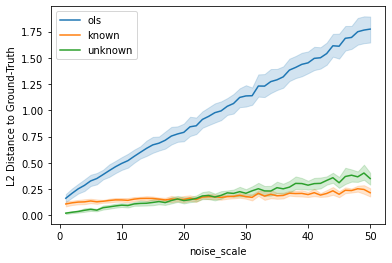

[Text(0.5, 0, 'noise_scale'), Text(0, 0.5, 'L1 Distance to Ground-Truth')]

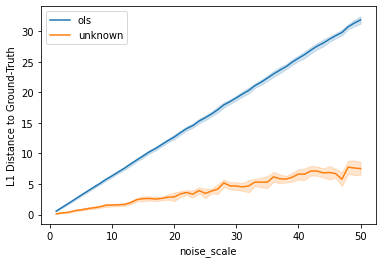

In [10]:
sns.lineplot(data=logs, x='noise_scale', y='ols_param_mse', label='ols')
# sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='noise_scale', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_scale', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

In [59]:
res.lambda_.inverse()

tensor([[2.9077]], grad_fn=<InverseBackward>)

In [142]:
ols_var

tensor([[6.6700]])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))